In this notebook, I will be testing different bp methods for SDE-GAN, including normal BP, adjoint method, and reversible heun

In [10]:
import matplotlib.pyplot as plt
import torch
import torch.optim.swa_utils as swa_utils
import torchcde
import torchsde
import tqdm

import time

In [ ]:
import sys

Let's first define a Lipschitz function that help to constrain the learning speed.

In [2]:
class LipSwish(torch.nn.Module):
    def forward(self, x):
        return 0.909 * torch.nn.functional.silu(x)

And a MLP model

In [4]:
class MLP(torch.nn.Module):
    def __init__(self, in_size, out_size, mlp_size, num_layers, tanh):
        super().__init__()

        model = [torch.nn.Linear(in_size, mlp_size),
                 LipSwish()]
        for _ in range(num_layers - 1):
            model.append(torch.nn.Linear(mlp_size, mlp_size))
        model.append(torch.nn.Linear(mlp_size, out_size))
        if tanh:
            model.append(torch.nn.Tanh())
        self._model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

The generator function is described by a Neural SDE:

In [5]:
class GeneratorFunc(torch.nn.Module):
    sde_type = 'stratonovich'
    noise_type = 'general'

    def __init__(self, noise_size, hidden_size, mlp_size, num_layers):
        super().__init__()
        self._noise_size = noise_size
        self._hidden_size = hidden_size
        self._drift = MLP(1 + hidden_size, hidden_size, mlp_size, num_layers, tanh=True)
        self._diffusion = MLP(1 + hidden_size, hidden_size * noise_size, mlp_size, num_layers, tanh=True)

    def f_and_g(self, t, x):
        # t has shape ()
        # x has shape (batch_size, hidden_size)
        t = t.expand(x.size(0), 1)
        tx = torch.cat([t, x], dim=1)
        return self._drift(tx), self._diffusion(tx).view(x.size(0), self._hidden_size, self._noise_size)

1. Normal BP

Generator, sdeint with midpoint method, without adjoint method.

In [83]:
class Generator_normalBP(torch.nn.Module):
    def __init__(self, data_size, initial_noise_size, noise_size, hidden_size, mlp_size, num_layers):
        super().__init__()
        self._initial_noise_size = initial_noise_size
        self._hidden_size = hidden_size

        self._initial = MLP(initial_noise_size, hidden_size, mlp_size, num_layers, tanh=False)
        self._func = GeneratorFunc(noise_size, hidden_size, mlp_size, num_layers)
        self._readout = torch.nn.Linear(hidden_size, data_size)

    def forward(self, ts, batch_size):
        # ts has shape (t_size,) and corresponds to the points we want to evaluate the SDE at.

        ###################
        # Actually solve the SDE.
        ###################
        init_noise = torch.randn(batch_size, self._initial_noise_size, device=ts.device)
        x0 = self._initial(init_noise)

        ###################
        # We use the normal BP to get accurate gradients whilst using the adjoint method.
        ###################
        xs = torchsde.sdeint(self._func, x0, ts, method='midpoint', dt=1.0)
        xs = xs.transpose(0, 1)
        ys = self._readout(xs)

        ###################
        # Normalise the data to the form that the discriminator expects, in particular including time as a channel.
        ###################
        ts = ts.unsqueeze(0).unsqueeze(-1).expand(batch_size, ts.size(0), 1)
        return torchcde.linear_interpolation_coeffs(torch.cat([ts, ys], dim=2))

Discriminator, Neural CDE keeps reversible heun and adjoint for comparison purposes.

In [7]:
class DiscriminatorFunc(torch.nn.Module):
    def __init__(self, data_size, hidden_size, mlp_size, num_layers):
        super().__init__()
        self._data_size = data_size
        self._hidden_size = hidden_size

        # tanh is important for model performance
        self._module = MLP(1 + hidden_size, hidden_size * (1 + data_size), mlp_size, num_layers, tanh=True)

    def forward(self, t, h):
        # t has shape ()
        # h has shape (batch_size, hidden_size)
        t = t.expand(h.size(0), 1)
        th = torch.cat([t, h], dim=1)
        return self._module(th).view(h.size(0), self._hidden_size, 1 + self._data_size)


class Discriminator(torch.nn.Module):
    def __init__(self, data_size, hidden_size, mlp_size, num_layers):
        super().__init__()

        self._initial = MLP(1 + data_size, hidden_size, mlp_size, num_layers, tanh=False)
        self._func = DiscriminatorFunc(data_size, hidden_size, mlp_size, num_layers)
        self._readout = torch.nn.Linear(hidden_size, 1)

    def forward(self, ys_coeffs):
        # ys_coeffs has shape (batch_size, t_size, 1 + data_size)
        # The +1 corresponds to time. When solving CDEs, It turns out to be most natural to treat time as just another
        # channel: in particular this makes handling irregular data quite easy, when the times may be different between
        # different samples in the batch.

        Y = torchcde.LinearInterpolation(ys_coeffs)
        Y0 = Y.evaluate(Y.interval[0])
        h0 = self._initial(Y0)
        hs = torchcde.cdeint(Y, self._func, h0, Y.interval, method='reversible_heun', backend='torchsde', dt=1.0,
                             adjoint_method='adjoint_reversible_heun',
                             adjoint_params=(ys_coeffs,) + tuple(self._func.parameters()))
        score = self._readout(hs[:, -1])
        return score.mean()


Let's define the function for getting the data

In [ ]:
dataset_size = 8192
t_size = 64

In [8]:
def get_data(t_size, dataset_size, batch_size, device):
    class OrnsteinUhlenbeckSDE(torch.nn.Module):
        sde_type = 'ito'
        noise_type = 'scalar'

        def __init__(self, mu, theta, sigma):
            super().__init__()
            self.register_buffer('mu', torch.as_tensor(mu))
            self.register_buffer('theta', torch.as_tensor(theta))
            self.register_buffer('sigma', torch.as_tensor(sigma))

        def f(self, t, y):
            return self.mu * t - self.theta * y

        def g(self, t, y):
            return self.sigma.expand(y.size(0), 1, 1) * (2 * t / t_size)

    ou_sde = OrnsteinUhlenbeckSDE(mu=0.02, theta=0.1, sigma=0.4).to(device)
    y0 = torch.rand(dataset_size, device=device).unsqueeze(-1) * 2 - 1
    ts = torch.linspace(0, t_size - 1, t_size, device=device)
    ys = torchsde.sdeint(ou_sde, y0, ts, dt=1e-1)

    ###################
    # To demonstrate how to handle irregular data, then here we additionally drop some of the data (by setting it to
    # NaN.)
    ###################
    ys_num = ys.numel()
    to_drop = torch.randperm(ys_num)[:int(0.3 * ys_num)]
    ys.view(-1)[to_drop] = float('nan')

    ###################
    # Typically important to normalise data. Note that the data is normalised with respect to the statistics of the
    # initial data, _not_ the whole time series. This seems to help the learning process, presumably because if the
    # initial condition is wrong then it's pretty hard to learn the rest of the SDE correctly.
    ###################
    y0_flat = ys[0].view(-1)
    y0_not_nan = y0_flat.masked_select(~torch.isnan(y0_flat))
    ys = (ys - y0_not_nan.mean()) / y0_not_nan.std()

    ###################
    # As discussed, time must be included as a channel for the discriminator.
    ###################
    ys = torch.cat([ts.unsqueeze(0).unsqueeze(-1).expand(dataset_size, t_size, 1),
                    ys.transpose(0, 1)], dim=2)
    # shape (dataset_size=1000, t_size=100, 1 + data_size=3)

    ###################
    # Package up.
    ###################
    data_size = ys.size(-1) - 1  # How many channels the data has (not including time, hence the minus one).
    ys_coeffs = torchcde.linear_interpolation_coeffs(ys)  # as per neural CDEs.
    dataset = torch.utils.data.TensorDataset(ys_coeffs)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return ts, data_size, dataloader

Loss evaluation.

In [9]:
def evaluate_loss(ts, batch_size, dataloader, generator, discriminator):
    with torch.no_grad():
        total_samples = 0
        total_loss = 0
        for real_samples, in dataloader:
            generated_samples = generator(ts, batch_size)
            generated_score = discriminator(generated_samples)
            real_score = discriminator(real_samples)
            loss = generated_score - real_score
            total_samples += batch_size
            total_loss += loss.item() * batch_size
    return total_loss / total_samples

Start training, 10000 steps,

In [84]:
# importing libraries
import os
import psutil
 
# inner psutil function
def process_memory():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss
 
# decorator function
def profile(func):
    def wrapper(*args, **kwargs):
 
        mem_before = process_memory()
        result = func(*args, **kwargs)
        mem_after = process_memory()
        print("{}:consumed memory: {:,}".format(
            func.__name__,
            mem_before, mem_after, mem_after - mem_before))
 
        return result
    return wrapper
 
# instantiation of decorator function
@profile


def main(
        # Architectural hyperparameters. These are quite small for illustrative purposes.
        t_size=64,             # How many timesteps to use for the SDE solver.
        data_size=8192,        # How many data points to use in the dataset.
        initial_noise_size=5,  # How many noise dimensions to sample at the start of the SDE.
        noise_size=3,          # How many dimensions the Brownian motion has.
        hidden_size=16,        # How big the hidden size of the generator SDE and the discriminator CDE are.
        mlp_size=16,           # How big the layers in the various MLPs are.
        num_layers=1,          # How many hidden layers to have in the various MLPs.

        # Training hyperparameters. Be prepared to tune these very carefully, as with any GAN.
        generator_lr=2e-4,      # Learning rate often needs careful tuning to the problem.
        discriminator_lr=1e-3,  # Learning rate often needs careful tuning to the problem.
        batch_size=1024,        # Batch size.
        steps=10000,            # How many steps to train both generator and discriminator for.
        init_mult1=3,           # Changing the initial parameter size can help.
        init_mult2=0.5,         #
        weight_decay=0.01,      # Weight decay.
        swa_step_start=5000,    # When to start using stochastic weight averaging.

        # Evaluation and plotting hyperparameters
        steps_per_print=10,                   # How often to print the loss.
        num_plot_samples=50,                  # How many samples to use on the plots at the end.
        plot_locs=(0.1, 0.3, 0.5, 0.7, 0.9),  # Plot some marginal distributions at this proportion of the way along.
):
    is_cuda = torch.cuda.is_available()
    device = 'cuda' if is_cuda else 'cpu'
    if not is_cuda:
        print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

    # Data
    ts, data_size, train_dataloader = get_data(t_size=t_size, dataset_size= data_size, batch_size=batch_size, device=device)
    infinite_train_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)

    # Models
    generator = Generator_normalBP(data_size, initial_noise_size, noise_size, hidden_size, mlp_size, num_layers).to(device)
    discriminator = Discriminator(data_size, hidden_size, mlp_size, num_layers).to(device)
    # Weight averaging really helps with GAN training.
    averaged_generator = swa_utils.AveragedModel(generator)
    averaged_discriminator = swa_utils.AveragedModel(discriminator)

    # Picking a good initialisation is important!
    # In this case these were picked by making the parameters for the t=0 part of the generator be roughly the right
    # size that the untrained t=0 distribution has a similar variance to the t=0 data distribution.
    # Then the func parameters were adjusted so that the t>0 distribution looked like it had about the right variance.
    # What we're doing here is very crude -- one can definitely imagine smarter ways of doing things.
    # (e.g. pretraining the t=0 distribution)
    with torch.no_grad():
        for param in generator._initial.parameters():
            param *= init_mult1
        for param in generator._func.parameters():
            param *= init_mult2

    # Optimisers. Adadelta turns out to be a much better choice than SGD or Adam, interestingly.
    generator_optimiser = torch.optim.Adadelta(generator.parameters(), lr=generator_lr, weight_decay=weight_decay)
    discriminator_optimiser = torch.optim.Adadelta(discriminator.parameters(), lr=discriminator_lr,
                                                   weight_decay=weight_decay)

    # Train both generator and discriminator.
    t0 = time.time()

    trange = tqdm.tqdm(range(steps))
    for step in trange:
        real_samples, = next(infinite_train_dataloader)

        generated_samples = generator(ts, batch_size)
        generated_score = discriminator(generated_samples)
        real_score = discriminator(real_samples)
        loss = generated_score - real_score
        loss.backward()

        for param in generator.parameters():
            param.grad *= -1
        generator_optimiser.step()
        discriminator_optimiser.step()
        generator_optimiser.zero_grad()
        discriminator_optimiser.zero_grad()

        ###################
        # We constrain the Lipschitz constant of the discriminator using carefully-chosen clipping (and the use of
        # LipSwish activation functions).
        ###################
        with torch.no_grad():
            for module in discriminator.modules():
                if isinstance(module, torch.nn.Linear):
                    lim = 1 / module.out_features
                    module.weight.clamp_(-lim, lim)

        # Stochastic weight averaging typically improves performance.
        if step > swa_step_start:
            averaged_generator.update_parameters(generator)
            averaged_discriminator.update_parameters(discriminator)

        if (step % steps_per_print) == 0 or step == steps - 1:
            total_unaveraged_loss = evaluate_loss(ts, batch_size, train_dataloader, generator, discriminator)
            if step > swa_step_start:
                total_averaged_loss = evaluate_loss(ts, batch_size, train_dataloader, averaged_generator.module,
                                                    averaged_discriminator.module)
                trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f} "
                             f"Loss (averaged): {total_averaged_loss:.4f}")
            else:
                trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f}")

    print("Training time:", time.time()-t0)
    generator.load_state_dict(averaged_generator.module.state_dict())
    discriminator.load_state_dict(averaged_discriminator.module.state_dict())
    return ts, generator

ts_bp, generator_bp = main()

  0%|          | 1/10000 [00:02<7:12:32,  2.60s/it]

Step:   0 Loss (unaveraged): -2.5803


  0%|          | 11/10000 [00:10<3:10:55,  1.15s/it]

Step:  10 Loss (unaveraged): -2.5864


  0%|          | 21/10000 [00:19<3:15:16,  1.17s/it]

Step:  20 Loss (unaveraged): -2.6022


  0%|          | 31/10000 [00:27<3:10:16,  1.15s/it]

Step:  30 Loss (unaveraged): -2.6232


  0%|          | 41/10000 [00:37<5:19:27,  1.92s/it]

Step:  40 Loss (unaveraged): -2.6422


  1%|          | 51/10000 [00:49<3:41:08,  1.33s/it]

Step:  50 Loss (unaveraged): -2.6621


  1%|          | 61/10000 [00:59<3:19:28,  1.20s/it]

Step:  60 Loss (unaveraged): -2.6943


  1%|          | 71/10000 [01:07<3:28:15,  1.26s/it]

Step:  70 Loss (unaveraged): -2.6901


  1%|          | 81/10000 [01:14<3:05:44,  1.12s/it]

Step:  80 Loss (unaveraged): -2.7174


  1%|          | 91/10000 [01:22<2:59:17,  1.09s/it]

Step:  90 Loss (unaveraged): -2.7542


  1%|          | 101/10000 [01:30<3:23:21,  1.23s/it]

Step: 100 Loss (unaveraged): -2.7727


  1%|          | 111/10000 [01:39<3:11:31,  1.16s/it]

Step: 110 Loss (unaveraged): -2.7963


  1%|          | 121/10000 [01:46<2:54:41,  1.06s/it]

Step: 120 Loss (unaveraged): -2.8210


  1%|▏         | 131/10000 [01:53<2:54:52,  1.06s/it]

Step: 130 Loss (unaveraged): -2.8383


  1%|▏         | 141/10000 [02:00<2:47:17,  1.02s/it]

Step: 140 Loss (unaveraged): -2.8702


  2%|▏         | 151/10000 [02:09<3:18:09,  1.21s/it]

Step: 150 Loss (unaveraged): -2.9025


  2%|▏         | 161/10000 [02:17<3:08:15,  1.15s/it]

Step: 160 Loss (unaveraged): -2.9183


  2%|▏         | 171/10000 [02:24<2:51:42,  1.05s/it]

Step: 170 Loss (unaveraged): -2.9434


  2%|▏         | 181/10000 [02:32<2:55:51,  1.07s/it]

Step: 180 Loss (unaveraged): -2.9738


  2%|▏         | 191/10000 [02:39<3:14:08,  1.19s/it]

Step: 190 Loss (unaveraged): -2.9937


  2%|▏         | 201/10000 [02:47<3:05:26,  1.14s/it]

Step: 200 Loss (unaveraged): -3.0324


  2%|▏         | 211/10000 [02:54<2:45:03,  1.01s/it]

Step: 210 Loss (unaveraged): -3.0616


  2%|▏         | 221/10000 [03:02<2:56:15,  1.08s/it]

Step: 220 Loss (unaveraged): -3.0835


  2%|▏         | 231/10000 [03:09<2:57:27,  1.09s/it]

Step: 230 Loss (unaveraged): -3.1093


  2%|▏         | 241/10000 [03:18<3:27:51,  1.28s/it]

Step: 240 Loss (unaveraged): -3.1518


  3%|▎         | 251/10000 [03:25<2:53:36,  1.07s/it]

Step: 250 Loss (unaveraged): -3.1556


  3%|▎         | 261/10000 [03:33<2:57:19,  1.09s/it]

Step: 260 Loss (unaveraged): -3.1918


  3%|▎         | 271/10000 [03:41<3:23:44,  1.26s/it]

Step: 270 Loss (unaveraged): -3.2160


  3%|▎         | 281/10000 [03:49<3:21:38,  1.24s/it]

Step: 280 Loss (unaveraged): -3.2539


  3%|▎         | 291/10000 [03:57<3:00:50,  1.12s/it]

Step: 290 Loss (unaveraged): -3.2629


  3%|▎         | 301/10000 [04:06<3:21:35,  1.25s/it]

Step: 300 Loss (unaveraged): -3.3177


  3%|▎         | 311/10000 [04:14<3:04:10,  1.14s/it]

Step: 310 Loss (unaveraged): -3.3341


  3%|▎         | 321/10000 [04:21<2:59:33,  1.11s/it]

Step: 320 Loss (unaveraged): -3.3421


  3%|▎         | 331/10000 [04:30<3:32:52,  1.32s/it]

Step: 330 Loss (unaveraged): -3.3961


  3%|▎         | 341/10000 [04:37<2:51:04,  1.06s/it]

Step: 340 Loss (unaveraged): -3.4199


  4%|▎         | 351/10000 [04:45<2:56:52,  1.10s/it]

Step: 350 Loss (unaveraged): -3.4659


  4%|▎         | 361/10000 [04:52<2:49:00,  1.05s/it]

Step: 360 Loss (unaveraged): -3.4622


  4%|▎         | 371/10000 [04:59<2:51:30,  1.07s/it]

Step: 370 Loss (unaveraged): -3.5047


  4%|▍         | 381/10000 [05:06<2:51:18,  1.07s/it]

Step: 380 Loss (unaveraged): -3.5390


  4%|▍         | 391/10000 [05:14<2:51:28,  1.07s/it]

Step: 390 Loss (unaveraged): -3.5797


  4%|▍         | 401/10000 [05:21<3:04:28,  1.15s/it]

Step: 400 Loss (unaveraged): -3.6110


  4%|▍         | 411/10000 [05:29<3:01:37,  1.14s/it]

Step: 410 Loss (unaveraged): -3.6424


  4%|▍         | 421/10000 [05:38<3:36:15,  1.35s/it]

Step: 420 Loss (unaveraged): -3.6879


  4%|▍         | 431/10000 [05:45<2:55:30,  1.10s/it]

Step: 430 Loss (unaveraged): -3.6976


  4%|▍         | 441/10000 [05:53<2:51:51,  1.08s/it]

Step: 440 Loss (unaveraged): -3.7199


  5%|▍         | 451/10000 [06:00<2:49:09,  1.06s/it]

Step: 450 Loss (unaveraged): -3.7989


  5%|▍         | 461/10000 [06:07<2:56:05,  1.11s/it]

Step: 460 Loss (unaveraged): -3.8103


  5%|▍         | 471/10000 [06:15<2:50:10,  1.07s/it]

Step: 470 Loss (unaveraged): -3.8542


  5%|▍         | 481/10000 [06:22<2:54:36,  1.10s/it]

Step: 480 Loss (unaveraged): -3.8981


  5%|▍         | 491/10000 [06:30<2:51:50,  1.08s/it]

Step: 490 Loss (unaveraged): -3.9036


  5%|▌         | 501/10000 [06:37<2:49:06,  1.07s/it]

Step: 500 Loss (unaveraged): -3.9682


  5%|▌         | 511/10000 [06:47<3:50:32,  1.46s/it]

Step: 510 Loss (unaveraged): -3.9893


  5%|▌         | 521/10000 [06:55<3:07:15,  1.19s/it]

Step: 520 Loss (unaveraged): -4.0377


  5%|▌         | 531/10000 [07:02<2:48:21,  1.07s/it]

Step: 530 Loss (unaveraged): -4.0948


  5%|▌         | 541/10000 [07:10<2:49:39,  1.08s/it]

Step: 540 Loss (unaveraged): -4.1098


  6%|▌         | 551/10000 [07:17<2:50:59,  1.09s/it]

Step: 550 Loss (unaveraged): -4.1610


  6%|▌         | 561/10000 [07:25<2:48:48,  1.07s/it]

Step: 560 Loss (unaveraged): -4.2008


  6%|▌         | 571/10000 [07:32<2:43:47,  1.04s/it]

Step: 570 Loss (unaveraged): -4.2529


  6%|▌         | 581/10000 [07:39<2:46:15,  1.06s/it]

Step: 580 Loss (unaveraged): -4.2811


  6%|▌         | 591/10000 [07:47<2:43:06,  1.04s/it]

Step: 590 Loss (unaveraged): -4.3099


  6%|▌         | 601/10000 [07:55<3:00:48,  1.15s/it]

Step: 600 Loss (unaveraged): -4.3770


  6%|▌         | 611/10000 [08:03<2:49:05,  1.08s/it]

Step: 610 Loss (unaveraged): -4.4430


  6%|▌         | 621/10000 [08:10<2:43:40,  1.05s/it]

Step: 620 Loss (unaveraged): -4.5020


  6%|▋         | 631/10000 [08:17<2:53:41,  1.11s/it]

Step: 630 Loss (unaveraged): -4.5498


  6%|▋         | 641/10000 [08:25<3:13:16,  1.24s/it]

Step: 640 Loss (unaveraged): -4.6209


  7%|▋         | 651/10000 [08:33<3:06:34,  1.20s/it]

Step: 650 Loss (unaveraged): -4.6773


  7%|▋         | 661/10000 [08:41<2:47:20,  1.08s/it]

Step: 660 Loss (unaveraged): -4.7403


  7%|▋         | 671/10000 [08:48<2:48:20,  1.08s/it]

Step: 670 Loss (unaveraged): -4.7873


  7%|▋         | 681/10000 [08:56<3:09:33,  1.22s/it]

Step: 680 Loss (unaveraged): -4.8684


  7%|▋         | 691/10000 [09:05<2:54:28,  1.12s/it]

Step: 690 Loss (unaveraged): -4.9595


  7%|▋         | 701/10000 [09:12<2:53:49,  1.12s/it]

Step: 700 Loss (unaveraged): -5.0142


  7%|▋         | 711/10000 [09:20<2:57:52,  1.15s/it]

Step: 710 Loss (unaveraged): -5.0910


  7%|▋         | 721/10000 [09:28<2:54:22,  1.13s/it]

Step: 720 Loss (unaveraged): -5.1712


  7%|▋         | 731/10000 [09:35<2:52:16,  1.12s/it]

Step: 730 Loss (unaveraged): -5.2658


  7%|▋         | 741/10000 [09:43<2:43:06,  1.06s/it]

Step: 740 Loss (unaveraged): -5.3633


  8%|▊         | 751/10000 [09:50<2:43:54,  1.06s/it]

Step: 750 Loss (unaveraged): -5.4398


  8%|▊         | 761/10000 [09:57<2:43:56,  1.06s/it]

Step: 760 Loss (unaveraged): -5.5596


  8%|▊         | 771/10000 [10:06<4:02:14,  1.57s/it]

Step: 770 Loss (unaveraged): -5.6930


  8%|▊         | 781/10000 [10:14<2:47:41,  1.09s/it]

Step: 780 Loss (unaveraged): -5.7798


  8%|▊         | 791/10000 [10:22<2:44:24,  1.07s/it]

Step: 790 Loss (unaveraged): -5.9427


  8%|▊         | 801/10000 [10:29<2:47:42,  1.09s/it]

Step: 800 Loss (unaveraged): -6.0325


  8%|▊         | 811/10000 [10:43<5:32:22,  2.17s/it]

Step: 810 Loss (unaveraged): -6.1815


  8%|▊         | 821/10000 [10:52<3:15:06,  1.28s/it]

Step: 820 Loss (unaveraged): -6.3582


  8%|▊         | 831/10000 [11:00<3:01:11,  1.19s/it]

Step: 830 Loss (unaveraged): -6.4542


  8%|▊         | 841/10000 [11:08<2:46:03,  1.09s/it]

Step: 840 Loss (unaveraged): -6.6587


  9%|▊         | 851/10000 [11:15<2:52:31,  1.13s/it]

Step: 850 Loss (unaveraged): -6.7892


  9%|▊         | 861/10000 [11:25<3:42:42,  1.46s/it]

Step: 860 Loss (unaveraged): -6.9170


  9%|▊         | 871/10000 [11:32<2:49:56,  1.12s/it]

Step: 870 Loss (unaveraged): -7.1144


  9%|▉         | 881/10000 [11:40<2:50:40,  1.12s/it]

Step: 880 Loss (unaveraged): -7.2999


  9%|▉         | 891/10000 [11:48<3:03:50,  1.21s/it]

Step: 890 Loss (unaveraged): -7.5383


  9%|▉         | 901/10000 [11:56<2:49:21,  1.12s/it]

Step: 900 Loss (unaveraged): -7.7207


  9%|▉         | 911/10000 [12:04<2:57:51,  1.17s/it]

Step: 910 Loss (unaveraged): -8.0153


  9%|▉         | 921/10000 [12:11<2:56:04,  1.16s/it]

Step: 920 Loss (unaveraged): -8.2276


  9%|▉         | 931/10000 [12:19<2:49:12,  1.12s/it]

Step: 930 Loss (unaveraged): -8.5004


  9%|▉         | 941/10000 [12:27<2:55:30,  1.16s/it]

Step: 940 Loss (unaveraged): -8.7696


 10%|▉         | 951/10000 [12:36<3:10:55,  1.27s/it]

Step: 950 Loss (unaveraged): -9.0023


 10%|▉         | 961/10000 [12:43<2:50:13,  1.13s/it]

Step: 960 Loss (unaveraged): -9.1428


 10%|▉         | 971/10000 [12:52<3:06:23,  1.24s/it]

Step: 970 Loss (unaveraged): -9.4023


 10%|▉         | 981/10000 [12:59<2:38:48,  1.06s/it]

Step: 980 Loss (unaveraged): -9.6458


 10%|▉         | 991/10000 [13:06<2:44:54,  1.10s/it]

Step: 990 Loss (unaveraged): -9.6393


 10%|█         | 1001/10000 [13:14<2:42:43,  1.08s/it]

Step: 1000 Loss (unaveraged): -9.5462


 10%|█         | 1011/10000 [13:21<2:37:24,  1.05s/it]

Step: 1010 Loss (unaveraged): -9.4193


 10%|█         | 1021/10000 [13:28<2:38:29,  1.06s/it]

Step: 1020 Loss (unaveraged): -8.8579


 10%|█         | 1031/10000 [13:36<2:56:34,  1.18s/it]

Step: 1030 Loss (unaveraged): -8.3337


 10%|█         | 1041/10000 [13:46<3:10:23,  1.28s/it]

Step: 1040 Loss (unaveraged): -7.2365


 11%|█         | 1051/10000 [13:54<2:41:29,  1.08s/it]

Step: 1050 Loss (unaveraged): -5.9022


 11%|█         | 1061/10000 [14:01<2:41:38,  1.09s/it]

Step: 1060 Loss (unaveraged): -4.7047


 11%|█         | 1071/10000 [14:08<2:32:09,  1.02s/it]

Step: 1070 Loss (unaveraged): -2.7637


 11%|█         | 1081/10000 [14:16<2:46:54,  1.12s/it]

Step: 1080 Loss (unaveraged): -1.3008


 11%|█         | 1091/10000 [14:23<2:36:01,  1.05s/it]

Step: 1090 Loss (unaveraged): 0.3160


 11%|█         | 1101/10000 [14:30<2:37:20,  1.06s/it]

Step: 1100 Loss (unaveraged): 1.4839


 11%|█         | 1111/10000 [14:38<2:40:57,  1.09s/it]

Step: 1110 Loss (unaveraged): 2.0038


 11%|█         | 1121/10000 [14:46<3:29:01,  1.41s/it]

Step: 1120 Loss (unaveraged): 2.0831


 11%|█▏        | 1131/10000 [14:54<2:48:56,  1.14s/it]

Step: 1130 Loss (unaveraged): 1.6648


 11%|█▏        | 1141/10000 [15:02<3:06:39,  1.26s/it]

Step: 1140 Loss (unaveraged): 0.8751


 12%|█▏        | 1151/10000 [15:10<2:49:54,  1.15s/it]

Step: 1150 Loss (unaveraged): -0.2412


 12%|█▏        | 1161/10000 [15:18<3:07:19,  1.27s/it]

Step: 1160 Loss (unaveraged): -1.5968


 12%|█▏        | 1171/10000 [15:26<2:41:00,  1.09s/it]

Step: 1170 Loss (unaveraged): -3.2572


 12%|█▏        | 1181/10000 [15:34<2:44:07,  1.12s/it]

Step: 1180 Loss (unaveraged): -4.7812


 12%|█▏        | 1191/10000 [15:42<2:41:45,  1.10s/it]

Step: 1190 Loss (unaveraged): -6.1363


 12%|█▏        | 1201/10000 [15:49<2:40:02,  1.09s/it]

Step: 1200 Loss (unaveraged): -7.1118


 12%|█▏        | 1211/10000 [15:58<3:35:55,  1.47s/it]

Step: 1210 Loss (unaveraged): -7.8309


 12%|█▏        | 1221/10000 [16:05<2:37:09,  1.07s/it]

Step: 1220 Loss (unaveraged): -8.3641


 12%|█▏        | 1231/10000 [16:13<2:39:14,  1.09s/it]

Step: 1230 Loss (unaveraged): -8.6214


 12%|█▏        | 1241/10000 [16:20<2:32:31,  1.04s/it]

Step: 1240 Loss (unaveraged): -8.8274


 13%|█▎        | 1251/10000 [16:27<2:34:56,  1.06s/it]

Step: 1250 Loss (unaveraged): -8.7749


 13%|█▎        | 1261/10000 [16:35<2:35:24,  1.07s/it]

Step: 1260 Loss (unaveraged): -8.5486


 13%|█▎        | 1271/10000 [16:42<2:40:20,  1.10s/it]

Step: 1270 Loss (unaveraged): -8.0646


 13%|█▎        | 1281/10000 [16:50<2:36:16,  1.08s/it]

Step: 1280 Loss (unaveraged): -7.3894


 13%|█▎        | 1291/10000 [16:57<2:37:46,  1.09s/it]

Step: 1290 Loss (unaveraged): -6.8231


 13%|█▎        | 1301/10000 [17:05<3:24:33,  1.41s/it]

Step: 1300 Loss (unaveraged): -6.0940


 13%|█▎        | 1311/10000 [17:13<2:38:06,  1.09s/it]

Step: 1310 Loss (unaveraged): -5.2566


 13%|█▎        | 1321/10000 [17:20<2:32:00,  1.05s/it]

Step: 1320 Loss (unaveraged): -4.5824


 13%|█▎        | 1331/10000 [17:27<2:35:36,  1.08s/it]

Step: 1330 Loss (unaveraged): -3.9207


 13%|█▎        | 1341/10000 [17:35<2:32:50,  1.06s/it]

Step: 1340 Loss (unaveraged): -3.5216


 14%|█▎        | 1351/10000 [17:42<2:34:22,  1.07s/it]

Step: 1350 Loss (unaveraged): -3.3717


 14%|█▎        | 1361/10000 [17:49<2:31:23,  1.05s/it]

Step: 1360 Loss (unaveraged): -3.5201


 14%|█▎        | 1371/10000 [17:57<2:34:48,  1.08s/it]

Step: 1370 Loss (unaveraged): -4.0047


 14%|█▍        | 1381/10000 [18:04<2:30:58,  1.05s/it]

Step: 1380 Loss (unaveraged): -5.2778


 14%|█▍        | 1391/10000 [18:13<3:23:19,  1.42s/it]

Step: 1390 Loss (unaveraged): -6.7065


 14%|█▍        | 1401/10000 [18:20<2:43:58,  1.14s/it]

Step: 1400 Loss (unaveraged): -7.9093


 14%|█▍        | 1411/10000 [18:28<2:42:00,  1.13s/it]

Step: 1410 Loss (unaveraged): -8.3813


 14%|█▍        | 1421/10000 [18:36<2:46:51,  1.17s/it]

Step: 1420 Loss (unaveraged): -8.3754


 14%|█▍        | 1431/10000 [18:44<2:42:43,  1.14s/it]

Step: 1430 Loss (unaveraged): -8.2341


 14%|█▍        | 1441/10000 [18:51<2:35:24,  1.09s/it]

Step: 1440 Loss (unaveraged): -7.7222


 15%|█▍        | 1451/10000 [18:59<2:35:31,  1.09s/it]

Step: 1450 Loss (unaveraged): -7.4272


 15%|█▍        | 1461/10000 [19:06<2:37:14,  1.10s/it]

Step: 1460 Loss (unaveraged): -7.1620


 15%|█▍        | 1471/10000 [19:14<2:40:47,  1.13s/it]

Step: 1470 Loss (unaveraged): -6.5391


 15%|█▍        | 1481/10000 [19:23<3:29:57,  1.48s/it]

Step: 1480 Loss (unaveraged): -6.7086


 15%|█▍        | 1491/10000 [19:30<2:36:49,  1.11s/it]

Step: 1490 Loss (unaveraged): -6.5530


 15%|█▌        | 1501/10000 [19:38<2:34:42,  1.09s/it]

Step: 1500 Loss (unaveraged): -6.4667


 15%|█▌        | 1511/10000 [19:45<2:32:37,  1.08s/it]

Step: 1510 Loss (unaveraged): -6.5225


 15%|█▌        | 1521/10000 [19:52<2:31:50,  1.07s/it]

Step: 1520 Loss (unaveraged): -6.5426


 15%|█▌        | 1531/10000 [20:00<2:31:19,  1.07s/it]

Step: 1530 Loss (unaveraged): -6.3975


 15%|█▌        | 1541/10000 [20:07<2:35:00,  1.10s/it]

Step: 1540 Loss (unaveraged): -6.5017


 16%|█▌        | 1551/10000 [20:15<2:30:11,  1.07s/it]

Step: 1550 Loss (unaveraged): -6.6260


 16%|█▌        | 1561/10000 [20:22<2:40:25,  1.14s/it]

Step: 1560 Loss (unaveraged): -6.3461


 16%|█▌        | 1571/10000 [20:33<4:27:07,  1.90s/it]

Step: 1570 Loss (unaveraged): -6.3409


 16%|█▌        | 1581/10000 [20:46<4:11:28,  1.79s/it]

Step: 1580 Loss (unaveraged): -6.1559


 16%|█▌        | 1591/10000 [20:54<2:41:22,  1.15s/it]

Step: 1590 Loss (unaveraged): -6.0805


 16%|█▌        | 1601/10000 [21:01<2:24:12,  1.03s/it]

Step: 1600 Loss (unaveraged): -5.8114


 16%|█▌        | 1611/10000 [21:08<2:26:08,  1.05s/it]

Step: 1610 Loss (unaveraged): -5.7007


 16%|█▌        | 1621/10000 [21:16<2:41:32,  1.16s/it]

Step: 1620 Loss (unaveraged): -5.1306


 16%|█▋        | 1631/10000 [21:25<2:54:03,  1.25s/it]

Step: 1630 Loss (unaveraged): -4.9532


 16%|█▋        | 1641/10000 [21:33<2:37:20,  1.13s/it]

Step: 1640 Loss (unaveraged): -4.8596


 17%|█▋        | 1651/10000 [21:42<3:03:59,  1.32s/it]

Step: 1650 Loss (unaveraged): -4.3927


 17%|█▋        | 1661/10000 [21:52<3:42:43,  1.60s/it]

Step: 1660 Loss (unaveraged): -4.3358


 17%|█▋        | 1671/10000 [22:01<3:13:16,  1.39s/it]

Step: 1670 Loss (unaveraged): -3.7255


 17%|█▋        | 1681/10000 [22:10<2:45:35,  1.19s/it]

Step: 1680 Loss (unaveraged): -3.5706


 17%|█▋        | 1691/10000 [22:18<2:38:31,  1.14s/it]

Step: 1690 Loss (unaveraged): -3.4598


 17%|█▋        | 1701/10000 [22:26<2:45:28,  1.20s/it]

Step: 1700 Loss (unaveraged): -2.7049


 17%|█▋        | 1711/10000 [22:34<2:47:44,  1.21s/it]

Step: 1710 Loss (unaveraged): -2.2363


 17%|█▋        | 1721/10000 [22:42<3:04:54,  1.34s/it]

Step: 1720 Loss (unaveraged): -2.1351


 17%|█▋        | 1731/10000 [22:51<2:54:38,  1.27s/it]

Step: 1730 Loss (unaveraged): -1.3225


 17%|█▋        | 1741/10000 [22:59<2:59:02,  1.30s/it]

Step: 1740 Loss (unaveraged): -0.8966


 18%|█▊        | 1751/10000 [23:09<3:07:21,  1.36s/it]

Step: 1750 Loss (unaveraged): -0.6384


 18%|█▊        | 1761/10000 [23:17<2:39:12,  1.16s/it]

Step: 1760 Loss (unaveraged): -0.0277


 18%|█▊        | 1771/10000 [23:24<2:32:53,  1.11s/it]

Step: 1770 Loss (unaveraged): 0.4538


 18%|█▊        | 1781/10000 [23:32<2:36:52,  1.15s/it]

Step: 1780 Loss (unaveraged): 0.8378


 18%|█▊        | 1791/10000 [23:40<2:36:31,  1.14s/it]

Step: 1790 Loss (unaveraged): 1.2045


 18%|█▊        | 1801/10000 [23:48<2:36:26,  1.14s/it]

Step: 1800 Loss (unaveraged): 1.4370


 18%|█▊        | 1811/10000 [23:56<2:38:48,  1.16s/it]

Step: 1810 Loss (unaveraged): 2.0254


 18%|█▊        | 1821/10000 [24:04<2:29:51,  1.10s/it]

Step: 1820 Loss (unaveraged): 2.1437


 18%|█▊        | 1831/10000 [24:12<2:48:47,  1.24s/it]

Step: 1830 Loss (unaveraged): 2.7941


 18%|█▊        | 1841/10000 [24:22<3:16:55,  1.45s/it]

Step: 1840 Loss (unaveraged): 3.0531


 19%|█▊        | 1851/10000 [24:30<2:26:24,  1.08s/it]

Step: 1850 Loss (unaveraged): 3.5045


 19%|█▊        | 1861/10000 [24:38<2:42:50,  1.20s/it]

Step: 1860 Loss (unaveraged): 3.4556


 19%|█▊        | 1871/10000 [24:46<2:45:55,  1.22s/it]

Step: 1870 Loss (unaveraged): 4.0476


 19%|█▉        | 1881/10000 [24:55<2:52:16,  1.27s/it]

Step: 1880 Loss (unaveraged): 4.1024


 19%|█▉        | 1891/10000 [25:02<2:30:43,  1.12s/it]

Step: 1890 Loss (unaveraged): 4.1988


 19%|█▉        | 1901/10000 [25:10<2:35:31,  1.15s/it]

Step: 1900 Loss (unaveraged): 4.3417


 19%|█▉        | 1911/10000 [25:18<2:29:43,  1.11s/it]

Step: 1910 Loss (unaveraged): 4.3612


 19%|█▉        | 1921/10000 [25:27<3:16:18,  1.46s/it]

Step: 1920 Loss (unaveraged): 4.3094


 19%|█▉        | 1931/10000 [25:34<2:36:18,  1.16s/it]

Step: 1930 Loss (unaveraged): 4.4392


 19%|█▉        | 1941/10000 [25:42<2:30:19,  1.12s/it]

Step: 1940 Loss (unaveraged): 4.4072


 20%|█▉        | 1951/10000 [25:49<2:19:13,  1.04s/it]

Step: 1950 Loss (unaveraged): 4.4680


 20%|█▉        | 1961/10000 [25:57<2:15:05,  1.01s/it]

Step: 1960 Loss (unaveraged): 4.4003


 20%|█▉        | 1971/10000 [26:04<2:18:57,  1.04s/it]

Step: 1970 Loss (unaveraged): 4.5231


 20%|█▉        | 1981/10000 [26:11<2:18:03,  1.03s/it]

Step: 1980 Loss (unaveraged): 4.4847


 20%|█▉        | 1991/10000 [26:18<2:20:17,  1.05s/it]

Step: 1990 Loss (unaveraged): 4.4421


 20%|██        | 2001/10000 [26:25<2:18:50,  1.04s/it]

Step: 2000 Loss (unaveraged): 4.3272


 20%|██        | 2011/10000 [26:34<3:10:34,  1.43s/it]

Step: 2010 Loss (unaveraged): 4.2906


 20%|██        | 2021/10000 [26:41<2:39:04,  1.20s/it]

Step: 2020 Loss (unaveraged): 4.3893


 20%|██        | 2031/10000 [26:49<2:29:02,  1.12s/it]

Step: 2030 Loss (unaveraged): 4.2210


 20%|██        | 2041/10000 [26:57<2:30:22,  1.13s/it]

Step: 2040 Loss (unaveraged): 4.0075


 21%|██        | 2051/10000 [27:04<2:30:10,  1.13s/it]

Step: 2050 Loss (unaveraged): 3.9763


 21%|██        | 2061/10000 [27:12<2:31:10,  1.14s/it]

Step: 2060 Loss (unaveraged): 3.8952


 21%|██        | 2071/10000 [27:20<2:35:57,  1.18s/it]

Step: 2070 Loss (unaveraged): 3.7691


 21%|██        | 2081/10000 [27:28<2:35:47,  1.18s/it]

Step: 2080 Loss (unaveraged): 3.6939


 21%|██        | 2091/10000 [27:36<2:34:41,  1.17s/it]

Step: 2090 Loss (unaveraged): 3.5346


 21%|██        | 2101/10000 [27:45<3:15:01,  1.48s/it]

Step: 2100 Loss (unaveraged): 3.5569


 21%|██        | 2111/10000 [27:53<2:33:02,  1.16s/it]

Step: 2110 Loss (unaveraged): 3.4516


 21%|██        | 2121/10000 [28:01<2:34:19,  1.18s/it]

Step: 2120 Loss (unaveraged): 3.3049


 21%|██▏       | 2131/10000 [28:08<2:27:18,  1.12s/it]

Step: 2130 Loss (unaveraged): 3.2538


 21%|██▏       | 2141/10000 [28:16<2:27:28,  1.13s/it]

Step: 2140 Loss (unaveraged): 3.1870


 22%|██▏       | 2151/10000 [28:24<2:27:59,  1.13s/it]

Step: 2150 Loss (unaveraged): 2.9851


 22%|██▏       | 2161/10000 [28:31<2:24:45,  1.11s/it]

Step: 2160 Loss (unaveraged): 2.8825


 22%|██▏       | 2171/10000 [28:39<2:26:12,  1.12s/it]

Step: 2170 Loss (unaveraged): 2.7014


 22%|██▏       | 2181/10000 [28:47<2:29:30,  1.15s/it]

Step: 2180 Loss (unaveraged): 2.5453


 22%|██▏       | 2191/10000 [28:56<3:14:44,  1.50s/it]

Step: 2190 Loss (unaveraged): 2.3880


 22%|██▏       | 2201/10000 [29:04<2:31:36,  1.17s/it]

Step: 2200 Loss (unaveraged): 2.2313


 22%|██▏       | 2211/10000 [29:12<2:30:24,  1.16s/it]

Step: 2210 Loss (unaveraged): 2.0484


 22%|██▏       | 2221/10000 [29:20<2:29:45,  1.16s/it]

Step: 2220 Loss (unaveraged): 1.7900


 22%|██▏       | 2231/10000 [29:28<2:49:06,  1.31s/it]

Step: 2230 Loss (unaveraged): 1.6348


 22%|██▏       | 2241/10000 [29:37<2:42:41,  1.26s/it]

Step: 2240 Loss (unaveraged): 1.4979


 23%|██▎       | 2251/10000 [29:46<2:38:40,  1.23s/it]

Step: 2250 Loss (unaveraged): 1.2979


 23%|██▎       | 2261/10000 [29:53<2:29:37,  1.16s/it]

Step: 2260 Loss (unaveraged): 1.1246


 23%|██▎       | 2271/10000 [30:01<2:23:31,  1.11s/it]

Step: 2270 Loss (unaveraged): 0.9696


 23%|██▎       | 2281/10000 [30:10<3:11:28,  1.49s/it]

Step: 2280 Loss (unaveraged): 0.8252


 23%|██▎       | 2291/10000 [30:18<2:46:06,  1.29s/it]

Step: 2290 Loss (unaveraged): 0.6787


 23%|██▎       | 2301/10000 [30:26<2:27:43,  1.15s/it]

Step: 2300 Loss (unaveraged): 0.5170


 23%|██▎       | 2311/10000 [30:39<4:51:03,  2.27s/it]

Step: 2310 Loss (unaveraged): 0.3768


 23%|██▎       | 2321/10000 [30:51<2:49:20,  1.32s/it]

Step: 2320 Loss (unaveraged): 0.2347


 23%|██▎       | 2331/10000 [30:59<2:27:16,  1.15s/it]

Step: 2330 Loss (unaveraged): 0.0835


 23%|██▎       | 2341/10000 [31:07<2:24:19,  1.13s/it]

Step: 2340 Loss (unaveraged): -0.0687


 24%|██▎       | 2351/10000 [31:15<2:26:16,  1.15s/it]

Step: 2350 Loss (unaveraged): -0.2007


 24%|██▎       | 2361/10000 [31:22<2:24:43,  1.14s/it]

Step: 2360 Loss (unaveraged): -0.3530


 24%|██▎       | 2371/10000 [31:31<2:54:52,  1.38s/it]

Step: 2370 Loss (unaveraged): -0.5038


 24%|██▍       | 2381/10000 [31:40<2:30:41,  1.19s/it]

Step: 2380 Loss (unaveraged): -0.6550


 24%|██▍       | 2391/10000 [31:48<2:47:23,  1.32s/it]

Step: 2390 Loss (unaveraged): -0.7951


 24%|██▍       | 2401/10000 [31:57<2:43:25,  1.29s/it]

Step: 2400 Loss (unaveraged): -0.9396


 24%|██▍       | 2411/10000 [32:05<2:26:40,  1.16s/it]

Step: 2410 Loss (unaveraged): -1.0745


 24%|██▍       | 2421/10000 [32:14<2:47:51,  1.33s/it]

Step: 2420 Loss (unaveraged): -1.1989


 24%|██▍       | 2431/10000 [32:22<2:36:51,  1.24s/it]

Step: 2430 Loss (unaveraged): -1.3274


 24%|██▍       | 2441/10000 [32:30<2:25:49,  1.16s/it]

Step: 2440 Loss (unaveraged): -1.4357


 25%|██▍       | 2451/10000 [32:38<2:31:19,  1.20s/it]

Step: 2450 Loss (unaveraged): -1.5514


 25%|██▍       | 2461/10000 [32:48<3:26:28,  1.64s/it]

Step: 2460 Loss (unaveraged): -1.6455


 25%|██▍       | 2471/10000 [32:56<2:34:14,  1.23s/it]

Step: 2470 Loss (unaveraged): -1.7478


 25%|██▍       | 2481/10000 [33:05<2:27:25,  1.18s/it]

Step: 2480 Loss (unaveraged): -1.8453


 25%|██▍       | 2491/10000 [33:13<2:28:33,  1.19s/it]

Step: 2490 Loss (unaveraged): -1.9240


 25%|██▌       | 2501/10000 [33:21<2:28:31,  1.19s/it]

Step: 2500 Loss (unaveraged): -1.9717


 25%|██▌       | 2511/10000 [33:31<2:41:39,  1.30s/it]

Step: 2510 Loss (unaveraged): -2.0571


 25%|██▌       | 2521/10000 [33:39<2:30:43,  1.21s/it]

Step: 2520 Loss (unaveraged): -2.1215


 25%|██▌       | 2531/10000 [33:47<2:19:53,  1.12s/it]

Step: 2530 Loss (unaveraged): -2.1234


 25%|██▌       | 2541/10000 [33:54<2:14:40,  1.08s/it]

Step: 2540 Loss (unaveraged): -2.2055


 26%|██▌       | 2551/10000 [34:03<2:58:34,  1.44s/it]

Step: 2550 Loss (unaveraged): -2.2245


 26%|██▌       | 2561/10000 [34:10<2:12:53,  1.07s/it]

Step: 2560 Loss (unaveraged): -2.2483


 26%|██▌       | 2571/10000 [34:17<2:11:15,  1.06s/it]

Step: 2570 Loss (unaveraged): -2.3051


 26%|██▌       | 2581/10000 [34:24<2:11:44,  1.07s/it]

Step: 2580 Loss (unaveraged): -2.3420


 26%|██▌       | 2591/10000 [34:31<2:12:38,  1.07s/it]

Step: 2590 Loss (unaveraged): -2.3367


 26%|██▌       | 2601/10000 [34:38<2:06:43,  1.03s/it]

Step: 2600 Loss (unaveraged): -2.4041


 26%|██▌       | 2611/10000 [34:46<2:10:51,  1.06s/it]

Step: 2610 Loss (unaveraged): -2.3727


 26%|██▌       | 2621/10000 [34:53<2:10:13,  1.06s/it]

Step: 2620 Loss (unaveraged): -2.4058


 26%|██▋       | 2631/10000 [35:01<2:30:06,  1.22s/it]

Step: 2630 Loss (unaveraged): -2.4035


 26%|██▋       | 2641/10000 [35:10<2:54:45,  1.42s/it]

Step: 2640 Loss (unaveraged): -2.4264


 27%|██▋       | 2651/10000 [35:17<2:11:03,  1.07s/it]

Step: 2650 Loss (unaveraged): -2.4058


 27%|██▋       | 2661/10000 [35:24<2:08:18,  1.05s/it]

Step: 2660 Loss (unaveraged): -2.4164


 27%|██▋       | 2671/10000 [35:31<2:05:42,  1.03s/it]

Step: 2670 Loss (unaveraged): -2.4209


 27%|██▋       | 2681/10000 [35:39<2:14:07,  1.10s/it]

Step: 2680 Loss (unaveraged): -2.4056


 27%|██▋       | 2691/10000 [35:46<2:10:13,  1.07s/it]

Step: 2690 Loss (unaveraged): -2.4132


 27%|██▋       | 2701/10000 [35:53<2:07:09,  1.05s/it]

Step: 2700 Loss (unaveraged): -2.4204


 27%|██▋       | 2711/10000 [36:00<2:06:39,  1.04s/it]

Step: 2710 Loss (unaveraged): -2.3961


 27%|██▋       | 2721/10000 [36:07<2:05:47,  1.04s/it]

Step: 2720 Loss (unaveraged): -2.3575


 27%|██▋       | 2731/10000 [36:16<2:50:18,  1.41s/it]

Step: 2730 Loss (unaveraged): -2.3268


 27%|██▋       | 2741/10000 [36:23<2:06:49,  1.05s/it]

Step: 2740 Loss (unaveraged): -2.2755


 28%|██▊       | 2751/10000 [36:30<2:04:34,  1.03s/it]

Step: 2750 Loss (unaveraged): -2.3280


 28%|██▊       | 2761/10000 [36:37<2:05:24,  1.04s/it]

Step: 2760 Loss (unaveraged): -2.2742


 28%|██▊       | 2771/10000 [36:44<2:02:34,  1.02s/it]

Step: 2770 Loss (unaveraged): -2.1968


 28%|██▊       | 2781/10000 [36:51<1:59:19,  1.01it/s]

Step: 2780 Loss (unaveraged): -2.2038


 28%|██▊       | 2791/10000 [36:58<2:09:14,  1.08s/it]

Step: 2790 Loss (unaveraged): -2.1787


 28%|██▊       | 2801/10000 [37:05<2:06:38,  1.06s/it]

Step: 2800 Loss (unaveraged): -2.1345


 28%|██▊       | 2811/10000 [37:13<2:06:44,  1.06s/it]

Step: 2810 Loss (unaveraged): -2.0916


 28%|██▊       | 2821/10000 [37:21<2:22:15,  1.19s/it]

Step: 2820 Loss (unaveraged): -1.9948


 28%|██▊       | 2831/10000 [37:28<2:08:53,  1.08s/it]

Step: 2830 Loss (unaveraged): -1.9777


 28%|██▊       | 2841/10000 [37:35<1:59:49,  1.00s/it]

Step: 2840 Loss (unaveraged): -1.8906


 29%|██▊       | 2851/10000 [37:42<2:04:12,  1.04s/it]

Step: 2850 Loss (unaveraged): -1.8950


 29%|██▊       | 2861/10000 [37:49<2:01:53,  1.02s/it]

Step: 2860 Loss (unaveraged): -1.7678


 29%|██▊       | 2871/10000 [37:56<2:02:42,  1.03s/it]

Step: 2870 Loss (unaveraged): -1.7567


 29%|██▉       | 2881/10000 [38:03<2:01:46,  1.03s/it]

Step: 2880 Loss (unaveraged): -1.7545


 29%|██▉       | 2891/10000 [38:10<1:56:59,  1.01it/s]

Step: 2890 Loss (unaveraged): -1.6973


 29%|██▉       | 2901/10000 [38:17<2:04:42,  1.05s/it]

Step: 2900 Loss (unaveraged): -1.5745


 29%|██▉       | 2911/10000 [38:26<2:16:02,  1.15s/it]

Step: 2910 Loss (unaveraged): -1.5122


 29%|██▉       | 2921/10000 [38:33<2:07:36,  1.08s/it]

Step: 2920 Loss (unaveraged): -1.5087


 29%|██▉       | 2931/10000 [38:40<2:04:47,  1.06s/it]

Step: 2930 Loss (unaveraged): -1.4169


 29%|██▉       | 2941/10000 [38:48<2:05:22,  1.07s/it]

Step: 2940 Loss (unaveraged): -1.2806


 30%|██▉       | 2951/10000 [38:55<2:04:00,  1.06s/it]

Step: 2950 Loss (unaveraged): -1.2833


 30%|██▉       | 2961/10000 [39:02<2:01:27,  1.04s/it]

Step: 2960 Loss (unaveraged): -1.1416


 30%|██▉       | 2971/10000 [39:09<1:59:52,  1.02s/it]

Step: 2970 Loss (unaveraged): -1.1406


 30%|██▉       | 2981/10000 [39:17<2:08:53,  1.10s/it]

Step: 2980 Loss (unaveraged): -1.0217


 30%|██▉       | 2991/10000 [39:24<2:12:23,  1.13s/it]

Step: 2990 Loss (unaveraged): -0.9640


 30%|███       | 3001/10000 [39:34<2:24:54,  1.24s/it]

Step: 3000 Loss (unaveraged): -0.9256


 30%|███       | 3011/10000 [39:42<2:14:29,  1.15s/it]

Step: 3010 Loss (unaveraged): -0.8243


 30%|███       | 3021/10000 [39:50<2:01:05,  1.04s/it]

Step: 3020 Loss (unaveraged): -0.7153


 30%|███       | 3031/10000 [39:57<2:04:01,  1.07s/it]

Step: 3030 Loss (unaveraged): -0.6145


 30%|███       | 3041/10000 [40:05<2:05:00,  1.08s/it]

Step: 3040 Loss (unaveraged): -0.6171


 31%|███       | 3051/10000 [40:12<2:06:08,  1.09s/it]

Step: 3050 Loss (unaveraged): -0.5568


 31%|███       | 3061/10000 [40:21<3:01:02,  1.57s/it]

Step: 3060 Loss (unaveraged): -0.4759


 31%|███       | 3071/10000 [40:36<4:20:30,  2.26s/it]

Step: 3070 Loss (unaveraged): -0.3948


 31%|███       | 3081/10000 [40:55<5:30:07,  2.86s/it]

Step: 3080 Loss (unaveraged): -0.2954


 31%|███       | 3091/10000 [41:10<4:14:16,  2.21s/it]

Step: 3090 Loss (unaveraged): -0.2706


 31%|███       | 3101/10000 [41:25<4:11:52,  2.19s/it]

Step: 3100 Loss (unaveraged): -0.1814


 31%|███       | 3111/10000 [41:39<4:01:45,  2.11s/it]

Step: 3110 Loss (unaveraged): -0.0746


 31%|███       | 3121/10000 [41:53<3:59:13,  2.09s/it]

Step: 3120 Loss (unaveraged): 0.0318


 31%|███▏      | 3131/10000 [42:08<4:05:42,  2.15s/it]

Step: 3130 Loss (unaveraged): 0.0311


 31%|███▏      | 3141/10000 [42:22<3:56:48,  2.07s/it]

Step: 3140 Loss (unaveraged): 0.0496


 32%|███▏      | 3151/10000 [42:37<4:03:06,  2.13s/it]

Step: 3150 Loss (unaveraged): 0.1142


 32%|███▏      | 3161/10000 [42:51<4:08:45,  2.18s/it]

Step: 3160 Loss (unaveraged): 0.1871


 32%|███▏      | 3171/10000 [43:07<4:59:31,  2.63s/it]

Step: 3170 Loss (unaveraged): 0.1895


 32%|███▏      | 3181/10000 [43:21<3:48:18,  2.01s/it]

Step: 3180 Loss (unaveraged): 0.2638


 32%|███▏      | 3191/10000 [43:36<4:00:27,  2.12s/it]

Step: 3190 Loss (unaveraged): 0.2480


 32%|███▏      | 3201/10000 [43:50<3:50:12,  2.03s/it]

Step: 3200 Loss (unaveraged): 0.1814


 32%|███▏      | 3211/10000 [44:04<3:51:14,  2.04s/it]

Step: 3210 Loss (unaveraged): 0.1841


 32%|███▏      | 3221/10000 [44:18<3:52:40,  2.06s/it]

Step: 3220 Loss (unaveraged): 0.1049


 32%|███▏      | 3231/10000 [44:32<3:55:11,  2.08s/it]

Step: 3230 Loss (unaveraged): 0.0766


 32%|███▏      | 3241/10000 [44:47<3:58:12,  2.11s/it]

Step: 3240 Loss (unaveraged): -0.0472


 33%|███▎      | 3251/10000 [45:01<4:00:16,  2.14s/it]

Step: 3250 Loss (unaveraged): -0.1173


 33%|███▎      | 3261/10000 [45:18<5:08:36,  2.75s/it]

Step: 3260 Loss (unaveraged): -0.2586


 33%|███▎      | 3271/10000 [45:32<3:58:05,  2.12s/it]

Step: 3270 Loss (unaveraged): -0.3360


 33%|███▎      | 3281/10000 [45:46<3:52:13,  2.07s/it]

Step: 3280 Loss (unaveraged): -0.4447


 33%|███▎      | 3291/10000 [46:01<4:01:47,  2.16s/it]

Step: 3290 Loss (unaveraged): -0.5318


 33%|███▎      | 3301/10000 [46:15<3:58:15,  2.13s/it]

Step: 3300 Loss (unaveraged): -0.6095


 33%|███▎      | 3311/10000 [46:30<4:07:54,  2.22s/it]

Step: 3310 Loss (unaveraged): -0.7109


 33%|███▎      | 3321/10000 [46:44<3:56:02,  2.12s/it]

Step: 3320 Loss (unaveraged): -0.7526


 33%|███▎      | 3331/10000 [46:59<4:01:22,  2.17s/it]

Step: 3330 Loss (unaveraged): -0.7802


 33%|███▎      | 3341/10000 [47:13<3:56:22,  2.13s/it]

Step: 3340 Loss (unaveraged): -0.8366


 34%|███▎      | 3351/10000 [47:30<4:36:32,  2.50s/it]

Step: 3350 Loss (unaveraged): -0.8545


 34%|███▎      | 3361/10000 [47:45<3:52:10,  2.10s/it]

Step: 3360 Loss (unaveraged): -0.9041


 34%|███▎      | 3371/10000 [47:59<3:57:08,  2.15s/it]

Step: 3370 Loss (unaveraged): -0.9102


 34%|███▍      | 3381/10000 [48:14<3:48:56,  2.08s/it]

Step: 3380 Loss (unaveraged): -0.8931


 34%|███▍      | 3391/10000 [48:28<4:02:14,  2.20s/it]

Step: 3390 Loss (unaveraged): -0.9081


 34%|███▍      | 3401/10000 [48:43<3:56:29,  2.15s/it]

Step: 3400 Loss (unaveraged): -0.9061


 34%|███▍      | 3411/10000 [48:58<3:52:10,  2.11s/it]

Step: 3410 Loss (unaveraged): -0.8518


 34%|███▍      | 3421/10000 [49:12<3:57:28,  2.17s/it]

Step: 3420 Loss (unaveraged): -0.8474


 34%|███▍      | 3431/10000 [49:27<3:51:02,  2.11s/it]

Step: 3430 Loss (unaveraged): -0.7903


 34%|███▍      | 3441/10000 [49:43<4:52:36,  2.68s/it]

Step: 3440 Loss (unaveraged): -0.7402


 35%|███▍      | 3451/10000 [49:58<4:06:33,  2.26s/it]

Step: 3450 Loss (unaveraged): -0.6553


 35%|███▍      | 3461/10000 [50:13<3:56:57,  2.17s/it]

Step: 3460 Loss (unaveraged): -0.5925


 35%|███▍      | 3471/10000 [50:28<3:55:21,  2.16s/it]

Step: 3470 Loss (unaveraged): -0.5856


 35%|███▍      | 3481/10000 [50:44<4:26:23,  2.45s/it]

Step: 3480 Loss (unaveraged): -0.5364


 35%|███▍      | 3491/10000 [50:59<3:50:46,  2.13s/it]

Step: 3490 Loss (unaveraged): -0.4738


 35%|███▌      | 3501/10000 [51:13<3:45:18,  2.08s/it]

Step: 3500 Loss (unaveraged): -0.3725


 35%|███▌      | 3511/10000 [51:28<3:51:10,  2.14s/it]

Step: 3510 Loss (unaveraged): -0.3401


 35%|███▌      | 3521/10000 [51:43<4:03:59,  2.26s/it]

Step: 3520 Loss (unaveraged): -0.3169


 35%|███▌      | 3531/10000 [51:59<4:49:04,  2.68s/it]

Step: 3530 Loss (unaveraged): -0.2185


 35%|███▌      | 3541/10000 [52:14<3:54:27,  2.18s/it]

Step: 3540 Loss (unaveraged): -0.2547


 36%|███▌      | 3551/10000 [52:29<3:53:00,  2.17s/it]

Step: 3550 Loss (unaveraged): -0.1711


 36%|███▌      | 3561/10000 [52:43<3:51:31,  2.16s/it]

Step: 3560 Loss (unaveraged): -0.1733


 36%|███▌      | 3571/10000 [52:58<3:49:51,  2.15s/it]

Step: 3570 Loss (unaveraged): -0.1692


 36%|███▌      | 3581/10000 [53:13<3:46:19,  2.12s/it]

Step: 3580 Loss (unaveraged): -0.1420


 36%|███▌      | 3591/10000 [53:27<3:48:13,  2.14s/it]

Step: 3590 Loss (unaveraged): -0.1015


 36%|███▌      | 3601/10000 [53:42<3:48:43,  2.14s/it]

Step: 3600 Loss (unaveraged): -0.1045


 36%|███▌      | 3611/10000 [53:57<3:55:07,  2.21s/it]

Step: 3610 Loss (unaveraged): -0.1553


 36%|███▌      | 3621/10000 [54:13<4:21:51,  2.46s/it]

Step: 3620 Loss (unaveraged): -0.1159


 36%|███▋      | 3631/10000 [54:27<3:42:20,  2.09s/it]

Step: 3630 Loss (unaveraged): -0.1726


 36%|███▋      | 3641/10000 [54:42<3:44:50,  2.12s/it]

Step: 3640 Loss (unaveraged): -0.2128


 37%|███▋      | 3651/10000 [54:57<3:39:03,  2.07s/it]

Step: 3650 Loss (unaveraged): -0.2401


 37%|███▋      | 3661/10000 [55:11<3:49:23,  2.17s/it]

Step: 3660 Loss (unaveraged): -0.3225


 37%|███▋      | 3671/10000 [55:25<3:37:00,  2.06s/it]

Step: 3670 Loss (unaveraged): -0.3684


 37%|███▋      | 3681/10000 [55:39<3:41:33,  2.10s/it]

Step: 3680 Loss (unaveraged): -0.4455


 37%|███▋      | 3691/10000 [55:54<3:38:35,  2.08s/it]

Step: 3690 Loss (unaveraged): -0.5055


 37%|███▋      | 3701/10000 [56:08<3:37:30,  2.07s/it]

Step: 3700 Loss (unaveraged): -0.5738


 37%|███▋      | 3711/10000 [56:24<4:36:00,  2.63s/it]

Step: 3710 Loss (unaveraged): -0.6054


 37%|███▋      | 3721/10000 [56:38<3:41:05,  2.11s/it]

Step: 3720 Loss (unaveraged): -0.6137


 37%|███▋      | 3731/10000 [56:53<3:42:36,  2.13s/it]

Step: 3730 Loss (unaveraged): -0.6450


 37%|███▋      | 3741/10000 [57:07<3:30:41,  2.02s/it]

Step: 3740 Loss (unaveraged): -0.6816


 38%|███▊      | 3751/10000 [57:20<3:27:11,  1.99s/it]

Step: 3750 Loss (unaveraged): -0.7085


 38%|███▊      | 3761/10000 [57:35<3:32:42,  2.05s/it]

Step: 3760 Loss (unaveraged): -0.6528


 38%|███▊      | 3771/10000 [57:49<3:30:54,  2.03s/it]

Step: 3770 Loss (unaveraged): -0.6559


 38%|███▊      | 3781/10000 [58:03<3:36:17,  2.09s/it]

Step: 3780 Loss (unaveraged): -0.5985


 38%|███▊      | 3791/10000 [58:17<3:39:48,  2.12s/it]

Step: 3790 Loss (unaveraged): -0.6016


 38%|███▊      | 3801/10000 [58:33<4:25:28,  2.57s/it]

Step: 3800 Loss (unaveraged): -0.6242


 38%|███▊      | 3811/10000 [58:48<3:42:10,  2.15s/it]

Step: 3810 Loss (unaveraged): -0.5303


 38%|███▊      | 3821/10000 [59:01<3:25:40,  2.00s/it]

Step: 3820 Loss (unaveraged): -0.5355


 38%|███▊      | 3831/10000 [59:15<3:28:46,  2.03s/it]

Step: 3830 Loss (unaveraged): -0.5001


 38%|███▊      | 3841/10000 [59:30<3:38:07,  2.12s/it]

Step: 3840 Loss (unaveraged): -0.4569


 39%|███▊      | 3851/10000 [59:44<3:31:09,  2.06s/it]

Step: 3850 Loss (unaveraged): -0.4207


 39%|███▊      | 3861/10000 [59:58<3:30:56,  2.06s/it]

Step: 3860 Loss (unaveraged): -0.3952


 39%|███▊      | 3871/10000 [1:00:12<3:35:26,  2.11s/it]

Step: 3870 Loss (unaveraged): -0.3394


 39%|███▉      | 3881/10000 [1:00:26<3:20:32,  1.97s/it]

Step: 3880 Loss (unaveraged): -0.2949


 39%|███▉      | 3891/10000 [1:00:43<5:08:28,  3.03s/it]

Step: 3890 Loss (unaveraged): -0.3103


 39%|███▉      | 3901/10000 [1:00:58<3:43:45,  2.20s/it]

Step: 3900 Loss (unaveraged): -0.2527


 39%|███▉      | 3911/10000 [1:01:13<3:28:30,  2.05s/it]

Step: 3910 Loss (unaveraged): -0.2052


 39%|███▉      | 3921/10000 [1:01:27<3:26:53,  2.04s/it]

Step: 3920 Loss (unaveraged): -0.2765


 39%|███▉      | 3931/10000 [1:01:40<3:21:12,  1.99s/it]

Step: 3930 Loss (unaveraged): -0.1707


 39%|███▉      | 3941/10000 [1:01:55<3:35:24,  2.13s/it]

Step: 3940 Loss (unaveraged): -0.1795


 40%|███▉      | 3951/10000 [1:02:09<3:30:36,  2.09s/it]

Step: 3950 Loss (unaveraged): -0.1453


 40%|███▉      | 3961/10000 [1:02:24<3:37:39,  2.16s/it]

Step: 3960 Loss (unaveraged): -0.1606


 40%|███▉      | 3971/10000 [1:02:38<3:23:43,  2.03s/it]

Step: 3970 Loss (unaveraged): -0.1195


 40%|███▉      | 3981/10000 [1:02:52<3:21:09,  2.01s/it]

Step: 3980 Loss (unaveraged): -0.1481


 40%|███▉      | 3991/10000 [1:03:07<3:32:46,  2.12s/it]

Step: 3990 Loss (unaveraged): -0.1560


 40%|████      | 4001/10000 [1:03:21<3:22:41,  2.03s/it]

Step: 4000 Loss (unaveraged): -0.1776


 40%|████      | 4011/10000 [1:03:35<3:24:36,  2.05s/it]

Step: 4010 Loss (unaveraged): -0.1533


 40%|████      | 4021/10000 [1:03:49<3:25:10,  2.06s/it]

Step: 4020 Loss (unaveraged): -0.1243


 40%|████      | 4031/10000 [1:04:03<3:22:24,  2.03s/it]

Step: 4030 Loss (unaveraged): -0.1693


 40%|████      | 4041/10000 [1:04:17<3:26:02,  2.07s/it]

Step: 4040 Loss (unaveraged): -0.2074


 41%|████      | 4051/10000 [1:04:31<3:21:36,  2.03s/it]

Step: 4050 Loss (unaveraged): -0.2033


 41%|████      | 4061/10000 [1:04:45<3:15:22,  1.97s/it]

Step: 4060 Loss (unaveraged): -0.2567


 41%|████      | 4071/10000 [1:05:00<3:34:06,  2.17s/it]

Step: 4070 Loss (unaveraged): -0.3072


 41%|████      | 4081/10000 [1:05:16<3:35:39,  2.19s/it]

Step: 4080 Loss (unaveraged): -0.3058


 41%|████      | 4091/10000 [1:05:31<3:37:49,  2.21s/it]

Step: 4090 Loss (unaveraged): -0.3286


 41%|████      | 4101/10000 [1:05:46<3:28:59,  2.13s/it]

Step: 4100 Loss (unaveraged): -0.3714


 41%|████      | 4111/10000 [1:06:01<3:27:15,  2.11s/it]

Step: 4110 Loss (unaveraged): -0.3860


 41%|████      | 4121/10000 [1:06:15<3:29:21,  2.14s/it]

Step: 4120 Loss (unaveraged): -0.3949


 41%|████▏     | 4131/10000 [1:06:30<3:34:38,  2.19s/it]

Step: 4130 Loss (unaveraged): -0.3868


 41%|████▏     | 4141/10000 [1:06:45<3:33:18,  2.18s/it]

Step: 4140 Loss (unaveraged): -0.4380


 42%|████▏     | 4151/10000 [1:07:00<3:31:23,  2.17s/it]

Step: 4150 Loss (unaveraged): -0.4294


 42%|████▏     | 4161/10000 [1:07:15<3:42:00,  2.28s/it]

Step: 4160 Loss (unaveraged): -0.4492


 42%|████▏     | 4171/10000 [1:07:33<4:00:06,  2.47s/it]

Step: 4170 Loss (unaveraged): -0.4185


 42%|████▏     | 4181/10000 [1:07:49<3:40:25,  2.27s/it]

Step: 4180 Loss (unaveraged): -0.3997


 42%|████▏     | 4191/10000 [1:08:04<3:34:24,  2.21s/it]

Step: 4190 Loss (unaveraged): -0.3861


 42%|████▏     | 4201/10000 [1:08:19<3:34:43,  2.22s/it]

Step: 4200 Loss (unaveraged): -0.3820


 42%|████▏     | 4211/10000 [1:08:34<3:34:21,  2.22s/it]

Step: 4210 Loss (unaveraged): -0.3500


 42%|████▏     | 4221/10000 [1:08:49<3:40:11,  2.29s/it]

Step: 4220 Loss (unaveraged): -0.3406


 42%|████▏     | 4231/10000 [1:09:05<3:37:45,  2.26s/it]

Step: 4230 Loss (unaveraged): -0.3139


 42%|████▏     | 4241/10000 [1:09:20<3:34:40,  2.24s/it]

Step: 4240 Loss (unaveraged): -0.3112


 43%|████▎     | 4251/10000 [1:09:34<3:22:46,  2.12s/it]

Step: 4250 Loss (unaveraged): -0.2655


 43%|████▎     | 4261/10000 [1:09:51<4:06:51,  2.58s/it]

Step: 4260 Loss (unaveraged): -0.2580


 43%|████▎     | 4271/10000 [1:10:07<3:45:50,  2.37s/it]

Step: 4270 Loss (unaveraged): -0.1905


 43%|████▎     | 4281/10000 [1:10:22<3:30:19,  2.21s/it]

Step: 4280 Loss (unaveraged): -0.2106


 43%|████▎     | 4291/10000 [1:10:40<4:15:48,  2.69s/it]

Step: 4290 Loss (unaveraged): -0.1670


 43%|████▎     | 4301/10000 [1:10:57<3:59:00,  2.52s/it]

Step: 4300 Loss (unaveraged): -0.1474


 43%|████▎     | 4311/10000 [1:11:13<3:38:59,  2.31s/it]

Step: 4310 Loss (unaveraged): -0.1361


 43%|████▎     | 4321/10000 [1:11:29<3:33:26,  2.26s/it]

Step: 4320 Loss (unaveraged): -0.1237


 43%|████▎     | 4331/10000 [1:11:44<3:40:53,  2.34s/it]

Step: 4330 Loss (unaveraged): -0.0643


 43%|████▎     | 4341/10000 [1:11:59<3:26:19,  2.19s/it]

Step: 4340 Loss (unaveraged): -0.0435


 44%|████▎     | 4351/10000 [1:12:17<4:16:45,  2.73s/it]

Step: 4350 Loss (unaveraged): -0.0437


 44%|████▎     | 4361/10000 [1:12:31<3:18:49,  2.12s/it]

Step: 4360 Loss (unaveraged): -0.0592


 44%|████▎     | 4371/10000 [1:12:45<3:17:28,  2.10s/it]

Step: 4370 Loss (unaveraged): -0.0398


 44%|████▍     | 4381/10000 [1:13:00<3:15:29,  2.09s/it]

Step: 4380 Loss (unaveraged): 0.0176


 44%|████▍     | 4391/10000 [1:13:14<3:28:56,  2.24s/it]

Step: 4390 Loss (unaveraged): 0.0034


 44%|████▍     | 4401/10000 [1:13:29<3:23:46,  2.18s/it]

Step: 4400 Loss (unaveraged): -0.0023


 44%|████▍     | 4411/10000 [1:13:45<3:29:42,  2.25s/it]

Step: 4410 Loss (unaveraged): 0.0079


 44%|████▍     | 4421/10000 [1:14:00<3:27:08,  2.23s/it]

Step: 4420 Loss (unaveraged): -0.0353


 44%|████▍     | 4431/10000 [1:14:16<3:42:10,  2.39s/it]

Step: 4430 Loss (unaveraged): -0.0082


 44%|████▍     | 4441/10000 [1:14:33<4:27:41,  2.89s/it]

Step: 4440 Loss (unaveraged): -0.0152


 45%|████▍     | 4451/10000 [1:14:48<3:24:52,  2.22s/it]

Step: 4450 Loss (unaveraged): 0.0165


 45%|████▍     | 4461/10000 [1:15:04<3:28:05,  2.25s/it]

Step: 4460 Loss (unaveraged): -0.0529


 45%|████▍     | 4471/10000 [1:15:19<3:34:01,  2.32s/it]

Step: 4470 Loss (unaveraged): -0.0615


 45%|████▍     | 4481/10000 [1:15:35<3:28:48,  2.27s/it]

Step: 4480 Loss (unaveraged): -0.1047


 45%|████▍     | 4491/10000 [1:15:49<3:11:32,  2.09s/it]

Step: 4490 Loss (unaveraged): -0.0767


 45%|████▌     | 4501/10000 [1:16:04<3:21:30,  2.20s/it]

Step: 4500 Loss (unaveraged): -0.1248


 45%|████▌     | 4511/10000 [1:16:18<3:19:18,  2.18s/it]

Step: 4510 Loss (unaveraged): -0.1313


 45%|████▌     | 4521/10000 [1:16:33<3:16:17,  2.15s/it]

Step: 4520 Loss (unaveraged): -0.1468


 45%|████▌     | 4531/10000 [1:16:49<4:06:01,  2.70s/it]

Step: 4530 Loss (unaveraged): -0.1704


 45%|████▌     | 4541/10000 [1:17:04<3:12:10,  2.11s/it]

Step: 4540 Loss (unaveraged): -0.1578


 46%|████▌     | 4551/10000 [1:17:19<3:17:58,  2.18s/it]

Step: 4550 Loss (unaveraged): -0.1823


 46%|████▌     | 4561/10000 [1:17:33<3:08:23,  2.08s/it]

Step: 4560 Loss (unaveraged): -0.1795


 46%|████▌     | 4571/10000 [1:17:48<3:12:30,  2.13s/it]

Step: 4570 Loss (unaveraged): -0.2031


 46%|████▌     | 4581/10000 [1:18:03<3:23:04,  2.25s/it]

Step: 4580 Loss (unaveraged): -0.1853


 46%|████▌     | 4591/10000 [1:18:18<3:22:41,  2.25s/it]

Step: 4590 Loss (unaveraged): -0.1896


 46%|████▌     | 4601/10000 [1:18:34<3:48:42,  2.54s/it]

Step: 4600 Loss (unaveraged): -0.2260


 46%|████▌     | 4611/10000 [1:18:42<1:52:12,  1.25s/it]

Step: 4610 Loss (unaveraged): -0.2094


 46%|████▌     | 4621/10000 [1:18:51<2:13:47,  1.49s/it]

Step: 4620 Loss (unaveraged): -0.2157


 46%|████▋     | 4631/10000 [1:18:59<1:54:27,  1.28s/it]

Step: 4630 Loss (unaveraged): -0.1809


 46%|████▋     | 4641/10000 [1:19:14<3:06:05,  2.08s/it]

Step: 4640 Loss (unaveraged): -0.1716


 47%|████▋     | 4651/10000 [1:19:28<3:05:35,  2.08s/it]

Step: 4650 Loss (unaveraged): -0.1795


 47%|████▋     | 4661/10000 [1:19:42<3:06:04,  2.09s/it]

Step: 4660 Loss (unaveraged): -0.1599


 47%|████▋     | 4671/10000 [1:19:56<3:03:54,  2.07s/it]

Step: 4670 Loss (unaveraged): -0.1409


 47%|████▋     | 4681/10000 [1:20:11<3:05:54,  2.10s/it]

Step: 4680 Loss (unaveraged): -0.1324


 47%|████▋     | 4691/10000 [1:20:25<3:04:13,  2.08s/it]

Step: 4690 Loss (unaveraged): -0.0841


 47%|████▋     | 4701/10000 [1:20:40<3:32:22,  2.40s/it]

Step: 4700 Loss (unaveraged): -0.1042


 47%|████▋     | 4711/10000 [1:20:58<3:38:33,  2.48s/it]

Step: 4710 Loss (unaveraged): -0.0387


 47%|████▋     | 4721/10000 [1:21:12<3:07:06,  2.13s/it]

Step: 4720 Loss (unaveraged): -0.0095


 47%|████▋     | 4731/10000 [1:21:28<3:14:50,  2.22s/it]

Step: 4730 Loss (unaveraged): -0.0217


 47%|████▋     | 4741/10000 [1:21:43<3:13:08,  2.20s/it]

Step: 4740 Loss (unaveraged): 0.0330


 48%|████▊     | 4751/10000 [1:21:58<3:20:27,  2.29s/it]

Step: 4750 Loss (unaveraged): 0.0434


 48%|████▊     | 4761/10000 [1:22:14<3:17:54,  2.27s/it]

Step: 4760 Loss (unaveraged): 0.0928


 48%|████▊     | 4771/10000 [1:22:29<3:17:49,  2.27s/it]

Step: 4770 Loss (unaveraged): 0.1297


 48%|████▊     | 4781/10000 [1:22:44<3:03:32,  2.11s/it]

Step: 4780 Loss (unaveraged): 0.1108


 48%|████▊     | 4791/10000 [1:22:58<3:03:52,  2.12s/it]

Step: 4790 Loss (unaveraged): 0.1017


 48%|████▊     | 4801/10000 [1:23:15<3:57:45,  2.74s/it]

Step: 4800 Loss (unaveraged): 0.1524


 48%|████▊     | 4811/10000 [1:23:29<3:05:49,  2.15s/it]

Step: 4810 Loss (unaveraged): 0.1556


 48%|████▊     | 4821/10000 [1:23:44<3:02:23,  2.11s/it]

Step: 4820 Loss (unaveraged): 0.1556


 48%|████▊     | 4831/10000 [1:23:59<3:06:18,  2.16s/it]

Step: 4830 Loss (unaveraged): 0.1636


 48%|████▊     | 4841/10000 [1:24:13<3:02:51,  2.13s/it]

Step: 4840 Loss (unaveraged): 0.2281


 49%|████▊     | 4851/10000 [1:24:27<2:59:52,  2.10s/it]

Step: 4850 Loss (unaveraged): 0.1908


 49%|████▊     | 4861/10000 [1:24:42<3:05:23,  2.16s/it]

Step: 4860 Loss (unaveraged): 0.1961


 49%|████▊     | 4871/10000 [1:24:57<3:09:49,  2.22s/it]

Step: 4870 Loss (unaveraged): 0.2223


 49%|████▉     | 4881/10000 [1:25:12<3:10:17,  2.23s/it]

Step: 4880 Loss (unaveraged): 0.2221


 49%|████▉     | 4891/10000 [1:25:29<3:24:39,  2.40s/it]

Step: 4890 Loss (unaveraged): 0.2160


 49%|████▉     | 4901/10000 [1:25:45<3:09:32,  2.23s/it]

Step: 4900 Loss (unaveraged): 0.2243


 49%|████▉     | 4911/10000 [1:25:59<2:59:14,  2.11s/it]

Step: 4910 Loss (unaveraged): 0.1478


 49%|████▉     | 4921/10000 [1:26:14<3:08:04,  2.22s/it]

Step: 4920 Loss (unaveraged): 0.2131


 49%|████▉     | 4931/10000 [1:26:29<3:02:27,  2.16s/it]

Step: 4930 Loss (unaveraged): 0.1589


 49%|████▉     | 4941/10000 [1:26:44<3:09:07,  2.24s/it]

Step: 4940 Loss (unaveraged): 0.1922


 50%|████▉     | 4951/10000 [1:26:58<3:03:30,  2.18s/it]

Step: 4950 Loss (unaveraged): 0.1551


 50%|████▉     | 4961/10000 [1:27:13<2:56:42,  2.10s/it]

Step: 4960 Loss (unaveraged): 0.1432


 50%|████▉     | 4971/10000 [1:27:28<2:53:47,  2.07s/it]

Step: 4970 Loss (unaveraged): 0.1279


 50%|████▉     | 4981/10000 [1:27:44<3:15:45,  2.34s/it]

Step: 4980 Loss (unaveraged): 0.1324


 50%|████▉     | 4991/10000 [1:27:58<2:53:44,  2.08s/it]

Step: 4990 Loss (unaveraged): 0.0579


 50%|█████     | 5001/10000 [1:28:12<2:50:42,  2.05s/it]

Step: 5000 Loss (unaveraged): 0.0329


 50%|█████     | 5011/10000 [1:28:30<4:18:41,  3.11s/it]

Step: 5010 Loss (unaveraged): 0.0545 Loss (averaged): 0.0604


 50%|█████     | 5021/10000 [1:28:47<4:08:13,  2.99s/it]

Step: 5020 Loss (unaveraged): 0.0479 Loss (averaged): 0.0493


 50%|█████     | 5031/10000 [1:29:04<4:17:45,  3.11s/it]

Step: 5030 Loss (unaveraged): -0.0161 Loss (averaged): 0.0585


 50%|█████     | 5041/10000 [1:29:23<4:25:10,  3.21s/it]

Step: 5040 Loss (unaveraged): -0.0338 Loss (averaged): 0.0015


 51%|█████     | 5051/10000 [1:29:41<4:27:41,  3.25s/it]

Step: 5050 Loss (unaveraged): -0.0462 Loss (averaged): -0.0019


 51%|█████     | 5061/10000 [1:30:00<4:10:10,  3.04s/it]

Step: 5060 Loss (unaveraged): -0.0530 Loss (averaged): -0.0237


 51%|█████     | 5071/10000 [1:30:09<2:17:37,  1.68s/it]

Step: 5070 Loss (unaveraged): -0.0654 Loss (averaged): -0.0359


 51%|█████     | 5081/10000 [1:30:17<1:56:59,  1.43s/it]

Step: 5080 Loss (unaveraged): -0.0601 Loss (averaged): -0.0063


 51%|█████     | 5091/10000 [1:30:25<1:56:55,  1.43s/it]

Step: 5090 Loss (unaveraged): -0.0802 Loss (averaged): -0.0251


 51%|█████     | 5101/10000 [1:30:36<3:01:06,  2.22s/it]

Step: 5100 Loss (unaveraged): -0.0704 Loss (averaged): -0.0458


 51%|█████     | 5111/10000 [1:30:49<2:38:30,  1.95s/it]

Step: 5110 Loss (unaveraged): -0.1106 Loss (averaged): -0.0461


 51%|█████     | 5121/10000 [1:30:58<2:05:41,  1.55s/it]

Step: 5120 Loss (unaveraged): -0.0829 Loss (averaged): -0.0494


 51%|█████▏    | 5131/10000 [1:31:07<1:58:22,  1.46s/it]

Step: 5130 Loss (unaveraged): -0.0815 Loss (averaged): -0.0255


 51%|█████▏    | 5141/10000 [1:31:16<1:59:26,  1.47s/it]

Step: 5140 Loss (unaveraged): -0.1223 Loss (averaged): -0.0383


 52%|█████▏    | 5151/10000 [1:31:24<1:56:21,  1.44s/it]

Step: 5150 Loss (unaveraged): -0.1244 Loss (averaged): -0.0414


 52%|█████▏    | 5161/10000 [1:31:33<2:01:23,  1.51s/it]

Step: 5160 Loss (unaveraged): -0.0775 Loss (averaged): -0.0494


 52%|█████▏    | 5171/10000 [1:31:41<1:55:27,  1.43s/it]

Step: 5170 Loss (unaveraged): -0.0449 Loss (averaged): -0.0715


 52%|█████▏    | 5181/10000 [1:31:49<1:53:28,  1.41s/it]

Step: 5180 Loss (unaveraged): -0.0420 Loss (averaged): -0.0401


 52%|█████▏    | 5191/10000 [1:31:58<2:22:22,  1.78s/it]

Step: 5190 Loss (unaveraged): -0.0518 Loss (averaged): -0.0445


 52%|█████▏    | 5201/10000 [1:32:07<1:54:16,  1.43s/it]

Step: 5200 Loss (unaveraged): -0.0071 Loss (averaged): -0.0483


 52%|█████▏    | 5211/10000 [1:32:15<1:53:34,  1.42s/it]

Step: 5210 Loss (unaveraged): 0.0123 Loss (averaged): -0.0265


 52%|█████▏    | 5221/10000 [1:32:23<1:55:32,  1.45s/it]

Step: 5220 Loss (unaveraged): 0.0068 Loss (averaged): -0.0666


 52%|█████▏    | 5231/10000 [1:32:31<1:55:49,  1.46s/it]

Step: 5230 Loss (unaveraged): 0.0986 Loss (averaged): -0.0501


 52%|█████▏    | 5241/10000 [1:32:40<1:54:14,  1.44s/it]

Step: 5240 Loss (unaveraged): 0.0583 Loss (averaged): -0.0865


 53%|█████▎    | 5251/10000 [1:32:48<1:55:31,  1.46s/it]

Step: 5250 Loss (unaveraged): 0.0521 Loss (averaged): -0.0410


 53%|█████▎    | 5261/10000 [1:32:57<2:15:20,  1.71s/it]

Step: 5260 Loss (unaveraged): 0.0773 Loss (averaged): -0.0583


 53%|█████▎    | 5271/10000 [1:33:06<1:51:35,  1.42s/it]

Step: 5270 Loss (unaveraged): 0.1841 Loss (averaged): -0.0420


 53%|█████▎    | 5281/10000 [1:33:14<1:52:48,  1.43s/it]

Step: 5280 Loss (unaveraged): 0.1433 Loss (averaged): -0.0423


 53%|█████▎    | 5291/10000 [1:33:22<1:51:06,  1.42s/it]

Step: 5290 Loss (unaveraged): 0.1681 Loss (averaged): -0.0745


 53%|█████▎    | 5301/10000 [1:33:30<1:51:48,  1.43s/it]

Step: 5300 Loss (unaveraged): 0.2086 Loss (averaged): -0.0298


 53%|█████▎    | 5311/10000 [1:33:38<1:51:35,  1.43s/it]

Step: 5310 Loss (unaveraged): 0.1841 Loss (averaged): -0.0039


 53%|█████▎    | 5321/10000 [1:33:46<1:47:25,  1.38s/it]

Step: 5320 Loss (unaveraged): 0.2129 Loss (averaged): -0.0413


 53%|█████▎    | 5331/10000 [1:33:55<2:03:42,  1.59s/it]

Step: 5330 Loss (unaveraged): 0.2376 Loss (averaged): -0.0635


 53%|█████▎    | 5341/10000 [1:34:04<1:53:03,  1.46s/it]

Step: 5340 Loss (unaveraged): 0.2972 Loss (averaged): -0.0409


 54%|█████▎    | 5351/10000 [1:34:12<1:50:40,  1.43s/it]

Step: 5350 Loss (unaveraged): 0.3340 Loss (averaged): -0.0389


 54%|█████▎    | 5361/10000 [1:34:20<1:57:36,  1.52s/it]

Step: 5360 Loss (unaveraged): 0.2537 Loss (averaged): -0.0048


 54%|█████▎    | 5371/10000 [1:34:29<1:57:40,  1.53s/it]

Step: 5370 Loss (unaveraged): 0.2938 Loss (averaged): 0.0447


 54%|█████▍    | 5381/10000 [1:34:39<2:06:32,  1.64s/it]

Step: 5380 Loss (unaveraged): 0.3286 Loss (averaged): 0.0414


 54%|█████▍    | 5391/10000 [1:34:47<2:02:30,  1.59s/it]

Step: 5390 Loss (unaveraged): 0.3603 Loss (averaged): 0.0563


 54%|█████▍    | 5401/10000 [1:34:58<2:42:23,  2.12s/it]

Step: 5400 Loss (unaveraged): 0.3403 Loss (averaged): 0.0471


 54%|█████▍    | 5411/10000 [1:35:08<2:11:06,  1.71s/it]

Step: 5410 Loss (unaveraged): 0.3571 Loss (averaged): 0.0331


 54%|█████▍    | 5421/10000 [1:35:17<2:09:58,  1.70s/it]

Step: 5420 Loss (unaveraged): 0.3726 Loss (averaged): 0.0630


 54%|█████▍    | 5431/10000 [1:35:27<2:05:27,  1.65s/it]

Step: 5430 Loss (unaveraged): 0.3692 Loss (averaged): 0.0587


 54%|█████▍    | 5441/10000 [1:35:36<2:07:24,  1.68s/it]

Step: 5440 Loss (unaveraged): 0.3533 Loss (averaged): 0.0494


 55%|█████▍    | 5451/10000 [1:35:46<2:07:06,  1.68s/it]

Step: 5450 Loss (unaveraged): 0.3828 Loss (averaged): 0.0659


 55%|█████▍    | 5461/10000 [1:35:55<2:07:12,  1.68s/it]

Step: 5460 Loss (unaveraged): 0.3340 Loss (averaged): 0.0749


 55%|█████▍    | 5471/10000 [1:36:05<2:09:05,  1.71s/it]

Step: 5470 Loss (unaveraged): 0.3175 Loss (averaged): 0.0565


 55%|█████▍    | 5481/10000 [1:36:15<2:01:10,  1.61s/it]

Step: 5480 Loss (unaveraged): 0.3310 Loss (averaged): 0.0867


 55%|█████▍    | 5491/10000 [1:36:24<1:57:52,  1.57s/it]

Step: 5490 Loss (unaveraged): 0.3004 Loss (averaged): 0.1081


 55%|█████▌    | 5501/10000 [1:36:33<1:48:32,  1.45s/it]

Step: 5500 Loss (unaveraged): 0.3075 Loss (averaged): 0.1468


 55%|█████▌    | 5511/10000 [1:36:41<1:47:28,  1.44s/it]

Step: 5510 Loss (unaveraged): 0.2553 Loss (averaged): 0.1068


 55%|█████▌    | 5521/10000 [1:36:50<1:51:08,  1.49s/it]

Step: 5520 Loss (unaveraged): 0.2314 Loss (averaged): 0.1670


 55%|█████▌    | 5531/10000 [1:36:58<1:46:08,  1.43s/it]

Step: 5530 Loss (unaveraged): 0.2513 Loss (averaged): 0.1355


 55%|█████▌    | 5541/10000 [1:37:06<1:49:28,  1.47s/it]

Step: 5540 Loss (unaveraged): 0.2011 Loss (averaged): 0.1055


 56%|█████▌    | 5551/10000 [1:37:16<1:49:53,  1.48s/it]

Step: 5550 Loss (unaveraged): 0.1805 Loss (averaged): 0.1268


 56%|█████▌    | 5561/10000 [1:37:24<1:43:56,  1.40s/it]

Step: 5560 Loss (unaveraged): 0.1366 Loss (averaged): 0.1588


 56%|█████▌    | 5571/10000 [1:37:32<1:46:38,  1.44s/it]

Step: 5570 Loss (unaveraged): 0.1735 Loss (averaged): 0.1232


 56%|█████▌    | 5581/10000 [1:37:41<1:49:25,  1.49s/it]

Step: 5580 Loss (unaveraged): 0.1376 Loss (averaged): 0.1409


 56%|█████▌    | 5591/10000 [1:37:49<1:45:03,  1.43s/it]

Step: 5590 Loss (unaveraged): 0.0907 Loss (averaged): 0.1691


 56%|█████▌    | 5601/10000 [1:37:57<1:42:19,  1.40s/it]

Step: 5600 Loss (unaveraged): 0.0658 Loss (averaged): 0.1540


 56%|█████▌    | 5611/10000 [1:38:06<2:05:41,  1.72s/it]

Step: 5610 Loss (unaveraged): 0.0405 Loss (averaged): 0.1420


 56%|█████▌    | 5621/10000 [1:38:14<1:43:26,  1.42s/it]

Step: 5620 Loss (unaveraged): 0.0393 Loss (averaged): 0.1727


 56%|█████▋    | 5631/10000 [1:38:23<1:44:06,  1.43s/it]

Step: 5630 Loss (unaveraged): -0.0151 Loss (averaged): 0.1659


 56%|█████▋    | 5641/10000 [1:38:31<1:46:43,  1.47s/it]

Step: 5640 Loss (unaveraged): -0.0118 Loss (averaged): 0.1808


 57%|█████▋    | 5651/10000 [1:38:39<1:45:20,  1.45s/it]

Step: 5650 Loss (unaveraged): -0.0180 Loss (averaged): 0.1834


 57%|█████▋    | 5661/10000 [1:38:47<1:41:48,  1.41s/it]

Step: 5660 Loss (unaveraged): -0.0752 Loss (averaged): 0.1486


 57%|█████▋    | 5671/10000 [1:38:55<1:39:45,  1.38s/it]

Step: 5670 Loss (unaveraged): -0.0688 Loss (averaged): 0.1914


 57%|█████▋    | 5681/10000 [1:39:05<2:10:02,  1.81s/it]

Step: 5680 Loss (unaveraged): -0.0224 Loss (averaged): 0.2221


 57%|█████▋    | 5691/10000 [1:39:13<1:39:09,  1.38s/it]

Step: 5690 Loss (unaveraged): -0.0952 Loss (averaged): 0.1593


 57%|█████▋    | 5701/10000 [1:39:21<1:43:19,  1.44s/it]

Step: 5700 Loss (unaveraged): -0.0762 Loss (averaged): 0.1860


 57%|█████▋    | 5711/10000 [1:39:29<1:42:28,  1.43s/it]

Step: 5710 Loss (unaveraged): -0.0727 Loss (averaged): 0.1987


 57%|█████▋    | 5721/10000 [1:39:37<1:41:23,  1.42s/it]

Step: 5720 Loss (unaveraged): -0.1047 Loss (averaged): 0.1906


 57%|█████▋    | 5731/10000 [1:39:45<1:43:05,  1.45s/it]

Step: 5730 Loss (unaveraged): -0.1252 Loss (averaged): 0.1884


 57%|█████▋    | 5741/10000 [1:39:53<1:34:28,  1.33s/it]

Step: 5740 Loss (unaveraged): -0.0583 Loss (averaged): 0.1789


 58%|█████▊    | 5751/10000 [1:40:02<2:05:00,  1.77s/it]

Step: 5750 Loss (unaveraged): -0.0627 Loss (averaged): 0.1879


 58%|█████▊    | 5761/10000 [1:40:11<1:43:51,  1.47s/it]

Step: 5760 Loss (unaveraged): -0.0820 Loss (averaged): 0.1611


 58%|█████▊    | 5771/10000 [1:40:19<1:49:01,  1.55s/it]

Step: 5770 Loss (unaveraged): -0.0461 Loss (averaged): 0.1871


 58%|█████▊    | 5781/10000 [1:40:28<1:50:05,  1.57s/it]

Step: 5780 Loss (unaveraged): -0.0197 Loss (averaged): 0.1678


 58%|█████▊    | 5791/10000 [1:40:43<3:27:52,  2.96s/it]

Step: 5790 Loss (unaveraged): -0.0077 Loss (averaged): 0.1855


 58%|█████▊    | 5801/10000 [1:40:54<1:55:48,  1.65s/it]

Step: 5800 Loss (unaveraged): 0.0559 Loss (averaged): 0.1737


 58%|█████▊    | 5811/10000 [1:41:03<1:47:45,  1.54s/it]

Step: 5810 Loss (unaveraged): 0.0585 Loss (averaged): 0.1694


 58%|█████▊    | 5821/10000 [1:41:12<2:08:12,  1.84s/it]

Step: 5820 Loss (unaveraged): 0.0676 Loss (averaged): 0.1497


 58%|█████▊    | 5831/10000 [1:41:21<1:41:39,  1.46s/it]

Step: 5830 Loss (unaveraged): 0.1011 Loss (averaged): 0.1416


 58%|█████▊    | 5841/10000 [1:41:29<1:41:52,  1.47s/it]

Step: 5840 Loss (unaveraged): 0.0801 Loss (averaged): 0.1650


 59%|█████▊    | 5851/10000 [1:41:38<1:57:30,  1.70s/it]

Step: 5850 Loss (unaveraged): 0.1049 Loss (averaged): 0.1320


 59%|█████▊    | 5861/10000 [1:41:47<1:48:24,  1.57s/it]

Step: 5860 Loss (unaveraged): 0.1169 Loss (averaged): 0.1849


 59%|█████▊    | 5871/10000 [1:41:56<1:46:50,  1.55s/it]

Step: 5870 Loss (unaveraged): 0.1697 Loss (averaged): 0.1346


 59%|█████▉    | 5881/10000 [1:42:06<1:48:43,  1.58s/it]

Step: 5880 Loss (unaveraged): 0.1519 Loss (averaged): 0.1696


 59%|█████▉    | 5891/10000 [1:42:15<1:49:02,  1.59s/it]

Step: 5890 Loss (unaveraged): 0.1951 Loss (averaged): 0.1558


 59%|█████▉    | 5901/10000 [1:42:25<1:54:32,  1.68s/it]

Step: 5900 Loss (unaveraged): 0.1952 Loss (averaged): 0.1756


 59%|█████▉    | 5911/10000 [1:42:34<1:46:53,  1.57s/it]

Step: 5910 Loss (unaveraged): 0.2522 Loss (averaged): 0.1381


 59%|█████▉    | 5921/10000 [1:42:43<1:47:15,  1.58s/it]

Step: 5920 Loss (unaveraged): 0.2890 Loss (averaged): 0.1339


 59%|█████▉    | 5931/10000 [1:42:52<1:46:24,  1.57s/it]

Step: 5930 Loss (unaveraged): 0.2807 Loss (averaged): 0.1559


 59%|█████▉    | 5941/10000 [1:43:01<1:43:48,  1.53s/it]

Step: 5940 Loss (unaveraged): 0.2660 Loss (averaged): 0.1579


 60%|█████▉    | 5951/10000 [1:43:10<1:46:04,  1.57s/it]

Step: 5950 Loss (unaveraged): 0.2719 Loss (averaged): 0.1731


 60%|█████▉    | 5961/10000 [1:43:18<1:45:33,  1.57s/it]

Step: 5960 Loss (unaveraged): 0.3086 Loss (averaged): 0.1438


 60%|█████▉    | 5971/10000 [1:43:29<1:55:56,  1.73s/it]

Step: 5970 Loss (unaveraged): 0.3020 Loss (averaged): 0.1520


 60%|█████▉    | 5981/10000 [1:43:39<1:55:46,  1.73s/it]

Step: 5980 Loss (unaveraged): 0.3108 Loss (averaged): 0.1455


 60%|█████▉    | 5991/10000 [1:43:48<1:54:21,  1.71s/it]

Step: 5990 Loss (unaveraged): 0.3124 Loss (averaged): 0.1325


 60%|██████    | 6001/10000 [1:43:57<1:40:15,  1.50s/it]

Step: 6000 Loss (unaveraged): 0.3346 Loss (averaged): 0.1365


 60%|██████    | 6011/10000 [1:44:06<1:42:33,  1.54s/it]

Step: 6010 Loss (unaveraged): 0.3112 Loss (averaged): 0.1470


 60%|██████    | 6021/10000 [1:44:15<1:51:52,  1.69s/it]

Step: 6020 Loss (unaveraged): 0.2893 Loss (averaged): 0.1509


 60%|██████    | 6031/10000 [1:44:26<2:25:07,  2.19s/it]

Step: 6030 Loss (unaveraged): 0.3142 Loss (averaged): 0.1544


 60%|██████    | 6041/10000 [1:44:36<1:47:26,  1.63s/it]

Step: 6040 Loss (unaveraged): 0.2943 Loss (averaged): 0.1602


 61%|██████    | 6051/10000 [1:44:45<1:37:03,  1.47s/it]

Step: 6050 Loss (unaveraged): 0.2761 Loss (averaged): 0.1454


 61%|██████    | 6061/10000 [1:44:53<1:33:06,  1.42s/it]

Step: 6060 Loss (unaveraged): 0.2754 Loss (averaged): 0.1529


 61%|██████    | 6071/10000 [1:45:01<1:34:58,  1.45s/it]

Step: 6070 Loss (unaveraged): 0.2767 Loss (averaged): 0.1310


 61%|██████    | 6081/10000 [1:45:10<1:34:29,  1.45s/it]

Step: 6080 Loss (unaveraged): 0.2749 Loss (averaged): 0.1524


 61%|██████    | 6091/10000 [1:45:18<1:34:01,  1.44s/it]

Step: 6090 Loss (unaveraged): 0.2520 Loss (averaged): 0.1428


 61%|██████    | 6101/10000 [1:45:28<1:59:51,  1.84s/it]

Step: 6100 Loss (unaveraged): 0.2228 Loss (averaged): 0.1349


 61%|██████    | 6111/10000 [1:45:36<1:34:33,  1.46s/it]

Step: 6110 Loss (unaveraged): 0.2011 Loss (averaged): 0.1374


 61%|██████    | 6121/10000 [1:45:45<1:34:12,  1.46s/it]

Step: 6120 Loss (unaveraged): 0.1596 Loss (averaged): 0.1280


 61%|██████▏   | 6131/10000 [1:45:53<1:40:05,  1.55s/it]

Step: 6130 Loss (unaveraged): 0.1630 Loss (averaged): 0.1634


 61%|██████▏   | 6141/10000 [1:46:03<1:48:24,  1.69s/it]

Step: 6140 Loss (unaveraged): 0.1400 Loss (averaged): 0.1337


 62%|██████▏   | 6151/10000 [1:46:12<1:36:46,  1.51s/it]

Step: 6150 Loss (unaveraged): 0.1081 Loss (averaged): 0.1264


 62%|██████▏   | 6161/10000 [1:46:21<1:37:27,  1.52s/it]

Step: 6160 Loss (unaveraged): 0.0811 Loss (averaged): 0.1209


 62%|██████▏   | 6171/10000 [1:46:31<1:59:45,  1.88s/it]

Step: 6170 Loss (unaveraged): 0.0476 Loss (averaged): 0.1154


 62%|██████▏   | 6181/10000 [1:46:40<1:42:24,  1.61s/it]

Step: 6180 Loss (unaveraged): 0.0578 Loss (averaged): 0.1378


 62%|██████▏   | 6191/10000 [1:46:49<1:48:21,  1.71s/it]

Step: 6190 Loss (unaveraged): 0.0032 Loss (averaged): 0.1447


 62%|██████▏   | 6201/10000 [1:46:58<1:35:02,  1.50s/it]

Step: 6200 Loss (unaveraged): -0.0096 Loss (averaged): 0.1396


 62%|██████▏   | 6211/10000 [1:47:07<1:46:16,  1.68s/it]

Step: 6210 Loss (unaveraged): -0.0234 Loss (averaged): 0.1479


 62%|██████▏   | 6221/10000 [1:47:16<1:33:12,  1.48s/it]

Step: 6220 Loss (unaveraged): -0.0497 Loss (averaged): 0.1453


 62%|██████▏   | 6231/10000 [1:47:24<1:34:18,  1.50s/it]

Step: 6230 Loss (unaveraged): -0.0716 Loss (averaged): 0.1257


 62%|██████▏   | 6241/10000 [1:47:34<1:50:59,  1.77s/it]

Step: 6240 Loss (unaveraged): -0.0973 Loss (averaged): 0.1237


 63%|██████▎   | 6251/10000 [1:47:42<1:32:40,  1.48s/it]

Step: 6250 Loss (unaveraged): -0.1071 Loss (averaged): 0.1462


 63%|██████▎   | 6261/10000 [1:47:51<1:38:48,  1.59s/it]

Step: 6260 Loss (unaveraged): -0.1021 Loss (averaged): 0.1078


 63%|██████▎   | 6271/10000 [1:48:00<1:37:53,  1.58s/it]

Step: 6270 Loss (unaveraged): -0.1330 Loss (averaged): 0.1309


 63%|██████▎   | 6281/10000 [1:48:08<1:34:10,  1.52s/it]

Step: 6280 Loss (unaveraged): -0.1336 Loss (averaged): 0.1335


 63%|██████▎   | 6291/10000 [1:48:17<1:28:53,  1.44s/it]

Step: 6290 Loss (unaveraged): -0.1501 Loss (averaged): 0.1383


 63%|██████▎   | 6301/10000 [1:48:25<1:30:22,  1.47s/it]

Step: 6300 Loss (unaveraged): -0.1500 Loss (averaged): 0.1139


 63%|██████▎   | 6311/10000 [1:48:34<1:31:46,  1.49s/it]

Step: 6310 Loss (unaveraged): -0.1697 Loss (averaged): 0.1285


 63%|██████▎   | 6321/10000 [1:48:44<1:43:56,  1.70s/it]

Step: 6320 Loss (unaveraged): -0.1248 Loss (averaged): 0.1040


 63%|██████▎   | 6331/10000 [1:48:52<1:32:50,  1.52s/it]

Step: 6330 Loss (unaveraged): -0.1554 Loss (averaged): 0.1488


 63%|██████▎   | 6341/10000 [1:49:02<1:44:17,  1.71s/it]

Step: 6340 Loss (unaveraged): -0.1296 Loss (averaged): 0.1181


 64%|██████▎   | 6351/10000 [1:49:11<1:33:24,  1.54s/it]

Step: 6350 Loss (unaveraged): -0.1605 Loss (averaged): 0.1382


 64%|██████▎   | 6361/10000 [1:49:19<1:25:32,  1.41s/it]

Step: 6360 Loss (unaveraged): -0.1387 Loss (averaged): 0.1329


 64%|██████▎   | 6371/10000 [1:49:27<1:28:40,  1.47s/it]

Step: 6370 Loss (unaveraged): -0.1347 Loss (averaged): 0.1444


 64%|██████▍   | 6381/10000 [1:49:35<1:25:42,  1.42s/it]

Step: 6380 Loss (unaveraged): -0.1132 Loss (averaged): 0.1345


 64%|██████▍   | 6391/10000 [1:49:46<1:38:34,  1.64s/it]

Step: 6390 Loss (unaveraged): -0.1017 Loss (averaged): 0.1403


 64%|██████▍   | 6401/10000 [1:49:54<1:25:40,  1.43s/it]

Step: 6400 Loss (unaveraged): -0.1035 Loss (averaged): 0.1079


 64%|██████▍   | 6411/10000 [1:50:03<1:28:12,  1.47s/it]

Step: 6410 Loss (unaveraged): -0.0601 Loss (averaged): 0.1126


 64%|██████▍   | 6421/10000 [1:50:11<1:24:49,  1.42s/it]

Step: 6420 Loss (unaveraged): -0.0627 Loss (averaged): 0.1304


 64%|██████▍   | 6431/10000 [1:50:19<1:22:47,  1.39s/it]

Step: 6430 Loss (unaveraged): -0.0635 Loss (averaged): 0.1214


 64%|██████▍   | 6441/10000 [1:50:27<1:27:05,  1.47s/it]

Step: 6440 Loss (unaveraged): -0.0318 Loss (averaged): 0.1222


 65%|██████▍   | 6451/10000 [1:50:42<3:05:32,  3.14s/it]

Step: 6450 Loss (unaveraged): 0.0047 Loss (averaged): 0.1147


 65%|██████▍   | 6461/10000 [1:50:54<1:46:00,  1.80s/it]

Step: 6460 Loss (unaveraged): 0.0225 Loss (averaged): 0.1245


 65%|██████▍   | 6471/10000 [1:51:03<1:24:37,  1.44s/it]

Step: 6470 Loss (unaveraged): -0.0034 Loss (averaged): 0.1042


 65%|██████▍   | 6481/10000 [1:51:11<1:27:40,  1.49s/it]

Step: 6480 Loss (unaveraged): 0.0175 Loss (averaged): 0.1097


 65%|██████▍   | 6491/10000 [1:51:20<1:29:26,  1.53s/it]

Step: 6490 Loss (unaveraged): 0.0551 Loss (averaged): 0.1220


 65%|██████▌   | 6501/10000 [1:51:29<1:31:26,  1.57s/it]

Step: 6500 Loss (unaveraged): 0.0442 Loss (averaged): 0.1162


 65%|██████▌   | 6511/10000 [1:51:39<1:36:40,  1.66s/it]

Step: 6510 Loss (unaveraged): 0.0461 Loss (averaged): 0.1125


 65%|██████▌   | 6521/10000 [1:51:48<1:43:55,  1.79s/it]

Step: 6520 Loss (unaveraged): 0.0913 Loss (averaged): 0.1108


 65%|██████▌   | 6531/10000 [1:51:57<1:22:42,  1.43s/it]

Step: 6530 Loss (unaveraged): 0.0997 Loss (averaged): 0.1242


 65%|██████▌   | 6541/10000 [1:52:06<1:29:17,  1.55s/it]

Step: 6540 Loss (unaveraged): 0.1153 Loss (averaged): 0.1214


 66%|██████▌   | 6551/10000 [1:52:14<1:22:06,  1.43s/it]

Step: 6550 Loss (unaveraged): 0.1292 Loss (averaged): 0.1096


 66%|██████▌   | 6561/10000 [1:52:23<1:28:01,  1.54s/it]

Step: 6560 Loss (unaveraged): 0.1574 Loss (averaged): 0.1109


 66%|██████▌   | 6571/10000 [1:52:31<1:27:39,  1.53s/it]

Step: 6570 Loss (unaveraged): 0.1235 Loss (averaged): 0.1082


 66%|██████▌   | 6581/10000 [1:52:40<1:27:10,  1.53s/it]

Step: 6580 Loss (unaveraged): 0.1540 Loss (averaged): 0.0970


 66%|██████▌   | 6591/10000 [1:52:49<1:27:31,  1.54s/it]

Step: 6590 Loss (unaveraged): 0.1635 Loss (averaged): 0.1143


 66%|██████▌   | 6601/10000 [1:52:59<1:25:39,  1.51s/it]

Step: 6600 Loss (unaveraged): 0.1987 Loss (averaged): 0.1299


 66%|██████▌   | 6611/10000 [1:53:07<1:26:24,  1.53s/it]

Step: 6610 Loss (unaveraged): 0.1887 Loss (averaged): 0.0871


 66%|██████▌   | 6621/10000 [1:53:16<1:23:55,  1.49s/it]

Step: 6620 Loss (unaveraged): 0.1819 Loss (averaged): 0.1259


 66%|██████▋   | 6631/10000 [1:53:25<1:24:23,  1.50s/it]

Step: 6630 Loss (unaveraged): 0.1806 Loss (averaged): 0.1137


 66%|██████▋   | 6641/10000 [1:53:33<1:20:41,  1.44s/it]

Step: 6640 Loss (unaveraged): 0.1534 Loss (averaged): 0.0933


 67%|██████▋   | 6651/10000 [1:53:41<1:21:31,  1.46s/it]

Step: 6650 Loss (unaveraged): 0.1784 Loss (averaged): 0.1065


 67%|██████▋   | 6661/10000 [1:53:50<1:20:43,  1.45s/it]

Step: 6660 Loss (unaveraged): 0.1731 Loss (averaged): 0.0932


 67%|██████▋   | 6671/10000 [1:53:59<1:39:39,  1.80s/it]

Step: 6670 Loss (unaveraged): 0.1891 Loss (averaged): 0.1205


 67%|██████▋   | 6681/10000 [1:54:07<1:20:18,  1.45s/it]

Step: 6680 Loss (unaveraged): 0.1815 Loss (averaged): 0.0940


 67%|██████▋   | 6691/10000 [1:54:16<1:24:04,  1.52s/it]

Step: 6690 Loss (unaveraged): 0.1605 Loss (averaged): 0.0982


 67%|██████▋   | 6701/10000 [1:54:25<1:26:33,  1.57s/it]

Step: 6700 Loss (unaveraged): 0.1451 Loss (averaged): 0.1276


 67%|██████▋   | 6711/10000 [1:54:34<1:25:56,  1.57s/it]

Step: 6710 Loss (unaveraged): 0.1388 Loss (averaged): 0.1179


 67%|██████▋   | 6721/10000 [1:54:43<1:24:33,  1.55s/it]

Step: 6720 Loss (unaveraged): 0.1263 Loss (averaged): 0.1006


 67%|██████▋   | 6731/10000 [1:54:52<1:27:05,  1.60s/it]

Step: 6730 Loss (unaveraged): 0.1162 Loss (averaged): 0.1383


 67%|██████▋   | 6741/10000 [1:55:01<1:32:09,  1.70s/it]

Step: 6740 Loss (unaveraged): 0.0934 Loss (averaged): 0.0958


 68%|██████▊   | 6751/10000 [1:55:09<1:18:17,  1.45s/it]

Step: 6750 Loss (unaveraged): 0.0818 Loss (averaged): 0.1141


 68%|██████▊   | 6761/10000 [1:55:17<1:16:19,  1.41s/it]

Step: 6760 Loss (unaveraged): 0.0619 Loss (averaged): 0.1057


 68%|██████▊   | 6771/10000 [1:55:26<1:18:00,  1.45s/it]

Step: 6770 Loss (unaveraged): 0.0364 Loss (averaged): 0.0821


 68%|██████▊   | 6781/10000 [1:55:34<1:21:49,  1.53s/it]

Step: 6780 Loss (unaveraged): 0.0234 Loss (averaged): 0.0888


 68%|██████▊   | 6791/10000 [1:55:43<1:21:32,  1.52s/it]

Step: 6790 Loss (unaveraged): -0.0103 Loss (averaged): 0.1082


 68%|██████▊   | 6801/10000 [1:55:52<1:21:03,  1.52s/it]

Step: 6800 Loss (unaveraged): -0.0254 Loss (averaged): 0.1261


 68%|██████▊   | 6811/10000 [1:56:01<1:20:53,  1.52s/it]

Step: 6810 Loss (unaveraged): -0.0327 Loss (averaged): 0.1073


 68%|██████▊   | 6821/10000 [1:56:09<1:16:16,  1.44s/it]

Step: 6820 Loss (unaveraged): -0.0707 Loss (averaged): 0.0900


 68%|██████▊   | 6831/10000 [1:56:18<1:29:39,  1.70s/it]

Step: 6830 Loss (unaveraged): -0.0746 Loss (averaged): 0.0982


 68%|██████▊   | 6841/10000 [1:56:28<1:29:44,  1.70s/it]

Step: 6840 Loss (unaveraged): -0.0949 Loss (averaged): 0.1088


 69%|██████▊   | 6851/10000 [1:56:37<1:15:46,  1.44s/it]

Step: 6850 Loss (unaveraged): -0.1351 Loss (averaged): 0.1095


 69%|██████▊   | 6861/10000 [1:56:45<1:16:32,  1.46s/it]

Step: 6860 Loss (unaveraged): -0.1409 Loss (averaged): 0.1118


 69%|██████▊   | 6871/10000 [1:56:54<1:24:35,  1.62s/it]

Step: 6870 Loss (unaveraged): -0.1588 Loss (averaged): 0.1028


 69%|██████▉   | 6881/10000 [1:57:04<1:15:00,  1.44s/it]

Step: 6880 Loss (unaveraged): -0.1629 Loss (averaged): 0.0800


 69%|██████▉   | 6891/10000 [1:57:12<1:17:38,  1.50s/it]

Step: 6890 Loss (unaveraged): -0.1594 Loss (averaged): 0.1140


 69%|██████▉   | 6901/10000 [1:57:21<1:14:35,  1.44s/it]

Step: 6900 Loss (unaveraged): -0.1997 Loss (averaged): 0.1115


 69%|██████▉   | 6911/10000 [1:57:29<1:16:11,  1.48s/it]

Step: 6910 Loss (unaveraged): -0.2060 Loss (averaged): 0.1170


 69%|██████▉   | 6921/10000 [1:57:37<1:15:28,  1.47s/it]

Step: 6920 Loss (unaveraged): -0.1785 Loss (averaged): 0.1118


 69%|██████▉   | 6931/10000 [1:57:47<1:28:15,  1.73s/it]

Step: 6930 Loss (unaveraged): -0.1546 Loss (averaged): 0.1109


 69%|██████▉   | 6941/10000 [1:57:56<1:16:52,  1.51s/it]

Step: 6940 Loss (unaveraged): -0.1734 Loss (averaged): 0.0964


 70%|██████▉   | 6951/10000 [1:58:06<1:23:48,  1.65s/it]

Step: 6950 Loss (unaveraged): -0.1731 Loss (averaged): 0.1011


 70%|██████▉   | 6961/10000 [1:58:14<1:17:30,  1.53s/it]

Step: 6960 Loss (unaveraged): -0.1597 Loss (averaged): 0.0833


 70%|██████▉   | 6971/10000 [1:58:24<1:27:52,  1.74s/it]

Step: 6970 Loss (unaveraged): -0.1615 Loss (averaged): 0.1090


 70%|██████▉   | 6981/10000 [1:58:34<1:28:56,  1.77s/it]

Step: 6980 Loss (unaveraged): -0.1373 Loss (averaged): 0.1076


 70%|██████▉   | 6991/10000 [1:58:44<1:30:53,  1.81s/it]

Step: 6990 Loss (unaveraged): -0.1066 Loss (averaged): 0.1274


 70%|███████   | 7001/10000 [1:58:56<1:53:07,  2.26s/it]

Step: 7000 Loss (unaveraged): -0.1009 Loss (averaged): 0.0921


 70%|███████   | 7011/10000 [1:59:14<2:34:24,  3.10s/it]

Step: 7010 Loss (unaveraged): -0.0599 Loss (averaged): 0.1118


 70%|███████   | 7021/10000 [1:59:35<3:13:53,  3.91s/it]

Step: 7020 Loss (unaveraged): -0.0611 Loss (averaged): 0.0943


 70%|███████   | 7031/10000 [1:59:53<2:39:24,  3.22s/it]

Step: 7030 Loss (unaveraged): -0.0330 Loss (averaged): 0.1029


 70%|███████   | 7041/10000 [2:00:11<2:38:32,  3.21s/it]

Step: 7040 Loss (unaveraged): -0.0581 Loss (averaged): 0.0773


 71%|███████   | 7051/10000 [2:00:30<2:48:52,  3.44s/it]

Step: 7050 Loss (unaveraged): -0.0377 Loss (averaged): 0.0774


 71%|███████   | 7061/10000 [2:00:52<3:09:09,  3.86s/it]

Step: 7060 Loss (unaveraged): 0.0595 Loss (averaged): 0.1065


 71%|███████   | 7071/10000 [2:01:11<2:39:19,  3.26s/it]

Step: 7070 Loss (unaveraged): 0.0106 Loss (averaged): 0.0838


 71%|███████   | 7081/10000 [2:01:30<2:44:07,  3.37s/it]

Step: 7080 Loss (unaveraged): 0.0773 Loss (averaged): 0.0985


 71%|███████   | 7091/10000 [2:01:51<3:05:05,  3.82s/it]

Step: 7090 Loss (unaveraged): 0.1198 Loss (averaged): 0.0697


 71%|███████   | 7101/10000 [2:02:08<2:30:56,  3.12s/it]

Step: 7100 Loss (unaveraged): 0.0840 Loss (averaged): 0.0852


 71%|███████   | 7111/10000 [2:02:26<2:34:40,  3.21s/it]

Step: 7110 Loss (unaveraged): 0.0925 Loss (averaged): 0.0854


 71%|███████   | 7121/10000 [2:02:44<2:29:26,  3.11s/it]

Step: 7120 Loss (unaveraged): 0.1154 Loss (averaged): 0.1061


 71%|███████▏  | 7131/10000 [2:03:01<2:29:15,  3.12s/it]

Step: 7130 Loss (unaveraged): 0.1469 Loss (averaged): 0.0822


 71%|███████▏  | 7141/10000 [2:03:20<2:32:22,  3.20s/it]

Step: 7140 Loss (unaveraged): 0.1604 Loss (averaged): 0.0817


 72%|███████▏  | 7151/10000 [2:03:38<2:32:10,  3.20s/it]

Step: 7150 Loss (unaveraged): 0.1643 Loss (averaged): 0.1028


 72%|███████▏  | 7161/10000 [2:03:58<2:57:35,  3.75s/it]

Step: 7160 Loss (unaveraged): 0.1722 Loss (averaged): 0.1074


 72%|███████▏  | 7171/10000 [2:04:16<2:35:01,  3.29s/it]

Step: 7170 Loss (unaveraged): 0.1884 Loss (averaged): 0.1068


 72%|███████▏  | 7181/10000 [2:04:35<2:32:54,  3.25s/it]

Step: 7180 Loss (unaveraged): 0.2166 Loss (averaged): 0.0878


 72%|███████▏  | 7191/10000 [2:04:53<2:40:27,  3.43s/it]

Step: 7190 Loss (unaveraged): 0.2197 Loss (averaged): 0.0956


 72%|███████▏  | 7201/10000 [2:05:12<2:35:39,  3.34s/it]

Step: 7200 Loss (unaveraged): 0.1917 Loss (averaged): 0.0897


 72%|███████▏  | 7211/10000 [2:05:32<2:45:03,  3.55s/it]

Step: 7210 Loss (unaveraged): 0.1938 Loss (averaged): 0.0505


 72%|███████▏  | 7221/10000 [2:05:52<2:48:03,  3.63s/it]

Step: 7220 Loss (unaveraged): 0.1808 Loss (averaged): 0.0852


 72%|███████▏  | 7231/10000 [2:06:15<3:13:33,  4.19s/it]

Step: 7230 Loss (unaveraged): 0.1953 Loss (averaged): 0.0712


 72%|███████▏  | 7241/10000 [2:06:34<2:38:28,  3.45s/it]

Step: 7240 Loss (unaveraged): 0.1786 Loss (averaged): 0.0627


 73%|███████▎  | 7251/10000 [2:06:54<2:41:03,  3.52s/it]

Step: 7250 Loss (unaveraged): 0.1758 Loss (averaged): 0.0899


 73%|███████▎  | 7261/10000 [2:07:14<2:44:56,  3.61s/it]

Step: 7260 Loss (unaveraged): 0.1691 Loss (averaged): 0.1019


 73%|███████▎  | 7271/10000 [2:07:33<2:30:40,  3.31s/it]

Step: 7270 Loss (unaveraged): 0.1525 Loss (averaged): 0.0866


 73%|███████▎  | 7281/10000 [2:07:53<2:45:33,  3.65s/it]

Step: 7280 Loss (unaveraged): 0.1471 Loss (averaged): 0.0805


 73%|███████▎  | 7291/10000 [2:08:13<2:41:16,  3.57s/it]

Step: 7290 Loss (unaveraged): 0.1245 Loss (averaged): 0.0723


 73%|███████▎  | 7301/10000 [2:08:35<3:05:35,  4.13s/it]

Step: 7300 Loss (unaveraged): 0.1041 Loss (averaged): 0.0871


 73%|███████▎  | 7311/10000 [2:08:54<2:37:58,  3.53s/it]

Step: 7310 Loss (unaveraged): 0.0902 Loss (averaged): 0.0700


 73%|███████▎  | 7321/10000 [2:09:13<2:27:51,  3.31s/it]

Step: 7320 Loss (unaveraged): 0.0696 Loss (averaged): 0.0872


 73%|███████▎  | 7331/10000 [2:09:33<2:34:36,  3.48s/it]

Step: 7330 Loss (unaveraged): 0.0486 Loss (averaged): 0.0842


 73%|███████▎  | 7341/10000 [2:09:52<2:40:21,  3.62s/it]

Step: 7340 Loss (unaveraged): 0.0330 Loss (averaged): 0.0764


 74%|███████▎  | 7351/10000 [2:10:12<2:30:52,  3.42s/it]

Step: 7350 Loss (unaveraged): 0.0097 Loss (averaged): 0.0857


 74%|███████▎  | 7361/10000 [2:10:31<2:32:57,  3.48s/it]

Step: 7360 Loss (unaveraged): -0.0065 Loss (averaged): 0.0843


 74%|███████▎  | 7371/10000 [2:10:53<2:56:37,  4.03s/it]

Step: 7370 Loss (unaveraged): -0.0089 Loss (averaged): 0.0758


 74%|███████▍  | 7381/10000 [2:11:12<2:23:28,  3.29s/it]

Step: 7380 Loss (unaveraged): -0.0276 Loss (averaged): 0.0921


 74%|███████▍  | 7391/10000 [2:11:25<1:16:17,  1.75s/it]

Step: 7390 Loss (unaveraged): -0.0639 Loss (averaged): 0.0758


 74%|███████▍  | 7401/10000 [2:11:35<1:19:20,  1.83s/it]

Step: 7400 Loss (unaveraged): -0.0652 Loss (averaged): 0.0778


 74%|███████▍  | 7411/10000 [2:11:44<1:09:05,  1.60s/it]

Step: 7410 Loss (unaveraged): -0.0657 Loss (averaged): 0.0711


 74%|███████▍  | 7421/10000 [2:11:53<1:08:49,  1.60s/it]

Step: 7420 Loss (unaveraged): -0.0779 Loss (averaged): 0.0918


 74%|███████▍  | 7431/10000 [2:12:03<1:17:08,  1.80s/it]

Step: 7430 Loss (unaveraged): -0.0715 Loss (averaged): 0.0794


 74%|███████▍  | 7441/10000 [2:12:14<1:22:23,  1.93s/it]

Step: 7440 Loss (unaveraged): -0.0863 Loss (averaged): 0.0688


 75%|███████▍  | 7451/10000 [2:12:23<1:14:02,  1.74s/it]

Step: 7450 Loss (unaveraged): -0.0957 Loss (averaged): 0.0665


 75%|███████▍  | 7461/10000 [2:12:33<1:14:22,  1.76s/it]

Step: 7460 Loss (unaveraged): -0.0842 Loss (averaged): 0.0602


 75%|███████▍  | 7471/10000 [2:12:43<1:16:22,  1.81s/it]

Step: 7470 Loss (unaveraged): -0.0908 Loss (averaged): 0.0846


 75%|███████▍  | 7481/10000 [2:12:53<1:15:44,  1.80s/it]

Step: 7480 Loss (unaveraged): -0.0755 Loss (averaged): 0.0736


 75%|███████▍  | 7491/10000 [2:13:03<1:10:32,  1.69s/it]

Step: 7490 Loss (unaveraged): -0.0620 Loss (averaged): 0.0766


 75%|███████▌  | 7501/10000 [2:13:12<1:05:27,  1.57s/it]

Step: 7500 Loss (unaveraged): -0.0754 Loss (averaged): 0.0744


 75%|███████▌  | 7511/10000 [2:13:21<1:00:07,  1.45s/it]

Step: 7510 Loss (unaveraged): -0.0576 Loss (averaged): 0.0622


 75%|███████▌  | 7521/10000 [2:13:30<59:34,  1.44s/it]  

Step: 7520 Loss (unaveraged): -0.0490 Loss (averaged): 0.0762


 75%|███████▌  | 7531/10000 [2:13:38<59:44,  1.45s/it]

Step: 7530 Loss (unaveraged): -0.0362 Loss (averaged): 0.0813


 75%|███████▌  | 7541/10000 [2:13:47<1:01:49,  1.51s/it]

Step: 7540 Loss (unaveraged): -0.0117 Loss (averaged): 0.0789


 76%|███████▌  | 7551/10000 [2:13:56<1:10:50,  1.74s/it]

Step: 7550 Loss (unaveraged): -0.0101 Loss (averaged): 0.0802


 76%|███████▌  | 7561/10000 [2:14:06<1:11:51,  1.77s/it]

Step: 7560 Loss (unaveraged): 0.0073 Loss (averaged): 0.0611


 76%|███████▌  | 7571/10000 [2:14:15<58:37,  1.45s/it]  

Step: 7570 Loss (unaveraged): 0.0070 Loss (averaged): 0.0788


 76%|███████▌  | 7581/10000 [2:14:24<1:05:12,  1.62s/it]

Step: 7580 Loss (unaveraged): 0.0506 Loss (averaged): 0.0619


 76%|███████▌  | 7591/10000 [2:14:33<58:28,  1.46s/it]  

Step: 7590 Loss (unaveraged): 0.0632 Loss (averaged): 0.0763


 76%|███████▌  | 7601/10000 [2:14:41<57:12,  1.43s/it]

Step: 7600 Loss (unaveraged): 0.0746 Loss (averaged): 0.0525


 76%|███████▌  | 7611/10000 [2:14:49<56:10,  1.41s/it]

Step: 7610 Loss (unaveraged): 0.0863 Loss (averaged): 0.0720


 76%|███████▌  | 7621/10000 [2:14:57<54:15,  1.37s/it]

Step: 7620 Loss (unaveraged): 0.0961 Loss (averaged): 0.0669


 76%|███████▋  | 7631/10000 [2:15:05<53:48,  1.36s/it]

Step: 7630 Loss (unaveraged): 0.1301 Loss (averaged): 0.0730


 76%|███████▋  | 7641/10000 [2:15:13<53:39,  1.36s/it]

Step: 7640 Loss (unaveraged): 0.1405 Loss (averaged): 0.0659


 77%|███████▋  | 7651/10000 [2:15:22<1:09:33,  1.78s/it]

Step: 7650 Loss (unaveraged): 0.1660 Loss (averaged): 0.0545


 77%|███████▋  | 7661/10000 [2:15:30<55:35,  1.43s/it]  

Step: 7660 Loss (unaveraged): 0.1905 Loss (averaged): 0.0750


 77%|███████▋  | 7671/10000 [2:15:38<55:00,  1.42s/it]

Step: 7670 Loss (unaveraged): 0.2110 Loss (averaged): 0.0728


 77%|███████▋  | 7681/10000 [2:15:47<1:01:45,  1.60s/it]

Step: 7680 Loss (unaveraged): 0.1824 Loss (averaged): 0.0721


 77%|███████▋  | 7691/10000 [2:15:55<53:26,  1.39s/it]  

Step: 7690 Loss (unaveraged): 0.2080 Loss (averaged): 0.0699


 77%|███████▋  | 7701/10000 [2:16:03<52:55,  1.38s/it]

Step: 7700 Loss (unaveraged): 0.2126 Loss (averaged): 0.0587


 77%|███████▋  | 7711/10000 [2:16:12<56:44,  1.49s/it]

Step: 7710 Loss (unaveraged): 0.2130 Loss (averaged): 0.0612


 77%|███████▋  | 7721/10000 [2:16:22<1:09:42,  1.84s/it]

Step: 7720 Loss (unaveraged): 0.2642 Loss (averaged): 0.0565


 77%|███████▋  | 7731/10000 [2:16:30<57:56,  1.53s/it]  

Step: 7730 Loss (unaveraged): 0.2634 Loss (averaged): 0.0692


 77%|███████▋  | 7741/10000 [2:16:40<1:02:53,  1.67s/it]

Step: 7740 Loss (unaveraged): 0.2532 Loss (averaged): 0.0661


 78%|███████▊  | 7751/10000 [2:16:49<59:05,  1.58s/it]  

Step: 7750 Loss (unaveraged): 0.2732 Loss (averaged): 0.0508


 78%|███████▊  | 7761/10000 [2:16:57<54:37,  1.46s/it]

Step: 7760 Loss (unaveraged): 0.2850 Loss (averaged): 0.0584


 78%|███████▊  | 7771/10000 [2:17:06<56:56,  1.53s/it]

Step: 7770 Loss (unaveraged): 0.2666 Loss (averaged): 0.0709


 78%|███████▊  | 7781/10000 [2:17:15<55:06,  1.49s/it]

Step: 7780 Loss (unaveraged): 0.2685 Loss (averaged): 0.0631


 78%|███████▊  | 7791/10000 [2:17:24<1:02:40,  1.70s/it]

Step: 7790 Loss (unaveraged): 0.2644 Loss (averaged): 0.0608


 78%|███████▊  | 7801/10000 [2:17:32<53:25,  1.46s/it]  

Step: 7800 Loss (unaveraged): 0.2616 Loss (averaged): 0.0537


 78%|███████▊  | 7811/10000 [2:17:41<53:32,  1.47s/it]

Step: 7810 Loss (unaveraged): 0.2501 Loss (averaged): 0.0669


 78%|███████▊  | 7821/10000 [2:17:49<53:35,  1.48s/it]

Step: 7820 Loss (unaveraged): 0.2373 Loss (averaged): 0.0664


 78%|███████▊  | 7831/10000 [2:17:58<52:45,  1.46s/it]

Step: 7830 Loss (unaveraged): 0.2326 Loss (averaged): 0.0554


 78%|███████▊  | 7841/10000 [2:18:06<51:58,  1.44s/it]

Step: 7840 Loss (unaveraged): 0.2089 Loss (averaged): 0.0681


 79%|███████▊  | 7851/10000 [2:18:14<51:33,  1.44s/it]

Step: 7850 Loss (unaveraged): 0.1989 Loss (averaged): 0.0666


 79%|███████▊  | 7861/10000 [2:18:24<53:47,  1.51s/it]

Step: 7860 Loss (unaveraged): 0.1745 Loss (averaged): 0.0599


 79%|███████▊  | 7871/10000 [2:18:32<51:52,  1.46s/it]

Step: 7870 Loss (unaveraged): 0.1502 Loss (averaged): 0.0606


 79%|███████▉  | 7881/10000 [2:18:40<51:34,  1.46s/it]

Step: 7880 Loss (unaveraged): 0.1290 Loss (averaged): 0.0653


 79%|███████▉  | 7891/10000 [2:18:48<50:58,  1.45s/it]

Step: 7890 Loss (unaveraged): 0.1042 Loss (averaged): 0.0589


 79%|███████▉  | 7901/10000 [2:18:57<51:34,  1.47s/it]

Step: 7900 Loss (unaveraged): 0.0670 Loss (averaged): 0.0829


 79%|███████▉  | 7911/10000 [2:19:05<50:36,  1.45s/it]

Step: 7910 Loss (unaveraged): 0.0417 Loss (averaged): 0.0726


 79%|███████▉  | 7921/10000 [2:19:13<50:57,  1.47s/it]

Step: 7920 Loss (unaveraged): 0.0161 Loss (averaged): 0.0614


 79%|███████▉  | 7931/10000 [2:19:23<51:10,  1.48s/it]

Step: 7930 Loss (unaveraged): -0.0141 Loss (averaged): 0.0608


 79%|███████▉  | 7941/10000 [2:19:31<49:56,  1.46s/it]

Step: 7940 Loss (unaveraged): -0.0485 Loss (averaged): 0.0656


 80%|███████▉  | 7951/10000 [2:19:39<49:27,  1.45s/it]

Step: 7950 Loss (unaveraged): -0.0720 Loss (averaged): 0.0514


 80%|███████▉  | 7961/10000 [2:19:47<48:49,  1.44s/it]

Step: 7960 Loss (unaveraged): -0.1143 Loss (averaged): 0.0681


 80%|███████▉  | 7971/10000 [2:19:56<48:22,  1.43s/it]

Step: 7970 Loss (unaveraged): -0.1309 Loss (averaged): 0.0602


 80%|███████▉  | 7981/10000 [2:20:04<49:37,  1.47s/it]

Step: 7980 Loss (unaveraged): -0.1350 Loss (averaged): 0.0695


 80%|███████▉  | 7991/10000 [2:20:12<48:21,  1.44s/it]

Step: 7990 Loss (unaveraged): -0.1732 Loss (averaged): 0.0655


 80%|████████  | 8001/10000 [2:20:22<53:47,  1.61s/it]

Step: 8000 Loss (unaveraged): -0.1627 Loss (averaged): 0.0601


 80%|████████  | 8011/10000 [2:20:31<50:29,  1.52s/it]

Step: 8010 Loss (unaveraged): -0.1966 Loss (averaged): 0.0533


 80%|████████  | 8021/10000 [2:20:46<1:27:08,  2.64s/it]

Step: 8020 Loss (unaveraged): -0.1986 Loss (averaged): 0.0659


 80%|████████  | 8031/10000 [2:20:55<51:36,  1.57s/it]  

Step: 8030 Loss (unaveraged): -0.1836 Loss (averaged): 0.0689


 80%|████████  | 8041/10000 [2:21:03<44:57,  1.38s/it]

Step: 8040 Loss (unaveraged): -0.1841 Loss (averaged): 0.0587


 81%|████████  | 8051/10000 [2:21:11<45:58,  1.42s/it]

Step: 8050 Loss (unaveraged): -0.1720 Loss (averaged): 0.0548


 81%|████████  | 8061/10000 [2:21:19<46:17,  1.43s/it]

Step: 8060 Loss (unaveraged): -0.1556 Loss (averaged): 0.0628


 81%|████████  | 8071/10000 [2:21:28<57:00,  1.77s/it]

Step: 8070 Loss (unaveraged): -0.1203 Loss (averaged): 0.0497


 81%|████████  | 8081/10000 [2:21:36<46:19,  1.45s/it]

Step: 8080 Loss (unaveraged): -0.0931 Loss (averaged): 0.0678


 81%|████████  | 8091/10000 [2:21:45<46:01,  1.45s/it]

Step: 8090 Loss (unaveraged): -0.0711 Loss (averaged): 0.0625


 81%|████████  | 8101/10000 [2:21:53<45:08,  1.43s/it]

Step: 8100 Loss (unaveraged): -0.0460 Loss (averaged): 0.0599


 81%|████████  | 8111/10000 [2:22:01<45:39,  1.45s/it]

Step: 8110 Loss (unaveraged): -0.0070 Loss (averaged): 0.0712


 81%|████████  | 8121/10000 [2:22:09<42:59,  1.37s/it]

Step: 8120 Loss (unaveraged): 0.0396 Loss (averaged): 0.0694


 81%|████████▏ | 8131/10000 [2:22:18<51:50,  1.66s/it]

Step: 8130 Loss (unaveraged): 0.0265 Loss (averaged): 0.0723


 81%|████████▏ | 8141/10000 [2:22:28<59:37,  1.92s/it]

Step: 8140 Loss (unaveraged): 0.1185 Loss (averaged): 0.0748


 82%|████████▏ | 8151/10000 [2:22:37<49:38,  1.61s/it]

Step: 8150 Loss (unaveraged): 0.1468 Loss (averaged): 0.0785


 82%|████████▏ | 8161/10000 [2:22:46<48:17,  1.58s/it]

Step: 8160 Loss (unaveraged): 0.1994 Loss (averaged): 0.0536


 82%|████████▏ | 8171/10000 [2:22:55<48:16,  1.58s/it]

Step: 8170 Loss (unaveraged): 0.1991 Loss (averaged): 0.0883


 82%|████████▏ | 8181/10000 [2:23:03<47:21,  1.56s/it]

Step: 8180 Loss (unaveraged): 0.2410 Loss (averaged): 0.0686


 82%|████████▏ | 8191/10000 [2:23:12<46:59,  1.56s/it]

Step: 8190 Loss (unaveraged): 0.2922 Loss (averaged): 0.0704


 82%|████████▏ | 8201/10000 [2:23:21<44:30,  1.48s/it]

Step: 8200 Loss (unaveraged): 0.2914 Loss (averaged): 0.0496


 82%|████████▏ | 8211/10000 [2:23:30<48:27,  1.63s/it]

Step: 8210 Loss (unaveraged): 0.3208 Loss (averaged): 0.0744


 82%|████████▏ | 8221/10000 [2:23:38<42:54,  1.45s/it]

Step: 8220 Loss (unaveraged): 0.3072 Loss (averaged): 0.0687


 82%|████████▏ | 8231/10000 [2:23:47<42:23,  1.44s/it]

Step: 8230 Loss (unaveraged): 0.3518 Loss (averaged): 0.0718


 82%|████████▏ | 8241/10000 [2:23:55<41:55,  1.43s/it]

Step: 8240 Loss (unaveraged): 0.3476 Loss (averaged): 0.0635


 83%|████████▎ | 8251/10000 [2:24:03<41:56,  1.44s/it]

Step: 8250 Loss (unaveraged): 0.3548 Loss (averaged): 0.0592


 83%|████████▎ | 8261/10000 [2:24:11<41:28,  1.43s/it]

Step: 8260 Loss (unaveraged): 0.3242 Loss (averaged): 0.0697


 83%|████████▎ | 8271/10000 [2:24:19<41:03,  1.42s/it]

Step: 8270 Loss (unaveraged): 0.3145 Loss (averaged): 0.0684


 83%|████████▎ | 8281/10000 [2:24:30<47:55,  1.67s/it]

Step: 8280 Loss (unaveraged): 0.2676 Loss (averaged): 0.0609


 83%|████████▎ | 8291/10000 [2:24:41<1:11:33,  2.51s/it]

Step: 8290 Loss (unaveraged): 0.2340 Loss (averaged): 0.0628


 83%|████████▎ | 8301/10000 [2:25:00<1:33:24,  3.30s/it]

Step: 8300 Loss (unaveraged): 0.1962 Loss (averaged): 0.0641


 83%|████████▎ | 8311/10000 [2:25:17<1:27:42,  3.12s/it]

Step: 8310 Loss (unaveraged): 0.1556 Loss (averaged): 0.0643


 83%|████████▎ | 8321/10000 [2:25:37<1:34:49,  3.39s/it]

Step: 8320 Loss (unaveraged): 0.0993 Loss (averaged): 0.0573


 83%|████████▎ | 8331/10000 [2:25:56<1:37:33,  3.51s/it]

Step: 8330 Loss (unaveraged): 0.0458 Loss (averaged): 0.0750


 83%|████████▎ | 8341/10000 [2:26:15<1:31:50,  3.32s/it]

Step: 8340 Loss (unaveraged): -0.0065 Loss (averaged): 0.0630


 84%|████████▎ | 8351/10000 [2:26:35<1:43:32,  3.77s/it]

Step: 8350 Loss (unaveraged): -0.0524 Loss (averaged): 0.0726


 84%|████████▎ | 8361/10000 [2:26:53<1:28:02,  3.22s/it]

Step: 8360 Loss (unaveraged): -0.0962 Loss (averaged): 0.0760


 84%|████████▎ | 8371/10000 [2:27:12<1:33:20,  3.44s/it]

Step: 8370 Loss (unaveraged): -0.1504 Loss (averaged): 0.0605


 84%|████████▍ | 8381/10000 [2:27:30<1:23:32,  3.10s/it]

Step: 8380 Loss (unaveraged): -0.1857 Loss (averaged): 0.0664


 84%|████████▍ | 8391/10000 [2:27:48<1:29:41,  3.34s/it]

Step: 8390 Loss (unaveraged): -0.2253 Loss (averaged): 0.0789


 84%|████████▍ | 8401/10000 [2:28:06<1:22:12,  3.08s/it]

Step: 8400 Loss (unaveraged): -0.2417 Loss (averaged): 0.0695


 84%|████████▍ | 8411/10000 [2:28:25<1:29:36,  3.38s/it]

Step: 8410 Loss (unaveraged): -0.2812 Loss (averaged): 0.0680


 84%|████████▍ | 8421/10000 [2:28:45<1:32:10,  3.50s/it]

Step: 8420 Loss (unaveraged): -0.3028 Loss (averaged): 0.0574


 84%|████████▍ | 8431/10000 [2:29:03<1:26:45,  3.32s/it]

Step: 8430 Loss (unaveraged): -0.3204 Loss (averaged): 0.0502


 84%|████████▍ | 8441/10000 [2:29:21<1:20:03,  3.08s/it]

Step: 8440 Loss (unaveraged): -0.2945 Loss (averaged): 0.0476


 85%|████████▍ | 8451/10000 [2:29:38<1:20:36,  3.12s/it]

Step: 8450 Loss (unaveraged): -0.3218 Loss (averaged): 0.0710


 85%|████████▍ | 8461/10000 [2:29:56<1:21:07,  3.16s/it]

Step: 8460 Loss (unaveraged): -0.3293 Loss (averaged): 0.0763


 85%|████████▍ | 8471/10000 [2:30:14<1:19:34,  3.12s/it]

Step: 8470 Loss (unaveraged): -0.3361 Loss (averaged): 0.0588


 85%|████████▍ | 8481/10000 [2:30:33<1:20:51,  3.19s/it]

Step: 8480 Loss (unaveraged): -0.3147 Loss (averaged): 0.0697


 85%|████████▍ | 8491/10000 [2:30:56<1:44:14,  4.14s/it]

Step: 8490 Loss (unaveraged): -0.2875 Loss (averaged): 0.0575


 85%|████████▌ | 8501/10000 [2:31:14<1:22:22,  3.30s/it]

Step: 8500 Loss (unaveraged): -0.2919 Loss (averaged): 0.0880


 85%|████████▌ | 8511/10000 [2:31:32<1:21:27,  3.28s/it]

Step: 8510 Loss (unaveraged): -0.2658 Loss (averaged): 0.0701


 85%|████████▌ | 8521/10000 [2:31:51<1:18:06,  3.17s/it]

Step: 8520 Loss (unaveraged): -0.2863 Loss (averaged): 0.0629


 85%|████████▌ | 8531/10000 [2:32:10<1:25:23,  3.49s/it]

Step: 8530 Loss (unaveraged): -0.2340 Loss (averaged): 0.0842


 85%|████████▌ | 8541/10000 [2:32:29<1:23:33,  3.44s/it]

Step: 8540 Loss (unaveraged): -0.2174 Loss (averaged): 0.0686


 86%|████████▌ | 8551/10000 [2:32:48<1:19:54,  3.31s/it]

Step: 8550 Loss (unaveraged): -0.2088 Loss (averaged): 0.0580


 86%|████████▌ | 8561/10000 [2:33:10<1:34:43,  3.95s/it]

Step: 8560 Loss (unaveraged): -0.1471 Loss (averaged): 0.0591


 86%|████████▌ | 8571/10000 [2:33:28<1:21:25,  3.42s/it]

Step: 8570 Loss (unaveraged): -0.1168 Loss (averaged): 0.0740


 86%|████████▌ | 8581/10000 [2:33:47<1:18:55,  3.34s/it]

Step: 8580 Loss (unaveraged): -0.0913 Loss (averaged): 0.0484


 86%|████████▌ | 8591/10000 [2:34:08<1:24:22,  3.59s/it]

Step: 8590 Loss (unaveraged): -0.0403 Loss (averaged): 0.0698


 86%|████████▌ | 8601/10000 [2:34:27<1:19:21,  3.40s/it]

Step: 8600 Loss (unaveraged): -0.0181 Loss (averaged): 0.0857


 86%|████████▌ | 8611/10000 [2:34:47<1:17:10,  3.33s/it]

Step: 8610 Loss (unaveraged): -0.0181 Loss (averaged): 0.0558


 86%|████████▌ | 8621/10000 [2:35:06<1:20:26,  3.50s/it]

Step: 8620 Loss (unaveraged): 0.0431 Loss (averaged): 0.0671


 86%|████████▋ | 8631/10000 [2:35:27<1:29:32,  3.92s/it]

Step: 8630 Loss (unaveraged): 0.0794 Loss (averaged): 0.0678


 86%|████████▋ | 8641/10000 [2:35:48<1:21:52,  3.61s/it]

Step: 8640 Loss (unaveraged): 0.1237 Loss (averaged): 0.0660


 87%|████████▋ | 8651/10000 [2:36:07<1:18:36,  3.50s/it]

Step: 8650 Loss (unaveraged): 0.1462 Loss (averaged): 0.0532


 87%|████████▋ | 8661/10000 [2:36:27<1:13:17,  3.28s/it]

Step: 8660 Loss (unaveraged): 0.1542 Loss (averaged): 0.0622


 87%|████████▋ | 8671/10000 [2:36:46<1:11:37,  3.23s/it]

Step: 8670 Loss (unaveraged): 0.1951 Loss (averaged): 0.0596


 87%|████████▋ | 8681/10000 [2:37:06<1:19:51,  3.63s/it]

Step: 8680 Loss (unaveraged): 0.2095 Loss (averaged): 0.0621


 87%|████████▋ | 8691/10000 [2:37:26<1:17:13,  3.54s/it]

Step: 8690 Loss (unaveraged): 0.2548 Loss (averaged): 0.0745


 87%|████████▋ | 8701/10000 [2:37:44<1:08:15,  3.15s/it]

Step: 8700 Loss (unaveraged): 0.2519 Loss (averaged): 0.0435


 87%|████████▋ | 8711/10000 [2:38:05<1:16:05,  3.54s/it]

Step: 8710 Loss (unaveraged): 0.2492 Loss (averaged): 0.0706


 87%|████████▋ | 8721/10000 [2:38:24<1:09:41,  3.27s/it]

Step: 8720 Loss (unaveraged): 0.2765 Loss (averaged): 0.0713


 87%|████████▋ | 8731/10000 [2:38:43<1:10:00,  3.31s/it]

Step: 8730 Loss (unaveraged): 0.2767 Loss (averaged): 0.0803


 87%|████████▋ | 8741/10000 [2:39:01<1:07:04,  3.20s/it]

Step: 8740 Loss (unaveraged): 0.2801 Loss (averaged): 0.0673


 88%|████████▊ | 8751/10000 [2:39:19<1:07:18,  3.23s/it]

Step: 8750 Loss (unaveraged): 0.2716 Loss (averaged): 0.0605


 88%|████████▊ | 8761/10000 [2:39:38<1:09:50,  3.38s/it]

Step: 8760 Loss (unaveraged): 0.2605 Loss (averaged): 0.0547


 88%|████████▊ | 8771/10000 [2:39:57<1:07:54,  3.32s/it]

Step: 8770 Loss (unaveraged): 0.2607 Loss (averaged): 0.0655


 88%|████████▊ | 8781/10000 [2:40:18<1:08:31,  3.37s/it]

Step: 8780 Loss (unaveraged): 0.2621 Loss (averaged): 0.0618


 88%|████████▊ | 8791/10000 [2:40:37<1:11:02,  3.53s/it]

Step: 8790 Loss (unaveraged): 0.2491 Loss (averaged): 0.0538


 88%|████████▊ | 8801/10000 [2:40:58<1:08:17,  3.42s/it]

Step: 8800 Loss (unaveraged): 0.2166 Loss (averaged): 0.0658


 88%|████████▊ | 8811/10000 [2:41:17<1:10:21,  3.55s/it]

Step: 8810 Loss (unaveraged): 0.2023 Loss (averaged): 0.0688


 88%|████████▊ | 8821/10000 [2:41:37<1:06:35,  3.39s/it]

Step: 8820 Loss (unaveraged): 0.1827 Loss (averaged): 0.0522


 88%|████████▊ | 8831/10000 [2:41:56<1:04:26,  3.31s/it]

Step: 8830 Loss (unaveraged): 0.1463 Loss (averaged): 0.0626


 88%|████████▊ | 8841/10000 [2:42:14<1:02:02,  3.21s/it]

Step: 8840 Loss (unaveraged): 0.1002 Loss (averaged): 0.0470


 89%|████████▊ | 8851/10000 [2:42:34<1:05:44,  3.43s/it]

Step: 8850 Loss (unaveraged): 0.0659 Loss (averaged): 0.0687


 89%|████████▊ | 8861/10000 [2:42:52<1:00:02,  3.16s/it]

Step: 8860 Loss (unaveraged): 0.0230 Loss (averaged): 0.0751


 89%|████████▊ | 8871/10000 [2:43:10<1:00:33,  3.22s/it]

Step: 8870 Loss (unaveraged): -0.0228 Loss (averaged): 0.0624


 89%|████████▉ | 8881/10000 [2:43:30<1:05:55,  3.53s/it]

Step: 8880 Loss (unaveraged): -0.0754 Loss (averaged): 0.0499


 89%|████████▉ | 8891/10000 [2:43:48<59:27,  3.22s/it]  

Step: 8890 Loss (unaveraged): -0.1215 Loss (averaged): 0.0531


 89%|████████▉ | 8901/10000 [2:44:07<59:19,  3.24s/it]

Step: 8900 Loss (unaveraged): -0.1580 Loss (averaged): 0.0653


 89%|████████▉ | 8911/10000 [2:44:26<1:02:06,  3.42s/it]

Step: 8910 Loss (unaveraged): -0.2369 Loss (averaged): 0.0446


 89%|████████▉ | 8921/10000 [2:44:47<1:11:44,  3.99s/it]

Step: 8920 Loss (unaveraged): -0.2431 Loss (averaged): 0.0748


 89%|████████▉ | 8931/10000 [2:45:05<56:18,  3.16s/it]  

Step: 8930 Loss (unaveraged): -0.3112 Loss (averaged): 0.0595


 89%|████████▉ | 8941/10000 [2:45:24<1:00:09,  3.41s/it]

Step: 8940 Loss (unaveraged): -0.3228 Loss (averaged): 0.0586


 90%|████████▉ | 8951/10000 [2:45:43<1:00:09,  3.44s/it]

Step: 8950 Loss (unaveraged): -0.3401 Loss (averaged): 0.0638


 90%|████████▉ | 8961/10000 [2:46:02<55:07,  3.18s/it]  

Step: 8960 Loss (unaveraged): -0.3587 Loss (averaged): 0.0652


 90%|████████▉ | 8971/10000 [2:46:21<1:00:09,  3.51s/it]

Step: 8970 Loss (unaveraged): -0.3600 Loss (averaged): 0.0663


 90%|████████▉ | 8981/10000 [2:46:40<55:41,  3.28s/it]  

Step: 8980 Loss (unaveraged): -0.3742 Loss (averaged): 0.0685


 90%|████████▉ | 8991/10000 [2:47:00<1:05:58,  3.92s/it]

Step: 8990 Loss (unaveraged): -0.3423 Loss (averaged): 0.0684


 90%|█████████ | 9001/10000 [2:47:20<58:51,  3.53s/it]  

Step: 9000 Loss (unaveraged): -0.3300 Loss (averaged): 0.0675


 90%|█████████ | 9011/10000 [2:47:40<57:53,  3.51s/it]

Step: 9010 Loss (unaveraged): -0.2723 Loss (averaged): 0.0627


 90%|█████████ | 9021/10000 [2:48:00<57:12,  3.51s/it]

Step: 9020 Loss (unaveraged): -0.2736 Loss (averaged): 0.0742


 90%|█████████ | 9031/10000 [2:48:20<57:03,  3.53s/it]

Step: 9030 Loss (unaveraged): -0.2324 Loss (averaged): 0.0841


 90%|█████████ | 9041/10000 [2:48:39<55:32,  3.48s/it]

Step: 9040 Loss (unaveraged): -0.1844 Loss (averaged): 0.0592


 91%|█████████ | 9051/10000 [2:48:58<54:05,  3.42s/it]

Step: 9050 Loss (unaveraged): -0.1382 Loss (averaged): 0.0611


 91%|█████████ | 9061/10000 [2:49:19<1:00:20,  3.86s/it]

Step: 9060 Loss (unaveraged): -0.1183 Loss (averaged): 0.0632


 91%|█████████ | 9071/10000 [2:49:38<52:59,  3.42s/it]  

Step: 9070 Loss (unaveraged): -0.0305 Loss (averaged): 0.0630


 91%|█████████ | 9081/10000 [2:49:58<54:27,  3.56s/it]

Step: 9080 Loss (unaveraged): 0.0523 Loss (averaged): 0.0390


 91%|█████████ | 9091/10000 [2:50:17<52:02,  3.44s/it]

Step: 9090 Loss (unaveraged): 0.0820 Loss (averaged): 0.0682


 91%|█████████ | 9101/10000 [2:50:37<55:01,  3.67s/it]

Step: 9100 Loss (unaveraged): 0.1237 Loss (averaged): 0.0670


 91%|█████████ | 9111/10000 [2:50:58<49:14,  3.32s/it]

Step: 9110 Loss (unaveraged): 0.1666 Loss (averaged): 0.0766


 91%|█████████ | 9121/10000 [2:51:17<49:06,  3.35s/it]

Step: 9120 Loss (unaveraged): 0.1916 Loss (averaged): 0.0524


 91%|█████████▏| 9131/10000 [2:51:38<59:28,  4.11s/it]

Step: 9130 Loss (unaveraged): 0.2567 Loss (averaged): 0.0494


 91%|█████████▏| 9141/10000 [2:51:58<50:20,  3.52s/it]

Step: 9140 Loss (unaveraged): 0.2880 Loss (averaged): 0.0545


 92%|█████████▏| 9151/10000 [2:52:17<47:23,  3.35s/it]

Step: 9150 Loss (unaveraged): 0.3164 Loss (averaged): 0.0573


 92%|█████████▏| 9161/10000 [2:52:36<48:08,  3.44s/it]

Step: 9160 Loss (unaveraged): 0.3408 Loss (averaged): 0.0620


 92%|█████████▏| 9171/10000 [2:52:55<45:14,  3.27s/it]

Step: 9170 Loss (unaveraged): 0.3383 Loss (averaged): 0.0552


 92%|█████████▏| 9181/10000 [2:53:14<46:30,  3.41s/it]

Step: 9180 Loss (unaveraged): 0.3803 Loss (averaged): 0.0625


 92%|█████████▏| 9191/10000 [2:53:33<44:31,  3.30s/it]

Step: 9190 Loss (unaveraged): 0.3504 Loss (averaged): 0.0520


 92%|█████████▏| 9201/10000 [2:53:54<54:22,  4.08s/it]

Step: 9200 Loss (unaveraged): 0.3525 Loss (averaged): 0.0534


 92%|█████████▏| 9211/10000 [2:54:13<43:08,  3.28s/it]

Step: 9210 Loss (unaveraged): 0.3376 Loss (averaged): 0.0660


 92%|█████████▏| 9221/10000 [2:54:33<46:23,  3.57s/it]

Step: 9220 Loss (unaveraged): 0.3146 Loss (averaged): 0.0646


 92%|█████████▏| 9231/10000 [2:54:53<44:04,  3.44s/it]

Step: 9230 Loss (unaveraged): 0.2856 Loss (averaged): 0.0510


 92%|█████████▏| 9241/10000 [2:55:11<40:09,  3.17s/it]

Step: 9240 Loss (unaveraged): 0.2426 Loss (averaged): 0.0828


 93%|█████████▎| 9251/10000 [2:55:30<41:15,  3.30s/it]

Step: 9250 Loss (unaveraged): 0.1916 Loss (averaged): 0.0678


 93%|█████████▎| 9261/10000 [2:55:48<40:36,  3.30s/it]

Step: 9260 Loss (unaveraged): 0.1341 Loss (averaged): 0.0473


 93%|█████████▎| 9271/10000 [2:56:09<49:31,  4.08s/it]

Step: 9270 Loss (unaveraged): 0.0806 Loss (averaged): 0.0566


 93%|█████████▎| 9281/10000 [2:56:28<39:32,  3.30s/it]

Step: 9280 Loss (unaveraged): 0.0372 Loss (averaged): 0.0641


 93%|█████████▎| 9291/10000 [2:56:46<38:06,  3.23s/it]

Step: 9290 Loss (unaveraged): -0.0289 Loss (averaged): 0.0634


 93%|█████████▎| 9301/10000 [2:57:05<39:57,  3.43s/it]

Step: 9300 Loss (unaveraged): -0.0795 Loss (averaged): 0.0578


 93%|█████████▎| 9311/10000 [2:57:24<37:24,  3.26s/it]

Step: 9310 Loss (unaveraged): -0.1270 Loss (averaged): 0.0700


 93%|█████████▎| 9321/10000 [2:57:42<37:57,  3.35s/it]

Step: 9320 Loss (unaveraged): -0.1525 Loss (averaged): 0.0716


 93%|█████████▎| 9331/10000 [2:58:02<38:31,  3.46s/it]

Step: 9330 Loss (unaveraged): -0.2053 Loss (averaged): 0.0647


 93%|█████████▎| 9341/10000 [2:58:22<41:24,  3.77s/it]

Step: 9340 Loss (unaveraged): -0.2321 Loss (averaged): 0.0662


 94%|█████████▎| 9351/10000 [2:58:41<37:16,  3.45s/it]

Step: 9350 Loss (unaveraged): -0.2629 Loss (averaged): 0.0617


 94%|█████████▎| 9361/10000 [2:59:00<35:52,  3.37s/it]

Step: 9360 Loss (unaveraged): -0.2734 Loss (averaged): 0.0403


 94%|█████████▎| 9371/10000 [2:59:19<34:56,  3.33s/it]

Step: 9370 Loss (unaveraged): -0.3025 Loss (averaged): 0.0603


 94%|█████████▍| 9381/10000 [2:59:38<34:17,  3.32s/it]

Step: 9380 Loss (unaveraged): -0.2988 Loss (averaged): 0.0690


 94%|█████████▍| 9391/10000 [2:59:57<33:34,  3.31s/it]

Step: 9390 Loss (unaveraged): -0.3142 Loss (averaged): 0.0674


 94%|█████████▍| 9401/10000 [3:00:17<35:08,  3.52s/it]

Step: 9400 Loss (unaveraged): -0.3254 Loss (averaged): 0.0578


 94%|█████████▍| 9411/10000 [3:00:39<41:43,  4.25s/it]

Step: 9410 Loss (unaveraged): -0.3093 Loss (averaged): 0.0615


 94%|█████████▍| 9421/10000 [3:00:59<31:44,  3.29s/it]

Step: 9420 Loss (unaveraged): -0.2931 Loss (averaged): 0.0559


 94%|█████████▍| 9431/10000 [3:01:18<31:08,  3.28s/it]

Step: 9430 Loss (unaveraged): -0.2641 Loss (averaged): 0.0505


 94%|█████████▍| 9441/10000 [3:01:37<31:16,  3.36s/it]

Step: 9440 Loss (unaveraged): -0.2495 Loss (averaged): 0.0569


 95%|█████████▍| 9451/10000 [3:01:55<30:34,  3.34s/it]

Step: 9450 Loss (unaveraged): -0.2225 Loss (averaged): 0.0468


 95%|█████████▍| 9461/10000 [3:02:15<29:51,  3.32s/it]

Step: 9460 Loss (unaveraged): -0.2183 Loss (averaged): 0.0656


 95%|█████████▍| 9471/10000 [3:02:33<27:28,  3.12s/it]

Step: 9470 Loss (unaveraged): -0.1822 Loss (averaged): 0.0434


 95%|█████████▍| 9481/10000 [3:02:52<31:39,  3.66s/it]

Step: 9480 Loss (unaveraged): -0.1446 Loss (averaged): 0.0567


 95%|█████████▍| 9491/10000 [3:03:10<27:02,  3.19s/it]

Step: 9490 Loss (unaveraged): -0.1425 Loss (averaged): 0.0593


 95%|█████████▌| 9501/10000 [3:03:20<12:42,  1.53s/it]

Step: 9500 Loss (unaveraged): -0.1026 Loss (averaged): 0.0414


 95%|█████████▌| 9511/10000 [3:03:28<11:58,  1.47s/it]

Step: 9510 Loss (unaveraged): -0.0918 Loss (averaged): 0.0578


 95%|█████████▌| 9521/10000 [3:03:38<13:32,  1.70s/it]

Step: 9520 Loss (unaveraged): -0.0575 Loss (averaged): 0.0470


 95%|█████████▌| 9531/10000 [3:03:46<11:16,  1.44s/it]

Step: 9530 Loss (unaveraged): -0.0534 Loss (averaged): 0.0486


 95%|█████████▌| 9541/10000 [3:03:55<12:07,  1.59s/it]

Step: 9540 Loss (unaveraged): 0.0028 Loss (averaged): 0.0420


 96%|█████████▌| 9551/10000 [3:04:05<14:54,  1.99s/it]

Step: 9550 Loss (unaveraged): 0.0482 Loss (averaged): 0.0619


 96%|█████████▌| 9561/10000 [3:04:14<11:25,  1.56s/it]

Step: 9560 Loss (unaveraged): 0.0324 Loss (averaged): 0.0496


 96%|█████████▌| 9571/10000 [3:04:24<12:16,  1.72s/it]

Step: 9570 Loss (unaveraged): 0.1037 Loss (averaged): 0.0454


 96%|█████████▌| 9581/10000 [3:04:33<11:37,  1.66s/it]

Step: 9580 Loss (unaveraged): 0.1179 Loss (averaged): 0.0538


 96%|█████████▌| 9591/10000 [3:04:42<10:40,  1.57s/it]

Step: 9590 Loss (unaveraged): 0.1534 Loss (averaged): 0.0645


 96%|█████████▌| 9601/10000 [3:04:50<09:46,  1.47s/it]

Step: 9600 Loss (unaveraged): 0.1440 Loss (averaged): 0.0621


 96%|█████████▌| 9611/10000 [3:04:59<09:29,  1.46s/it]

Step: 9610 Loss (unaveraged): 0.1555 Loss (averaged): 0.0578


 96%|█████████▌| 9621/10000 [3:05:10<12:26,  1.97s/it]

Step: 9620 Loss (unaveraged): 0.1869 Loss (averaged): 0.0442


 96%|█████████▋| 9631/10000 [3:05:18<09:05,  1.48s/it]

Step: 9630 Loss (unaveraged): 0.1981 Loss (averaged): 0.0475


 96%|█████████▋| 9641/10000 [3:05:28<10:46,  1.80s/it]

Step: 9640 Loss (unaveraged): 0.1978 Loss (averaged): 0.0581


 97%|█████████▋| 9651/10000 [3:05:37<09:03,  1.56s/it]

Step: 9650 Loss (unaveraged): 0.2147 Loss (averaged): 0.0556


 97%|█████████▋| 9661/10000 [3:05:46<08:46,  1.55s/it]

Step: 9660 Loss (unaveraged): 0.2167 Loss (averaged): 0.0511


 97%|█████████▋| 9671/10000 [3:05:56<09:25,  1.72s/it]

Step: 9670 Loss (unaveraged): 0.2127 Loss (averaged): 0.0547


 97%|█████████▋| 9681/10000 [3:06:05<09:11,  1.73s/it]

Step: 9680 Loss (unaveraged): 0.2003 Loss (averaged): 0.0516


 97%|█████████▋| 9691/10000 [3:06:17<11:27,  2.23s/it]

Step: 9690 Loss (unaveraged): 0.2152 Loss (averaged): 0.0485


 97%|█████████▋| 9701/10000 [3:06:27<08:40,  1.74s/it]

Step: 9700 Loss (unaveraged): 0.1855 Loss (averaged): 0.0516


 97%|█████████▋| 9711/10000 [3:06:35<07:12,  1.50s/it]

Step: 9710 Loss (unaveraged): 0.1808 Loss (averaged): 0.0487


 97%|█████████▋| 9721/10000 [3:06:44<06:52,  1.48s/it]

Step: 9720 Loss (unaveraged): 0.1462 Loss (averaged): 0.0407


 97%|█████████▋| 9731/10000 [3:06:52<06:47,  1.51s/it]

Step: 9730 Loss (unaveraged): 0.1232 Loss (averaged): 0.0527


 97%|█████████▋| 9741/10000 [3:07:01<06:29,  1.50s/it]

Step: 9740 Loss (unaveraged): 0.0939 Loss (averaged): 0.0395


 98%|█████████▊| 9751/10000 [3:07:09<06:07,  1.48s/it]

Step: 9750 Loss (unaveraged): 0.0654 Loss (averaged): 0.0480


 98%|█████████▊| 9761/10000 [3:07:18<06:32,  1.64s/it]

Step: 9760 Loss (unaveraged): 0.0125 Loss (averaged): 0.0603


 98%|█████████▊| 9771/10000 [3:07:29<06:27,  1.69s/it]

Step: 9770 Loss (unaveraged): -0.0191 Loss (averaged): 0.0515


 98%|█████████▊| 9781/10000 [3:07:39<06:34,  1.80s/it]

Step: 9780 Loss (unaveraged): -0.0614 Loss (averaged): 0.0568


 98%|█████████▊| 9791/10000 [3:07:48<05:42,  1.64s/it]

Step: 9790 Loss (unaveraged): -0.0996 Loss (averaged): 0.0424


 98%|█████████▊| 9801/10000 [3:07:58<05:55,  1.79s/it]

Step: 9800 Loss (unaveraged): -0.1332 Loss (averaged): 0.0494


 98%|█████████▊| 9811/10000 [3:08:08<05:43,  1.82s/it]

Step: 9810 Loss (unaveraged): -0.1702 Loss (averaged): 0.0495


 98%|█████████▊| 9821/10000 [3:08:18<05:21,  1.79s/it]

Step: 9820 Loss (unaveraged): -0.1864 Loss (averaged): 0.0525


 98%|█████████▊| 9831/10000 [3:08:27<04:13,  1.50s/it]

Step: 9830 Loss (unaveraged): -0.2273 Loss (averaged): 0.0503


 98%|█████████▊| 9841/10000 [3:08:37<04:28,  1.69s/it]

Step: 9840 Loss (unaveraged): -0.2571 Loss (averaged): 0.0374


 99%|█████████▊| 9851/10000 [3:08:47<04:19,  1.74s/it]

Step: 9850 Loss (unaveraged): -0.2881 Loss (averaged): 0.0465


 99%|█████████▊| 9861/10000 [3:08:57<03:46,  1.63s/it]

Step: 9860 Loss (unaveraged): -0.2550 Loss (averaged): 0.0351


 99%|█████████▊| 9871/10000 [3:09:06<03:19,  1.55s/it]

Step: 9870 Loss (unaveraged): -0.2675 Loss (averaged): 0.0581


 99%|█████████▉| 9881/10000 [3:09:16<03:27,  1.74s/it]

Step: 9880 Loss (unaveraged): -0.2773 Loss (averaged): 0.0546


 99%|█████████▉| 9891/10000 [3:09:26<03:10,  1.75s/it]

Step: 9890 Loss (unaveraged): -0.2440 Loss (averaged): 0.0514


 99%|█████████▉| 9901/10000 [3:09:37<03:34,  2.17s/it]

Step: 9900 Loss (unaveraged): -0.2486 Loss (averaged): 0.0504


 99%|█████████▉| 9911/10000 [3:09:47<02:22,  1.60s/it]

Step: 9910 Loss (unaveraged): -0.2517 Loss (averaged): 0.0393


 99%|█████████▉| 9921/10000 [3:09:55<02:00,  1.53s/it]

Step: 9920 Loss (unaveraged): -0.1784 Loss (averaged): 0.0449


 99%|█████████▉| 9931/10000 [3:10:04<01:51,  1.61s/it]

Step: 9930 Loss (unaveraged): -0.1575 Loss (averaged): 0.0454


 99%|█████████▉| 9941/10000 [3:10:14<01:33,  1.59s/it]

Step: 9940 Loss (unaveraged): -0.1392 Loss (averaged): 0.0391


100%|█████████▉| 9951/10000 [3:10:23<01:20,  1.65s/it]

Step: 9950 Loss (unaveraged): -0.1155 Loss (averaged): 0.0558


100%|█████████▉| 9961/10000 [3:10:33<01:18,  2.01s/it]

Step: 9960 Loss (unaveraged): -0.0880 Loss (averaged): 0.0531


100%|█████████▉| 9971/10000 [3:10:49<01:17,  2.68s/it]

Step: 9970 Loss (unaveraged): -0.0221 Loss (averaged): 0.0519


100%|█████████▉| 9981/10000 [3:10:59<00:31,  1.68s/it]

Step: 9980 Loss (unaveraged): 0.0198 Loss (averaged): 0.0505


100%|█████████▉| 9991/10000 [3:11:08<00:14,  1.57s/it]

Step: 9990 Loss (unaveraged): 0.0445 Loss (averaged): 0.0497


100%|██████████| 10000/10000 [3:11:16<00:00,  1.15s/it]

Step: 9999 Loss (unaveraged): 0.0512 Loss (averaged): 0.0524
Training time: 11476.478760242462
main:consumed memory: 3,692,154,880


Save the model state.

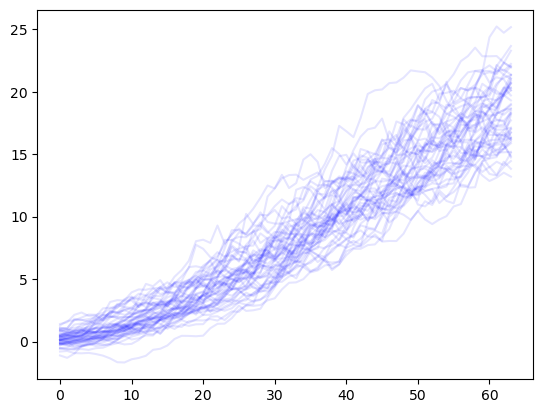

In [101]:
torch.save(generator_bp.state_dict(), 'generator_bp.pt')

# load saved model
generator_bp_loaded = Generator_normalBP(data_size=1, initial_noise_size=5, noise_size=3, hidden_size=16, mlp_size=16, num_layers=1)
generator_bp_loaded.load_state_dict(torch.load('generator_bp.pt'))

# generate 50 samples and plot
ts = torch.linspace(0, 63, 64)
batch_size = 50
with torch.no_grad():
    generated_samples = generator_bp_loaded(ts, batch_size).cpu()
generated_samples = torchcde.LinearInterpolation(generated_samples).evaluate(ts)
generated_samples = generated_samples[..., 1]

plt.plot(ts, generated_samples.T, color='blue', alpha=0.1)

Take a look at how well the model is trained

In [97]:
ts_bp_128 = torch.linspace(0, 128, 128)
_, ds, test_data_loader_bp_128 = get_data(t_size=128, dataset_size= 8192, batch_size=128, device='cuda')
with torch.no_grad():
    real_samples_bp_128, = next(iter(test_data_loader_bp_128))
real_samples_bp_128 = torchcde.LinearInterpolation(real_samples_bp_128).evaluate(ts_bp_128)
real_samples_bp_128 = real_samples_bp_128[..., 1]

In [88]:
ts_bp_128 = torch.linspace(0, 128, 128, device='cuda')
with torch.no_grad():
    generated_samples_bp_128 = generator_bp(ts_bp_128, 128).cpu()
generated_samples_bp_128 = torchcde.LinearInterpolation(generated_samples_bp_128).evaluate(ts_bp_128)
generated_samples_bp_128 = generated_samples_bp_128[..., 1]

# with torch.no_grad():
#     generated_samples_heun_128 = generator_heun(ts_heun_128, 1024).cpu()
# generated_samples_heun_128 = torchcde.LinearInterpolation(generated_samples_heun_128).evaluate(ts_heun_128)
# generated_samples_heun_128 = generated_samples_heun_128[..., 1]
# generated_samples_heun_128

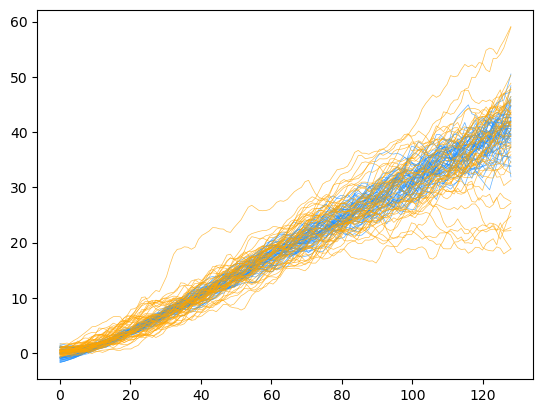

In [94]:
for real_samples_bp_128_ in real_samples_bp_128[:50]:
    plt.plot(ts_bp_128.cpu(), real_samples_bp_128_.cpu(), label='real', color='dodgerblue', linewidth=0.5, alpha=0.7)
for generated_samples_bp_128_ in generated_samples_bp_128[:50]:
    plt.plot(ts_bp_128.cpu(), generated_samples_bp_128_.cpu(), label='generated', color='orange', linewidth=0.5, alpha=0.7)

plt.show() 

plotting

In [ ]:
for real_samples_bp_128_ in real_samples_bp_128[:50]:
    plt.plot(ts_bp_128.cpu(), real_samples_bp_128_.cpu(), color='dodgerblue', linewidth=0.5, alpha=0.7)
for generated_samples_bp_128_ in generated_samples_bp_128[:50]:
    plt.plot(ts_bp_128.cpu(), generated_samples_bp_128_.cpu(), color='crimson', linewidth=0.5, alpha=0.7)

## Reversible adjoint

In [28]:
class Generator_heun(torch.nn.Module):
    def __init__(self, data_size, initial_noise_size, noise_size, hidden_size, mlp_size, num_layers):
        super().__init__()
        self._initial_noise_size = initial_noise_size
        self._hidden_size = hidden_size

        self._initial = MLP(initial_noise_size, hidden_size, mlp_size, num_layers, tanh=False)
        self._func = GeneratorFunc(noise_size, hidden_size, mlp_size, num_layers)
        self._readout = torch.nn.Linear(hidden_size, data_size)

    def forward(self, ts, batch_size):
        # ts has shape (t_size,) and corresponds to the points we want to evaluate the SDE at.

        ###################
        # Actually solve the SDE.
        ###################
        init_noise = torch.randn(batch_size, self._initial_noise_size, device=ts.device)
        x0 = self._initial(init_noise)

        ###################
        # We use the reversible Heun method to get accurate gradients whilst using the adjoint method.
        ###################
        xs = torchsde.sdeint_adjoint(self._func, x0, ts, method='reversible_heun', dt=1.0,
                                     adjoint_method='adjoint_reversible_heun',)
        xs = xs.transpose(0, 1)
        ys = self._readout(xs)

        ###################
        # Normalise the data to the form that the discriminator expects, in particular including time as a channel.
        ###################
        ts = ts.unsqueeze(0).unsqueeze(-1).expand(batch_size, ts.size(0), 1)
        return torchcde.linear_interpolation_coeffs(torch.cat([ts, ys], dim=2))

In [61]:
# importing libraries
import os
import psutil
 
# inner psutil function
def process_memory():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss
 
# decorator function
def profile(func):
    def wrapper(*args, **kwargs):
 
        mem_before = process_memory()
        result = func(*args, **kwargs)
        mem_after = process_memory()
        print("{}:consumed memory: {:,}".format(
            func.__name__,
            mem_before, mem_after, mem_after - mem_before))
 
        return result
    return wrapper
 
# instantiation of decorator function
@profile


def main(
        # Architectural hyperparameters. These are quite small for illustrative purposes.
        t_size=64,             # How many timesteps to use for the SDE solver.
        data_size=8192,        # How many data points to use in the dataset.
        initial_noise_size=5,  # How many noise dimensions to sample at the start of the SDE.
        noise_size=3,          # How many dimensions the Brownian motion has.
        hidden_size=16,        # How big the hidden size of the generator SDE and the discriminator CDE are.
        mlp_size=16,           # How big the layers in the various MLPs are.
        num_layers=1,          # How many hidden layers to have in the various MLPs.

        # Training hyperparameters. Be prepared to tune these very carefully, as with any GAN.
        generator_lr=2e-4,      # Learning rate often needs careful tuning to the problem.
        discriminator_lr=1e-3,  # Learning rate often needs careful tuning to the problem.
        batch_size=1024,        # Batch size.
        steps=10000,            # How many steps to train both generator and discriminator for.
        init_mult1=3,           # Changing the initial parameter size can help.
        init_mult2=0.5,         #
        weight_decay=0.01,      # Weight decay.
        swa_step_start=5000,    # When to start using stochastic weight averaging.

        # Evaluation and plotting hyperparameters
        steps_per_print=10,                   # How often to print the loss.
        num_plot_samples=50,                  # How many samples to use on the plots at the end.
        plot_locs=(0.1, 0.3, 0.5, 0.7, 0.9),  # Plot some marginal distributions at this proportion of the way along.
):
    is_cuda = torch.cuda.is_available()
    device = 'cuda' if is_cuda else 'cpu'
    if not is_cuda:
        print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

    # Data
    ts, data_size, train_dataloader = get_data(t_size=t_size, dataset_size= data_size, batch_size=batch_size, device=device)
    infinite_train_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)

    # Models
    generator = Generator_heun(data_size, initial_noise_size, noise_size, hidden_size, mlp_size, num_layers).to(device)
    discriminator = Discriminator(data_size, hidden_size, mlp_size, num_layers).to(device)
    # Weight averaging really helps with GAN training.
    averaged_generator = swa_utils.AveragedModel(generator)
    averaged_discriminator = swa_utils.AveragedModel(discriminator)

    # Picking a good initialisation is important!
    # In this case these were picked by making the parameters for the t=0 part of the generator be roughly the right
    # size that the untrained t=0 distribution has a similar variance to the t=0 data distribution.
    # Then the func parameters were adjusted so that the t>0 distribution looked like it had about the right variance.
    # What we're doing here is very crude -- one can definitely imagine smarter ways of doing things.
    # (e.g. pretraining the t=0 distribution)
    with torch.no_grad():
        for param in generator._initial.parameters():
            param *= init_mult1
        for param in generator._func.parameters():
            param *= init_mult2

    # Optimisers. Adadelta turns out to be a much better choice than SGD or Adam, interestingly.
    generator_optimiser = torch.optim.Adadelta(generator.parameters(), lr=generator_lr, weight_decay=weight_decay)
    discriminator_optimiser = torch.optim.Adadelta(discriminator.parameters(), lr=discriminator_lr,
                                                   weight_decay=weight_decay)

    # Train both generator and discriminator.

    t0 = time.time()

    trange = tqdm.tqdm(range(steps))
    for step in trange:
        real_samples, = next(infinite_train_dataloader)

        generated_samples = generator(ts, batch_size)
        generated_score = discriminator(generated_samples)
        real_score = discriminator(real_samples)
        loss = generated_score - real_score
        loss.backward()

        for param in generator.parameters():
            param.grad *= -1
        generator_optimiser.step()
        discriminator_optimiser.step()
        generator_optimiser.zero_grad()
        discriminator_optimiser.zero_grad()

        ###################
        # We constrain the Lipschitz constant of the discriminator using carefully-chosen clipping (and the use of
        # LipSwish activation functions).
        ###################
        with torch.no_grad():
            for module in discriminator.modules():
                if isinstance(module, torch.nn.Linear):
                    lim = 1 / module.out_features
                    module.weight.clamp_(-lim, lim)

        # Stochastic weight averaging typically improves performance.
        if step > swa_step_start:
            averaged_generator.update_parameters(generator)
            averaged_discriminator.update_parameters(discriminator)

        if (step % steps_per_print) == 0 or step == steps - 1:
            total_unaveraged_loss = evaluate_loss(ts, batch_size, train_dataloader, generator, discriminator)
            if step > swa_step_start:
                total_averaged_loss = evaluate_loss(ts, batch_size, train_dataloader, averaged_generator.module,
                                                    averaged_discriminator.module)
                trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f} "
                             f"Loss (averaged): {total_averaged_loss:.4f}")
            else:
                trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f}")

    print("Training time:", time.time()-t0)

    generator.load_state_dict(averaged_generator.module.state_dict())
    discriminator.load_state_dict(averaged_discriminator.module.state_dict())

    return ts, generator

ts_heun, generator_heun = main()

  0%|          | 1/10000 [00:02<7:00:06,  2.52s/it]

Step:   0 Loss (unaveraged): 4.3736


  0%|          | 11/10000 [00:11<3:25:10,  1.23s/it]

Step:  10 Loss (unaveraged): 4.3873


  0%|          | 21/10000 [00:19<3:26:01,  1.24s/it]

Step:  20 Loss (unaveraged): 4.3661


  0%|          | 31/10000 [00:29<4:41:27,  1.69s/it]

Step:  30 Loss (unaveraged): 4.3861


  0%|          | 41/10000 [00:43<4:08:07,  1.49s/it]

Step:  40 Loss (unaveraged): 4.3505


  1%|          | 51/10000 [00:51<3:23:22,  1.23s/it]

Step:  50 Loss (unaveraged): 4.3567


  1%|          | 61/10000 [01:00<3:19:01,  1.20s/it]

Step:  60 Loss (unaveraged): 4.3725


  1%|          | 71/10000 [01:08<3:15:41,  1.18s/it]

Step:  70 Loss (unaveraged): 4.3503


  1%|          | 81/10000 [01:17<3:20:54,  1.22s/it]

Step:  80 Loss (unaveraged): 4.3399


  1%|          | 91/10000 [01:25<3:19:37,  1.21s/it]

Step:  90 Loss (unaveraged): 4.3402


  1%|          | 101/10000 [01:35<3:57:41,  1.44s/it]

Step: 100 Loss (unaveraged): 4.3419


  1%|          | 111/10000 [01:44<3:43:02,  1.35s/it]

Step: 110 Loss (unaveraged): 4.3375


  1%|          | 121/10000 [01:52<3:21:42,  1.23s/it]

Step: 120 Loss (unaveraged): 4.3168


  1%|▏         | 131/10000 [02:00<3:15:31,  1.19s/it]

Step: 130 Loss (unaveraged): 4.2968


  1%|▏         | 141/10000 [02:09<3:12:04,  1.17s/it]

Step: 140 Loss (unaveraged): 4.2823


  2%|▏         | 151/10000 [02:17<3:20:44,  1.22s/it]

Step: 150 Loss (unaveraged): 4.3044


  2%|▏         | 161/10000 [02:26<4:03:17,  1.48s/it]

Step: 160 Loss (unaveraged): 4.3091


  2%|▏         | 171/10000 [02:35<3:22:15,  1.23s/it]

Step: 170 Loss (unaveraged): 4.2807


  2%|▏         | 181/10000 [02:43<3:26:36,  1.26s/it]

Step: 180 Loss (unaveraged): 4.2639


  2%|▏         | 191/10000 [02:52<3:21:12,  1.23s/it]

Step: 190 Loss (unaveraged): 4.2641


  2%|▏         | 201/10000 [03:00<3:16:32,  1.20s/it]

Step: 200 Loss (unaveraged): 4.2598


  2%|▏         | 211/10000 [03:09<3:17:16,  1.21s/it]

Step: 210 Loss (unaveraged): 4.2236


  2%|▏         | 221/10000 [03:18<4:13:11,  1.55s/it]

Step: 220 Loss (unaveraged): 4.2221


  2%|▏         | 231/10000 [03:27<3:23:17,  1.25s/it]

Step: 230 Loss (unaveraged): 4.1995


  2%|▏         | 241/10000 [03:36<3:24:19,  1.26s/it]

Step: 240 Loss (unaveraged): 4.2056


  3%|▎         | 251/10000 [03:45<3:29:36,  1.29s/it]

Step: 250 Loss (unaveraged): 4.1671


  3%|▎         | 261/10000 [03:54<3:38:02,  1.34s/it]

Step: 260 Loss (unaveraged): 4.1877


  3%|▎         | 271/10000 [04:02<3:10:07,  1.17s/it]

Step: 270 Loss (unaveraged): 4.1473


  3%|▎         | 281/10000 [04:11<3:22:00,  1.25s/it]

Step: 280 Loss (unaveraged): 4.1448


  3%|▎         | 291/10000 [04:20<3:11:18,  1.18s/it]

Step: 290 Loss (unaveraged): 4.1204


  3%|▎         | 301/10000 [04:29<3:19:51,  1.24s/it]

Step: 300 Loss (unaveraged): 4.1144


  3%|▎         | 311/10000 [04:37<3:11:06,  1.18s/it]

Step: 310 Loss (unaveraged): 4.1166


  3%|▎         | 321/10000 [04:46<3:19:06,  1.23s/it]

Step: 320 Loss (unaveraged): 4.0919


  3%|▎         | 331/10000 [04:54<3:16:29,  1.22s/it]

Step: 330 Loss (unaveraged): 4.0701


  3%|▎         | 341/10000 [05:03<3:14:13,  1.21s/it]

Step: 340 Loss (unaveraged): 4.0500


  4%|▎         | 351/10000 [05:12<3:16:28,  1.22s/it]

Step: 350 Loss (unaveraged): 4.0387


  4%|▎         | 361/10000 [05:21<3:10:39,  1.19s/it]

Step: 360 Loss (unaveraged): 4.0161


  4%|▎         | 371/10000 [05:29<3:23:13,  1.27s/it]

Step: 370 Loss (unaveraged): 4.0055


  4%|▍         | 381/10000 [05:38<3:11:43,  1.20s/it]

Step: 380 Loss (unaveraged): 3.9779


  4%|▍         | 391/10000 [05:47<3:20:55,  1.25s/it]

Step: 390 Loss (unaveraged): 3.9598


  4%|▍         | 401/10000 [05:55<3:16:40,  1.23s/it]

Step: 400 Loss (unaveraged): 3.9584


  4%|▍         | 411/10000 [06:05<3:22:49,  1.27s/it]

Step: 410 Loss (unaveraged): 3.9164


  4%|▍         | 421/10000 [06:13<3:14:51,  1.22s/it]

Step: 420 Loss (unaveraged): 3.8900


  4%|▍         | 431/10000 [06:21<3:08:42,  1.18s/it]

Step: 430 Loss (unaveraged): 3.8646


  4%|▍         | 441/10000 [06:30<3:08:42,  1.18s/it]

Step: 440 Loss (unaveraged): 3.8478


  5%|▍         | 451/10000 [06:38<3:11:04,  1.20s/it]

Step: 450 Loss (unaveraged): 3.8391


  5%|▍         | 461/10000 [06:47<3:11:01,  1.20s/it]

Step: 460 Loss (unaveraged): 3.7892


  5%|▍         | 471/10000 [06:56<3:38:41,  1.38s/it]

Step: 470 Loss (unaveraged): 3.7734


  5%|▍         | 481/10000 [07:05<3:13:00,  1.22s/it]

Step: 480 Loss (unaveraged): 3.7492


  5%|▍         | 491/10000 [07:13<3:12:53,  1.22s/it]

Step: 490 Loss (unaveraged): 3.7288


  5%|▌         | 501/10000 [07:22<3:13:54,  1.22s/it]

Step: 500 Loss (unaveraged): 3.7078


  5%|▌         | 511/10000 [07:30<3:11:34,  1.21s/it]

Step: 510 Loss (unaveraged): 3.6908


  5%|▌         | 521/10000 [07:39<3:16:58,  1.25s/it]

Step: 520 Loss (unaveraged): 3.6507


  5%|▌         | 531/10000 [07:49<4:08:29,  1.57s/it]

Step: 530 Loss (unaveraged): 3.6226


  5%|▌         | 541/10000 [07:57<3:18:25,  1.26s/it]

Step: 540 Loss (unaveraged): 3.5968


  6%|▌         | 551/10000 [08:06<3:07:41,  1.19s/it]

Step: 550 Loss (unaveraged): 3.5680


  6%|▌         | 561/10000 [08:14<3:12:21,  1.22s/it]

Step: 560 Loss (unaveraged): 3.5380


  6%|▌         | 571/10000 [08:23<3:08:34,  1.20s/it]

Step: 570 Loss (unaveraged): 3.5054


  6%|▌         | 581/10000 [08:31<3:13:51,  1.23s/it]

Step: 580 Loss (unaveraged): 3.4490


  6%|▌         | 591/10000 [08:41<4:11:17,  1.60s/it]

Step: 590 Loss (unaveraged): 3.4293


  6%|▌         | 601/10000 [08:50<3:09:32,  1.21s/it]

Step: 600 Loss (unaveraged): 3.3929


  6%|▌         | 611/10000 [08:58<3:14:23,  1.24s/it]

Step: 610 Loss (unaveraged): 3.3700


  6%|▌         | 621/10000 [09:06<3:09:04,  1.21s/it]

Step: 620 Loss (unaveraged): 3.3341


  6%|▋         | 631/10000 [09:15<3:09:27,  1.21s/it]

Step: 630 Loss (unaveraged): 3.2962


  6%|▋         | 641/10000 [09:23<3:08:14,  1.21s/it]

Step: 640 Loss (unaveraged): 3.2540


  7%|▋         | 651/10000 [09:32<3:10:34,  1.22s/it]

Step: 650 Loss (unaveraged): 3.2169


  7%|▋         | 661/10000 [09:42<3:29:10,  1.34s/it]

Step: 660 Loss (unaveraged): 3.1853


  7%|▋         | 671/10000 [09:50<3:07:04,  1.20s/it]

Step: 670 Loss (unaveraged): 3.1350


  7%|▋         | 681/10000 [09:58<3:05:17,  1.19s/it]

Step: 680 Loss (unaveraged): 3.1051


  7%|▋         | 691/10000 [10:07<3:11:47,  1.24s/it]

Step: 690 Loss (unaveraged): 3.0585


  7%|▋         | 701/10000 [10:16<3:15:39,  1.26s/it]

Step: 700 Loss (unaveraged): 3.0168


  7%|▋         | 711/10000 [10:24<3:11:23,  1.24s/it]

Step: 710 Loss (unaveraged): 2.9793


  7%|▋         | 721/10000 [10:39<4:51:41,  1.89s/it]

Step: 720 Loss (unaveraged): 2.9218


  7%|▋         | 731/10000 [10:48<3:16:55,  1.27s/it]

Step: 730 Loss (unaveraged): 2.8849


  7%|▋         | 741/10000 [10:56<3:06:08,  1.21s/it]

Step: 740 Loss (unaveraged): 2.8362


  8%|▊         | 751/10000 [11:05<3:08:03,  1.22s/it]

Step: 750 Loss (unaveraged): 2.7719


  8%|▊         | 761/10000 [11:14<3:15:41,  1.27s/it]

Step: 760 Loss (unaveraged): 2.7165


  8%|▊         | 771/10000 [11:22<3:11:03,  1.24s/it]

Step: 770 Loss (unaveraged): 2.6604


  8%|▊         | 781/10000 [11:32<3:56:04,  1.54s/it]

Step: 780 Loss (unaveraged): 2.6103


  8%|▊         | 791/10000 [11:41<3:18:20,  1.29s/it]

Step: 790 Loss (unaveraged): 2.5499


  8%|▊         | 801/10000 [11:50<3:27:37,  1.35s/it]

Step: 800 Loss (unaveraged): 2.4819


  8%|▊         | 811/10000 [11:58<3:03:19,  1.20s/it]

Step: 810 Loss (unaveraged): 2.4303


  8%|▊         | 821/10000 [12:06<3:05:45,  1.21s/it]

Step: 820 Loss (unaveraged): 2.3630


  8%|▊         | 831/10000 [12:15<3:01:20,  1.19s/it]

Step: 830 Loss (unaveraged): 2.2901


  8%|▊         | 841/10000 [12:24<3:57:44,  1.56s/it]

Step: 840 Loss (unaveraged): 2.2110


  9%|▊         | 851/10000 [12:33<3:05:10,  1.21s/it]

Step: 850 Loss (unaveraged): 2.1478


  9%|▊         | 861/10000 [12:41<3:11:57,  1.26s/it]

Step: 860 Loss (unaveraged): 2.0592


  9%|▊         | 871/10000 [12:50<3:00:34,  1.19s/it]

Step: 870 Loss (unaveraged): 1.9761


  9%|▉         | 881/10000 [12:58<3:07:36,  1.23s/it]

Step: 880 Loss (unaveraged): 1.8798


  9%|▉         | 891/10000 [13:07<3:01:20,  1.19s/it]

Step: 890 Loss (unaveraged): 1.7895


  9%|▉         | 901/10000 [13:15<3:09:01,  1.25s/it]

Step: 900 Loss (unaveraged): 1.6839


  9%|▉         | 911/10000 [13:25<3:00:48,  1.19s/it]

Step: 910 Loss (unaveraged): 1.5749


  9%|▉         | 921/10000 [13:33<3:05:59,  1.23s/it]

Step: 920 Loss (unaveraged): 1.4718


  9%|▉         | 931/10000 [13:42<3:10:47,  1.26s/it]

Step: 930 Loss (unaveraged): 1.3444


  9%|▉         | 941/10000 [13:51<3:05:20,  1.23s/it]

Step: 940 Loss (unaveraged): 1.2272


 10%|▉         | 951/10000 [13:59<3:00:19,  1.20s/it]

Step: 950 Loss (unaveraged): 1.1000


 10%|▉         | 961/10000 [14:08<3:04:59,  1.23s/it]

Step: 960 Loss (unaveraged): 0.9730


 10%|▉         | 971/10000 [14:17<3:12:57,  1.28s/it]

Step: 970 Loss (unaveraged): 0.8431


 10%|▉         | 981/10000 [14:26<3:01:17,  1.21s/it]

Step: 980 Loss (unaveraged): 0.7112


 10%|▉         | 991/10000 [14:34<3:03:08,  1.22s/it]

Step: 990 Loss (unaveraged): 0.5720


 10%|█         | 1001/10000 [14:43<3:08:25,  1.26s/it]

Step: 1000 Loss (unaveraged): 0.4295


 10%|█         | 1011/10000 [14:51<3:05:32,  1.24s/it]

Step: 1010 Loss (unaveraged): 0.2799


 10%|█         | 1021/10000 [15:00<3:04:33,  1.23s/it]

Step: 1020 Loss (unaveraged): 0.1235


 10%|█         | 1031/10000 [15:10<3:16:58,  1.32s/it]

Step: 1030 Loss (unaveraged): -0.0366


 10%|█         | 1041/10000 [15:18<2:59:25,  1.20s/it]

Step: 1040 Loss (unaveraged): -0.1817


 11%|█         | 1051/10000 [15:26<2:55:33,  1.18s/it]

Step: 1050 Loss (unaveraged): -0.3232


 11%|█         | 1061/10000 [15:35<3:03:44,  1.23s/it]

Step: 1060 Loss (unaveraged): -0.4705


 11%|█         | 1071/10000 [15:43<3:01:17,  1.22s/it]

Step: 1070 Loss (unaveraged): -0.6200


 11%|█         | 1081/10000 [15:52<2:54:25,  1.17s/it]

Step: 1080 Loss (unaveraged): -0.7690


 11%|█         | 1091/10000 [16:01<3:49:39,  1.55s/it]

Step: 1090 Loss (unaveraged): -0.9243


 11%|█         | 1101/10000 [16:10<3:03:57,  1.24s/it]

Step: 1100 Loss (unaveraged): -1.0771


 11%|█         | 1111/10000 [16:18<2:58:31,  1.21s/it]

Step: 1110 Loss (unaveraged): -1.2356


 11%|█         | 1121/10000 [16:27<3:00:13,  1.22s/it]

Step: 1120 Loss (unaveraged): -1.3988


 11%|█▏        | 1131/10000 [16:35<2:56:26,  1.19s/it]

Step: 1130 Loss (unaveraged): -1.5473


 11%|█▏        | 1141/10000 [16:44<3:03:24,  1.24s/it]

Step: 1140 Loss (unaveraged): -1.7060


 12%|█▏        | 1151/10000 [16:53<3:51:36,  1.57s/it]

Step: 1150 Loss (unaveraged): -1.8838


 12%|█▏        | 1161/10000 [17:02<2:56:49,  1.20s/it]

Step: 1160 Loss (unaveraged): -2.0446


 12%|█▏        | 1171/10000 [17:10<2:56:28,  1.20s/it]

Step: 1170 Loss (unaveraged): -2.2125


 12%|█▏        | 1181/10000 [17:19<2:56:57,  1.20s/it]

Step: 1180 Loss (unaveraged): -2.3772


 12%|█▏        | 1191/10000 [17:27<2:57:15,  1.21s/it]

Step: 1190 Loss (unaveraged): -2.5443


 12%|█▏        | 1201/10000 [17:36<2:55:23,  1.20s/it]

Step: 1200 Loss (unaveraged): -2.6850


 12%|█▏        | 1211/10000 [17:44<2:59:11,  1.22s/it]

Step: 1210 Loss (unaveraged): -2.8403


 12%|█▏        | 1221/10000 [17:54<3:02:40,  1.25s/it]

Step: 1220 Loss (unaveraged): -2.9859


 12%|█▏        | 1231/10000 [18:02<3:02:03,  1.25s/it]

Step: 1230 Loss (unaveraged): -3.1088


 12%|█▏        | 1241/10000 [18:11<2:52:07,  1.18s/it]

Step: 1240 Loss (unaveraged): -3.2299


 13%|█▎        | 1251/10000 [18:19<3:02:30,  1.25s/it]

Step: 1250 Loss (unaveraged): -3.3711


 13%|█▎        | 1261/10000 [18:28<2:56:36,  1.21s/it]

Step: 1260 Loss (unaveraged): -3.4693


 13%|█▎        | 1271/10000 [18:36<2:52:37,  1.19s/it]

Step: 1270 Loss (unaveraged): -3.5700


 13%|█▎        | 1281/10000 [18:46<3:04:52,  1.27s/it]

Step: 1280 Loss (unaveraged): -3.6738


 13%|█▎        | 1291/10000 [18:54<2:56:37,  1.22s/it]

Step: 1290 Loss (unaveraged): -3.7420


 13%|█▎        | 1301/10000 [19:03<2:53:34,  1.20s/it]

Step: 1300 Loss (unaveraged): -3.8099


 13%|█▎        | 1311/10000 [19:11<2:53:58,  1.20s/it]

Step: 1310 Loss (unaveraged): -3.8509


 13%|█▎        | 1321/10000 [19:20<2:56:13,  1.22s/it]

Step: 1320 Loss (unaveraged): -3.8380


 13%|█▎        | 1331/10000 [19:28<2:51:56,  1.19s/it]

Step: 1330 Loss (unaveraged): -3.7978


 13%|█▎        | 1341/10000 [19:38<3:46:41,  1.57s/it]

Step: 1340 Loss (unaveraged): -3.7588


 14%|█▎        | 1351/10000 [19:46<2:57:40,  1.23s/it]

Step: 1350 Loss (unaveraged): -3.6033


 14%|█▎        | 1361/10000 [19:55<2:58:50,  1.24s/it]

Step: 1360 Loss (unaveraged): -3.4832


 14%|█▎        | 1371/10000 [20:03<2:52:44,  1.20s/it]

Step: 1370 Loss (unaveraged): -3.2336


 14%|█▍        | 1381/10000 [20:12<2:59:32,  1.25s/it]

Step: 1380 Loss (unaveraged): -2.9498


 14%|█▍        | 1391/10000 [20:20<2:56:05,  1.23s/it]

Step: 1390 Loss (unaveraged): -2.5651


 14%|█▍        | 1401/10000 [20:34<5:45:53,  2.41s/it]

Step: 1400 Loss (unaveraged): -2.1172


 14%|█▍        | 1411/10000 [20:44<3:19:02,  1.39s/it]

Step: 1410 Loss (unaveraged): -1.5773


 14%|█▍        | 1421/10000 [20:52<2:48:40,  1.18s/it]

Step: 1420 Loss (unaveraged): -0.9058


 14%|█▍        | 1431/10000 [21:01<2:58:12,  1.25s/it]

Step: 1430 Loss (unaveraged): -0.1372


 14%|█▍        | 1441/10000 [21:09<2:54:49,  1.23s/it]

Step: 1440 Loss (unaveraged): 0.6682


 15%|█▍        | 1451/10000 [21:18<2:50:32,  1.20s/it]

Step: 1450 Loss (unaveraged): 1.3150


 15%|█▍        | 1461/10000 [21:26<2:52:54,  1.21s/it]

Step: 1460 Loss (unaveraged): 1.6783


 15%|█▍        | 1471/10000 [21:36<2:51:15,  1.20s/it]

Step: 1470 Loss (unaveraged): 1.7682


 15%|█▍        | 1481/10000 [21:45<2:59:03,  1.26s/it]

Step: 1480 Loss (unaveraged): 1.5840


 15%|█▍        | 1491/10000 [21:53<2:50:07,  1.20s/it]

Step: 1490 Loss (unaveraged): 1.1895


 15%|█▌        | 1501/10000 [22:02<2:57:17,  1.25s/it]

Step: 1500 Loss (unaveraged): 0.6382


 15%|█▌        | 1511/10000 [22:11<2:53:04,  1.22s/it]

Step: 1510 Loss (unaveraged): 0.0451


 15%|█▌        | 1521/10000 [22:19<2:51:25,  1.21s/it]

Step: 1520 Loss (unaveraged): -0.5573


 15%|█▌        | 1531/10000 [22:29<2:52:49,  1.22s/it]

Step: 1530 Loss (unaveraged): -1.0560


 15%|█▌        | 1541/10000 [22:37<2:46:02,  1.18s/it]

Step: 1540 Loss (unaveraged): -1.4325


 16%|█▌        | 1551/10000 [22:45<2:50:16,  1.21s/it]

Step: 1550 Loss (unaveraged): -1.6848


 16%|█▌        | 1561/10000 [22:54<2:46:21,  1.18s/it]

Step: 1560 Loss (unaveraged): -1.8036


 16%|█▌        | 1571/10000 [23:02<2:47:39,  1.19s/it]

Step: 1570 Loss (unaveraged): -1.7205


 16%|█▌        | 1581/10000 [23:11<2:48:46,  1.20s/it]

Step: 1580 Loss (unaveraged): -1.5364


 16%|█▌        | 1591/10000 [23:20<2:58:49,  1.28s/it]

Step: 1590 Loss (unaveraged): -1.1461


 16%|█▌        | 1601/10000 [23:29<2:43:41,  1.17s/it]

Step: 1600 Loss (unaveraged): -0.6290


 16%|█▌        | 1611/10000 [23:37<2:43:57,  1.17s/it]

Step: 1610 Loss (unaveraged): -0.1285


 16%|█▌        | 1621/10000 [23:46<2:54:28,  1.25s/it]

Step: 1620 Loss (unaveraged): 0.2164


 16%|█▋        | 1631/10000 [23:55<3:09:56,  1.36s/it]

Step: 1630 Loss (unaveraged): 0.5240


 16%|█▋        | 1641/10000 [24:04<2:48:43,  1.21s/it]

Step: 1640 Loss (unaveraged): 0.6082


 17%|█▋        | 1651/10000 [24:14<3:01:45,  1.31s/it]

Step: 1650 Loss (unaveraged): 0.5965


 17%|█▋        | 1661/10000 [24:22<2:32:17,  1.10s/it]

Step: 1660 Loss (unaveraged): 0.4581


 17%|█▋        | 1671/10000 [24:30<2:42:32,  1.17s/it]

Step: 1670 Loss (unaveraged): 0.2706


 17%|█▋        | 1681/10000 [24:38<2:41:41,  1.17s/it]

Step: 1680 Loss (unaveraged): 0.0631


 17%|█▋        | 1691/10000 [24:47<2:40:34,  1.16s/it]

Step: 1690 Loss (unaveraged): -0.1350


 17%|█▋        | 1701/10000 [24:55<2:38:48,  1.15s/it]

Step: 1700 Loss (unaveraged): -0.3209


 17%|█▋        | 1711/10000 [25:04<3:18:23,  1.44s/it]

Step: 1710 Loss (unaveraged): -0.4725


 17%|█▋        | 1721/10000 [25:14<4:03:47,  1.77s/it]

Step: 1720 Loss (unaveraged): -0.6015


 17%|█▋        | 1731/10000 [25:26<3:06:18,  1.35s/it]

Step: 1730 Loss (unaveraged): -0.7005


 17%|█▋        | 1741/10000 [25:35<2:53:35,  1.26s/it]

Step: 1740 Loss (unaveraged): -0.7496


 18%|█▊        | 1751/10000 [25:43<2:39:28,  1.16s/it]

Step: 1750 Loss (unaveraged): -0.7322


 18%|█▊        | 1761/10000 [25:51<2:31:49,  1.11s/it]

Step: 1760 Loss (unaveraged): -0.7332


 18%|█▊        | 1771/10000 [26:00<3:23:52,  1.49s/it]

Step: 1770 Loss (unaveraged): -0.7027


 18%|█▊        | 1781/10000 [26:08<2:26:26,  1.07s/it]

Step: 1780 Loss (unaveraged): -0.5966


 18%|█▊        | 1791/10000 [26:16<2:35:45,  1.14s/it]

Step: 1790 Loss (unaveraged): -0.4981


 18%|█▊        | 1801/10000 [26:24<2:39:34,  1.17s/it]

Step: 1800 Loss (unaveraged): -0.3524


 18%|█▊        | 1811/10000 [26:32<2:33:28,  1.12s/it]

Step: 1810 Loss (unaveraged): -0.2343


 18%|█▊        | 1821/10000 [26:46<4:48:34,  2.12s/it]

Step: 1820 Loss (unaveraged): -0.1033


 18%|█▊        | 1831/10000 [26:55<3:18:19,  1.46s/it]

Step: 1830 Loss (unaveraged): 0.0284


 18%|█▊        | 1841/10000 [27:04<2:39:06,  1.17s/it]

Step: 1840 Loss (unaveraged): 0.1192


 19%|█▊        | 1851/10000 [27:12<2:26:42,  1.08s/it]

Step: 1850 Loss (unaveraged): 0.1589


 19%|█▊        | 1861/10000 [27:20<2:21:47,  1.05s/it]

Step: 1860 Loss (unaveraged): 0.1677


 19%|█▊        | 1871/10000 [27:29<3:00:27,  1.33s/it]

Step: 1870 Loss (unaveraged): 0.1266


 19%|█▉        | 1881/10000 [27:37<2:41:01,  1.19s/it]

Step: 1880 Loss (unaveraged): 0.0534


 19%|█▉        | 1891/10000 [27:46<2:35:13,  1.15s/it]

Step: 1890 Loss (unaveraged): -0.0585


 19%|█▉        | 1901/10000 [27:56<3:44:10,  1.66s/it]

Step: 1900 Loss (unaveraged): -0.1955


 19%|█▉        | 1911/10000 [28:05<2:54:42,  1.30s/it]

Step: 1910 Loss (unaveraged): -0.3571


 19%|█▉        | 1921/10000 [28:13<2:30:51,  1.12s/it]

Step: 1920 Loss (unaveraged): -0.5028


 19%|█▉        | 1931/10000 [28:21<2:26:58,  1.09s/it]

Step: 1930 Loss (unaveraged): -0.6292


 19%|█▉        | 1941/10000 [28:29<2:32:41,  1.14s/it]

Step: 1940 Loss (unaveraged): -0.7136


 20%|█▉        | 1951/10000 [28:37<2:29:21,  1.11s/it]

Step: 1950 Loss (unaveraged): -0.7329


 20%|█▉        | 1961/10000 [28:47<3:45:15,  1.68s/it]

Step: 1960 Loss (unaveraged): -0.6952


 20%|█▉        | 1971/10000 [28:55<2:54:13,  1.30s/it]

Step: 1970 Loss (unaveraged): -0.6126


 20%|█▉        | 1981/10000 [29:05<3:03:19,  1.37s/it]

Step: 1980 Loss (unaveraged): -0.4753


 20%|█▉        | 1991/10000 [29:20<5:02:20,  2.27s/it]

Step: 1990 Loss (unaveraged): -0.3193


 20%|██        | 2001/10000 [29:33<3:11:28,  1.44s/it]

Step: 2000 Loss (unaveraged): -0.2361


 20%|██        | 2011/10000 [29:42<2:57:55,  1.34s/it]

Step: 2010 Loss (unaveraged): -0.1264


 20%|██        | 2021/10000 [29:52<3:26:58,  1.56s/it]

Step: 2020 Loss (unaveraged): -0.0590


 20%|██        | 2031/10000 [30:00<2:36:14,  1.18s/it]

Step: 2030 Loss (unaveraged): -0.0414


 20%|██        | 2041/10000 [30:08<2:23:52,  1.08s/it]

Step: 2040 Loss (unaveraged): -0.0479


 21%|██        | 2051/10000 [30:15<2:24:08,  1.09s/it]

Step: 2050 Loss (unaveraged): -0.0876


 21%|██        | 2061/10000 [30:23<2:23:58,  1.09s/it]

Step: 2060 Loss (unaveraged): -0.1500


 21%|██        | 2071/10000 [30:35<4:01:42,  1.83s/it]

Step: 2070 Loss (unaveraged): -0.2143


 21%|██        | 2081/10000 [30:44<2:45:18,  1.25s/it]

Step: 2080 Loss (unaveraged): -0.2828


 21%|██        | 2091/10000 [30:54<2:59:09,  1.36s/it]

Step: 2090 Loss (unaveraged): -0.3551


 21%|██        | 2101/10000 [31:02<2:33:35,  1.17s/it]

Step: 2100 Loss (unaveraged): -0.4105


 21%|██        | 2111/10000 [31:10<2:33:08,  1.16s/it]

Step: 2110 Loss (unaveraged): -0.4508


 21%|██        | 2121/10000 [31:18<2:26:35,  1.12s/it]

Step: 2120 Loss (unaveraged): -0.4799


 21%|██▏       | 2131/10000 [31:26<2:30:15,  1.15s/it]

Step: 2130 Loss (unaveraged): -0.5026


 21%|██▏       | 2141/10000 [31:34<2:28:49,  1.14s/it]

Step: 2140 Loss (unaveraged): -0.4981


 22%|██▏       | 2151/10000 [31:43<2:31:51,  1.16s/it]

Step: 2150 Loss (unaveraged): -0.4809


 22%|██▏       | 2161/10000 [31:51<2:23:31,  1.10s/it]

Step: 2160 Loss (unaveraged): -0.4504


 22%|██▏       | 2171/10000 [31:59<2:30:35,  1.15s/it]

Step: 2170 Loss (unaveraged): -0.4343


 22%|██▏       | 2181/10000 [32:07<2:33:57,  1.18s/it]

Step: 2180 Loss (unaveraged): -0.3937


 22%|██▏       | 2191/10000 [32:15<2:33:06,  1.18s/it]

Step: 2190 Loss (unaveraged): -0.3482


 22%|██▏       | 2201/10000 [32:23<2:24:59,  1.12s/it]

Step: 2200 Loss (unaveraged): -0.3215


 22%|██▏       | 2211/10000 [32:33<2:42:56,  1.26s/it]

Step: 2210 Loss (unaveraged): -0.2930


 22%|██▏       | 2221/10000 [32:40<2:28:16,  1.14s/it]

Step: 2220 Loss (unaveraged): -0.2705


 22%|██▏       | 2231/10000 [32:49<2:24:34,  1.12s/it]

Step: 2230 Loss (unaveraged): -0.2432


 22%|██▏       | 2241/10000 [32:56<2:28:32,  1.15s/it]

Step: 2240 Loss (unaveraged): -0.2475


 23%|██▎       | 2251/10000 [33:04<2:27:35,  1.14s/it]

Step: 2250 Loss (unaveraged): -0.2468


 23%|██▎       | 2261/10000 [33:12<2:20:57,  1.09s/it]

Step: 2260 Loss (unaveraged): -0.2736


 23%|██▎       | 2271/10000 [33:21<2:49:45,  1.32s/it]

Step: 2270 Loss (unaveraged): -0.3110


 23%|██▎       | 2281/10000 [33:29<2:20:21,  1.09s/it]

Step: 2280 Loss (unaveraged): -0.3466


 23%|██▎       | 2291/10000 [33:37<2:28:53,  1.16s/it]

Step: 2290 Loss (unaveraged): -0.3882


 23%|██▎       | 2301/10000 [33:45<2:23:24,  1.12s/it]

Step: 2300 Loss (unaveraged): -0.4237


 23%|██▎       | 2311/10000 [33:53<2:19:47,  1.09s/it]

Step: 2310 Loss (unaveraged): -0.4503


 23%|██▎       | 2321/10000 [34:00<2:18:59,  1.09s/it]

Step: 2320 Loss (unaveraged): -0.4686


 23%|██▎       | 2331/10000 [34:09<3:06:06,  1.46s/it]

Step: 2330 Loss (unaveraged): -0.4577


 23%|██▎       | 2341/10000 [34:17<2:27:47,  1.16s/it]

Step: 2340 Loss (unaveraged): -0.4666


 24%|██▎       | 2351/10000 [34:25<2:21:18,  1.11s/it]

Step: 2350 Loss (unaveraged): -0.4530


 24%|██▎       | 2361/10000 [34:33<2:22:59,  1.12s/it]

Step: 2360 Loss (unaveraged): -0.4282


 24%|██▎       | 2371/10000 [34:41<2:25:26,  1.14s/it]

Step: 2370 Loss (unaveraged): -0.4120


 24%|██▍       | 2381/10000 [34:49<2:22:19,  1.12s/it]

Step: 2380 Loss (unaveraged): -0.3911


 24%|██▍       | 2391/10000 [34:57<2:22:49,  1.13s/it]

Step: 2390 Loss (unaveraged): -0.3716


 24%|██▍       | 2401/10000 [35:06<2:26:39,  1.16s/it]

Step: 2400 Loss (unaveraged): -0.3620


 24%|██▍       | 2411/10000 [35:14<2:30:07,  1.19s/it]

Step: 2410 Loss (unaveraged): -0.3541


 24%|██▍       | 2421/10000 [35:23<2:41:06,  1.28s/it]

Step: 2420 Loss (unaveraged): -0.3517


 24%|██▍       | 2431/10000 [35:31<2:29:11,  1.18s/it]

Step: 2430 Loss (unaveraged): -0.3644


 24%|██▍       | 2441/10000 [35:39<2:35:28,  1.23s/it]

Step: 2440 Loss (unaveraged): -0.3671


 25%|██▍       | 2451/10000 [35:47<2:21:25,  1.12s/it]

Step: 2450 Loss (unaveraged): -0.3894


 25%|██▍       | 2461/10000 [35:56<2:35:49,  1.24s/it]

Step: 2460 Loss (unaveraged): -0.4041


 25%|██▍       | 2471/10000 [36:05<2:21:30,  1.13s/it]

Step: 2470 Loss (unaveraged): -0.4176


 25%|██▍       | 2481/10000 [36:13<2:23:07,  1.14s/it]

Step: 2480 Loss (unaveraged): -0.4292


 25%|██▍       | 2491/10000 [36:21<2:23:31,  1.15s/it]

Step: 2490 Loss (unaveraged): -0.4402


 25%|██▌       | 2501/10000 [36:29<2:28:11,  1.19s/it]

Step: 2500 Loss (unaveraged): -0.4458


 25%|██▌       | 2511/10000 [36:37<2:19:45,  1.12s/it]

Step: 2510 Loss (unaveraged): -0.4489


 25%|██▌       | 2521/10000 [36:47<3:05:58,  1.49s/it]

Step: 2520 Loss (unaveraged): -0.4508


 25%|██▌       | 2531/10000 [36:54<2:21:09,  1.13s/it]

Step: 2530 Loss (unaveraged): -0.4357


 25%|██▌       | 2541/10000 [37:02<2:23:25,  1.15s/it]

Step: 2540 Loss (unaveraged): -0.4347


 26%|██▌       | 2551/10000 [37:11<2:27:10,  1.19s/it]

Step: 2550 Loss (unaveraged): -0.4292


 26%|██▌       | 2561/10000 [37:19<2:19:47,  1.13s/it]

Step: 2560 Loss (unaveraged): -0.4240


 26%|██▌       | 2571/10000 [37:26<2:14:52,  1.09s/it]

Step: 2570 Loss (unaveraged): -0.4151


 26%|██▌       | 2581/10000 [37:35<2:55:28,  1.42s/it]

Step: 2580 Loss (unaveraged): -0.4073


 26%|██▌       | 2591/10000 [37:43<2:14:17,  1.09s/it]

Step: 2590 Loss (unaveraged): -0.4050


 26%|██▌       | 2601/10000 [37:50<2:10:42,  1.06s/it]

Step: 2600 Loss (unaveraged): -0.4115


 26%|██▌       | 2611/10000 [37:58<2:18:06,  1.12s/it]

Step: 2610 Loss (unaveraged): -0.4109


 26%|██▌       | 2621/10000 [38:06<2:26:45,  1.19s/it]

Step: 2620 Loss (unaveraged): -0.4125


 26%|██▋       | 2631/10000 [38:14<2:14:59,  1.10s/it]

Step: 2630 Loss (unaveraged): -0.4223


 26%|██▋       | 2641/10000 [38:21<2:12:51,  1.08s/it]

Step: 2640 Loss (unaveraged): -0.4284


 27%|██▋       | 2651/10000 [38:30<2:16:08,  1.11s/it]

Step: 2650 Loss (unaveraged): -0.4286


 27%|██▋       | 2661/10000 [38:38<2:11:34,  1.08s/it]

Step: 2660 Loss (unaveraged): -0.4349


 27%|██▋       | 2671/10000 [38:46<2:16:13,  1.12s/it]

Step: 2670 Loss (unaveraged): -0.4361


 27%|██▋       | 2681/10000 [38:53<2:12:37,  1.09s/it]

Step: 2680 Loss (unaveraged): -0.4338


 27%|██▋       | 2691/10000 [39:01<2:19:05,  1.14s/it]

Step: 2690 Loss (unaveraged): -0.4338


 27%|██▋       | 2701/10000 [39:09<2:13:32,  1.10s/it]

Step: 2700 Loss (unaveraged): -0.4283


 27%|██▋       | 2711/10000 [39:17<2:08:50,  1.06s/it]

Step: 2710 Loss (unaveraged): -0.4223


 27%|██▋       | 2721/10000 [39:25<2:20:35,  1.16s/it]

Step: 2720 Loss (unaveraged): -0.4267


 27%|██▋       | 2731/10000 [39:33<2:21:44,  1.17s/it]

Step: 2730 Loss (unaveraged): -0.4308


 27%|██▋       | 2741/10000 [39:42<2:31:55,  1.26s/it]

Step: 2740 Loss (unaveraged): -0.4244


 28%|██▊       | 2751/10000 [39:49<2:07:56,  1.06s/it]

Step: 2750 Loss (unaveraged): -0.4270


 28%|██▊       | 2761/10000 [39:57<2:06:16,  1.05s/it]

Step: 2760 Loss (unaveraged): -0.4258


 28%|██▊       | 2771/10000 [40:05<2:21:44,  1.18s/it]

Step: 2770 Loss (unaveraged): -0.4239


 28%|██▊       | 2781/10000 [40:13<2:10:12,  1.08s/it]

Step: 2780 Loss (unaveraged): -0.4363


 28%|██▊       | 2791/10000 [40:21<2:06:58,  1.06s/it]

Step: 2790 Loss (unaveraged): -0.4301


 28%|██▊       | 2801/10000 [40:32<3:47:33,  1.90s/it]

Step: 2800 Loss (unaveraged): -0.4345


 28%|██▊       | 2811/10000 [40:42<2:38:10,  1.32s/it]

Step: 2810 Loss (unaveraged): -0.4355


 28%|██▊       | 2821/10000 [40:50<2:17:37,  1.15s/it]

Step: 2820 Loss (unaveraged): -0.4419


 28%|██▊       | 2831/10000 [40:59<2:37:07,  1.32s/it]

Step: 2830 Loss (unaveraged): -0.4465


 28%|██▊       | 2841/10000 [41:07<2:16:10,  1.14s/it]

Step: 2840 Loss (unaveraged): -0.4403


 29%|██▊       | 2851/10000 [41:15<2:16:46,  1.15s/it]

Step: 2850 Loss (unaveraged): -0.4455


 29%|██▊       | 2861/10000 [41:24<2:24:02,  1.21s/it]

Step: 2860 Loss (unaveraged): -0.4483


 29%|██▊       | 2871/10000 [41:32<2:24:45,  1.22s/it]

Step: 2870 Loss (unaveraged): -0.4583


 29%|██▉       | 2881/10000 [41:41<2:30:57,  1.27s/it]

Step: 2880 Loss (unaveraged): -0.4584


 29%|██▉       | 2891/10000 [41:51<3:03:34,  1.55s/it]

Step: 2890 Loss (unaveraged): -0.4632


 29%|██▉       | 2901/10000 [41:59<2:16:36,  1.15s/it]

Step: 2900 Loss (unaveraged): -0.4668


 29%|██▉       | 2911/10000 [42:07<2:18:50,  1.18s/it]

Step: 2910 Loss (unaveraged): -0.4767


 29%|██▉       | 2921/10000 [42:15<2:19:19,  1.18s/it]

Step: 2920 Loss (unaveraged): -0.4826


 29%|██▉       | 2931/10000 [42:24<2:20:32,  1.19s/it]

Step: 2930 Loss (unaveraged): -0.4794


 29%|██▉       | 2941/10000 [42:32<2:09:44,  1.10s/it]

Step: 2940 Loss (unaveraged): -0.4871


 30%|██▉       | 2951/10000 [42:40<2:44:23,  1.40s/it]

Step: 2950 Loss (unaveraged): -0.4970


 30%|██▉       | 2961/10000 [42:48<2:16:46,  1.17s/it]

Step: 2960 Loss (unaveraged): -0.5035


 30%|██▉       | 2971/10000 [42:56<2:11:33,  1.12s/it]

Step: 2970 Loss (unaveraged): -0.5076


 30%|██▉       | 2981/10000 [43:04<2:11:19,  1.12s/it]

Step: 2980 Loss (unaveraged): -0.5137


 30%|██▉       | 2991/10000 [43:12<2:10:51,  1.12s/it]

Step: 2990 Loss (unaveraged): -0.5244


 30%|███       | 3001/10000 [43:20<2:09:59,  1.11s/it]

Step: 3000 Loss (unaveraged): -0.5372


 30%|███       | 3011/10000 [43:28<2:15:05,  1.16s/it]

Step: 3010 Loss (unaveraged): -0.5406


 30%|███       | 3021/10000 [43:37<2:21:08,  1.21s/it]

Step: 3020 Loss (unaveraged): -0.5524


 30%|███       | 3031/10000 [43:45<2:10:46,  1.13s/it]

Step: 3030 Loss (unaveraged): -0.5613


 30%|███       | 3041/10000 [43:53<2:09:34,  1.12s/it]

Step: 3040 Loss (unaveraged): -0.5665


 31%|███       | 3051/10000 [44:01<2:06:29,  1.09s/it]

Step: 3050 Loss (unaveraged): -0.5769


 31%|███       | 3061/10000 [44:08<2:05:38,  1.09s/it]

Step: 3060 Loss (unaveraged): -0.5904


 31%|███       | 3071/10000 [44:16<2:11:41,  1.14s/it]

Step: 3070 Loss (unaveraged): -0.6033


 31%|███       | 3081/10000 [44:25<2:19:49,  1.21s/it]

Step: 3080 Loss (unaveraged): -0.6087


 31%|███       | 3091/10000 [44:32<1:59:39,  1.04s/it]

Step: 3090 Loss (unaveraged): -0.6237


 31%|███       | 3101/10000 [44:40<2:01:53,  1.06s/it]

Step: 3100 Loss (unaveraged): -0.6319


 31%|███       | 3111/10000 [44:47<1:57:08,  1.02s/it]

Step: 3110 Loss (unaveraged): -0.6435


 31%|███       | 3121/10000 [44:54<1:57:47,  1.03s/it]

Step: 3120 Loss (unaveraged): -0.6572


 31%|███▏      | 3131/10000 [45:01<1:58:16,  1.03s/it]

Step: 3130 Loss (unaveraged): -0.6668


 31%|███▏      | 3141/10000 [45:09<2:32:41,  1.34s/it]

Step: 3140 Loss (unaveraged): -0.6798


 32%|███▏      | 3151/10000 [45:17<1:56:06,  1.02s/it]

Step: 3150 Loss (unaveraged): -0.6852


 32%|███▏      | 3161/10000 [45:23<1:53:40,  1.00it/s]

Step: 3160 Loss (unaveraged): -0.7008


 32%|███▏      | 3171/10000 [45:31<1:55:27,  1.01s/it]

Step: 3170 Loss (unaveraged): -0.7099


 32%|███▏      | 3181/10000 [45:38<1:55:03,  1.01s/it]

Step: 3180 Loss (unaveraged): -0.7170


 32%|███▏      | 3191/10000 [45:45<1:54:27,  1.01s/it]

Step: 3190 Loss (unaveraged): -0.7231


 32%|███▏      | 3201/10000 [45:53<2:27:48,  1.30s/it]

Step: 3200 Loss (unaveraged): -0.7324


 32%|███▏      | 3211/10000 [46:00<1:52:14,  1.01it/s]

Step: 3210 Loss (unaveraged): -0.7458


 32%|███▏      | 3221/10000 [46:07<1:53:19,  1.00s/it]

Step: 3220 Loss (unaveraged): -0.7539


 32%|███▏      | 3231/10000 [46:14<1:58:38,  1.05s/it]

Step: 3230 Loss (unaveraged): -0.7672


 32%|███▏      | 3241/10000 [46:22<2:04:12,  1.10s/it]

Step: 3240 Loss (unaveraged): -0.7759


 33%|███▎      | 3251/10000 [46:29<2:01:47,  1.08s/it]

Step: 3250 Loss (unaveraged): -0.7832


 33%|███▎      | 3261/10000 [46:39<2:26:46,  1.31s/it]

Step: 3260 Loss (unaveraged): -0.7854


 33%|███▎      | 3271/10000 [46:49<2:18:45,  1.24s/it]

Step: 3270 Loss (unaveraged): -0.7968


 33%|███▎      | 3281/10000 [46:57<2:19:33,  1.25s/it]

Step: 3280 Loss (unaveraged): -0.8037


 33%|███▎      | 3291/10000 [47:05<2:13:15,  1.19s/it]

Step: 3290 Loss (unaveraged): -0.8091


 33%|███▎      | 3301/10000 [47:14<2:12:02,  1.18s/it]

Step: 3300 Loss (unaveraged): -0.8237


 33%|███▎      | 3311/10000 [47:22<2:09:57,  1.17s/it]

Step: 3310 Loss (unaveraged): -0.8279


 33%|███▎      | 3321/10000 [47:30<2:05:03,  1.12s/it]

Step: 3320 Loss (unaveraged): -0.8307


 33%|███▎      | 3331/10000 [47:39<2:12:17,  1.19s/it]

Step: 3330 Loss (unaveraged): -0.8302


 33%|███▎      | 3341/10000 [47:46<2:00:51,  1.09s/it]

Step: 3340 Loss (unaveraged): -0.8507


 34%|███▎      | 3351/10000 [47:54<2:03:11,  1.11s/it]

Step: 3350 Loss (unaveraged): -0.8549


 34%|███▎      | 3361/10000 [48:02<2:00:26,  1.09s/it]

Step: 3360 Loss (unaveraged): -0.8655


 34%|███▎      | 3371/10000 [48:09<2:03:47,  1.12s/it]

Step: 3370 Loss (unaveraged): -0.8682


 34%|███▍      | 3381/10000 [48:17<2:01:19,  1.10s/it]

Step: 3380 Loss (unaveraged): -0.8752


 34%|███▍      | 3391/10000 [48:26<2:14:36,  1.22s/it]

Step: 3390 Loss (unaveraged): -0.8769


 34%|███▍      | 3401/10000 [48:34<2:01:35,  1.11s/it]

Step: 3400 Loss (unaveraged): -0.8826


 34%|███▍      | 3411/10000 [48:42<2:05:13,  1.14s/it]

Step: 3410 Loss (unaveraged): -0.8935


 34%|███▍      | 3421/10000 [48:49<1:59:36,  1.09s/it]

Step: 3420 Loss (unaveraged): -0.8898


 34%|███▍      | 3431/10000 [48:57<2:00:25,  1.10s/it]

Step: 3430 Loss (unaveraged): -0.9092


 34%|███▍      | 3441/10000 [49:05<2:01:21,  1.11s/it]

Step: 3440 Loss (unaveraged): -0.8931


 35%|███▍      | 3451/10000 [49:14<2:32:21,  1.40s/it]

Step: 3450 Loss (unaveraged): -0.8967


 35%|███▍      | 3461/10000 [49:21<1:59:47,  1.10s/it]

Step: 3460 Loss (unaveraged): -0.9037


 35%|███▍      | 3471/10000 [49:29<1:59:01,  1.09s/it]

Step: 3470 Loss (unaveraged): -0.9072


 35%|███▍      | 3481/10000 [49:36<2:00:21,  1.11s/it]

Step: 3480 Loss (unaveraged): -0.9116


 35%|███▍      | 3491/10000 [49:44<1:58:57,  1.10s/it]

Step: 3490 Loss (unaveraged): -0.9064


 35%|███▌      | 3501/10000 [49:52<1:57:30,  1.08s/it]

Step: 3500 Loss (unaveraged): -0.9105


 35%|███▌      | 3511/10000 [50:00<2:31:50,  1.40s/it]

Step: 3510 Loss (unaveraged): -0.8813


 35%|███▌      | 3521/10000 [50:08<1:59:25,  1.11s/it]

Step: 3520 Loss (unaveraged): -0.8780


 35%|███▌      | 3531/10000 [50:16<1:57:20,  1.09s/it]

Step: 3530 Loss (unaveraged): -0.8820


 35%|███▌      | 3541/10000 [50:24<1:59:47,  1.11s/it]

Step: 3540 Loss (unaveraged): -0.8582


 36%|███▌      | 3551/10000 [50:35<3:14:32,  1.81s/it]

Step: 3550 Loss (unaveraged): -0.8423


 36%|███▌      | 3561/10000 [50:44<2:09:53,  1.21s/it]

Step: 3560 Loss (unaveraged): -0.8312


 36%|███▌      | 3571/10000 [50:51<1:57:13,  1.09s/it]

Step: 3570 Loss (unaveraged): -0.8302


 36%|███▌      | 3581/10000 [51:00<1:58:35,  1.11s/it]

Step: 3580 Loss (unaveraged): -0.7825


 36%|███▌      | 3591/10000 [51:08<2:00:19,  1.13s/it]

Step: 3590 Loss (unaveraged): -0.7610


 36%|███▌      | 3601/10000 [51:15<1:54:00,  1.07s/it]

Step: 3600 Loss (unaveraged): -0.7150


 36%|███▌      | 3611/10000 [51:23<1:52:29,  1.06s/it]

Step: 3610 Loss (unaveraged): -0.7025


 36%|███▌      | 3621/10000 [51:30<1:52:25,  1.06s/it]

Step: 3620 Loss (unaveraged): -0.6365


 36%|███▋      | 3631/10000 [51:38<2:00:07,  1.13s/it]

Step: 3630 Loss (unaveraged): -0.6381


 36%|███▋      | 3641/10000 [51:46<2:00:14,  1.13s/it]

Step: 3640 Loss (unaveraged): -0.6000


 37%|███▋      | 3651/10000 [51:54<1:52:46,  1.07s/it]

Step: 3650 Loss (unaveraged): -0.5817


 37%|███▋      | 3661/10000 [52:01<1:51:55,  1.06s/it]

Step: 3660 Loss (unaveraged): -0.5128


 37%|███▋      | 3671/10000 [52:09<1:53:36,  1.08s/it]

Step: 3670 Loss (unaveraged): -0.4390


 37%|███▋      | 3681/10000 [52:16<1:56:04,  1.10s/it]

Step: 3680 Loss (unaveraged): -0.3865


 37%|███▋      | 3691/10000 [52:24<1:55:01,  1.09s/it]

Step: 3690 Loss (unaveraged): -0.3746


 37%|███▋      | 3701/10000 [52:33<2:29:34,  1.42s/it]

Step: 3700 Loss (unaveraged): -0.3107


 37%|███▋      | 3711/10000 [52:40<2:01:15,  1.16s/it]

Step: 3710 Loss (unaveraged): -0.2355


 37%|███▋      | 3721/10000 [52:48<1:54:45,  1.10s/it]

Step: 3720 Loss (unaveraged): -0.1890


 37%|███▋      | 3731/10000 [52:56<1:56:32,  1.12s/it]

Step: 3730 Loss (unaveraged): -0.1140


 37%|███▋      | 3741/10000 [53:04<2:01:45,  1.17s/it]

Step: 3740 Loss (unaveraged): -0.0842


 38%|███▊      | 3751/10000 [53:12<2:02:13,  1.17s/it]

Step: 3750 Loss (unaveraged): -0.0070


 38%|███▊      | 3761/10000 [53:21<2:37:09,  1.51s/it]

Step: 3760 Loss (unaveraged): 0.0426


 38%|███▊      | 3771/10000 [53:30<2:10:27,  1.26s/it]

Step: 3770 Loss (unaveraged): 0.0765


 38%|███▊      | 3781/10000 [53:38<1:59:36,  1.15s/it]

Step: 3780 Loss (unaveraged): 0.1592


 38%|███▊      | 3791/10000 [53:47<2:02:27,  1.18s/it]

Step: 3790 Loss (unaveraged): 0.2172


 38%|███▊      | 3801/10000 [53:56<2:13:32,  1.29s/it]

Step: 3800 Loss (unaveraged): 0.1912


 38%|███▊      | 3811/10000 [54:04<2:06:39,  1.23s/it]

Step: 3810 Loss (unaveraged): 0.2827


 38%|███▊      | 3821/10000 [54:12<1:56:29,  1.13s/it]

Step: 3820 Loss (unaveraged): 0.3058


 38%|███▊      | 3831/10000 [54:21<1:57:43,  1.14s/it]

Step: 3830 Loss (unaveraged): 0.3023


 38%|███▊      | 3841/10000 [54:28<1:53:41,  1.11s/it]

Step: 3840 Loss (unaveraged): 0.3235


 39%|███▊      | 3851/10000 [54:36<1:51:32,  1.09s/it]

Step: 3850 Loss (unaveraged): 0.3492


 39%|███▊      | 3861/10000 [54:44<1:52:15,  1.10s/it]

Step: 3860 Loss (unaveraged): 0.3601


 39%|███▊      | 3871/10000 [54:52<1:59:38,  1.17s/it]

Step: 3870 Loss (unaveraged): 0.3262


 39%|███▉      | 3881/10000 [55:00<2:03:28,  1.21s/it]

Step: 3880 Loss (unaveraged): 0.3641


 39%|███▉      | 3891/10000 [55:09<1:54:46,  1.13s/it]

Step: 3890 Loss (unaveraged): 0.3948


 39%|███▉      | 3901/10000 [55:17<1:51:13,  1.09s/it]

Step: 3900 Loss (unaveraged): 0.3976


 39%|███▉      | 3911/10000 [55:25<1:53:31,  1.12s/it]

Step: 3910 Loss (unaveraged): 0.3523


 39%|███▉      | 3921/10000 [55:32<1:50:12,  1.09s/it]

Step: 3920 Loss (unaveraged): 0.3568


 39%|███▉      | 3931/10000 [55:40<1:55:51,  1.15s/it]

Step: 3930 Loss (unaveraged): 0.3530


 39%|███▉      | 3941/10000 [55:48<1:50:57,  1.10s/it]

Step: 3940 Loss (unaveraged): 0.3260


 40%|███▉      | 3951/10000 [55:57<2:03:21,  1.22s/it]

Step: 3950 Loss (unaveraged): 0.3250


 40%|███▉      | 3961/10000 [56:05<1:49:41,  1.09s/it]

Step: 3960 Loss (unaveraged): 0.2766


 40%|███▉      | 3971/10000 [56:13<1:48:24,  1.08s/it]

Step: 3970 Loss (unaveraged): 0.2962


 40%|███▉      | 3981/10000 [56:20<1:53:34,  1.13s/it]

Step: 3980 Loss (unaveraged): 0.2925


 40%|███▉      | 3991/10000 [56:28<1:50:58,  1.11s/it]

Step: 3990 Loss (unaveraged): 0.3055


 40%|████      | 4001/10000 [56:36<1:49:36,  1.10s/it]

Step: 4000 Loss (unaveraged): 0.2521


 40%|████      | 4011/10000 [56:45<2:11:07,  1.31s/it]

Step: 4010 Loss (unaveraged): 0.2552


 40%|████      | 4021/10000 [56:53<1:48:27,  1.09s/it]

Step: 4020 Loss (unaveraged): 0.2393


 40%|████      | 4031/10000 [57:01<1:49:02,  1.10s/it]

Step: 4030 Loss (unaveraged): 0.2229


 40%|████      | 4041/10000 [57:08<1:49:00,  1.10s/it]

Step: 4040 Loss (unaveraged): 0.2410


 41%|████      | 4051/10000 [57:16<1:47:45,  1.09s/it]

Step: 4050 Loss (unaveraged): 0.2290


 41%|████      | 4061/10000 [57:23<1:48:52,  1.10s/it]

Step: 4060 Loss (unaveraged): 0.2231


 41%|████      | 4071/10000 [57:32<2:24:23,  1.46s/it]

Step: 4070 Loss (unaveraged): 0.2096


 41%|████      | 4081/10000 [57:40<1:51:12,  1.13s/it]

Step: 4080 Loss (unaveraged): 0.2218


 41%|████      | 4091/10000 [57:48<1:48:31,  1.10s/it]

Step: 4090 Loss (unaveraged): 0.2456


 41%|████      | 4101/10000 [57:56<1:55:10,  1.17s/it]

Step: 4100 Loss (unaveraged): 0.1971


 41%|████      | 4111/10000 [58:04<1:49:40,  1.12s/it]

Step: 4110 Loss (unaveraged): 0.2117


 41%|████      | 4121/10000 [58:12<1:50:16,  1.13s/it]

Step: 4120 Loss (unaveraged): 0.1890


 41%|████▏     | 4131/10000 [58:21<2:25:19,  1.49s/it]

Step: 4130 Loss (unaveraged): 0.2083


 41%|████▏     | 4141/10000 [58:29<1:53:57,  1.17s/it]

Step: 4140 Loss (unaveraged): 0.1878


 42%|████▏     | 4151/10000 [58:37<1:47:19,  1.10s/it]

Step: 4150 Loss (unaveraged): 0.1828


 42%|████▏     | 4161/10000 [58:44<1:42:11,  1.05s/it]

Step: 4160 Loss (unaveraged): 0.1857


 42%|████▏     | 4171/10000 [58:52<1:41:52,  1.05s/it]

Step: 4170 Loss (unaveraged): 0.1797


 42%|████▏     | 4181/10000 [58:59<1:43:48,  1.07s/it]

Step: 4180 Loss (unaveraged): 0.1770


 42%|████▏     | 4191/10000 [59:07<1:43:04,  1.06s/it]

Step: 4190 Loss (unaveraged): 0.1511


 42%|████▏     | 4201/10000 [59:15<1:53:14,  1.17s/it]

Step: 4200 Loss (unaveraged): 0.1911


 42%|████▏     | 4211/10000 [59:23<1:48:08,  1.12s/it]

Step: 4210 Loss (unaveraged): 0.1599


 42%|████▏     | 4221/10000 [59:31<1:47:38,  1.12s/it]

Step: 4220 Loss (unaveraged): 0.1648


 42%|████▏     | 4231/10000 [59:39<1:46:48,  1.11s/it]

Step: 4230 Loss (unaveraged): 0.1938


 42%|████▏     | 4241/10000 [59:46<1:44:03,  1.08s/it]

Step: 4240 Loss (unaveraged): 0.1492


 43%|████▎     | 4251/10000 [59:54<1:56:58,  1.22s/it]

Step: 4250 Loss (unaveraged): 0.1677


 43%|████▎     | 4261/10000 [1:00:04<2:12:17,  1.38s/it]

Step: 4260 Loss (unaveraged): 0.1732


 43%|████▎     | 4271/10000 [1:00:12<1:53:22,  1.19s/it]

Step: 4270 Loss (unaveraged): 0.1699


 43%|████▎     | 4281/10000 [1:00:20<1:56:13,  1.22s/it]

Step: 4280 Loss (unaveraged): 0.1690


 43%|████▎     | 4291/10000 [1:00:30<2:42:20,  1.71s/it]

Step: 4290 Loss (unaveraged): 0.1577


 43%|████▎     | 4301/10000 [1:00:42<2:08:09,  1.35s/it]

Step: 4300 Loss (unaveraged): 0.1656


 43%|████▎     | 4311/10000 [1:00:50<1:49:49,  1.16s/it]

Step: 4310 Loss (unaveraged): 0.1688


 43%|████▎     | 4321/10000 [1:00:59<2:28:29,  1.57s/it]

Step: 4320 Loss (unaveraged): 0.1598


 43%|████▎     | 4331/10000 [1:01:08<1:56:09,  1.23s/it]

Step: 4330 Loss (unaveraged): 0.1836


 43%|████▎     | 4341/10000 [1:01:16<1:55:08,  1.22s/it]

Step: 4340 Loss (unaveraged): 0.1614


 44%|████▎     | 4351/10000 [1:01:24<1:48:14,  1.15s/it]

Step: 4350 Loss (unaveraged): 0.1870


 44%|████▎     | 4361/10000 [1:01:33<1:57:02,  1.25s/it]

Step: 4360 Loss (unaveraged): 0.1716


 44%|████▎     | 4371/10000 [1:01:41<1:45:54,  1.13s/it]

Step: 4370 Loss (unaveraged): 0.1707


 44%|████▍     | 4381/10000 [1:01:50<2:19:21,  1.49s/it]

Step: 4380 Loss (unaveraged): 0.1835


 44%|████▍     | 4391/10000 [1:01:59<1:50:11,  1.18s/it]

Step: 4390 Loss (unaveraged): 0.1781


 44%|████▍     | 4401/10000 [1:02:07<1:45:37,  1.13s/it]

Step: 4400 Loss (unaveraged): 0.1585


 44%|████▍     | 4411/10000 [1:02:14<1:42:53,  1.10s/it]

Step: 4410 Loss (unaveraged): 0.1623


 44%|████▍     | 4421/10000 [1:02:22<1:44:42,  1.13s/it]

Step: 4420 Loss (unaveraged): 0.1556


 44%|████▍     | 4431/10000 [1:02:30<1:48:52,  1.17s/it]

Step: 4430 Loss (unaveraged): 0.1425


 44%|████▍     | 4441/10000 [1:02:39<1:55:31,  1.25s/it]

Step: 4440 Loss (unaveraged): 0.1487


 45%|████▍     | 4451/10000 [1:02:48<1:49:34,  1.18s/it]

Step: 4450 Loss (unaveraged): 0.1518


 45%|████▍     | 4461/10000 [1:02:56<1:46:28,  1.15s/it]

Step: 4460 Loss (unaveraged): 0.1563


 45%|████▍     | 4471/10000 [1:03:04<1:47:00,  1.16s/it]

Step: 4470 Loss (unaveraged): 0.1325


 45%|████▍     | 4481/10000 [1:03:13<1:43:09,  1.12s/it]

Step: 4480 Loss (unaveraged): 0.1339


 45%|████▍     | 4491/10000 [1:03:21<1:57:50,  1.28s/it]

Step: 4490 Loss (unaveraged): 0.1316


 45%|████▌     | 4501/10000 [1:03:29<1:40:10,  1.09s/it]

Step: 4500 Loss (unaveraged): 0.1101


 45%|████▌     | 4511/10000 [1:03:38<1:45:26,  1.15s/it]

Step: 4510 Loss (unaveraged): 0.1346


 45%|████▌     | 4521/10000 [1:03:45<1:36:43,  1.06s/it]

Step: 4520 Loss (unaveraged): 0.1460


 45%|████▌     | 4531/10000 [1:03:53<1:39:36,  1.09s/it]

Step: 4530 Loss (unaveraged): 0.1195


 45%|████▌     | 4541/10000 [1:04:01<1:38:20,  1.08s/it]

Step: 4540 Loss (unaveraged): 0.1465


 46%|████▌     | 4551/10000 [1:04:09<1:55:59,  1.28s/it]

Step: 4550 Loss (unaveraged): 0.1436


 46%|████▌     | 4561/10000 [1:04:18<1:45:53,  1.17s/it]

Step: 4560 Loss (unaveraged): 0.1249


 46%|████▌     | 4571/10000 [1:04:27<1:56:13,  1.28s/it]

Step: 4570 Loss (unaveraged): 0.1183


 46%|████▌     | 4581/10000 [1:04:34<1:36:12,  1.07s/it]

Step: 4580 Loss (unaveraged): 0.1258


 46%|████▌     | 4591/10000 [1:04:42<1:55:28,  1.28s/it]

Step: 4590 Loss (unaveraged): 0.1209


 46%|████▌     | 4601/10000 [1:04:51<1:50:54,  1.23s/it]

Step: 4600 Loss (unaveraged): 0.1296


 46%|████▌     | 4611/10000 [1:05:00<1:41:36,  1.13s/it]

Step: 4610 Loss (unaveraged): 0.1268


 46%|████▌     | 4621/10000 [1:05:08<1:42:10,  1.14s/it]

Step: 4620 Loss (unaveraged): 0.1240


 46%|████▋     | 4631/10000 [1:05:17<2:11:28,  1.47s/it]

Step: 4630 Loss (unaveraged): 0.1147


 46%|████▋     | 4641/10000 [1:05:26<2:27:54,  1.66s/it]

Step: 4640 Loss (unaveraged): 0.1208


 47%|████▋     | 4651/10000 [1:05:38<2:09:38,  1.45s/it]

Step: 4650 Loss (unaveraged): 0.1159


 47%|████▋     | 4661/10000 [1:05:47<1:47:18,  1.21s/it]

Step: 4660 Loss (unaveraged): 0.1003


 47%|████▋     | 4671/10000 [1:05:55<1:38:01,  1.10s/it]

Step: 4670 Loss (unaveraged): 0.1056


 47%|████▋     | 4681/10000 [1:06:03<1:37:31,  1.10s/it]

Step: 4680 Loss (unaveraged): 0.1164


 47%|████▋     | 4691/10000 [1:06:12<2:13:05,  1.50s/it]

Step: 4690 Loss (unaveraged): 0.1176


 47%|████▋     | 4701/10000 [1:06:21<1:52:42,  1.28s/it]

Step: 4700 Loss (unaveraged): 0.0931


 47%|████▋     | 4711/10000 [1:06:30<1:52:58,  1.28s/it]

Step: 4710 Loss (unaveraged): 0.0993


 47%|████▋     | 4721/10000 [1:06:38<1:41:38,  1.16s/it]

Step: 4720 Loss (unaveraged): 0.0897


 47%|████▋     | 4731/10000 [1:06:47<1:49:31,  1.25s/it]

Step: 4730 Loss (unaveraged): 0.0849


 47%|████▋     | 4741/10000 [1:06:55<1:43:03,  1.18s/it]

Step: 4740 Loss (unaveraged): 0.1036


 48%|████▊     | 4751/10000 [1:07:04<1:49:17,  1.25s/it]

Step: 4750 Loss (unaveraged): 0.0934


 48%|████▊     | 4761/10000 [1:07:12<1:36:54,  1.11s/it]

Step: 4760 Loss (unaveraged): 0.0820


 48%|████▊     | 4771/10000 [1:07:20<1:34:00,  1.08s/it]

Step: 4770 Loss (unaveraged): 0.0960


 48%|████▊     | 4781/10000 [1:07:28<1:33:39,  1.08s/it]

Step: 4780 Loss (unaveraged): 0.0593


 48%|████▊     | 4791/10000 [1:07:35<1:35:13,  1.10s/it]

Step: 4790 Loss (unaveraged): 0.0648


 48%|████▊     | 4801/10000 [1:07:43<1:36:01,  1.11s/it]

Step: 4800 Loss (unaveraged): 0.0689


 48%|████▊     | 4811/10000 [1:07:50<1:33:12,  1.08s/it]

Step: 4810 Loss (unaveraged): 0.0752


 48%|████▊     | 4821/10000 [1:07:59<1:38:58,  1.15s/it]

Step: 4820 Loss (unaveraged): 0.0680


 48%|████▊     | 4831/10000 [1:08:07<1:33:20,  1.08s/it]

Step: 4830 Loss (unaveraged): 0.0609


 48%|████▊     | 4841/10000 [1:08:14<1:34:06,  1.09s/it]

Step: 4840 Loss (unaveraged): 0.0750


 49%|████▊     | 4851/10000 [1:08:22<1:34:12,  1.10s/it]

Step: 4850 Loss (unaveraged): 0.0665


 49%|████▊     | 4861/10000 [1:08:29<1:32:59,  1.09s/it]

Step: 4860 Loss (unaveraged): 0.0549


 49%|████▊     | 4871/10000 [1:08:37<1:33:16,  1.09s/it]

Step: 4870 Loss (unaveraged): 0.0444


 49%|████▉     | 4881/10000 [1:08:46<2:00:21,  1.41s/it]

Step: 4880 Loss (unaveraged): 0.0546


 49%|████▉     | 4891/10000 [1:08:53<1:31:17,  1.07s/it]

Step: 4890 Loss (unaveraged): 0.0652


 49%|████▉     | 4901/10000 [1:09:01<1:31:26,  1.08s/it]

Step: 4900 Loss (unaveraged): 0.0475


 49%|████▉     | 4911/10000 [1:09:08<1:30:24,  1.07s/it]

Step: 4910 Loss (unaveraged): 0.0347


 49%|████▉     | 4921/10000 [1:09:16<1:28:56,  1.05s/it]

Step: 4920 Loss (unaveraged): 0.0545


 49%|████▉     | 4931/10000 [1:09:23<1:27:21,  1.03s/it]

Step: 4930 Loss (unaveraged): 0.0439


 49%|████▉     | 4941/10000 [1:09:31<1:55:40,  1.37s/it]

Step: 4940 Loss (unaveraged): 0.0357


 50%|████▉     | 4951/10000 [1:09:38<1:30:01,  1.07s/it]

Step: 4950 Loss (unaveraged): 0.0415


 50%|████▉     | 4961/10000 [1:09:46<1:29:27,  1.07s/it]

Step: 4960 Loss (unaveraged): 0.0185


 50%|████▉     | 4971/10000 [1:09:53<1:25:03,  1.01s/it]

Step: 4970 Loss (unaveraged): 0.0300


 50%|████▉     | 4981/10000 [1:10:00<1:27:02,  1.04s/it]

Step: 4980 Loss (unaveraged): 0.0234


 50%|████▉     | 4991/10000 [1:10:08<1:28:26,  1.06s/it]

Step: 4990 Loss (unaveraged): 0.0247


 50%|█████     | 5001/10000 [1:10:15<1:30:06,  1.08s/it]

Step: 5000 Loss (unaveraged): 0.0303


 50%|█████     | 5011/10000 [1:10:26<2:16:39,  1.64s/it]

Step: 5010 Loss (unaveraged): 0.0112 Loss (averaged): 0.0135


 50%|█████     | 5021/10000 [1:10:41<3:08:05,  2.27s/it]

Step: 5020 Loss (unaveraged): 0.0172 Loss (averaged): 0.0157


 50%|█████     | 5031/10000 [1:10:51<2:21:55,  1.71s/it]

Step: 5030 Loss (unaveraged): -0.0026 Loss (averaged): 0.0098


 50%|█████     | 5041/10000 [1:11:01<2:16:04,  1.65s/it]

Step: 5040 Loss (unaveraged): 0.0093 Loss (averaged): 0.0052


 51%|█████     | 5051/10000 [1:11:12<2:43:21,  1.98s/it]

Step: 5050 Loss (unaveraged): 0.0021 Loss (averaged): 0.0055


 51%|█████     | 5061/10000 [1:11:21<2:11:32,  1.60s/it]

Step: 5060 Loss (unaveraged): -0.0042 Loss (averaged): 0.0078


 51%|█████     | 5071/10000 [1:11:30<2:09:14,  1.57s/it]

Step: 5070 Loss (unaveraged): -0.0124 Loss (averaged): -0.0063


 51%|█████     | 5081/10000 [1:11:40<2:18:09,  1.69s/it]

Step: 5080 Loss (unaveraged): 0.0001 Loss (averaged): 0.0021


 51%|█████     | 5091/10000 [1:11:49<2:09:41,  1.59s/it]

Step: 5090 Loss (unaveraged): -0.0215 Loss (averaged): 0.0036


 51%|█████     | 5101/10000 [1:12:00<2:39:10,  1.95s/it]

Step: 5100 Loss (unaveraged): -0.0077 Loss (averaged): -0.0055


 51%|█████     | 5111/10000 [1:12:09<2:11:33,  1.61s/it]

Step: 5110 Loss (unaveraged): -0.0229 Loss (averaged): 0.0046


 51%|█████     | 5121/10000 [1:12:18<2:10:51,  1.61s/it]

Step: 5120 Loss (unaveraged): -0.0184 Loss (averaged): -0.0065


 51%|█████▏    | 5131/10000 [1:12:28<2:12:13,  1.63s/it]

Step: 5130 Loss (unaveraged): -0.0316 Loss (averaged): -0.0029


 51%|█████▏    | 5141/10000 [1:12:37<2:07:11,  1.57s/it]

Step: 5140 Loss (unaveraged): -0.0531 Loss (averaged): -0.0120


 52%|█████▏    | 5151/10000 [1:12:47<2:27:44,  1.83s/it]

Step: 5150 Loss (unaveraged): -0.0410 Loss (averaged): -0.0043


 52%|█████▏    | 5161/10000 [1:12:57<2:12:51,  1.65s/it]

Step: 5160 Loss (unaveraged): -0.0442 Loss (averaged): -0.0159


 52%|█████▏    | 5171/10000 [1:13:06<2:09:05,  1.60s/it]

Step: 5170 Loss (unaveraged): -0.0514 Loss (averaged): -0.0206


 52%|█████▏    | 5181/10000 [1:13:15<2:04:38,  1.55s/it]

Step: 5180 Loss (unaveraged): -0.0587 Loss (averaged): -0.0041


 52%|█████▏    | 5191/10000 [1:13:25<2:22:02,  1.77s/it]

Step: 5190 Loss (unaveraged): -0.0577 Loss (averaged): -0.0231


 52%|█████▏    | 5201/10000 [1:13:35<2:08:02,  1.60s/it]

Step: 5200 Loss (unaveraged): -0.0648 Loss (averaged): -0.0105


 52%|█████▏    | 5211/10000 [1:13:45<2:07:33,  1.60s/it]

Step: 5210 Loss (unaveraged): -0.0808 Loss (averaged): -0.0279


 52%|█████▏    | 5221/10000 [1:13:54<2:04:44,  1.57s/it]

Step: 5220 Loss (unaveraged): -0.0772 Loss (averaged): -0.0295


 52%|█████▏    | 5231/10000 [1:14:03<2:09:22,  1.63s/it]

Step: 5230 Loss (unaveraged): -0.0886 Loss (averaged): -0.0193


 52%|█████▏    | 5241/10000 [1:14:14<2:39:43,  2.01s/it]

Step: 5240 Loss (unaveraged): -0.0851 Loss (averaged): -0.0325


 53%|█████▎    | 5251/10000 [1:14:23<2:05:16,  1.58s/it]

Step: 5250 Loss (unaveraged): -0.0959 Loss (averaged): -0.0567


 53%|█████▎    | 5261/10000 [1:14:32<1:59:26,  1.51s/it]

Step: 5260 Loss (unaveraged): -0.1041 Loss (averaged): -0.0381


 53%|█████▎    | 5271/10000 [1:14:42<2:10:41,  1.66s/it]

Step: 5270 Loss (unaveraged): -0.1032 Loss (averaged): -0.0432


 53%|█████▎    | 5281/10000 [1:14:51<2:17:30,  1.75s/it]

Step: 5280 Loss (unaveraged): -0.0977 Loss (averaged): -0.0439


 53%|█████▎    | 5291/10000 [1:15:02<2:32:04,  1.94s/it]

Step: 5290 Loss (unaveraged): -0.1175 Loss (averaged): -0.0519


 53%|█████▎    | 5301/10000 [1:15:12<2:12:07,  1.69s/it]

Step: 5300 Loss (unaveraged): -0.1206 Loss (averaged): -0.0429


 53%|█████▎    | 5311/10000 [1:15:22<2:18:12,  1.77s/it]

Step: 5310 Loss (unaveraged): -0.1330 Loss (averaged): -0.0435


 53%|█████▎    | 5321/10000 [1:15:31<2:02:21,  1.57s/it]

Step: 5320 Loss (unaveraged): -0.1340 Loss (averaged): -0.0497


 53%|█████▎    | 5331/10000 [1:15:41<2:13:08,  1.71s/it]

Step: 5330 Loss (unaveraged): -0.1561 Loss (averaged): -0.0626


 53%|█████▎    | 5341/10000 [1:15:52<2:21:13,  1.82s/it]

Step: 5340 Loss (unaveraged): -0.1559 Loss (averaged): -0.0520


 54%|█████▎    | 5351/10000 [1:16:03<2:28:05,  1.91s/it]

Step: 5350 Loss (unaveraged): -0.1606 Loss (averaged): -0.0545


 54%|█████▎    | 5361/10000 [1:16:13<2:05:32,  1.62s/it]

Step: 5360 Loss (unaveraged): -0.1858 Loss (averaged): -0.0632


 54%|█████▎    | 5371/10000 [1:16:22<2:07:20,  1.65s/it]

Step: 5370 Loss (unaveraged): -0.1770 Loss (averaged): -0.0524


 54%|█████▍    | 5381/10000 [1:16:32<1:58:14,  1.54s/it]

Step: 5380 Loss (unaveraged): -0.1828 Loss (averaged): -0.0716


 54%|█████▍    | 5391/10000 [1:16:42<2:02:34,  1.60s/it]

Step: 5390 Loss (unaveraged): -0.2066 Loss (averaged): -0.0614


 54%|█████▍    | 5401/10000 [1:16:51<2:00:59,  1.58s/it]

Step: 5400 Loss (unaveraged): -0.2204 Loss (averaged): -0.0750


 54%|█████▍    | 5411/10000 [1:17:01<2:05:21,  1.64s/it]

Step: 5410 Loss (unaveraged): -0.2199 Loss (averaged): -0.0856


 54%|█████▍    | 5421/10000 [1:17:10<2:00:54,  1.58s/it]

Step: 5420 Loss (unaveraged): -0.2395 Loss (averaged): -0.0849


 54%|█████▍    | 5431/10000 [1:17:21<2:45:42,  2.18s/it]

Step: 5430 Loss (unaveraged): -0.2431 Loss (averaged): -0.0870


 54%|█████▍    | 5441/10000 [1:17:31<1:58:28,  1.56s/it]

Step: 5440 Loss (unaveraged): -0.2579 Loss (averaged): -0.0863


 55%|█████▍    | 5451/10000 [1:17:40<1:58:39,  1.57s/it]

Step: 5450 Loss (unaveraged): -0.2768 Loss (averaged): -0.0860


 55%|█████▍    | 5461/10000 [1:17:50<2:01:25,  1.61s/it]

Step: 5460 Loss (unaveraged): -0.2754 Loss (averaged): -0.0860


 55%|█████▍    | 5471/10000 [1:17:59<1:58:18,  1.57s/it]

Step: 5470 Loss (unaveraged): -0.2766 Loss (averaged): -0.0904


 55%|█████▍    | 5481/10000 [1:18:09<2:22:45,  1.90s/it]

Step: 5480 Loss (unaveraged): -0.2976 Loss (averaged): -0.0939


 55%|█████▍    | 5491/10000 [1:18:18<2:01:03,  1.61s/it]

Step: 5490 Loss (unaveraged): -0.3086 Loss (averaged): -0.0993


 55%|█████▌    | 5501/10000 [1:18:27<1:58:08,  1.58s/it]

Step: 5500 Loss (unaveraged): -0.3162 Loss (averaged): -0.1055


 55%|█████▌    | 5511/10000 [1:18:37<1:59:56,  1.60s/it]

Step: 5510 Loss (unaveraged): -0.3293 Loss (averaged): -0.1221


 55%|█████▌    | 5521/10000 [1:18:46<1:58:06,  1.58s/it]

Step: 5520 Loss (unaveraged): -0.3319 Loss (averaged): -0.1046


 55%|█████▌    | 5531/10000 [1:18:56<2:06:45,  1.70s/it]

Step: 5530 Loss (unaveraged): -0.3428 Loss (averaged): -0.1134


 55%|█████▌    | 5541/10000 [1:19:06<1:58:20,  1.59s/it]

Step: 5540 Loss (unaveraged): -0.3564 Loss (averaged): -0.1204


 56%|█████▌    | 5551/10000 [1:19:15<1:56:17,  1.57s/it]

Step: 5550 Loss (unaveraged): -0.3871 Loss (averaged): -0.1073


 56%|█████▌    | 5561/10000 [1:19:24<1:58:11,  1.60s/it]

Step: 5560 Loss (unaveraged): -0.3732 Loss (averaged): -0.1281


 56%|█████▌    | 5571/10000 [1:19:34<1:57:25,  1.59s/it]

Step: 5570 Loss (unaveraged): -0.3927 Loss (averaged): -0.1289


 56%|█████▌    | 5581/10000 [1:19:44<1:55:55,  1.57s/it]

Step: 5580 Loss (unaveraged): -0.3946 Loss (averaged): -0.1351


 56%|█████▌    | 5591/10000 [1:19:53<1:54:25,  1.56s/it]

Step: 5590 Loss (unaveraged): -0.4265 Loss (averaged): -0.1306


 56%|█████▌    | 5601/10000 [1:20:02<1:53:58,  1.55s/it]

Step: 5600 Loss (unaveraged): -0.4235 Loss (averaged): -0.1355


 56%|█████▌    | 5611/10000 [1:20:11<1:54:59,  1.57s/it]

Step: 5610 Loss (unaveraged): -0.4623 Loss (averaged): -0.1394


 56%|█████▌    | 5621/10000 [1:20:21<2:19:23,  1.91s/it]

Step: 5620 Loss (unaveraged): -0.4325 Loss (averaged): -0.1559


 56%|█████▋    | 5631/10000 [1:20:35<3:13:22,  2.66s/it]

Step: 5630 Loss (unaveraged): -0.4453 Loss (averaged): -0.1473


 56%|█████▋    | 5641/10000 [1:20:45<2:02:38,  1.69s/it]

Step: 5640 Loss (unaveraged): -0.4572 Loss (averaged): -0.1564


 57%|█████▋    | 5651/10000 [1:20:54<1:54:25,  1.58s/it]

Step: 5650 Loss (unaveraged): -0.4443 Loss (averaged): -0.1646


 57%|█████▋    | 5661/10000 [1:21:03<1:52:43,  1.56s/it]

Step: 5660 Loss (unaveraged): -0.4532 Loss (averaged): -0.1556


 57%|█████▋    | 5671/10000 [1:21:13<2:12:26,  1.84s/it]

Step: 5670 Loss (unaveraged): -0.4479 Loss (averaged): -0.1574


 57%|█████▋    | 5681/10000 [1:21:21<1:48:05,  1.50s/it]

Step: 5680 Loss (unaveraged): -0.4352 Loss (averaged): -0.1553


 57%|█████▋    | 5691/10000 [1:21:31<1:52:23,  1.56s/it]

Step: 5690 Loss (unaveraged): -0.4294 Loss (averaged): -0.1727


 57%|█████▋    | 5701/10000 [1:21:40<1:52:01,  1.56s/it]

Step: 5700 Loss (unaveraged): -0.4418 Loss (averaged): -0.1866


 57%|█████▋    | 5711/10000 [1:21:48<1:48:45,  1.52s/it]

Step: 5710 Loss (unaveraged): -0.4328 Loss (averaged): -0.1893


 57%|█████▋    | 5721/10000 [1:21:59<1:53:25,  1.59s/it]

Step: 5720 Loss (unaveraged): -0.4289 Loss (averaged): -0.1722


 57%|█████▋    | 5731/10000 [1:22:07<1:48:56,  1.53s/it]

Step: 5730 Loss (unaveraged): -0.4295 Loss (averaged): -0.1723


 57%|█████▋    | 5741/10000 [1:22:17<1:52:08,  1.58s/it]

Step: 5740 Loss (unaveraged): -0.4364 Loss (averaged): -0.1919


 58%|█████▊    | 5751/10000 [1:22:26<1:51:05,  1.57s/it]

Step: 5750 Loss (unaveraged): -0.4044 Loss (averaged): -0.1917


 58%|█████▊    | 5761/10000 [1:22:36<2:13:41,  1.89s/it]

Step: 5760 Loss (unaveraged): -0.3918 Loss (averaged): -0.2079


 58%|█████▊    | 5771/10000 [1:22:45<1:51:36,  1.58s/it]

Step: 5770 Loss (unaveraged): -0.3882 Loss (averaged): -0.2075


 58%|█████▊    | 5781/10000 [1:22:54<1:48:52,  1.55s/it]

Step: 5780 Loss (unaveraged): -0.3725 Loss (averaged): -0.2138


 58%|█████▊    | 5791/10000 [1:23:04<1:50:40,  1.58s/it]

Step: 5790 Loss (unaveraged): -0.3790 Loss (averaged): -0.2027


 58%|█████▊    | 5801/10000 [1:23:13<1:49:28,  1.56s/it]

Step: 5800 Loss (unaveraged): -0.3549 Loss (averaged): -0.2088


 58%|█████▊    | 5811/10000 [1:23:23<2:12:07,  1.89s/it]

Step: 5810 Loss (unaveraged): -0.3063 Loss (averaged): -0.2241


 58%|█████▊    | 5821/10000 [1:23:32<1:50:18,  1.58s/it]

Step: 5820 Loss (unaveraged): -0.3266 Loss (averaged): -0.2203


 58%|█████▊    | 5831/10000 [1:23:42<1:47:24,  1.55s/it]

Step: 5830 Loss (unaveraged): -0.3233 Loss (averaged): -0.2206


 58%|█████▊    | 5841/10000 [1:23:51<1:47:10,  1.55s/it]

Step: 5840 Loss (unaveraged): -0.2775 Loss (averaged): -0.2200


 59%|█████▊    | 5851/10000 [1:24:00<1:47:59,  1.56s/it]

Step: 5850 Loss (unaveraged): -0.2728 Loss (averaged): -0.2307


 59%|█████▊    | 5861/10000 [1:24:10<2:03:56,  1.80s/it]

Step: 5860 Loss (unaveraged): -0.2324 Loss (averaged): -0.2259


 59%|█████▊    | 5871/10000 [1:24:19<1:51:30,  1.62s/it]

Step: 5870 Loss (unaveraged): -0.2220 Loss (averaged): -0.2361


 59%|█████▉    | 5881/10000 [1:24:29<1:49:30,  1.60s/it]

Step: 5880 Loss (unaveraged): -0.2013 Loss (averaged): -0.2341


 59%|█████▉    | 5891/10000 [1:24:38<1:50:15,  1.61s/it]

Step: 5890 Loss (unaveraged): -0.1783 Loss (averaged): -0.2405


 59%|█████▉    | 5901/10000 [1:24:47<1:48:40,  1.59s/it]

Step: 5900 Loss (unaveraged): -0.1672 Loss (averaged): -0.2391


 59%|█████▉    | 5911/10000 [1:24:58<1:47:29,  1.58s/it]

Step: 5910 Loss (unaveraged): -0.1276 Loss (averaged): -0.2326


 59%|█████▉    | 5921/10000 [1:25:07<1:46:20,  1.56s/it]

Step: 5920 Loss (unaveraged): -0.1188 Loss (averaged): -0.2455


 59%|█████▉    | 5931/10000 [1:25:16<1:47:03,  1.58s/it]

Step: 5930 Loss (unaveraged): -0.0967 Loss (averaged): -0.2453


 59%|█████▉    | 5941/10000 [1:25:25<1:46:59,  1.58s/it]

Step: 5940 Loss (unaveraged): -0.0734 Loss (averaged): -0.2389


 60%|█████▉    | 5951/10000 [1:25:35<2:05:46,  1.86s/it]

Step: 5950 Loss (unaveraged): -0.0538 Loss (averaged): -0.2563


 60%|█████▉    | 5961/10000 [1:25:44<1:47:25,  1.60s/it]

Step: 5960 Loss (unaveraged): -0.0283 Loss (averaged): -0.2557


 60%|█████▉    | 5971/10000 [1:25:54<1:46:46,  1.59s/it]

Step: 5970 Loss (unaveraged): 0.0050 Loss (averaged): -0.2537


 60%|█████▉    | 5981/10000 [1:26:03<1:50:47,  1.65s/it]

Step: 5980 Loss (unaveraged): 0.0132 Loss (averaged): -0.2521


 60%|█████▉    | 5991/10000 [1:26:13<1:51:49,  1.67s/it]

Step: 5990 Loss (unaveraged): 0.0382 Loss (averaged): -0.2505


 60%|██████    | 6001/10000 [1:26:23<2:07:36,  1.91s/it]

Step: 6000 Loss (unaveraged): 0.0541 Loss (averaged): -0.2414


 60%|██████    | 6011/10000 [1:26:32<1:45:15,  1.58s/it]

Step: 6010 Loss (unaveraged): 0.0838 Loss (averaged): -0.2553


 60%|██████    | 6021/10000 [1:26:41<1:43:57,  1.57s/it]

Step: 6020 Loss (unaveraged): 0.0976 Loss (averaged): -0.2385


 60%|██████    | 6031/10000 [1:26:50<1:42:42,  1.55s/it]

Step: 6030 Loss (unaveraged): 0.1211 Loss (averaged): -0.2531


 60%|██████    | 6041/10000 [1:26:59<1:42:57,  1.56s/it]

Step: 6040 Loss (unaveraged): 0.1568 Loss (averaged): -0.2497


 61%|██████    | 6051/10000 [1:27:09<2:03:18,  1.87s/it]

Step: 6050 Loss (unaveraged): 0.1571 Loss (averaged): -0.2556


 61%|██████    | 6061/10000 [1:27:18<1:40:33,  1.53s/it]

Step: 6060 Loss (unaveraged): 0.1746 Loss (averaged): -0.2509


 61%|██████    | 6071/10000 [1:27:27<1:37:01,  1.48s/it]

Step: 6070 Loss (unaveraged): 0.1865 Loss (averaged): -0.2570


 61%|██████    | 6081/10000 [1:27:36<1:41:36,  1.56s/it]

Step: 6080 Loss (unaveraged): 0.1863 Loss (averaged): -0.2549


 61%|██████    | 6091/10000 [1:27:45<1:38:58,  1.52s/it]

Step: 6090 Loss (unaveraged): 0.2036 Loss (averaged): -0.2455


 61%|██████    | 6101/10000 [1:27:55<1:40:49,  1.55s/it]

Step: 6100 Loss (unaveraged): 0.2143 Loss (averaged): -0.2484


 61%|██████    | 6111/10000 [1:28:04<1:38:22,  1.52s/it]

Step: 6110 Loss (unaveraged): 0.2176 Loss (averaged): -0.2486


 61%|██████    | 6121/10000 [1:28:13<1:40:02,  1.55s/it]

Step: 6120 Loss (unaveraged): 0.2169 Loss (averaged): -0.2371


 61%|██████▏   | 6131/10000 [1:28:22<1:41:47,  1.58s/it]

Step: 6130 Loss (unaveraged): 0.2276 Loss (averaged): -0.2294


 61%|██████▏   | 6141/10000 [1:28:32<2:01:53,  1.90s/it]

Step: 6140 Loss (unaveraged): 0.2336 Loss (averaged): -0.2332


 62%|██████▏   | 6151/10000 [1:28:41<1:39:01,  1.54s/it]

Step: 6150 Loss (unaveraged): 0.2391 Loss (averaged): -0.2442


 62%|██████▏   | 6161/10000 [1:28:50<1:39:27,  1.55s/it]

Step: 6160 Loss (unaveraged): 0.2433 Loss (averaged): -0.2311


 62%|██████▏   | 6171/10000 [1:28:59<1:38:54,  1.55s/it]

Step: 6170 Loss (unaveraged): 0.2375 Loss (averaged): -0.2312


 62%|██████▏   | 6181/10000 [1:29:08<1:40:29,  1.58s/it]

Step: 6180 Loss (unaveraged): 0.2308 Loss (averaged): -0.2334


 62%|██████▏   | 6191/10000 [1:29:19<1:57:28,  1.85s/it]

Step: 6190 Loss (unaveraged): 0.2244 Loss (averaged): -0.2212


 62%|██████▏   | 6201/10000 [1:29:28<1:41:49,  1.61s/it]

Step: 6200 Loss (unaveraged): 0.2261 Loss (averaged): -0.2287


 62%|██████▏   | 6211/10000 [1:29:37<1:38:46,  1.56s/it]

Step: 6210 Loss (unaveraged): 0.2279 Loss (averaged): -0.2195


 62%|██████▏   | 6221/10000 [1:29:46<1:38:55,  1.57s/it]

Step: 6220 Loss (unaveraged): 0.2195 Loss (averaged): -0.2208


 62%|██████▏   | 6231/10000 [1:29:55<1:36:03,  1.53s/it]

Step: 6230 Loss (unaveraged): 0.2173 Loss (averaged): -0.2144


 62%|██████▏   | 6241/10000 [1:30:05<1:46:50,  1.71s/it]

Step: 6240 Loss (unaveraged): 0.2115 Loss (averaged): -0.2111


 63%|██████▎   | 6251/10000 [1:30:15<1:40:30,  1.61s/it]

Step: 6250 Loss (unaveraged): 0.1972 Loss (averaged): -0.2013


 63%|██████▎   | 6261/10000 [1:30:24<1:39:27,  1.60s/it]

Step: 6260 Loss (unaveraged): 0.1939 Loss (averaged): -0.2279


 63%|██████▎   | 6271/10000 [1:30:37<2:23:39,  2.31s/it]

Step: 6270 Loss (unaveraged): 0.1837 Loss (averaged): -0.2139


 63%|██████▎   | 6281/10000 [1:30:47<1:43:28,  1.67s/it]

Step: 6280 Loss (unaveraged): 0.1804 Loss (averaged): -0.1971


 63%|██████▎   | 6291/10000 [1:30:58<1:41:01,  1.63s/it]

Step: 6290 Loss (unaveraged): 0.1703 Loss (averaged): -0.2056


 63%|██████▎   | 6301/10000 [1:31:07<1:34:11,  1.53s/it]

Step: 6300 Loss (unaveraged): 0.1695 Loss (averaged): -0.1977


 63%|██████▎   | 6311/10000 [1:31:16<1:38:32,  1.60s/it]

Step: 6310 Loss (unaveraged): 0.1628 Loss (averaged): -0.1925


 63%|██████▎   | 6321/10000 [1:31:25<1:37:39,  1.59s/it]

Step: 6320 Loss (unaveraged): 0.1536 Loss (averaged): -0.1973


 63%|██████▎   | 6331/10000 [1:31:35<1:55:31,  1.89s/it]

Step: 6330 Loss (unaveraged): 0.1449 Loss (averaged): -0.1901


 63%|██████▎   | 6341/10000 [1:31:45<1:36:22,  1.58s/it]

Step: 6340 Loss (unaveraged): 0.1390 Loss (averaged): -0.1782


 64%|██████▎   | 6351/10000 [1:31:54<1:35:54,  1.58s/it]

Step: 6350 Loss (unaveraged): 0.1297 Loss (averaged): -0.1812


 64%|██████▎   | 6361/10000 [1:32:03<1:33:42,  1.55s/it]

Step: 6360 Loss (unaveraged): 0.1293 Loss (averaged): -0.1789


 64%|██████▎   | 6371/10000 [1:32:12<1:36:18,  1.59s/it]

Step: 6370 Loss (unaveraged): 0.1221 Loss (averaged): -0.1745


 64%|██████▍   | 6381/10000 [1:32:22<1:54:11,  1.89s/it]

Step: 6380 Loss (unaveraged): 0.1186 Loss (averaged): -0.1567


 64%|██████▍   | 6391/10000 [1:32:32<1:34:56,  1.58s/it]

Step: 6390 Loss (unaveraged): 0.1112 Loss (averaged): -0.1746


 64%|██████▍   | 6401/10000 [1:32:41<1:33:40,  1.56s/it]

Step: 6400 Loss (unaveraged): 0.1086 Loss (averaged): -0.1549


 64%|██████▍   | 6411/10000 [1:32:50<1:34:13,  1.58s/it]

Step: 6410 Loss (unaveraged): 0.1028 Loss (averaged): -0.1632


 64%|██████▍   | 6421/10000 [1:32:59<1:32:49,  1.56s/it]

Step: 6420 Loss (unaveraged): 0.0950 Loss (averaged): -0.1591


 64%|██████▍   | 6431/10000 [1:33:09<1:40:02,  1.68s/it]

Step: 6430 Loss (unaveraged): 0.0944 Loss (averaged): -0.1500


 64%|██████▍   | 6441/10000 [1:33:18<1:28:56,  1.50s/it]

Step: 6440 Loss (unaveraged): 0.0901 Loss (averaged): -0.1536


 65%|██████▍   | 6451/10000 [1:33:27<1:29:11,  1.51s/it]

Step: 6450 Loss (unaveraged): 0.0852 Loss (averaged): -0.1531


 65%|██████▍   | 6461/10000 [1:33:37<1:46:57,  1.81s/it]

Step: 6460 Loss (unaveraged): 0.0787 Loss (averaged): -0.1553


 65%|██████▍   | 6471/10000 [1:33:46<1:35:52,  1.63s/it]

Step: 6470 Loss (unaveraged): 0.0785 Loss (averaged): -0.1342


 65%|██████▍   | 6481/10000 [1:33:57<1:34:51,  1.62s/it]

Step: 6480 Loss (unaveraged): 0.0680 Loss (averaged): -0.1405


 65%|██████▍   | 6491/10000 [1:34:06<1:30:06,  1.54s/it]

Step: 6490 Loss (unaveraged): 0.0650 Loss (averaged): -0.1247


 65%|██████▌   | 6501/10000 [1:34:15<1:30:17,  1.55s/it]

Step: 6500 Loss (unaveraged): 0.0575 Loss (averaged): -0.1361


 65%|██████▌   | 6511/10000 [1:34:24<1:32:51,  1.60s/it]

Step: 6510 Loss (unaveraged): 0.0574 Loss (averaged): -0.1366


 65%|██████▌   | 6521/10000 [1:34:35<1:53:22,  1.96s/it]

Step: 6520 Loss (unaveraged): 0.0528 Loss (averaged): -0.1224


 65%|██████▌   | 6531/10000 [1:34:44<1:33:42,  1.62s/it]

Step: 6530 Loss (unaveraged): 0.0422 Loss (averaged): -0.1196


 65%|██████▌   | 6541/10000 [1:34:53<1:29:30,  1.55s/it]

Step: 6540 Loss (unaveraged): 0.0384 Loss (averaged): -0.1244


 66%|██████▌   | 6551/10000 [1:35:02<1:27:20,  1.52s/it]

Step: 6550 Loss (unaveraged): 0.0300 Loss (averaged): -0.1210


 66%|██████▌   | 6561/10000 [1:35:11<1:27:04,  1.52s/it]

Step: 6560 Loss (unaveraged): 0.0224 Loss (averaged): -0.1103


 66%|██████▌   | 6571/10000 [1:35:21<1:47:19,  1.88s/it]

Step: 6570 Loss (unaveraged): 0.0121 Loss (averaged): -0.1109


 66%|██████▌   | 6581/10000 [1:35:30<1:29:17,  1.57s/it]

Step: 6580 Loss (unaveraged): 0.0082 Loss (averaged): -0.1063


 66%|██████▌   | 6591/10000 [1:35:40<1:30:45,  1.60s/it]

Step: 6590 Loss (unaveraged): 0.0008 Loss (averaged): -0.1065


 66%|██████▌   | 6601/10000 [1:35:49<1:27:25,  1.54s/it]

Step: 6600 Loss (unaveraged): -0.0083 Loss (averaged): -0.0960


 66%|██████▌   | 6611/10000 [1:35:58<1:29:08,  1.58s/it]

Step: 6610 Loss (unaveraged): -0.0108 Loss (averaged): -0.1002


 66%|██████▌   | 6621/10000 [1:36:08<1:28:47,  1.58s/it]

Step: 6620 Loss (unaveraged): -0.0193 Loss (averaged): -0.0914


 66%|██████▋   | 6631/10000 [1:36:17<1:30:46,  1.62s/it]

Step: 6630 Loss (unaveraged): -0.0342 Loss (averaged): -0.0794


 66%|██████▋   | 6641/10000 [1:36:27<1:29:28,  1.60s/it]

Step: 6640 Loss (unaveraged): -0.0382 Loss (averaged): -0.0886


 67%|██████▋   | 6651/10000 [1:36:36<1:29:27,  1.60s/it]

Step: 6650 Loss (unaveraged): -0.0430 Loss (averaged): -0.0858


 67%|██████▋   | 6661/10000 [1:36:46<1:45:37,  1.90s/it]

Step: 6660 Loss (unaveraged): -0.0565 Loss (averaged): -0.0764


 67%|██████▋   | 6671/10000 [1:36:55<1:27:08,  1.57s/it]

Step: 6670 Loss (unaveraged): -0.0581 Loss (averaged): -0.0778


 67%|██████▋   | 6681/10000 [1:37:04<1:26:00,  1.55s/it]

Step: 6680 Loss (unaveraged): -0.0619 Loss (averaged): -0.0701


 67%|██████▋   | 6691/10000 [1:37:13<1:24:48,  1.54s/it]

Step: 6690 Loss (unaveraged): -0.0694 Loss (averaged): -0.0752


 67%|██████▋   | 6701/10000 [1:37:22<1:26:01,  1.56s/it]

Step: 6700 Loss (unaveraged): -0.0716 Loss (averaged): -0.0590


 67%|██████▋   | 6711/10000 [1:37:33<1:41:56,  1.86s/it]

Step: 6710 Loss (unaveraged): -0.0722 Loss (averaged): -0.0741


 67%|██████▋   | 6721/10000 [1:37:42<1:26:10,  1.58s/it]

Step: 6720 Loss (unaveraged): -0.0716 Loss (averaged): -0.0556


 67%|██████▋   | 6731/10000 [1:37:52<1:39:38,  1.83s/it]

Step: 6730 Loss (unaveraged): -0.0775 Loss (averaged): -0.0718


 67%|██████▋   | 6741/10000 [1:38:02<1:38:55,  1.82s/it]

Step: 6740 Loss (unaveraged): -0.0837 Loss (averaged): -0.0719


 68%|██████▊   | 6751/10000 [1:38:12<1:35:37,  1.77s/it]

Step: 6750 Loss (unaveraged): -0.0786 Loss (averaged): -0.0563


 68%|██████▊   | 6761/10000 [1:38:23<1:44:30,  1.94s/it]

Step: 6760 Loss (unaveraged): -0.0805 Loss (averaged): -0.0624


 68%|██████▊   | 6771/10000 [1:38:34<1:35:44,  1.78s/it]

Step: 6770 Loss (unaveraged): -0.0715 Loss (averaged): -0.0540


 68%|██████▊   | 6781/10000 [1:38:43<1:29:40,  1.67s/it]

Step: 6780 Loss (unaveraged): -0.0851 Loss (averaged): -0.0468


 68%|██████▊   | 6791/10000 [1:38:53<1:29:09,  1.67s/it]

Step: 6790 Loss (unaveraged): -0.0604 Loss (averaged): -0.0548


 68%|██████▊   | 6801/10000 [1:39:03<1:26:45,  1.63s/it]

Step: 6800 Loss (unaveraged): -0.0717 Loss (averaged): -0.0484


 68%|██████▊   | 6811/10000 [1:39:13<1:29:09,  1.68s/it]

Step: 6810 Loss (unaveraged): -0.0715 Loss (averaged): -0.0422


 68%|██████▊   | 6821/10000 [1:39:23<1:23:24,  1.57s/it]

Step: 6820 Loss (unaveraged): -0.0645 Loss (averaged): -0.0457


 68%|██████▊   | 6831/10000 [1:39:31<1:20:46,  1.53s/it]

Step: 6830 Loss (unaveraged): -0.0628 Loss (averaged): -0.0436


 68%|██████▊   | 6841/10000 [1:39:41<1:22:39,  1.57s/it]

Step: 6840 Loss (unaveraged): -0.0530 Loss (averaged): -0.0416


 69%|██████▊   | 6851/10000 [1:39:51<1:41:15,  1.93s/it]

Step: 6850 Loss (unaveraged): -0.0474 Loss (averaged): -0.0375


 69%|██████▊   | 6861/10000 [1:40:00<1:21:01,  1.55s/it]

Step: 6860 Loss (unaveraged): -0.0364 Loss (averaged): -0.0392


 69%|██████▊   | 6871/10000 [1:40:09<1:20:50,  1.55s/it]

Step: 6870 Loss (unaveraged): -0.0249 Loss (averaged): -0.0307


 69%|██████▉   | 6881/10000 [1:40:18<1:21:29,  1.57s/it]

Step: 6880 Loss (unaveraged): -0.0351 Loss (averaged): -0.0337


 69%|██████▉   | 6891/10000 [1:40:30<1:56:06,  2.24s/it]

Step: 6890 Loss (unaveraged): -0.0350 Loss (averaged): -0.0257


 69%|██████▉   | 6901/10000 [1:40:43<1:52:04,  2.17s/it]

Step: 6900 Loss (unaveraged): -0.0189 Loss (averaged): -0.0356


 69%|██████▉   | 6911/10000 [1:40:53<1:22:59,  1.61s/it]

Step: 6910 Loss (unaveraged): -0.0131 Loss (averaged): -0.0355


 69%|██████▉   | 6921/10000 [1:41:02<1:20:13,  1.56s/it]

Step: 6920 Loss (unaveraged): -0.0186 Loss (averaged): -0.0303


 69%|██████▉   | 6931/10000 [1:41:11<1:20:43,  1.58s/it]

Step: 6930 Loss (unaveraged): -0.0174 Loss (averaged): -0.0204


 69%|██████▉   | 6941/10000 [1:41:20<1:20:58,  1.59s/it]

Step: 6940 Loss (unaveraged): -0.0120 Loss (averaged): -0.0297


 70%|██████▉   | 6951/10000 [1:41:30<1:37:27,  1.92s/it]

Step: 6950 Loss (unaveraged): -0.0035 Loss (averaged): -0.0262


 70%|██████▉   | 6961/10000 [1:41:40<1:20:58,  1.60s/it]

Step: 6960 Loss (unaveraged): 0.0023 Loss (averaged): -0.0147


 70%|██████▉   | 6971/10000 [1:41:49<1:20:07,  1.59s/it]

Step: 6970 Loss (unaveraged): -0.0109 Loss (averaged): -0.0239


 70%|██████▉   | 6981/10000 [1:41:58<1:19:05,  1.57s/it]

Step: 6980 Loss (unaveraged): 0.0029 Loss (averaged): -0.0253


 70%|██████▉   | 6991/10000 [1:42:07<1:20:18,  1.60s/it]

Step: 6990 Loss (unaveraged): 0.0012 Loss (averaged): -0.0205


 70%|███████   | 7001/10000 [1:42:18<1:24:35,  1.69s/it]

Step: 7000 Loss (unaveraged): 0.0011 Loss (averaged): -0.0054


 70%|███████   | 7011/10000 [1:42:27<1:21:50,  1.64s/it]

Step: 7010 Loss (unaveraged): 0.0099 Loss (averaged): -0.0201


 70%|███████   | 7021/10000 [1:42:37<1:22:20,  1.66s/it]

Step: 7020 Loss (unaveraged): 0.0008 Loss (averaged): -0.0243


 70%|███████   | 7031/10000 [1:42:47<1:21:12,  1.64s/it]

Step: 7030 Loss (unaveraged): 0.0045 Loss (averaged): -0.0116


 70%|███████   | 7041/10000 [1:42:58<1:35:06,  1.93s/it]

Step: 7040 Loss (unaveraged): 0.0135 Loss (averaged): -0.0149


 71%|███████   | 7051/10000 [1:43:07<1:16:28,  1.56s/it]

Step: 7050 Loss (unaveraged): 0.0029 Loss (averaged): -0.0068


 71%|███████   | 7061/10000 [1:43:16<1:15:16,  1.54s/it]

Step: 7060 Loss (unaveraged): 0.0071 Loss (averaged): -0.0136


 71%|███████   | 7071/10000 [1:43:25<1:14:53,  1.53s/it]

Step: 7070 Loss (unaveraged): 0.0128 Loss (averaged): -0.0070


 71%|███████   | 7081/10000 [1:43:34<1:14:56,  1.54s/it]

Step: 7080 Loss (unaveraged): 0.0128 Loss (averaged): -0.0015


 71%|███████   | 7091/10000 [1:43:44<1:30:19,  1.86s/it]

Step: 7090 Loss (unaveraged): 0.0112 Loss (averaged): -0.0093


 71%|███████   | 7101/10000 [1:43:53<1:14:10,  1.54s/it]

Step: 7100 Loss (unaveraged): 0.0178 Loss (averaged): -0.0116


 71%|███████   | 7111/10000 [1:44:02<1:14:02,  1.54s/it]

Step: 7110 Loss (unaveraged): 0.0095 Loss (averaged): -0.0158


 71%|███████   | 7121/10000 [1:44:11<1:16:32,  1.60s/it]

Step: 7120 Loss (unaveraged): 0.0121 Loss (averaged): -0.0070


 71%|███████▏  | 7131/10000 [1:44:20<1:17:00,  1.61s/it]

Step: 7130 Loss (unaveraged): 0.0054 Loss (averaged): -0.0020


 71%|███████▏  | 7141/10000 [1:44:30<1:20:37,  1.69s/it]

Step: 7140 Loss (unaveraged): 0.0114 Loss (averaged): -0.0102


 72%|███████▏  | 7151/10000 [1:44:39<1:13:02,  1.54s/it]

Step: 7150 Loss (unaveraged): 0.0144 Loss (averaged): 0.0003


 72%|███████▏  | 7161/10000 [1:44:49<1:17:32,  1.64s/it]

Step: 7160 Loss (unaveraged): 0.0140 Loss (averaged): -0.0063


 72%|███████▏  | 7171/10000 [1:44:58<1:15:33,  1.60s/it]

Step: 7170 Loss (unaveraged): 0.0089 Loss (averaged): -0.0029


 72%|███████▏  | 7181/10000 [1:45:08<1:21:42,  1.74s/it]

Step: 7180 Loss (unaveraged): 0.0315 Loss (averaged): -0.0118


 72%|███████▏  | 7191/10000 [1:45:18<1:12:49,  1.56s/it]

Step: 7190 Loss (unaveraged): 0.0219 Loss (averaged): -0.0063


 72%|███████▏  | 7201/10000 [1:45:27<1:10:39,  1.51s/it]

Step: 7200 Loss (unaveraged): 0.0289 Loss (averaged): -0.0056


 72%|███████▏  | 7211/10000 [1:45:36<1:09:17,  1.49s/it]

Step: 7210 Loss (unaveraged): 0.0233 Loss (averaged): 0.0060


 72%|███████▏  | 7221/10000 [1:45:45<1:10:50,  1.53s/it]

Step: 7220 Loss (unaveraged): 0.0208 Loss (averaged): -0.0093


 72%|███████▏  | 7231/10000 [1:45:55<1:24:50,  1.84s/it]

Step: 7230 Loss (unaveraged): 0.0232 Loss (averaged): -0.0033


 72%|███████▏  | 7241/10000 [1:46:04<1:12:07,  1.57s/it]

Step: 7240 Loss (unaveraged): 0.0277 Loss (averaged): -0.0007


 73%|███████▎  | 7251/10000 [1:46:13<1:11:27,  1.56s/it]

Step: 7250 Loss (unaveraged): 0.0272 Loss (averaged): 0.0040


 73%|███████▎  | 7261/10000 [1:46:22<1:09:50,  1.53s/it]

Step: 7260 Loss (unaveraged): 0.0291 Loss (averaged): 0.0045


 73%|███████▎  | 7271/10000 [1:46:31<1:09:51,  1.54s/it]

Step: 7270 Loss (unaveraged): 0.0269 Loss (averaged): -0.0051


 73%|███████▎  | 7281/10000 [1:46:41<1:23:23,  1.84s/it]

Step: 7280 Loss (unaveraged): 0.0281 Loss (averaged): -0.0086


 73%|███████▎  | 7291/10000 [1:46:50<1:11:59,  1.59s/it]

Step: 7290 Loss (unaveraged): 0.0238 Loss (averaged): 0.0005


 73%|███████▎  | 7301/10000 [1:47:00<1:09:10,  1.54s/it]

Step: 7300 Loss (unaveraged): 0.0280 Loss (averaged): -0.0010


 73%|███████▎  | 7311/10000 [1:47:09<1:09:46,  1.56s/it]

Step: 7310 Loss (unaveraged): 0.0253 Loss (averaged): 0.0049


 73%|███████▎  | 7321/10000 [1:47:18<1:08:00,  1.52s/it]

Step: 7320 Loss (unaveraged): 0.0253 Loss (averaged): -0.0026


 73%|███████▎  | 7331/10000 [1:47:28<1:13:48,  1.66s/it]

Step: 7330 Loss (unaveraged): 0.0206 Loss (averaged): -0.0017


 73%|███████▎  | 7341/10000 [1:47:37<1:08:02,  1.54s/it]

Step: 7340 Loss (unaveraged): 0.0246 Loss (averaged): 0.0039


 74%|███████▎  | 7351/10000 [1:47:46<1:08:33,  1.55s/it]

Step: 7350 Loss (unaveraged): 0.0196 Loss (averaged): 0.0015


 74%|███████▎  | 7361/10000 [1:47:55<1:09:28,  1.58s/it]

Step: 7360 Loss (unaveraged): 0.0267 Loss (averaged): -0.0019


 74%|███████▎  | 7371/10000 [1:48:04<1:06:51,  1.53s/it]

Step: 7370 Loss (unaveraged): 0.0231 Loss (averaged): 0.0023


 74%|███████▍  | 7381/10000 [1:48:14<1:08:10,  1.56s/it]

Step: 7380 Loss (unaveraged): 0.0130 Loss (averaged): 0.0034


 74%|███████▍  | 7391/10000 [1:48:23<1:08:03,  1.57s/it]

Step: 7390 Loss (unaveraged): 0.0123 Loss (averaged): 0.0063


 74%|███████▍  | 7401/10000 [1:48:33<1:11:37,  1.65s/it]

Step: 7400 Loss (unaveraged): 0.0063 Loss (averaged): 0.0001


 74%|███████▍  | 7411/10000 [1:48:43<1:10:03,  1.62s/it]

Step: 7410 Loss (unaveraged): 0.0066 Loss (averaged): -0.0043


 74%|███████▍  | 7421/10000 [1:48:54<1:25:23,  1.99s/it]

Step: 7420 Loss (unaveraged): -0.0009 Loss (averaged): 0.0001


 74%|███████▍  | 7431/10000 [1:49:03<1:06:11,  1.55s/it]

Step: 7430 Loss (unaveraged): -0.0060 Loss (averaged): -0.0000


 74%|███████▍  | 7441/10000 [1:49:13<1:14:30,  1.75s/it]

Step: 7440 Loss (unaveraged): -0.0002 Loss (averaged): 0.0021


 75%|███████▍  | 7451/10000 [1:49:23<1:17:20,  1.82s/it]

Step: 7450 Loss (unaveraged): -0.0150 Loss (averaged): 0.0034


 75%|███████▍  | 7461/10000 [1:49:33<1:15:06,  1.77s/it]

Step: 7460 Loss (unaveraged): -0.0199 Loss (averaged): 0.0050


 75%|███████▍  | 7471/10000 [1:49:45<1:31:30,  2.17s/it]

Step: 7470 Loss (unaveraged): -0.0221 Loss (averaged): -0.0011


 75%|███████▍  | 7481/10000 [1:49:57<1:29:24,  2.13s/it]

Step: 7480 Loss (unaveraged): -0.0268 Loss (averaged): -0.0046


 75%|███████▍  | 7491/10000 [1:50:09<1:22:08,  1.96s/it]

Step: 7490 Loss (unaveraged): -0.0326 Loss (averaged): 0.0042


 75%|███████▌  | 7501/10000 [1:50:19<1:12:50,  1.75s/it]

Step: 7500 Loss (unaveraged): -0.0359 Loss (averaged): -0.0100


 75%|███████▌  | 7511/10000 [1:50:30<1:35:20,  2.30s/it]

Step: 7510 Loss (unaveraged): -0.0445 Loss (averaged): -0.0011


 75%|███████▌  | 7521/10000 [1:50:45<1:23:45,  2.03s/it]

Step: 7520 Loss (unaveraged): -0.0520 Loss (averaged): -0.0060


 75%|███████▌  | 7531/10000 [1:50:55<1:10:26,  1.71s/it]

Step: 7530 Loss (unaveraged): -0.0412 Loss (averaged): -0.0004


 75%|███████▌  | 7541/10000 [1:51:05<1:08:34,  1.67s/it]

Step: 7540 Loss (unaveraged): -0.0379 Loss (averaged): 0.0002


 76%|███████▌  | 7551/10000 [1:51:14<1:07:01,  1.64s/it]

Step: 7550 Loss (unaveraged): -0.0384 Loss (averaged): -0.0018


 76%|███████▌  | 7561/10000 [1:51:25<1:19:39,  1.96s/it]

Step: 7560 Loss (unaveraged): -0.0541 Loss (averaged): 0.0039


 76%|███████▌  | 7571/10000 [1:51:34<1:05:00,  1.61s/it]

Step: 7570 Loss (unaveraged): -0.0477 Loss (averaged): -0.0014


 76%|███████▌  | 7581/10000 [1:51:44<1:06:30,  1.65s/it]

Step: 7580 Loss (unaveraged): -0.0559 Loss (averaged): 0.0034


 76%|███████▌  | 7591/10000 [1:51:53<1:05:07,  1.62s/it]

Step: 7590 Loss (unaveraged): -0.0494 Loss (averaged): 0.0010


 76%|███████▌  | 7601/10000 [1:52:02<1:03:27,  1.59s/it]

Step: 7600 Loss (unaveraged): -0.0534 Loss (averaged): -0.0032


 76%|███████▌  | 7611/10000 [1:52:13<1:19:33,  2.00s/it]

Step: 7610 Loss (unaveraged): -0.0502 Loss (averaged): -0.0034


 76%|███████▌  | 7621/10000 [1:52:23<1:08:25,  1.73s/it]

Step: 7620 Loss (unaveraged): -0.0526 Loss (averaged): -0.0090


 76%|███████▋  | 7631/10000 [1:52:33<1:06:37,  1.69s/it]

Step: 7630 Loss (unaveraged): -0.0491 Loss (averaged): -0.0043


 76%|███████▋  | 7641/10000 [1:52:43<1:08:23,  1.74s/it]

Step: 7640 Loss (unaveraged): -0.0553 Loss (averaged): 0.0079


 77%|███████▋  | 7651/10000 [1:52:53<1:07:02,  1.71s/it]

Step: 7650 Loss (unaveraged): -0.0418 Loss (averaged): 0.0001


 77%|███████▋  | 7661/10000 [1:53:04<1:14:41,  1.92s/it]

Step: 7660 Loss (unaveraged): -0.0489 Loss (averaged): -0.0011


 77%|███████▋  | 7671/10000 [1:53:13<1:04:15,  1.66s/it]

Step: 7670 Loss (unaveraged): -0.0364 Loss (averaged): 0.0026


 77%|███████▋  | 7681/10000 [1:53:23<1:04:43,  1.67s/it]

Step: 7680 Loss (unaveraged): -0.0414 Loss (averaged): 0.0041


 77%|███████▋  | 7691/10000 [1:53:33<1:05:00,  1.69s/it]

Step: 7690 Loss (unaveraged): -0.0308 Loss (averaged): -0.0013


 77%|███████▋  | 7701/10000 [1:53:43<1:05:22,  1.71s/it]

Step: 7700 Loss (unaveraged): -0.0351 Loss (averaged): 0.0028


 77%|███████▋  | 7711/10000 [1:53:54<1:04:52,  1.70s/it]

Step: 7710 Loss (unaveraged): -0.0282 Loss (averaged): -0.0036


 77%|███████▋  | 7721/10000 [1:54:03<1:04:26,  1.70s/it]

Step: 7720 Loss (unaveraged): -0.0244 Loss (averaged): -0.0070


 77%|███████▋  | 7731/10000 [1:54:13<1:04:29,  1.71s/it]

Step: 7730 Loss (unaveraged): -0.0252 Loss (averaged): 0.0013


 77%|███████▋  | 7741/10000 [1:54:23<1:04:57,  1.73s/it]

Step: 7740 Loss (unaveraged): -0.0185 Loss (averaged): -0.0034


 78%|███████▊  | 7751/10000 [1:54:34<1:16:12,  2.03s/it]

Step: 7750 Loss (unaveraged): -0.0248 Loss (averaged): 0.0058


 78%|███████▊  | 7761/10000 [1:54:44<1:03:16,  1.70s/it]

Step: 7760 Loss (unaveraged): -0.0137 Loss (averaged): 0.0009


 78%|███████▊  | 7771/10000 [1:54:54<1:04:31,  1.74s/it]

Step: 7770 Loss (unaveraged): -0.0153 Loss (averaged): 0.0014


 78%|███████▊  | 7781/10000 [1:55:04<1:02:09,  1.68s/it]

Step: 7780 Loss (unaveraged): -0.0117 Loss (averaged): -0.0052


 78%|███████▊  | 7791/10000 [1:55:14<1:01:24,  1.67s/it]

Step: 7790 Loss (unaveraged): -0.0073 Loss (averaged): -0.0018


 78%|███████▊  | 7801/10000 [1:55:25<1:14:21,  2.03s/it]

Step: 7800 Loss (unaveraged): -0.0036 Loss (averaged): -0.0045


 78%|███████▊  | 7811/10000 [1:55:34<1:00:16,  1.65s/it]

Step: 7810 Loss (unaveraged): -0.0067 Loss (averaged): -0.0035


 78%|███████▊  | 7821/10000 [1:55:44<1:01:04,  1.68s/it]

Step: 7820 Loss (unaveraged): -0.0095 Loss (averaged): 0.0037


 78%|███████▊  | 7831/10000 [1:55:54<1:00:58,  1.69s/it]

Step: 7830 Loss (unaveraged): -0.0073 Loss (averaged): 0.0022


 78%|███████▊  | 7841/10000 [1:56:04<1:03:01,  1.75s/it]

Step: 7840 Loss (unaveraged): 0.0024 Loss (averaged): -0.0034


 79%|███████▊  | 7851/10000 [1:56:15<1:14:13,  2.07s/it]

Step: 7850 Loss (unaveraged): 0.0066 Loss (averaged): -0.0019


 79%|███████▊  | 7861/10000 [1:56:25<1:01:31,  1.73s/it]

Step: 7860 Loss (unaveraged): 0.0066 Loss (averaged): -0.0029


 79%|███████▊  | 7871/10000 [1:56:35<58:16,  1.64s/it]  

Step: 7870 Loss (unaveraged): 0.0017 Loss (averaged): -0.0005


 79%|███████▉  | 7881/10000 [1:56:45<58:55,  1.67s/it]

Step: 7880 Loss (unaveraged): 0.0081 Loss (averaged): -0.0000


 79%|███████▉  | 7891/10000 [1:56:54<59:30,  1.69s/it]

Step: 7890 Loss (unaveraged): 0.0047 Loss (averaged): 0.0065


 79%|███████▉  | 7901/10000 [1:57:05<1:00:41,  1.74s/it]

Step: 7900 Loss (unaveraged): 0.0010 Loss (averaged): -0.0076


 79%|███████▉  | 7911/10000 [1:57:14<54:52,  1.58s/it]  

Step: 7910 Loss (unaveraged): 0.0089 Loss (averaged): 0.0017


 79%|███████▉  | 7921/10000 [1:57:23<53:19,  1.54s/it]

Step: 7920 Loss (unaveraged): -0.0008 Loss (averaged): -0.0010


 79%|███████▉  | 7931/10000 [1:57:32<53:43,  1.56s/it]

Step: 7930 Loss (unaveraged): 0.0014 Loss (averaged): -0.0037


 79%|███████▉  | 7941/10000 [1:57:42<1:03:22,  1.85s/it]

Step: 7940 Loss (unaveraged): 0.0032 Loss (averaged): -0.0019


 80%|███████▉  | 7951/10000 [1:57:51<51:46,  1.52s/it]  

Step: 7950 Loss (unaveraged): -0.0030 Loss (averaged): -0.0022


 80%|███████▉  | 7961/10000 [1:58:00<51:37,  1.52s/it]

Step: 7960 Loss (unaveraged): -0.0037 Loss (averaged): 0.0024


 80%|███████▉  | 7971/10000 [1:58:09<52:59,  1.57s/it]

Step: 7970 Loss (unaveraged): -0.0104 Loss (averaged): -0.0053


 80%|███████▉  | 7981/10000 [1:58:19<54:04,  1.61s/it]

Step: 7980 Loss (unaveraged): -0.0073 Loss (averaged): 0.0063


 80%|███████▉  | 7991/10000 [1:58:29<1:02:32,  1.87s/it]

Step: 7990 Loss (unaveraged): -0.0151 Loss (averaged): 0.0043


 80%|████████  | 8001/10000 [1:58:38<52:15,  1.57s/it]  

Step: 8000 Loss (unaveraged): -0.0148 Loss (averaged): -0.0005


 80%|████████  | 8011/10000 [1:58:47<50:58,  1.54s/it]

Step: 8010 Loss (unaveraged): -0.0202 Loss (averaged): -0.0004


 80%|████████  | 8021/10000 [1:58:56<52:23,  1.59s/it]

Step: 8020 Loss (unaveraged): -0.0227 Loss (averaged): 0.0057


 80%|████████  | 8031/10000 [1:59:05<51:31,  1.57s/it]

Step: 8030 Loss (unaveraged): -0.0246 Loss (averaged): -0.0043


 80%|████████  | 8041/10000 [1:59:15<56:44,  1.74s/it]

Step: 8040 Loss (unaveraged): -0.0274 Loss (averaged): 0.0022


 81%|████████  | 8051/10000 [1:59:25<51:19,  1.58s/it]

Step: 8050 Loss (unaveraged): -0.0284 Loss (averaged): 0.0090


 81%|████████  | 8061/10000 [1:59:34<50:17,  1.56s/it]

Step: 8060 Loss (unaveraged): -0.0347 Loss (averaged): -0.0058


 81%|████████  | 8071/10000 [1:59:43<50:05,  1.56s/it]

Step: 8070 Loss (unaveraged): -0.0361 Loss (averaged): 0.0010


 81%|████████  | 8081/10000 [1:59:52<49:26,  1.55s/it]

Step: 8080 Loss (unaveraged): -0.0387 Loss (averaged): 0.0054


 81%|████████  | 8091/10000 [2:00:02<49:46,  1.56s/it]

Step: 8090 Loss (unaveraged): -0.0416 Loss (averaged): -0.0034


 81%|████████  | 8101/10000 [2:00:11<49:28,  1.56s/it]

Step: 8100 Loss (unaveraged): -0.0400 Loss (averaged): -0.0027


 81%|████████  | 8111/10000 [2:00:20<49:09,  1.56s/it]

Step: 8110 Loss (unaveraged): -0.0450 Loss (averaged): -0.0014


 81%|████████  | 8121/10000 [2:00:33<1:22:01,  2.62s/it]

Step: 8120 Loss (unaveraged): -0.0426 Loss (averaged): -0.0012


 81%|████████▏ | 8131/10000 [2:00:45<1:04:32,  2.07s/it]

Step: 8130 Loss (unaveraged): -0.0483 Loss (averaged): 0.0064


 81%|████████▏ | 8141/10000 [2:00:54<48:43,  1.57s/it]  

Step: 8140 Loss (unaveraged): -0.0515 Loss (averaged): 0.0017


 82%|████████▏ | 8151/10000 [2:01:04<48:52,  1.59s/it]

Step: 8150 Loss (unaveraged): -0.0501 Loss (averaged): 0.0042


 82%|████████▏ | 8161/10000 [2:01:13<46:48,  1.53s/it]

Step: 8160 Loss (unaveraged): -0.0526 Loss (averaged): 0.0030


 82%|████████▏ | 8171/10000 [2:01:22<46:30,  1.53s/it]

Step: 8170 Loss (unaveraged): -0.0601 Loss (averaged): 0.0013


 82%|████████▏ | 8181/10000 [2:01:32<56:30,  1.86s/it]

Step: 8180 Loss (unaveraged): -0.0623 Loss (averaged): 0.0070


 82%|████████▏ | 8191/10000 [2:01:41<48:07,  1.60s/it]

Step: 8190 Loss (unaveraged): -0.0547 Loss (averaged): 0.0002


 82%|████████▏ | 8201/10000 [2:01:50<47:06,  1.57s/it]

Step: 8200 Loss (unaveraged): -0.0568 Loss (averaged): -0.0003


 82%|████████▏ | 8211/10000 [2:01:59<47:09,  1.58s/it]

Step: 8210 Loss (unaveraged): -0.0583 Loss (averaged): -0.0000


 82%|████████▏ | 8221/10000 [2:02:09<47:18,  1.60s/it]

Step: 8220 Loss (unaveraged): -0.0537 Loss (averaged): -0.0034


 82%|████████▏ | 8231/10000 [2:02:19<50:06,  1.70s/it]

Step: 8230 Loss (unaveraged): -0.0565 Loss (averaged): 0.0015


 82%|████████▏ | 8241/10000 [2:02:28<46:59,  1.60s/it]

Step: 8240 Loss (unaveraged): -0.0531 Loss (averaged): -0.0044


 83%|████████▎ | 8251/10000 [2:02:38<46:05,  1.58s/it]

Step: 8250 Loss (unaveraged): -0.0537 Loss (averaged): 0.0045


 83%|████████▎ | 8261/10000 [2:02:47<45:46,  1.58s/it]

Step: 8260 Loss (unaveraged): -0.0598 Loss (averaged): 0.0011


 83%|████████▎ | 8271/10000 [2:02:57<45:50,  1.59s/it]

Step: 8270 Loss (unaveraged): -0.0527 Loss (averaged): -0.0040


 83%|████████▎ | 8281/10000 [2:03:08<45:27,  1.59s/it]

Step: 8280 Loss (unaveraged): -0.0539 Loss (averaged): 0.0049


 83%|████████▎ | 8291/10000 [2:03:17<43:27,  1.53s/it]

Step: 8290 Loss (unaveraged): -0.0465 Loss (averaged): 0.0018


 83%|████████▎ | 8301/10000 [2:03:26<42:36,  1.50s/it]

Step: 8300 Loss (unaveraged): -0.0548 Loss (averaged): 0.0033


 83%|████████▎ | 8311/10000 [2:03:35<42:02,  1.49s/it]

Step: 8310 Loss (unaveraged): -0.0501 Loss (averaged): -0.0001


 83%|████████▎ | 8321/10000 [2:03:45<52:03,  1.86s/it]

Step: 8320 Loss (unaveraged): -0.0465 Loss (averaged): 0.0013


 83%|████████▎ | 8331/10000 [2:03:54<43:32,  1.57s/it]

Step: 8330 Loss (unaveraged): -0.0393 Loss (averaged): 0.0059


 83%|████████▎ | 8341/10000 [2:04:04<46:19,  1.68s/it]

Step: 8340 Loss (unaveraged): -0.0394 Loss (averaged): -0.0006


 84%|████████▎ | 8351/10000 [2:04:13<42:50,  1.56s/it]

Step: 8350 Loss (unaveraged): -0.0397 Loss (averaged): -0.0037


 84%|████████▎ | 8361/10000 [2:04:22<42:31,  1.56s/it]

Step: 8360 Loss (unaveraged): -0.0406 Loss (averaged): 0.0045


 84%|████████▎ | 8371/10000 [2:04:33<51:12,  1.89s/it]

Step: 8370 Loss (unaveraged): -0.0434 Loss (averaged): 0.0079


 84%|████████▍ | 8381/10000 [2:04:42<42:23,  1.57s/it]

Step: 8380 Loss (unaveraged): -0.0321 Loss (averaged): 0.0118


 84%|████████▍ | 8391/10000 [2:04:51<41:13,  1.54s/it]

Step: 8390 Loss (unaveraged): -0.0311 Loss (averaged): -0.0057


 84%|████████▍ | 8401/10000 [2:05:00<40:24,  1.52s/it]

Step: 8400 Loss (unaveraged): -0.0204 Loss (averaged): 0.0027


 84%|████████▍ | 8411/10000 [2:05:09<40:41,  1.54s/it]

Step: 8410 Loss (unaveraged): -0.0332 Loss (averaged): 0.0014


 84%|████████▍ | 8421/10000 [2:05:19<42:11,  1.60s/it]

Step: 8420 Loss (unaveraged): -0.0238 Loss (averaged): 0.0030


 84%|████████▍ | 8431/10000 [2:05:28<39:39,  1.52s/it]

Step: 8430 Loss (unaveraged): -0.0245 Loss (averaged): 0.0062


 84%|████████▍ | 8441/10000 [2:05:37<39:45,  1.53s/it]

Step: 8440 Loss (unaveraged): -0.0129 Loss (averaged): -0.0028


 85%|████████▍ | 8451/10000 [2:05:46<40:16,  1.56s/it]

Step: 8450 Loss (unaveraged): -0.0156 Loss (averaged): 0.0030


 85%|████████▍ | 8461/10000 [2:05:56<47:04,  1.84s/it]

Step: 8460 Loss (unaveraged): -0.0144 Loss (averaged): 0.0102


 85%|████████▍ | 8471/10000 [2:06:04<39:01,  1.53s/it]

Step: 8470 Loss (unaveraged): -0.0137 Loss (averaged): -0.0003


 85%|████████▍ | 8481/10000 [2:06:13<38:03,  1.50s/it]

Step: 8480 Loss (unaveraged): -0.0297 Loss (averaged): 0.0035


 85%|████████▍ | 8491/10000 [2:06:22<38:10,  1.52s/it]

Step: 8490 Loss (unaveraged): -0.0160 Loss (averaged): 0.0095


 85%|████████▌ | 8501/10000 [2:06:31<37:44,  1.51s/it]

Step: 8500 Loss (unaveraged): -0.0147 Loss (averaged): 0.0086


 85%|████████▌ | 8511/10000 [2:06:41<46:02,  1.86s/it]

Step: 8510 Loss (unaveraged): -0.0246 Loss (averaged): 0.0011


 85%|████████▌ | 8521/10000 [2:06:50<37:51,  1.54s/it]

Step: 8520 Loss (unaveraged): -0.0188 Loss (averaged): 0.0004


 85%|████████▌ | 8531/10000 [2:06:59<37:13,  1.52s/it]

Step: 8530 Loss (unaveraged): -0.0159 Loss (averaged): 0.0078


 85%|████████▌ | 8541/10000 [2:07:08<37:30,  1.54s/it]

Step: 8540 Loss (unaveraged): -0.0218 Loss (averaged): -0.0025


 86%|████████▌ | 8551/10000 [2:07:17<36:31,  1.51s/it]

Step: 8550 Loss (unaveraged): -0.0156 Loss (averaged): 0.0039


 86%|████████▌ | 8561/10000 [2:07:26<41:32,  1.73s/it]

Step: 8560 Loss (unaveraged): -0.0246 Loss (averaged): 0.0085


 86%|████████▌ | 8571/10000 [2:07:35<36:04,  1.51s/it]

Step: 8570 Loss (unaveraged): -0.0177 Loss (averaged): 0.0010


 86%|████████▌ | 8581/10000 [2:07:44<35:24,  1.50s/it]

Step: 8580 Loss (unaveraged): -0.0264 Loss (averaged): 0.0031


 86%|████████▌ | 8591/10000 [2:07:53<35:56,  1.53s/it]

Step: 8590 Loss (unaveraged): -0.0233 Loss (averaged): -0.0029


 86%|████████▌ | 8601/10000 [2:08:02<36:19,  1.56s/it]

Step: 8600 Loss (unaveraged): -0.0200 Loss (averaged): 0.0053


 86%|████████▌ | 8611/10000 [2:08:12<35:58,  1.55s/it]

Step: 8610 Loss (unaveraged): -0.0260 Loss (averaged): 0.0029


 86%|████████▌ | 8621/10000 [2:08:21<35:09,  1.53s/it]

Step: 8620 Loss (unaveraged): -0.0328 Loss (averaged): 0.0015


 86%|████████▋ | 8631/10000 [2:08:30<35:11,  1.54s/it]

Step: 8630 Loss (unaveraged): -0.0235 Loss (averaged): 0.0080


 86%|████████▋ | 8641/10000 [2:08:39<34:50,  1.54s/it]

Step: 8640 Loss (unaveraged): -0.0296 Loss (averaged): 0.0007


 87%|████████▋ | 8651/10000 [2:08:49<41:18,  1.84s/it]

Step: 8650 Loss (unaveraged): -0.0228 Loss (averaged): -0.0020


 87%|████████▋ | 8661/10000 [2:08:58<34:11,  1.53s/it]

Step: 8660 Loss (unaveraged): -0.0303 Loss (averaged): 0.0005


 87%|████████▋ | 8671/10000 [2:09:07<33:32,  1.51s/it]

Step: 8670 Loss (unaveraged): -0.0364 Loss (averaged): 0.0068


 87%|████████▋ | 8681/10000 [2:09:15<33:08,  1.51s/it]

Step: 8680 Loss (unaveraged): -0.0328 Loss (averaged): 0.0028


 87%|████████▋ | 8691/10000 [2:09:25<35:07,  1.61s/it]

Step: 8690 Loss (unaveraged): -0.0289 Loss (averaged): 0.0093


 87%|████████▋ | 8701/10000 [2:09:36<43:55,  2.03s/it]

Step: 8700 Loss (unaveraged): -0.0387 Loss (averaged): -0.0073


 87%|████████▋ | 8711/10000 [2:09:45<36:27,  1.70s/it]

Step: 8710 Loss (unaveraged): -0.0330 Loss (averaged): 0.0036


 87%|████████▋ | 8721/10000 [2:09:55<37:09,  1.74s/it]

Step: 8720 Loss (unaveraged): -0.0370 Loss (averaged): 0.0011


 87%|████████▋ | 8731/10000 [2:10:05<38:03,  1.80s/it]

Step: 8730 Loss (unaveraged): -0.0333 Loss (averaged): -0.0006


 87%|████████▋ | 8741/10000 [2:10:15<35:58,  1.71s/it]

Step: 8740 Loss (unaveraged): -0.0300 Loss (averaged): 0.0034


 88%|████████▊ | 8751/10000 [2:10:26<41:45,  2.01s/it]

Step: 8750 Loss (unaveraged): -0.0356 Loss (averaged): -0.0034


 88%|████████▊ | 8761/10000 [2:10:41<49:39,  2.40s/it]

Step: 8760 Loss (unaveraged): -0.0335 Loss (averaged): 0.0018


 88%|████████▊ | 8771/10000 [2:10:51<36:28,  1.78s/it]

Step: 8770 Loss (unaveraged): -0.0327 Loss (averaged): 0.0025


 88%|████████▊ | 8781/10000 [2:11:01<37:02,  1.82s/it]

Step: 8780 Loss (unaveraged): -0.0306 Loss (averaged): 0.0040


 88%|████████▊ | 8791/10000 [2:11:11<34:38,  1.72s/it]

Step: 8790 Loss (unaveraged): -0.0302 Loss (averaged): -0.0008


 88%|████████▊ | 8801/10000 [2:11:22<35:28,  1.78s/it]

Step: 8800 Loss (unaveraged): -0.0290 Loss (averaged): -0.0003


 88%|████████▊ | 8811/10000 [2:11:32<34:53,  1.76s/it]

Step: 8810 Loss (unaveraged): -0.0280 Loss (averaged): -0.0059


 88%|████████▊ | 8821/10000 [2:11:41<33:41,  1.71s/it]

Step: 8820 Loss (unaveraged): -0.0265 Loss (averaged): -0.0013


 88%|████████▊ | 8831/10000 [2:11:51<33:21,  1.71s/it]

Step: 8830 Loss (unaveraged): -0.0202 Loss (averaged): 0.0006


 88%|████████▊ | 8841/10000 [2:12:02<37:05,  1.92s/it]

Step: 8840 Loss (unaveraged): -0.0242 Loss (averaged): 0.0044


 89%|████████▊ | 8851/10000 [2:12:12<32:05,  1.68s/it]

Step: 8850 Loss (unaveraged): -0.0215 Loss (averaged): 0.0021


 89%|████████▊ | 8861/10000 [2:12:22<33:22,  1.76s/it]

Step: 8860 Loss (unaveraged): -0.0194 Loss (averaged): 0.0018


 89%|████████▊ | 8871/10000 [2:12:32<30:20,  1.61s/it]

Step: 8870 Loss (unaveraged): -0.0184 Loss (averaged): -0.0015


 89%|████████▉ | 8881/10000 [2:12:42<34:17,  1.84s/it]

Step: 8880 Loss (unaveraged): -0.0149 Loss (averaged): -0.0022


 89%|████████▉ | 8891/10000 [2:12:53<36:21,  1.97s/it]

Step: 8890 Loss (unaveraged): -0.0178 Loss (averaged): -0.0008


 89%|████████▉ | 8901/10000 [2:13:02<30:43,  1.68s/it]

Step: 8900 Loss (unaveraged): -0.0118 Loss (averaged): -0.0046


 89%|████████▉ | 8911/10000 [2:13:12<31:31,  1.74s/it]

Step: 8910 Loss (unaveraged): -0.0085 Loss (averaged): -0.0077


 89%|████████▉ | 8921/10000 [2:13:22<30:07,  1.67s/it]

Step: 8920 Loss (unaveraged): -0.0126 Loss (averaged): -0.0073


 89%|████████▉ | 8931/10000 [2:13:32<30:51,  1.73s/it]

Step: 8930 Loss (unaveraged): -0.0107 Loss (averaged): -0.0027


 89%|████████▉ | 8941/10000 [2:13:43<32:49,  1.86s/it]

Step: 8940 Loss (unaveraged): -0.0051 Loss (averaged): 0.0011


 90%|████████▉ | 8951/10000 [2:13:53<31:13,  1.79s/it]

Step: 8950 Loss (unaveraged): -0.0087 Loss (averaged): -0.0012


 90%|████████▉ | 8961/10000 [2:14:02<29:58,  1.73s/it]

Step: 8960 Loss (unaveraged): -0.0082 Loss (averaged): -0.0012


 90%|████████▉ | 8971/10000 [2:14:13<29:19,  1.71s/it]

Step: 8970 Loss (unaveraged): -0.0093 Loss (averaged): -0.0049


 90%|████████▉ | 8981/10000 [2:14:22<29:06,  1.71s/it]

Step: 8980 Loss (unaveraged): -0.0015 Loss (averaged): 0.0024


 90%|████████▉ | 8991/10000 [2:14:33<28:41,  1.71s/it]

Step: 8990 Loss (unaveraged): -0.0083 Loss (averaged): -0.0046


 90%|█████████ | 9001/10000 [2:14:43<27:26,  1.65s/it]

Step: 9000 Loss (unaveraged): -0.0030 Loss (averaged): 0.0017


 90%|█████████ | 9011/10000 [2:14:53<27:53,  1.69s/it]

Step: 9010 Loss (unaveraged): -0.0004 Loss (averaged): 0.0035


 90%|█████████ | 9021/10000 [2:15:02<27:35,  1.69s/it]

Step: 9020 Loss (unaveraged): -0.0035 Loss (averaged): -0.0063


 90%|█████████ | 9031/10000 [2:15:13<32:57,  2.04s/it]

Step: 9030 Loss (unaveraged): 0.0000 Loss (averaged): 0.0021


 90%|█████████ | 9041/10000 [2:15:23<27:21,  1.71s/it]

Step: 9040 Loss (unaveraged): -0.0036 Loss (averaged): -0.0087


 91%|█████████ | 9051/10000 [2:15:32<26:30,  1.68s/it]

Step: 9050 Loss (unaveraged): 0.0005 Loss (averaged): -0.0025


 91%|█████████ | 9061/10000 [2:15:42<27:23,  1.75s/it]

Step: 9060 Loss (unaveraged): 0.0008 Loss (averaged): -0.0071


 91%|█████████ | 9071/10000 [2:15:52<25:39,  1.66s/it]

Step: 9070 Loss (unaveraged): -0.0008 Loss (averaged): -0.0030


 91%|█████████ | 9081/10000 [2:16:03<30:48,  2.01s/it]

Step: 9080 Loss (unaveraged): -0.0016 Loss (averaged): -0.0052


 91%|█████████ | 9091/10000 [2:16:12<25:37,  1.69s/it]

Step: 9090 Loss (unaveraged): -0.0056 Loss (averaged): -0.0052


 91%|█████████ | 9101/10000 [2:16:22<26:43,  1.78s/it]

Step: 9100 Loss (unaveraged): 0.0011 Loss (averaged): -0.0013


 91%|█████████ | 9111/10000 [2:16:32<25:47,  1.74s/it]

Step: 9110 Loss (unaveraged): 0.0020 Loss (averaged): -0.0016


 91%|█████████ | 9121/10000 [2:16:41<24:26,  1.67s/it]

Step: 9120 Loss (unaveraged): -0.0025 Loss (averaged): -0.0106


 91%|█████████▏| 9131/10000 [2:16:52<26:21,  1.82s/it]

Step: 9130 Loss (unaveraged): 0.0026 Loss (averaged): -0.0032


 91%|█████████▏| 9141/10000 [2:17:02<23:45,  1.66s/it]

Step: 9140 Loss (unaveraged): 0.0099 Loss (averaged): -0.0067


 92%|█████████▏| 9151/10000 [2:17:12<24:35,  1.74s/it]

Step: 9150 Loss (unaveraged): 0.0056 Loss (averaged): -0.0016


 92%|█████████▏| 9161/10000 [2:17:22<25:27,  1.82s/it]

Step: 9160 Loss (unaveraged): 0.0083 Loss (averaged): -0.0046


 92%|█████████▏| 9171/10000 [2:17:33<25:41,  1.86s/it]

Step: 9170 Loss (unaveraged): -0.0029 Loss (averaged): -0.0049


 92%|█████████▏| 9181/10000 [2:17:45<25:23,  1.86s/it]

Step: 9180 Loss (unaveraged): 0.0059 Loss (averaged): -0.0059


 92%|█████████▏| 9191/10000 [2:17:56<24:58,  1.85s/it]

Step: 9190 Loss (unaveraged): 0.0020 Loss (averaged): -0.0050


 92%|█████████▏| 9201/10000 [2:18:06<24:31,  1.84s/it]

Step: 9200 Loss (unaveraged): 0.0062 Loss (averaged): -0.0029


 92%|█████████▏| 9211/10000 [2:18:17<24:32,  1.87s/it]

Step: 9210 Loss (unaveraged): 0.0031 Loss (averaged): -0.0089


 92%|█████████▏| 9221/10000 [2:18:29<28:08,  2.17s/it]

Step: 9220 Loss (unaveraged): 0.0079 Loss (averaged): -0.0042


 92%|█████████▏| 9231/10000 [2:18:40<23:46,  1.86s/it]

Step: 9230 Loss (unaveraged): 0.0097 Loss (averaged): -0.0050


 92%|█████████▏| 9241/10000 [2:18:51<23:35,  1.87s/it]

Step: 9240 Loss (unaveraged): 0.0084 Loss (averaged): -0.0056


 93%|█████████▎| 9251/10000 [2:19:02<23:17,  1.87s/it]

Step: 9250 Loss (unaveraged): 0.0137 Loss (averaged): -0.0059


 93%|█████████▎| 9261/10000 [2:19:13<23:00,  1.87s/it]

Step: 9260 Loss (unaveraged): 0.0077 Loss (averaged): -0.0086


 93%|█████████▎| 9271/10000 [2:19:25<26:55,  2.22s/it]

Step: 9270 Loss (unaveraged): 0.0184 Loss (averaged): -0.0082


 93%|█████████▎| 9281/10000 [2:19:36<22:45,  1.90s/it]

Step: 9280 Loss (unaveraged): 0.0095 Loss (averaged): -0.0027


 93%|█████████▎| 9291/10000 [2:19:47<22:11,  1.88s/it]

Step: 9290 Loss (unaveraged): 0.0141 Loss (averaged): 0.0025


 93%|█████████▎| 9301/10000 [2:19:58<22:05,  1.90s/it]

Step: 9300 Loss (unaveraged): 0.0208 Loss (averaged): -0.0067


 93%|█████████▎| 9311/10000 [2:20:09<21:29,  1.87s/it]

Step: 9310 Loss (unaveraged): 0.0139 Loss (averaged): -0.0040


 93%|█████████▎| 9321/10000 [2:20:20<21:36,  1.91s/it]

Step: 9320 Loss (unaveraged): 0.0170 Loss (averaged): -0.0063


 93%|█████████▎| 9331/10000 [2:20:36<34:03,  3.05s/it]

Step: 9330 Loss (unaveraged): 0.0174 Loss (averaged): -0.0010


 93%|█████████▎| 9341/10000 [2:20:48<21:57,  2.00s/it]

Step: 9340 Loss (unaveraged): 0.0193 Loss (averaged): -0.0032


 94%|█████████▎| 9351/10000 [2:20:59<20:47,  1.92s/it]

Step: 9350 Loss (unaveraged): 0.0231 Loss (averaged): -0.0014


 94%|█████████▎| 9361/10000 [2:21:10<23:17,  2.19s/it]

Step: 9360 Loss (unaveraged): 0.0149 Loss (averaged): -0.0015


 94%|█████████▎| 9371/10000 [2:21:21<19:15,  1.84s/it]

Step: 9370 Loss (unaveraged): 0.0184 Loss (averaged): -0.0088


 94%|█████████▍| 9381/10000 [2:21:32<18:46,  1.82s/it]

Step: 9380 Loss (unaveraged): 0.0249 Loss (averaged): -0.0036


 94%|█████████▍| 9391/10000 [2:21:42<18:29,  1.82s/it]

Step: 9390 Loss (unaveraged): 0.0199 Loss (averaged): -0.0027


 94%|█████████▍| 9401/10000 [2:21:53<18:08,  1.82s/it]

Step: 9400 Loss (unaveraged): 0.0239 Loss (averaged): -0.0044


 94%|█████████▍| 9411/10000 [2:22:05<21:07,  2.15s/it]

Step: 9410 Loss (unaveraged): 0.0150 Loss (averaged): 0.0021


 94%|█████████▍| 9421/10000 [2:22:15<17:56,  1.86s/it]

Step: 9420 Loss (unaveraged): 0.0161 Loss (averaged): -0.0048


 94%|█████████▍| 9431/10000 [2:22:26<17:39,  1.86s/it]

Step: 9430 Loss (unaveraged): 0.0240 Loss (averaged): -0.0052


 94%|█████████▍| 9441/10000 [2:22:37<17:28,  1.88s/it]

Step: 9440 Loss (unaveraged): 0.0202 Loss (averaged): -0.0011


 95%|█████████▍| 9451/10000 [2:22:48<16:55,  1.85s/it]

Step: 9450 Loss (unaveraged): 0.0170 Loss (averaged): -0.0083


 95%|█████████▍| 9461/10000 [2:23:00<18:59,  2.11s/it]

Step: 9460 Loss (unaveraged): 0.0222 Loss (averaged): -0.0023


 95%|█████████▍| 9471/10000 [2:23:11<16:24,  1.86s/it]

Step: 9470 Loss (unaveraged): 0.0226 Loss (averaged): -0.0042


 95%|█████████▍| 9481/10000 [2:23:22<16:16,  1.88s/it]

Step: 9480 Loss (unaveraged): 0.0228 Loss (averaged): -0.0027


 95%|█████████▍| 9491/10000 [2:23:33<15:51,  1.87s/it]

Step: 9490 Loss (unaveraged): 0.0235 Loss (averaged): -0.0120


 95%|█████████▌| 9501/10000 [2:23:44<15:34,  1.87s/it]

Step: 9500 Loss (unaveraged): 0.0254 Loss (averaged): -0.0071


 95%|█████████▌| 9511/10000 [2:23:56<15:33,  1.91s/it]

Step: 9510 Loss (unaveraged): 0.0256 Loss (averaged): -0.0083


 95%|█████████▌| 9521/10000 [2:24:06<14:52,  1.86s/it]

Step: 9520 Loss (unaveraged): 0.0312 Loss (averaged): -0.0096


 95%|█████████▌| 9531/10000 [2:24:17<15:02,  1.92s/it]

Step: 9530 Loss (unaveraged): 0.0246 Loss (averaged): -0.0056


 95%|█████████▌| 9541/10000 [2:24:28<14:26,  1.89s/it]

Step: 9540 Loss (unaveraged): 0.0334 Loss (averaged): 0.0029


 96%|█████████▌| 9551/10000 [2:24:40<16:26,  2.20s/it]

Step: 9550 Loss (unaveraged): 0.0305 Loss (averaged): 0.0032


 96%|█████████▌| 9561/10000 [2:24:51<13:45,  1.88s/it]

Step: 9560 Loss (unaveraged): 0.0310 Loss (averaged): -0.0068


 96%|█████████▌| 9571/10000 [2:25:02<13:29,  1.89s/it]

Step: 9570 Loss (unaveraged): 0.0340 Loss (averaged): -0.0080


 96%|█████████▌| 9581/10000 [2:25:13<12:57,  1.86s/it]

Step: 9580 Loss (unaveraged): 0.0306 Loss (averaged): -0.0095


 96%|█████████▌| 9591/10000 [2:25:24<12:47,  1.88s/it]

Step: 9590 Loss (unaveraged): 0.0374 Loss (averaged): -0.0050


 96%|█████████▌| 9601/10000 [2:25:36<14:50,  2.23s/it]

Step: 9600 Loss (unaveraged): 0.0349 Loss (averaged): -0.0063


 96%|█████████▌| 9611/10000 [2:25:47<12:35,  1.94s/it]

Step: 9610 Loss (unaveraged): 0.0386 Loss (averaged): -0.0033


 96%|█████████▌| 9621/10000 [2:25:58<12:05,  1.91s/it]

Step: 9620 Loss (unaveraged): 0.0441 Loss (averaged): -0.0048


 96%|█████████▋| 9631/10000 [2:26:09<11:32,  1.88s/it]

Step: 9630 Loss (unaveraged): 0.0383 Loss (averaged): -0.0072


 96%|█████████▋| 9641/10000 [2:26:20<11:13,  1.88s/it]

Step: 9640 Loss (unaveraged): 0.0412 Loss (averaged): -0.0003


 97%|█████████▋| 9651/10000 [2:26:32<12:34,  2.16s/it]

Step: 9650 Loss (unaveraged): 0.0480 Loss (averaged): -0.0029


 97%|█████████▋| 9661/10000 [2:26:43<10:33,  1.87s/it]

Step: 9660 Loss (unaveraged): 0.0449 Loss (averaged): -0.0088


 97%|█████████▋| 9671/10000 [2:26:54<10:16,  1.88s/it]

Step: 9670 Loss (unaveraged): 0.0475 Loss (averaged): -0.0051


 97%|█████████▋| 9681/10000 [2:27:05<09:47,  1.84s/it]

Step: 9680 Loss (unaveraged): 0.0445 Loss (averaged): -0.0041


 97%|█████████▋| 9691/10000 [2:27:16<09:30,  1.85s/it]

Step: 9690 Loss (unaveraged): 0.0530 Loss (averaged): -0.0080


 97%|█████████▋| 9701/10000 [2:27:27<09:21,  1.88s/it]

Step: 9700 Loss (unaveraged): 0.0481 Loss (averaged): -0.0052


 97%|█████████▋| 9711/10000 [2:27:38<08:41,  1.81s/it]

Step: 9710 Loss (unaveraged): 0.0493 Loss (averaged): -0.0092


 97%|█████████▋| 9721/10000 [2:27:48<08:35,  1.85s/it]

Step: 9720 Loss (unaveraged): 0.0505 Loss (averaged): -0.0054


 97%|█████████▋| 9731/10000 [2:27:59<08:14,  1.84s/it]

Step: 9730 Loss (unaveraged): 0.0487 Loss (averaged): -0.0042


 97%|█████████▋| 9741/10000 [2:28:11<09:19,  2.16s/it]

Step: 9740 Loss (unaveraged): 0.0514 Loss (averaged): -0.0064


 98%|█████████▊| 9751/10000 [2:28:22<07:37,  1.84s/it]

Step: 9750 Loss (unaveraged): 0.0520 Loss (averaged): -0.0030


 98%|█████████▊| 9761/10000 [2:28:33<07:28,  1.88s/it]

Step: 9760 Loss (unaveraged): 0.0477 Loss (averaged): -0.0046


 98%|█████████▊| 9771/10000 [2:28:44<07:09,  1.88s/it]

Step: 9770 Loss (unaveraged): 0.0465 Loss (averaged): -0.0063


 98%|█████████▊| 9781/10000 [2:28:54<06:43,  1.84s/it]

Step: 9780 Loss (unaveraged): 0.0445 Loss (averaged): -0.0056


 98%|█████████▊| 9791/10000 [2:29:06<07:35,  2.18s/it]

Step: 9790 Loss (unaveraged): 0.0467 Loss (averaged): 0.0034


 98%|█████████▊| 9801/10000 [2:29:17<06:09,  1.85s/it]

Step: 9800 Loss (unaveraged): 0.0428 Loss (averaged): -0.0061


 98%|█████████▊| 9811/10000 [2:29:28<05:49,  1.85s/it]

Step: 9810 Loss (unaveraged): 0.0430 Loss (averaged): -0.0031


 98%|█████████▊| 9821/10000 [2:29:39<05:40,  1.90s/it]

Step: 9820 Loss (unaveraged): 0.0473 Loss (averaged): -0.0112


 98%|█████████▊| 9831/10000 [2:29:50<05:11,  1.84s/it]

Step: 9830 Loss (unaveraged): 0.0468 Loss (averaged): -0.0009


 98%|█████████▊| 9841/10000 [2:30:01<05:21,  2.02s/it]

Step: 9840 Loss (unaveraged): 0.0406 Loss (averaged): 0.0003


 99%|█████████▊| 9851/10000 [2:30:12<04:36,  1.85s/it]

Step: 9850 Loss (unaveraged): 0.0466 Loss (averaged): -0.0032


 99%|█████████▊| 9861/10000 [2:30:23<04:25,  1.91s/it]

Step: 9860 Loss (unaveraged): 0.0442 Loss (averaged): -0.0029


 99%|█████████▊| 9871/10000 [2:30:40<06:01,  2.81s/it]

Step: 9870 Loss (unaveraged): 0.0385 Loss (averaged): -0.0052


 99%|█████████▉| 9881/10000 [2:30:51<03:53,  1.96s/it]

Step: 9880 Loss (unaveraged): 0.0392 Loss (averaged): -0.0096


 99%|█████████▉| 9891/10000 [2:31:03<03:25,  1.88s/it]

Step: 9890 Loss (unaveraged): 0.0381 Loss (averaged): -0.0106


 99%|█████████▉| 9901/10000 [2:31:14<02:59,  1.81s/it]

Step: 9900 Loss (unaveraged): 0.0438 Loss (averaged): -0.0083


 99%|█████████▉| 9911/10000 [2:31:25<02:49,  1.91s/it]

Step: 9910 Loss (unaveraged): 0.0367 Loss (averaged): -0.0070


 99%|█████████▉| 9921/10000 [2:31:36<02:29,  1.89s/it]

Step: 9920 Loss (unaveraged): 0.0475 Loss (averaged): -0.0083


 99%|█████████▉| 9931/10000 [2:31:47<02:27,  2.14s/it]

Step: 9930 Loss (unaveraged): 0.0438 Loss (averaged): -0.0104


 99%|█████████▉| 9941/10000 [2:31:58<01:50,  1.87s/it]

Step: 9940 Loss (unaveraged): 0.0416 Loss (averaged): -0.0067


100%|█████████▉| 9951/10000 [2:32:09<01:31,  1.86s/it]

Step: 9950 Loss (unaveraged): 0.0397 Loss (averaged): -0.0065


100%|█████████▉| 9961/10000 [2:32:20<01:12,  1.85s/it]

Step: 9960 Loss (unaveraged): 0.0418 Loss (averaged): -0.0034


100%|█████████▉| 9971/10000 [2:32:31<00:54,  1.88s/it]

Step: 9970 Loss (unaveraged): 0.0487 Loss (averaged): -0.0084


100%|█████████▉| 9981/10000 [2:32:43<00:41,  2.20s/it]

Step: 9980 Loss (unaveraged): 0.0413 Loss (averaged): -0.0056


100%|█████████▉| 9991/10000 [2:32:53<00:16,  1.84s/it]

Step: 9990 Loss (unaveraged): 0.0436 Loss (averaged): -0.0043


100%|██████████| 10000/10000 [2:33:03<00:00,  1.09it/s]

Step: 9999 Loss (unaveraged): 0.0415 Loss (averaged): -0.0108
Training time: 9183.868514299393
main:consumed memory: 3,720,273,920


Save model state.

In [102]:
torch.save(generator_heun.state_dict(), 'generator_heun.pt')

Get test data, 128 time steps

In [62]:
ts_heun_128 = torch.linspace(0, 128, 128, device='cuda')

_, _, test_dataloader_heun_128 = get_data(t_size= 128, dataset_size= 8192, batch_size= 1024, device= 'cuda')

with torch.no_grad():
    real_samples_heun_128, = next(iter(test_dataloader_heun_128))

real_samples_heun_128 = torchcde.LinearInterpolation(real_samples_heun_128).evaluate(ts_heun_128)
real_samples_heun_128 = real_samples_heun_128[..., 1]
real_samples_heun_128

tensor([[ 1.4500,  1.3332,  1.2968,  ..., 41.7437, 41.7726, 41.7726],
        [-0.7420, -0.6521, -0.5166,  ..., 38.7419, 39.9399, 41.1723],
        [ 0.7257,  0.6812,  0.6705,  ..., 39.8924, 40.6160, 41.3559],
        ...,
        [ 0.7058,  0.6542,  0.6657,  ..., 36.7242, 37.0562, 37.3768],
        [ 1.1897,  1.1462,  1.1026,  ..., 41.6115, 41.6115, 41.6115],
        [-1.3659, -1.2063, -1.0459,  ..., 38.3885, 39.9021, 41.4281]],
       device='cuda:0')

Get generated data, 128 time steps

In [63]:
with torch.no_grad():
    generated_samples_heun_128 = generator_heun(ts_heun_128, 1024).cpu()
generated_samples_heun_128 = torchcde.LinearInterpolation(generated_samples_heun_128).evaluate(ts_heun_128)
generated_samples_heun_128 = generated_samples_heun_128[..., 1]
generated_samples_heun_128

c:\Anaconda3\envs\Madison\Lib\site-packages\torchsde\_core\adjoint.py:253: UserWarning: The spacing between time points `ts` is not an integer multiple of the time step `dt`. This means that the backward pass (which is forced to step to each of `ts` to get dL/dy(t) for t in ts) will not perfectly mimick the forward pass (which does not step to each `ts`, and instead interpolates to them). This means that method='reversible_heun' may not be perfectly accurate.
  warnings.warn(f"The spacing between time points `ts` is not an integer multiple of the time step `dt`. "


tensor([[ 7.8864e-02,  2.7016e-01,  3.0802e-01,  ...,  4.0018e+01,
          3.7159e+01,  3.4255e+01],
        [-2.6398e-01, -1.4005e-01,  8.5169e-02,  ...,  3.6402e+01,
          3.6820e+01,  3.7216e+01],
        [-9.1026e-02,  1.9793e-01,  2.6500e-01,  ...,  3.6472e+01,
          3.5405e+01,  3.4322e+01],
        ...,
        [-2.8052e-02, -6.6749e-02,  1.1007e-01,  ...,  3.8665e+01,
          3.9333e+01,  4.0057e+01],
        [-3.5297e-01, -2.3768e-01, -1.1118e-01,  ...,  2.8741e+01,
          2.8387e+01,  2.8011e+01],
        [-1.0344e-01, -4.1827e-02,  1.8183e-02,  ...,  3.5870e+01,
          3.5442e+01,  3.5021e+01]])

Draw 50 of each

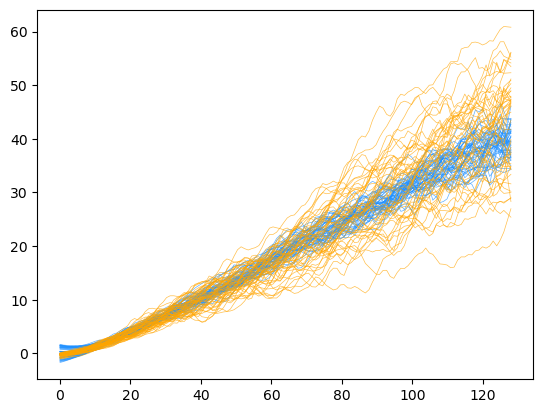

In [64]:
for real_samples_heun_128_ in real_samples_heun_128[:50]:
    plt.plot(ts_heun_128.cpu(), real_samples_heun_128_.cpu(), label='real', color='dodgerblue', linewidth=0.5, alpha=0.7)
for generated_samples_heun_128_ in generated_samples_heun_128[:50]:
    plt.plot(ts_heun_128.cpu(), generated_samples_heun_128_.cpu(), label='generated', color='orange', linewidth=0.5, alpha=0.7)
plt.show() 

Draw the pdf plots

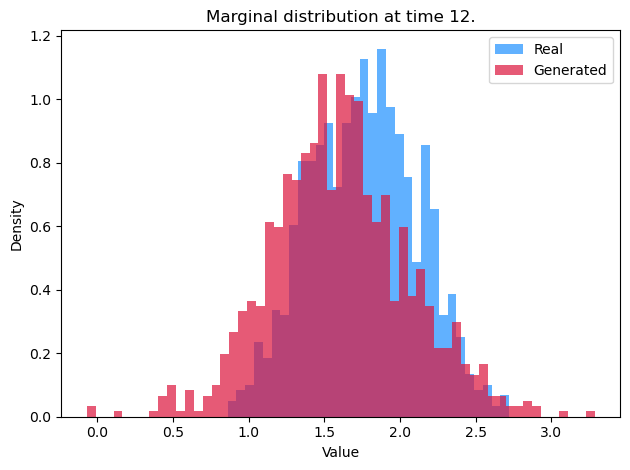

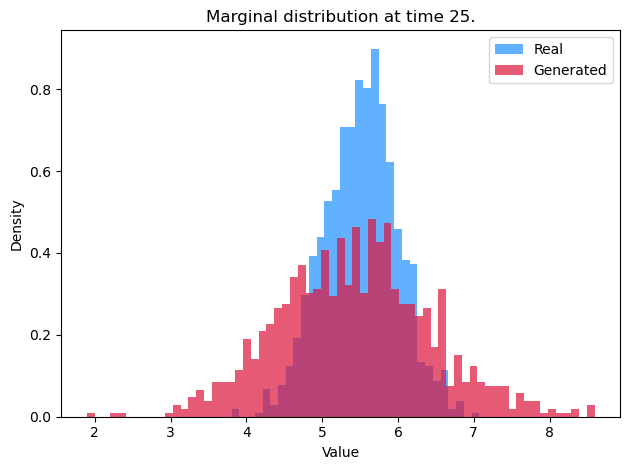

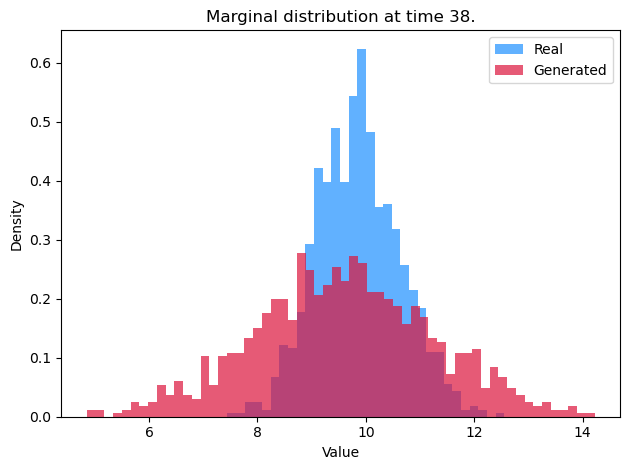

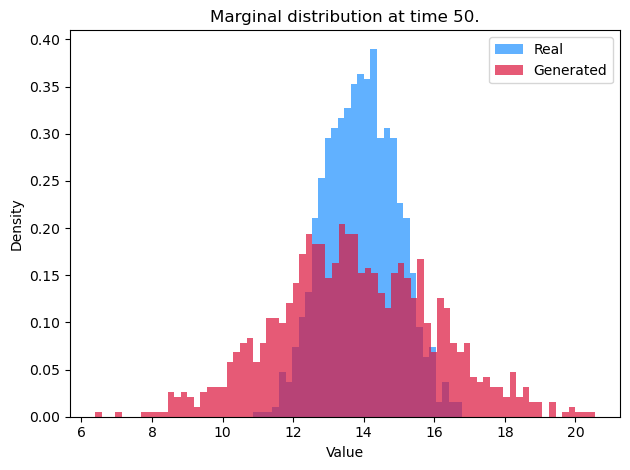

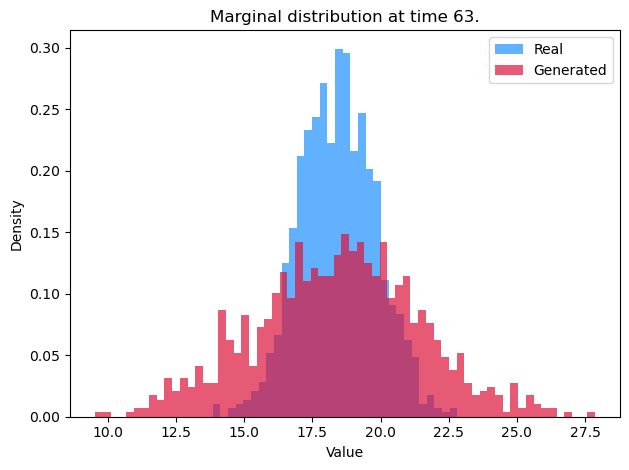

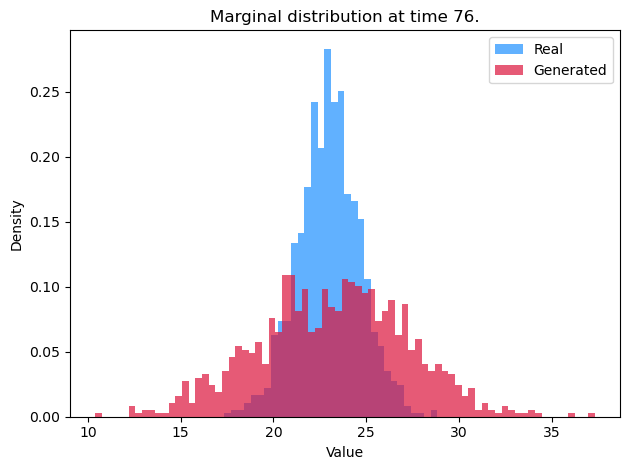

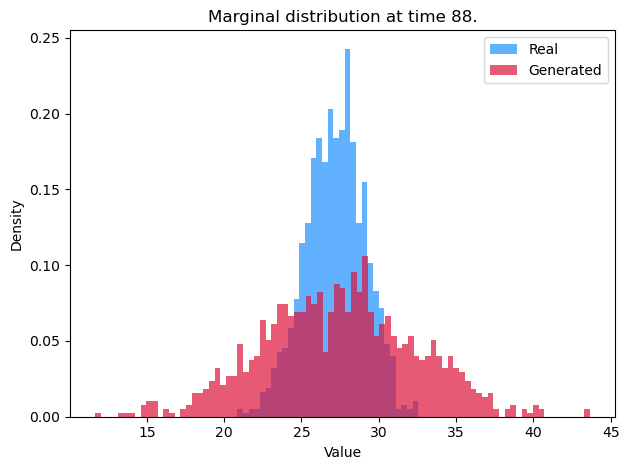

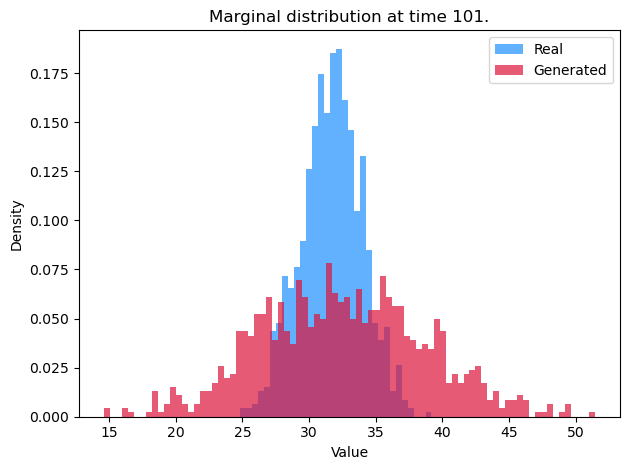

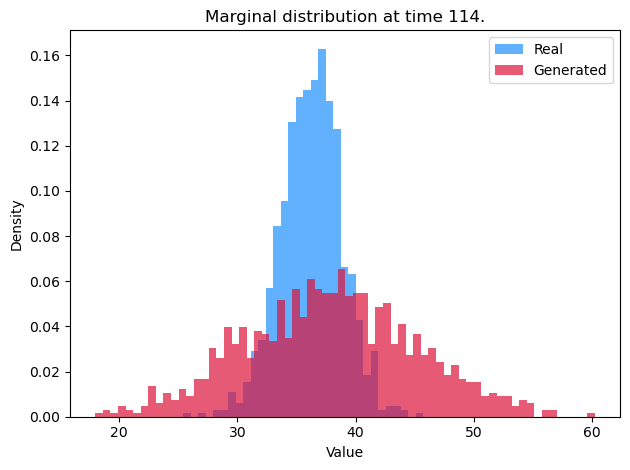

In [67]:
def plot_hist(real_samples, generated_samples):
    plot_locs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)
    for prop in plot_locs:
        time = int(prop * (real_samples.size(1) - 1))
        real_samples_time = real_samples[:, time]
        generated_samples_time = generated_samples[:, time]
        _, bins, _ = plt.hist(real_samples_time.cpu().numpy(), bins=32, alpha=0.7, label='Real', color='dodgerblue',
                              density=True)
        bin_width = bins[1] - bins[0]
        num_bins = int((generated_samples_time.max() - generated_samples_time.min()).item() // bin_width)
        plt.hist(generated_samples_time.cpu().numpy(), bins=num_bins, alpha=0.7, label='Generated', color='crimson',
                 density=True)
        plt.legend()
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.title(f'Marginal distribution at time {time}.')
        plt.tight_layout()
        plt.show()

plot_hist(real_samples_heun_128, generated_samples_heun_128)

## Adjoint method with midpoint solver

In [68]:
class Generator_midpoint(torch.nn.Module):
    def __init__(self, data_size, initial_noise_size, noise_size, hidden_size, mlp_size, num_layers):
        super().__init__()
        self._initial_noise_size = initial_noise_size
        self._hidden_size = hidden_size

        self._initial = MLP(initial_noise_size, hidden_size, mlp_size, num_layers, tanh=False)
        self._func = GeneratorFunc(noise_size, hidden_size, mlp_size, num_layers)
        self._readout = torch.nn.Linear(hidden_size, data_size)

    def forward(self, ts, batch_size):
        # ts has shape (t_size,) and corresponds to the points we want to evaluate the SDE at.

        ###################
        # Actually solve the SDE.
        ###################
        init_noise = torch.randn(batch_size, self._initial_noise_size, device=ts.device)
        x0 = self._initial(init_noise)

        ###################
        # We use the reversible Heun method to get accurate gradients whilst using the adjoint method.
        ###################
        xs = torchsde.sdeint_adjoint(self._func, x0, ts, method='midpoint', dt=1.0,
                                     adjoint_method='midpoint',)
        xs = xs.transpose(0, 1)
        ys = self._readout(xs)

        ###################
        # Normalise the data to the form that the discriminator expects, in particular including time as a channel.
        ###################
        ts = ts.unsqueeze(0).unsqueeze(-1).expand(batch_size, ts.size(0), 1)
        return torchcde.linear_interpolation_coeffs(torch.cat([ts, ys], dim=2))

In [69]:
# importing libraries
import os
import psutil
 
# inner psutil function
def process_memory():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss
 
# decorator function
def profile(func):
    def wrapper(*args, **kwargs):
 
        mem_before = process_memory()
        result = func(*args, **kwargs)
        mem_after = process_memory()
        print("{}:consumed memory: {:,}".format(
            func.__name__,
            mem_before, mem_after, mem_after - mem_before))
 
        return result
    return wrapper
 
# instantiation of decorator function
@profile


def main(
        # Architectural hyperparameters. These are quite small for illustrative purposes.
        t_size=64,             # How many timesteps to use for the SDE solver.
        data_size=8192,        # How many data points to use in the dataset.
        initial_noise_size=5,  # How many noise dimensions to sample at the start of the SDE.
        noise_size=3,          # How many dimensions the Brownian motion has.
        hidden_size=16,        # How big the hidden size of the generator SDE and the discriminator CDE are.
        mlp_size=16,           # How big the layers in the various MLPs are.
        num_layers=1,          # How many hidden layers to have in the various MLPs.

        # Training hyperparameters. Be prepared to tune these very carefully, as with any GAN.
        generator_lr=2e-4,      # Learning rate often needs careful tuning to the problem.
        discriminator_lr=1e-3,  # Learning rate often needs careful tuning to the problem.
        batch_size=1024,        # Batch size.
        steps=10000,            # How many steps to train both generator and discriminator for.
        init_mult1=3,           # Changing the initial parameter size can help.
        init_mult2=0.5,         #
        weight_decay=0.01,      # Weight decay.
        swa_step_start=5000,    # When to start using stochastic weight averaging.

        # Evaluation and plotting hyperparameters
        steps_per_print=10,                   # How often to print the loss.
        num_plot_samples=50,                  # How many samples to use on the plots at the end.
        plot_locs=(0.1, 0.3, 0.5, 0.7, 0.9),  # Plot some marginal distributions at this proportion of the way along.
):
    is_cuda = torch.cuda.is_available()
    device = 'cuda' if is_cuda else 'cpu'
    if not is_cuda:
        print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

    # Data
    ts, data_size, train_dataloader = get_data(t_size=t_size, dataset_size= data_size, batch_size=batch_size, device=device)
    infinite_train_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)

    # Models
    generator = Generator_midpoint(data_size, initial_noise_size, noise_size, hidden_size, mlp_size, num_layers).to(device)
    discriminator = Discriminator(data_size, hidden_size, mlp_size, num_layers).to(device)
    # Weight averaging really helps with GAN training.
    averaged_generator = swa_utils.AveragedModel(generator)
    averaged_discriminator = swa_utils.AveragedModel(discriminator)

    # Picking a good initialisation is important!
    # In this case these were picked by making the parameters for the t=0 part of the generator be roughly the right
    # size that the untrained t=0 distribution has a similar variance to the t=0 data distribution.
    # Then the func parameters were adjusted so that the t>0 distribution looked like it had about the right variance.
    # What we're doing here is very crude -- one can definitely imagine smarter ways of doing things.
    # (e.g. pretraining the t=0 distribution)
    with torch.no_grad():
        for param in generator._initial.parameters():
            param *= init_mult1
        for param in generator._func.parameters():
            param *= init_mult2

    # Optimisers. Adadelta turns out to be a much better choice than SGD or Adam, interestingly.
    generator_optimiser = torch.optim.Adadelta(generator.parameters(), lr=generator_lr, weight_decay=weight_decay)
    discriminator_optimiser = torch.optim.Adadelta(discriminator.parameters(), lr=discriminator_lr,
                                                   weight_decay=weight_decay)

    # Train both generator and discriminator.

    t0 = time.time()

    trange = tqdm.tqdm(range(steps))
    for step in trange:
        real_samples, = next(infinite_train_dataloader)

        generated_samples = generator(ts, batch_size)
        generated_score = discriminator(generated_samples)
        real_score = discriminator(real_samples)
        loss = generated_score - real_score
        loss.backward()

        for param in generator.parameters():
            param.grad *= -1
        generator_optimiser.step()
        discriminator_optimiser.step()
        generator_optimiser.zero_grad()
        discriminator_optimiser.zero_grad()

        ###################
        # We constrain the Lipschitz constant of the discriminator using carefully-chosen clipping (and the use of
        # LipSwish activation functions).
        ###################
        with torch.no_grad():
            for module in discriminator.modules():
                if isinstance(module, torch.nn.Linear):
                    lim = 1 / module.out_features
                    module.weight.clamp_(-lim, lim)

        # Stochastic weight averaging typically improves performance.
        if step > swa_step_start:
            averaged_generator.update_parameters(generator)
            averaged_discriminator.update_parameters(discriminator)

        if (step % steps_per_print) == 0 or step == steps - 1:
            total_unaveraged_loss = evaluate_loss(ts, batch_size, train_dataloader, generator, discriminator)
            if step > swa_step_start:
                total_averaged_loss = evaluate_loss(ts, batch_size, train_dataloader, averaged_generator.module,
                                                    averaged_discriminator.module)
                trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f} "
                             f"Loss (averaged): {total_averaged_loss:.4f}")
            else:
                trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f}")

    print("Training time:", time.time()-t0)

    generator.load_state_dict(averaged_generator.module.state_dict())
    discriminator.load_state_dict(averaged_discriminator.module.state_dict())

    return ts, generator

ts_midpoint, generator_midpoint = main()

  0%|          | 1/10000 [00:02<7:51:03,  2.83s/it]

Step:   0 Loss (unaveraged): 0.6726


  0%|          | 11/10000 [00:12<3:24:49,  1.23s/it]

Step:  10 Loss (unaveraged): 0.6758


  0%|          | 21/10000 [00:20<3:26:45,  1.24s/it]

Step:  20 Loss (unaveraged): 0.6519


  0%|          | 31/10000 [00:29<3:25:17,  1.24s/it]

Step:  30 Loss (unaveraged): 0.6433


  0%|          | 41/10000 [00:38<3:38:07,  1.31s/it]

Step:  40 Loss (unaveraged): 0.6279


  1%|          | 51/10000 [00:49<3:58:48,  1.44s/it]

Step:  50 Loss (unaveraged): 0.6056


  1%|          | 61/10000 [00:57<3:19:30,  1.20s/it]

Step:  60 Loss (unaveraged): 0.5987


  1%|          | 71/10000 [01:06<3:27:00,  1.25s/it]

Step:  70 Loss (unaveraged): 0.5829


  1%|          | 81/10000 [01:15<3:16:22,  1.19s/it]

Step:  80 Loss (unaveraged): 0.5481


  1%|          | 91/10000 [01:23<3:20:40,  1.22s/it]

Step:  90 Loss (unaveraged): 0.5454


  1%|          | 101/10000 [01:31<3:14:22,  1.18s/it]

Step: 100 Loss (unaveraged): 0.5169


  1%|          | 111/10000 [01:41<3:47:00,  1.38s/it]

Step: 110 Loss (unaveraged): 0.4991


  1%|          | 121/10000 [01:50<3:33:07,  1.29s/it]

Step: 120 Loss (unaveraged): 0.4849


  1%|▏         | 131/10000 [01:59<3:17:32,  1.20s/it]

Step: 130 Loss (unaveraged): 0.4625


  1%|▏         | 141/10000 [02:08<3:28:20,  1.27s/it]

Step: 140 Loss (unaveraged): 0.4397


  2%|▏         | 151/10000 [02:16<3:14:31,  1.19s/it]

Step: 150 Loss (unaveraged): 0.4134


  2%|▏         | 161/10000 [02:26<3:22:27,  1.23s/it]

Step: 160 Loss (unaveraged): 0.3869


  2%|▏         | 171/10000 [02:35<3:49:37,  1.40s/it]

Step: 170 Loss (unaveraged): 0.3738


  2%|▏         | 181/10000 [02:43<3:15:20,  1.19s/it]

Step: 180 Loss (unaveraged): 0.3481


  2%|▏         | 191/10000 [02:52<3:14:32,  1.19s/it]

Step: 190 Loss (unaveraged): 0.3261


  2%|▏         | 201/10000 [03:00<3:19:23,  1.22s/it]

Step: 200 Loss (unaveraged): 0.2947


  2%|▏         | 211/10000 [03:09<3:20:05,  1.23s/it]

Step: 210 Loss (unaveraged): 0.2702


  2%|▏         | 221/10000 [03:17<3:16:47,  1.21s/it]

Step: 220 Loss (unaveraged): 0.2437


  2%|▏         | 231/10000 [03:27<4:03:40,  1.50s/it]

Step: 230 Loss (unaveraged): 0.2188


  2%|▏         | 241/10000 [03:35<3:11:39,  1.18s/it]

Step: 240 Loss (unaveraged): 0.1842


  3%|▎         | 251/10000 [03:43<3:03:16,  1.13s/it]

Step: 250 Loss (unaveraged): 0.1586


  3%|▎         | 261/10000 [03:52<3:24:09,  1.26s/it]

Step: 260 Loss (unaveraged): 0.1268


  3%|▎         | 271/10000 [04:00<3:07:19,  1.16s/it]

Step: 270 Loss (unaveraged): 0.0979


  3%|▎         | 281/10000 [04:09<3:08:31,  1.16s/it]

Step: 280 Loss (unaveraged): 0.0698


  3%|▎         | 291/10000 [04:19<4:27:35,  1.65s/it]

Step: 290 Loss (unaveraged): 0.0423


  3%|▎         | 301/10000 [04:28<3:13:27,  1.20s/it]

Step: 300 Loss (unaveraged): 0.0091


  3%|▎         | 311/10000 [04:36<3:17:19,  1.22s/it]

Step: 310 Loss (unaveraged): -0.0227


  3%|▎         | 321/10000 [04:45<3:14:22,  1.20s/it]

Step: 320 Loss (unaveraged): -0.0508


  3%|▎         | 331/10000 [04:54<3:21:11,  1.25s/it]

Step: 330 Loss (unaveraged): -0.0864


  3%|▎         | 341/10000 [05:02<3:29:05,  1.30s/it]

Step: 340 Loss (unaveraged): -0.1180


  4%|▎         | 351/10000 [05:11<3:12:10,  1.19s/it]

Step: 350 Loss (unaveraged): -0.1540


  4%|▎         | 361/10000 [05:21<3:16:18,  1.22s/it]

Step: 360 Loss (unaveraged): -0.1859


  4%|▎         | 371/10000 [05:30<3:24:04,  1.27s/it]

Step: 370 Loss (unaveraged): -0.2151


  4%|▍         | 381/10000 [05:38<3:12:00,  1.20s/it]

Step: 380 Loss (unaveraged): -0.2455


  4%|▍         | 391/10000 [05:46<3:03:44,  1.15s/it]

Step: 390 Loss (unaveraged): -0.2772


  4%|▍         | 401/10000 [05:54<3:09:17,  1.18s/it]

Step: 400 Loss (unaveraged): -0.3038


  4%|▍         | 411/10000 [06:03<3:13:35,  1.21s/it]

Step: 410 Loss (unaveraged): -0.3348


  4%|▍         | 421/10000 [06:13<3:54:29,  1.47s/it]

Step: 420 Loss (unaveraged): -0.3653


  4%|▍         | 431/10000 [06:22<3:15:30,  1.23s/it]

Step: 430 Loss (unaveraged): -0.3930


  4%|▍         | 441/10000 [06:30<3:12:09,  1.21s/it]

Step: 440 Loss (unaveraged): -0.4200


  5%|▍         | 451/10000 [06:39<3:11:01,  1.20s/it]

Step: 450 Loss (unaveraged): -0.4419


  5%|▍         | 461/10000 [06:48<3:11:21,  1.20s/it]

Step: 460 Loss (unaveraged): -0.4672


  5%|▍         | 471/10000 [07:02<6:28:58,  2.45s/it]

Step: 470 Loss (unaveraged): -0.4830


  5%|▍         | 481/10000 [07:12<4:17:27,  1.62s/it]

Step: 480 Loss (unaveraged): -0.4985


  5%|▍         | 491/10000 [07:21<3:28:13,  1.31s/it]

Step: 490 Loss (unaveraged): -0.5258


  5%|▌         | 501/10000 [07:30<3:25:22,  1.30s/it]

Step: 500 Loss (unaveraged): -0.5389


  5%|▌         | 511/10000 [07:39<3:25:03,  1.30s/it]

Step: 510 Loss (unaveraged): -0.5385


  5%|▌         | 521/10000 [07:48<3:23:29,  1.29s/it]

Step: 520 Loss (unaveraged): -0.5582


  5%|▌         | 531/10000 [07:57<3:21:12,  1.27s/it]

Step: 530 Loss (unaveraged): -0.5606


  5%|▌         | 541/10000 [08:05<3:08:18,  1.19s/it]

Step: 540 Loss (unaveraged): -0.5709


  6%|▌         | 551/10000 [08:15<3:09:49,  1.21s/it]

Step: 550 Loss (unaveraged): -0.5689


  6%|▌         | 561/10000 [08:25<3:44:59,  1.43s/it]

Step: 560 Loss (unaveraged): -0.5599


  6%|▌         | 571/10000 [08:34<3:20:52,  1.28s/it]

Step: 570 Loss (unaveraged): -0.5614


  6%|▌         | 581/10000 [08:43<3:21:24,  1.28s/it]

Step: 580 Loss (unaveraged): -0.5569


  6%|▌         | 591/10000 [08:52<3:20:54,  1.28s/it]

Step: 590 Loss (unaveraged): -0.5268


  6%|▌         | 601/10000 [09:01<3:16:25,  1.25s/it]

Step: 600 Loss (unaveraged): -0.5328


  6%|▌         | 611/10000 [09:11<3:21:18,  1.29s/it]

Step: 610 Loss (unaveraged): -0.4971


  6%|▌         | 621/10000 [09:20<3:14:41,  1.25s/it]

Step: 620 Loss (unaveraged): -0.4721


  6%|▋         | 631/10000 [09:29<3:23:23,  1.30s/it]

Step: 630 Loss (unaveraged): -0.4576


  6%|▋         | 641/10000 [09:38<3:09:46,  1.22s/it]

Step: 640 Loss (unaveraged): -0.4210


  7%|▋         | 651/10000 [09:46<3:18:06,  1.27s/it]

Step: 650 Loss (unaveraged): -0.3993


  7%|▋         | 661/10000 [09:55<3:10:21,  1.22s/it]

Step: 660 Loss (unaveraged): -0.3675


  7%|▋         | 671/10000 [10:05<3:21:15,  1.29s/it]

Step: 670 Loss (unaveraged): -0.3169


  7%|▋         | 681/10000 [10:14<3:20:15,  1.29s/it]

Step: 680 Loss (unaveraged): -0.3016


  7%|▋         | 691/10000 [10:23<3:26:03,  1.33s/it]

Step: 690 Loss (unaveraged): -0.2581


  7%|▋         | 701/10000 [10:32<3:16:20,  1.27s/it]

Step: 700 Loss (unaveraged): -0.2040


  7%|▋         | 711/10000 [10:41<3:20:45,  1.30s/it]

Step: 710 Loss (unaveraged): -0.1657


  7%|▋         | 721/10000 [10:49<3:00:25,  1.17s/it]

Step: 720 Loss (unaveraged): -0.1214


  7%|▋         | 731/10000 [10:59<4:09:45,  1.62s/it]

Step: 730 Loss (unaveraged): -0.0819


  7%|▋         | 741/10000 [11:07<2:59:25,  1.16s/it]

Step: 740 Loss (unaveraged): -0.0442


  8%|▊         | 751/10000 [11:16<3:17:54,  1.28s/it]

Step: 750 Loss (unaveraged): -0.0230


  8%|▊         | 761/10000 [11:25<3:01:57,  1.18s/it]

Step: 760 Loss (unaveraged): 0.0073


  8%|▊         | 771/10000 [11:33<3:13:02,  1.26s/it]

Step: 770 Loss (unaveraged): 0.0037


  8%|▊         | 781/10000 [11:43<3:50:41,  1.50s/it]

Step: 780 Loss (unaveraged): 0.0076


  8%|▊         | 791/10000 [11:51<2:59:20,  1.17s/it]

Step: 790 Loss (unaveraged): -0.0007


  8%|▊         | 801/10000 [12:01<3:00:13,  1.18s/it]

Step: 800 Loss (unaveraged): -0.0199


  8%|▊         | 811/10000 [12:09<3:18:32,  1.30s/it]

Step: 810 Loss (unaveraged): -0.0446


  8%|▊         | 821/10000 [12:18<3:24:35,  1.34s/it]

Step: 820 Loss (unaveraged): -0.0891


  8%|▊         | 831/10000 [12:27<2:57:01,  1.16s/it]

Step: 830 Loss (unaveraged): -0.1233


  8%|▊         | 841/10000 [12:35<3:01:56,  1.19s/it]

Step: 840 Loss (unaveraged): -0.1723


  9%|▊         | 851/10000 [12:43<3:02:04,  1.19s/it]

Step: 850 Loss (unaveraged): -0.2199


  9%|▊         | 861/10000 [12:53<3:10:23,  1.25s/it]

Step: 860 Loss (unaveraged): -0.2720


  9%|▊         | 871/10000 [13:02<3:21:06,  1.32s/it]

Step: 870 Loss (unaveraged): -0.3194


  9%|▉         | 881/10000 [13:11<3:21:14,  1.32s/it]

Step: 880 Loss (unaveraged): -0.3651


  9%|▉         | 891/10000 [13:20<3:12:02,  1.27s/it]

Step: 890 Loss (unaveraged): -0.4032


  9%|▉         | 901/10000 [13:28<2:48:14,  1.11s/it]

Step: 900 Loss (unaveraged): -0.4364


  9%|▉         | 911/10000 [13:36<2:54:30,  1.15s/it]

Step: 910 Loss (unaveraged): -0.4411


  9%|▉         | 921/10000 [13:45<3:05:12,  1.22s/it]

Step: 920 Loss (unaveraged): -0.4537


  9%|▉         | 931/10000 [13:53<2:42:12,  1.07s/it]

Step: 930 Loss (unaveraged): -0.4552


  9%|▉         | 941/10000 [14:02<2:51:20,  1.13s/it]

Step: 940 Loss (unaveraged): -0.4386


 10%|▉         | 951/10000 [14:10<2:43:38,  1.08s/it]

Step: 950 Loss (unaveraged): -0.4157


 10%|▉         | 961/10000 [14:17<2:52:33,  1.15s/it]

Step: 960 Loss (unaveraged): -0.3741


 10%|▉         | 971/10000 [14:26<2:59:53,  1.20s/it]

Step: 970 Loss (unaveraged): -0.3540


 10%|▉         | 981/10000 [14:36<3:31:30,  1.41s/it]

Step: 980 Loss (unaveraged): -0.2884


 10%|▉         | 991/10000 [14:44<2:59:44,  1.20s/it]

Step: 990 Loss (unaveraged): -0.2570


 10%|█         | 1001/10000 [14:53<3:12:01,  1.28s/it]

Step: 1000 Loss (unaveraged): -0.2241


 10%|█         | 1011/10000 [15:01<3:04:11,  1.23s/it]

Step: 1010 Loss (unaveraged): -0.1721


 10%|█         | 1021/10000 [15:09<2:43:21,  1.09s/it]

Step: 1020 Loss (unaveraged): -0.1209


 10%|█         | 1031/10000 [15:17<2:46:43,  1.12s/it]

Step: 1030 Loss (unaveraged): -0.0811


 10%|█         | 1041/10000 [15:27<3:47:33,  1.52s/it]

Step: 1040 Loss (unaveraged): -0.0715


 11%|█         | 1051/10000 [15:35<2:55:37,  1.18s/it]

Step: 1050 Loss (unaveraged): -0.0500


 11%|█         | 1061/10000 [15:43<2:52:07,  1.16s/it]

Step: 1060 Loss (unaveraged): -0.0411


 11%|█         | 1071/10000 [15:52<2:53:53,  1.17s/it]

Step: 1070 Loss (unaveraged): -0.0389


 11%|█         | 1081/10000 [15:59<2:39:57,  1.08s/it]

Step: 1080 Loss (unaveraged): -0.0422


 11%|█         | 1091/10000 [16:07<2:39:32,  1.07s/it]

Step: 1090 Loss (unaveraged): -0.0717


 11%|█         | 1101/10000 [16:16<3:26:47,  1.39s/it]

Step: 1100 Loss (unaveraged): -0.0939


 11%|█         | 1111/10000 [16:23<2:38:15,  1.07s/it]

Step: 1110 Loss (unaveraged): -0.1138


 11%|█         | 1121/10000 [16:31<2:39:20,  1.08s/it]

Step: 1120 Loss (unaveraged): -0.1336


 11%|█▏        | 1131/10000 [16:39<2:43:11,  1.10s/it]

Step: 1130 Loss (unaveraged): -0.1533


 11%|█▏        | 1141/10000 [16:46<2:41:23,  1.09s/it]

Step: 1140 Loss (unaveraged): -0.1853


 12%|█▏        | 1151/10000 [16:57<4:26:30,  1.81s/it]

Step: 1150 Loss (unaveraged): -0.1988


 12%|█▏        | 1161/10000 [17:07<2:59:29,  1.22s/it]

Step: 1160 Loss (unaveraged): -0.2286


 12%|█▏        | 1171/10000 [17:16<2:40:55,  1.09s/it]

Step: 1170 Loss (unaveraged): -0.2294


 12%|█▏        | 1181/10000 [17:24<2:49:50,  1.16s/it]

Step: 1180 Loss (unaveraged): -0.2579


 12%|█▏        | 1191/10000 [17:32<2:43:03,  1.11s/it]

Step: 1190 Loss (unaveraged): -0.2715


 12%|█▏        | 1201/10000 [17:40<2:42:31,  1.11s/it]

Step: 1200 Loss (unaveraged): -0.2628


 12%|█▏        | 1211/10000 [17:47<2:38:57,  1.09s/it]

Step: 1210 Loss (unaveraged): -0.2695


 12%|█▏        | 1221/10000 [17:55<3:01:51,  1.24s/it]

Step: 1220 Loss (unaveraged): -0.2541


 12%|█▏        | 1231/10000 [18:05<2:52:30,  1.18s/it]

Step: 1230 Loss (unaveraged): -0.2353


 12%|█▏        | 1241/10000 [18:12<2:41:38,  1.11s/it]

Step: 1240 Loss (unaveraged): -0.2131


 13%|█▎        | 1251/10000 [18:21<3:07:24,  1.29s/it]

Step: 1250 Loss (unaveraged): -0.1876


 13%|█▎        | 1261/10000 [18:30<2:47:55,  1.15s/it]

Step: 1260 Loss (unaveraged): -0.1655


 13%|█▎        | 1271/10000 [18:38<2:39:40,  1.10s/it]

Step: 1270 Loss (unaveraged): -0.1267


 13%|█▎        | 1281/10000 [18:46<2:51:35,  1.18s/it]

Step: 1280 Loss (unaveraged): -0.0961


 13%|█▎        | 1291/10000 [18:55<3:10:09,  1.31s/it]

Step: 1290 Loss (unaveraged): -0.0414


 13%|█▎        | 1301/10000 [19:03<2:41:11,  1.11s/it]

Step: 1300 Loss (unaveraged): -0.0030


 13%|█▎        | 1311/10000 [19:11<2:41:14,  1.11s/it]

Step: 1310 Loss (unaveraged): 0.0331


 13%|█▎        | 1321/10000 [19:19<2:38:23,  1.09s/it]

Step: 1320 Loss (unaveraged): 0.0491


 13%|█▎        | 1331/10000 [19:27<2:35:03,  1.07s/it]

Step: 1330 Loss (unaveraged): 0.0932


 13%|█▎        | 1341/10000 [19:35<2:38:15,  1.10s/it]

Step: 1340 Loss (unaveraged): 0.1057


 14%|█▎        | 1351/10000 [19:44<3:24:45,  1.42s/it]

Step: 1350 Loss (unaveraged): 0.1251


 14%|█▎        | 1361/10000 [19:51<2:35:52,  1.08s/it]

Step: 1360 Loss (unaveraged): 0.1482


 14%|█▎        | 1371/10000 [19:59<2:36:48,  1.09s/it]

Step: 1370 Loss (unaveraged): 0.1331


 14%|█▍        | 1381/10000 [20:08<2:44:00,  1.14s/it]

Step: 1380 Loss (unaveraged): 0.1335


 14%|█▍        | 1391/10000 [20:16<2:35:56,  1.09s/it]

Step: 1390 Loss (unaveraged): 0.1130


 14%|█▍        | 1401/10000 [20:23<2:39:04,  1.11s/it]

Step: 1400 Loss (unaveraged): 0.0875


 14%|█▍        | 1411/10000 [20:32<3:25:25,  1.43s/it]

Step: 1410 Loss (unaveraged): 0.0696


 14%|█▍        | 1421/10000 [20:40<2:43:21,  1.14s/it]

Step: 1420 Loss (unaveraged): 0.0461


 14%|█▍        | 1431/10000 [20:49<2:56:51,  1.24s/it]

Step: 1430 Loss (unaveraged): 0.0249


 14%|█▍        | 1441/10000 [20:58<2:46:28,  1.17s/it]

Step: 1440 Loss (unaveraged): 0.0069


 15%|█▍        | 1451/10000 [21:06<2:39:08,  1.12s/it]

Step: 1450 Loss (unaveraged): -0.0214


 15%|█▍        | 1461/10000 [21:14<2:51:00,  1.20s/it]

Step: 1460 Loss (unaveraged): -0.0350


 15%|█▍        | 1471/10000 [21:24<3:39:27,  1.54s/it]

Step: 1470 Loss (unaveraged): -0.0515


 15%|█▍        | 1481/10000 [21:33<3:09:14,  1.33s/it]

Step: 1480 Loss (unaveraged): -0.0490


 15%|█▍        | 1491/10000 [21:41<2:54:57,  1.23s/it]

Step: 1490 Loss (unaveraged): -0.0503


 15%|█▌        | 1501/10000 [21:50<2:45:09,  1.17s/it]

Step: 1500 Loss (unaveraged): -0.0284


 15%|█▌        | 1511/10000 [21:58<2:46:49,  1.18s/it]

Step: 1510 Loss (unaveraged): -0.0110


 15%|█▌        | 1521/10000 [22:07<2:52:41,  1.22s/it]

Step: 1520 Loss (unaveraged): -0.0002


 15%|█▌        | 1531/10000 [22:15<2:47:05,  1.18s/it]

Step: 1530 Loss (unaveraged): 0.0517


 15%|█▌        | 1541/10000 [22:25<2:59:13,  1.27s/it]

Step: 1540 Loss (unaveraged): 0.0554


 16%|█▌        | 1551/10000 [22:33<2:49:08,  1.20s/it]

Step: 1550 Loss (unaveraged): 0.0701


 16%|█▌        | 1561/10000 [22:42<2:54:38,  1.24s/it]

Step: 1560 Loss (unaveraged): 0.0984


 16%|█▌        | 1571/10000 [22:51<2:46:46,  1.19s/it]

Step: 1570 Loss (unaveraged): 0.1150


 16%|█▌        | 1581/10000 [22:59<3:00:53,  1.29s/it]

Step: 1580 Loss (unaveraged): 0.1107


 16%|█▌        | 1591/10000 [23:08<2:44:11,  1.17s/it]

Step: 1590 Loss (unaveraged): 0.1373


 16%|█▌        | 1601/10000 [23:17<2:57:13,  1.27s/it]

Step: 1600 Loss (unaveraged): 0.1570


 16%|█▌        | 1611/10000 [23:25<2:42:01,  1.16s/it]

Step: 1610 Loss (unaveraged): 0.1597


 16%|█▌        | 1621/10000 [23:34<2:42:16,  1.16s/it]

Step: 1620 Loss (unaveraged): 0.1685


 16%|█▋        | 1631/10000 [23:42<2:37:12,  1.13s/it]

Step: 1630 Loss (unaveraged): 0.1519


 16%|█▋        | 1641/10000 [23:50<2:40:03,  1.15s/it]

Step: 1640 Loss (unaveraged): 0.1303


 17%|█▋        | 1651/10000 [23:58<2:36:39,  1.13s/it]

Step: 1650 Loss (unaveraged): 0.1159


 17%|█▋        | 1661/10000 [24:07<3:01:21,  1.30s/it]

Step: 1660 Loss (unaveraged): 0.0866


 17%|█▋        | 1671/10000 [24:15<2:38:47,  1.14s/it]

Step: 1670 Loss (unaveraged): 0.0665


 17%|█▋        | 1681/10000 [24:23<2:41:39,  1.17s/it]

Step: 1680 Loss (unaveraged): 0.0403


 17%|█▋        | 1691/10000 [24:31<2:36:38,  1.13s/it]

Step: 1690 Loss (unaveraged): 0.0117


 17%|█▋        | 1701/10000 [24:39<2:38:34,  1.15s/it]

Step: 1700 Loss (unaveraged): -0.0171


 17%|█▋        | 1711/10000 [24:47<2:38:22,  1.15s/it]

Step: 1710 Loss (unaveraged): -0.0442


 17%|█▋        | 1721/10000 [24:57<3:23:17,  1.47s/it]

Step: 1720 Loss (unaveraged): -0.0657


 17%|█▋        | 1731/10000 [25:05<2:38:14,  1.15s/it]

Step: 1730 Loss (unaveraged): -0.0863


 17%|█▋        | 1741/10000 [25:13<2:36:50,  1.14s/it]

Step: 1740 Loss (unaveraged): -0.0931


 18%|█▊        | 1751/10000 [25:21<2:47:41,  1.22s/it]

Step: 1750 Loss (unaveraged): -0.1054


 18%|█▊        | 1761/10000 [25:30<3:00:43,  1.32s/it]

Step: 1760 Loss (unaveraged): -0.1119


 18%|█▊        | 1771/10000 [25:40<2:51:58,  1.25s/it]

Step: 1770 Loss (unaveraged): -0.1071


 18%|█▊        | 1781/10000 [25:49<3:35:08,  1.57s/it]

Step: 1780 Loss (unaveraged): -0.0995


 18%|█▊        | 1791/10000 [25:57<2:42:10,  1.19s/it]

Step: 1790 Loss (unaveraged): -0.1118


 18%|█▊        | 1801/10000 [26:06<2:46:14,  1.22s/it]

Step: 1800 Loss (unaveraged): -0.0837


 18%|█▊        | 1811/10000 [26:15<2:58:53,  1.31s/it]

Step: 1810 Loss (unaveraged): -0.0654


 18%|█▊        | 1821/10000 [26:24<2:43:40,  1.20s/it]

Step: 1820 Loss (unaveraged): -0.0639


 18%|█▊        | 1831/10000 [26:33<2:42:35,  1.19s/it]

Step: 1830 Loss (unaveraged): -0.0472


 18%|█▊        | 1841/10000 [26:42<3:26:30,  1.52s/it]

Step: 1840 Loss (unaveraged): -0.0538


 19%|█▊        | 1851/10000 [26:51<3:06:56,  1.38s/it]

Step: 1850 Loss (unaveraged): -0.0368


 19%|█▊        | 1861/10000 [27:06<3:53:05,  1.72s/it]

Step: 1860 Loss (unaveraged): -0.0440


 19%|█▊        | 1871/10000 [27:14<2:54:21,  1.29s/it]

Step: 1870 Loss (unaveraged): -0.0488


 19%|█▉        | 1881/10000 [27:23<2:50:11,  1.26s/it]

Step: 1880 Loss (unaveraged): -0.0524


 19%|█▉        | 1891/10000 [27:31<2:40:05,  1.18s/it]

Step: 1890 Loss (unaveraged): -0.0759


 19%|█▉        | 1901/10000 [27:40<2:38:39,  1.18s/it]

Step: 1900 Loss (unaveraged): -0.0941


 19%|█▉        | 1911/10000 [27:50<2:45:28,  1.23s/it]

Step: 1910 Loss (unaveraged): -0.1219


 19%|█▉        | 1921/10000 [27:58<2:50:17,  1.26s/it]

Step: 1920 Loss (unaveraged): -0.1549


 19%|█▉        | 1931/10000 [28:07<2:41:33,  1.20s/it]

Step: 1930 Loss (unaveraged): -0.1812


 19%|█▉        | 1941/10000 [28:16<2:48:37,  1.26s/it]

Step: 1940 Loss (unaveraged): -0.2116


 20%|█▉        | 1951/10000 [28:25<2:44:48,  1.23s/it]

Step: 1950 Loss (unaveraged): -0.2351


 20%|█▉        | 1961/10000 [28:34<2:42:03,  1.21s/it]

Step: 1960 Loss (unaveraged): -0.2592


 20%|█▉        | 1971/10000 [28:43<2:51:54,  1.28s/it]

Step: 1970 Loss (unaveraged): -0.2752


 20%|█▉        | 1981/10000 [28:52<2:44:22,  1.23s/it]

Step: 1980 Loss (unaveraged): -0.2885


 20%|█▉        | 1991/10000 [29:00<2:40:55,  1.21s/it]

Step: 1990 Loss (unaveraged): -0.2911


 20%|██        | 2001/10000 [29:09<2:41:24,  1.21s/it]

Step: 2000 Loss (unaveraged): -0.2980


 20%|██        | 2011/10000 [29:17<2:41:45,  1.21s/it]

Step: 2010 Loss (unaveraged): -0.2925


 20%|██        | 2021/10000 [29:26<2:54:13,  1.31s/it]

Step: 2020 Loss (unaveraged): -0.2854


 20%|██        | 2031/10000 [29:36<2:53:40,  1.31s/it]

Step: 2030 Loss (unaveraged): -0.2722


 20%|██        | 2041/10000 [29:44<2:39:46,  1.20s/it]

Step: 2040 Loss (unaveraged): -0.2622


 21%|██        | 2051/10000 [29:52<2:36:52,  1.18s/it]

Step: 2050 Loss (unaveraged): -0.2547


 21%|██        | 2061/10000 [30:02<3:08:41,  1.43s/it]

Step: 2060 Loss (unaveraged): -0.2264


 21%|██        | 2071/10000 [30:14<3:08:20,  1.43s/it]

Step: 2070 Loss (unaveraged): -0.2324


 21%|██        | 2081/10000 [30:23<2:55:18,  1.33s/it]

Step: 2080 Loss (unaveraged): -0.2141


 21%|██        | 2091/10000 [30:34<3:35:39,  1.64s/it]

Step: 2090 Loss (unaveraged): -0.2159


 21%|██        | 2101/10000 [30:42<2:37:28,  1.20s/it]

Step: 2100 Loss (unaveraged): -0.2139


 21%|██        | 2111/10000 [30:51<2:49:52,  1.29s/it]

Step: 2110 Loss (unaveraged): -0.2329


 21%|██        | 2121/10000 [31:00<2:36:36,  1.19s/it]

Step: 2120 Loss (unaveraged): -0.2362


 21%|██▏       | 2131/10000 [31:08<2:32:23,  1.16s/it]

Step: 2130 Loss (unaveraged): -0.2422


 21%|██▏       | 2141/10000 [31:17<2:58:38,  1.36s/it]

Step: 2140 Loss (unaveraged): -0.2528


 22%|██▏       | 2151/10000 [31:26<3:14:53,  1.49s/it]

Step: 2150 Loss (unaveraged): -0.2719


 22%|██▏       | 2161/10000 [31:34<2:40:42,  1.23s/it]

Step: 2160 Loss (unaveraged): -0.2884


 22%|██▏       | 2171/10000 [31:43<2:46:43,  1.28s/it]

Step: 2170 Loss (unaveraged): -0.3074


 22%|██▏       | 2181/10000 [31:52<2:45:02,  1.27s/it]

Step: 2180 Loss (unaveraged): -0.3352


 22%|██▏       | 2191/10000 [32:01<2:41:57,  1.24s/it]

Step: 2190 Loss (unaveraged): -0.3313


 22%|██▏       | 2201/10000 [32:10<2:46:31,  1.28s/it]

Step: 2200 Loss (unaveraged): -0.3393


 22%|██▏       | 2211/10000 [32:20<3:16:39,  1.51s/it]

Step: 2210 Loss (unaveraged): -0.3654


 22%|██▏       | 2221/10000 [32:28<2:32:43,  1.18s/it]

Step: 2220 Loss (unaveraged): -0.3588


 22%|██▏       | 2231/10000 [32:38<3:06:23,  1.44s/it]

Step: 2230 Loss (unaveraged): -0.3436


 22%|██▏       | 2241/10000 [32:47<2:58:02,  1.38s/it]

Step: 2240 Loss (unaveraged): -0.3426


 23%|██▎       | 2251/10000 [32:56<2:32:14,  1.18s/it]

Step: 2250 Loss (unaveraged): -0.3362


 23%|██▎       | 2261/10000 [33:04<2:31:21,  1.17s/it]

Step: 2260 Loss (unaveraged): -0.3137


 23%|██▎       | 2271/10000 [33:13<2:35:18,  1.21s/it]

Step: 2270 Loss (unaveraged): -0.3080


 23%|██▎       | 2281/10000 [33:22<2:30:05,  1.17s/it]

Step: 2280 Loss (unaveraged): -0.2785


 23%|██▎       | 2291/10000 [33:31<2:51:49,  1.34s/it]

Step: 2290 Loss (unaveraged): -0.2575


 23%|██▎       | 2301/10000 [33:40<2:56:04,  1.37s/it]

Step: 2300 Loss (unaveraged): -0.2280


 23%|██▎       | 2311/10000 [33:49<2:38:03,  1.23s/it]

Step: 2310 Loss (unaveraged): -0.2171


 23%|██▎       | 2321/10000 [33:58<2:30:35,  1.18s/it]

Step: 2320 Loss (unaveraged): -0.2114


 23%|██▎       | 2331/10000 [34:06<2:30:54,  1.18s/it]

Step: 2330 Loss (unaveraged): -0.2068


 23%|██▎       | 2341/10000 [34:15<2:41:20,  1.26s/it]

Step: 2340 Loss (unaveraged): -0.2194


 24%|██▎       | 2351/10000 [34:24<2:37:52,  1.24s/it]

Step: 2350 Loss (unaveraged): -0.2060


 24%|██▎       | 2361/10000 [34:33<2:45:13,  1.30s/it]

Step: 2360 Loss (unaveraged): -0.2240


 24%|██▎       | 2371/10000 [34:42<3:02:54,  1.44s/it]

Step: 2370 Loss (unaveraged): -0.2425


 24%|██▍       | 2381/10000 [34:51<2:34:00,  1.21s/it]

Step: 2380 Loss (unaveraged): -0.2590


 24%|██▍       | 2391/10000 [35:00<2:33:34,  1.21s/it]

Step: 2390 Loss (unaveraged): -0.2857


 24%|██▍       | 2401/10000 [35:09<2:45:54,  1.31s/it]

Step: 2400 Loss (unaveraged): -0.2858


 24%|██▍       | 2411/10000 [35:17<2:24:50,  1.15s/it]

Step: 2410 Loss (unaveraged): -0.2863


 24%|██▍       | 2421/10000 [35:25<2:26:11,  1.16s/it]

Step: 2420 Loss (unaveraged): -0.2914


 24%|██▍       | 2431/10000 [35:34<2:24:49,  1.15s/it]

Step: 2430 Loss (unaveraged): -0.2867


 24%|██▍       | 2441/10000 [35:42<2:28:26,  1.18s/it]

Step: 2440 Loss (unaveraged): -0.2740


 25%|██▍       | 2451/10000 [35:51<2:41:38,  1.28s/it]

Step: 2450 Loss (unaveraged): -0.2493


 25%|██▍       | 2461/10000 [36:01<3:12:33,  1.53s/it]

Step: 2460 Loss (unaveraged): -0.2361


 25%|██▍       | 2471/10000 [36:09<2:31:03,  1.20s/it]

Step: 2470 Loss (unaveraged): -0.2103


 25%|██▍       | 2481/10000 [36:18<2:52:00,  1.37s/it]

Step: 2480 Loss (unaveraged): -0.1921


 25%|██▍       | 2491/10000 [36:27<2:36:56,  1.25s/it]

Step: 2490 Loss (unaveraged): -0.1732


 25%|██▌       | 2501/10000 [36:36<2:46:42,  1.33s/it]

Step: 2500 Loss (unaveraged): -0.1590


 25%|██▌       | 2511/10000 [36:45<2:39:34,  1.28s/it]

Step: 2510 Loss (unaveraged): -0.1568


 25%|██▌       | 2521/10000 [37:00<5:23:37,  2.60s/it]

Step: 2520 Loss (unaveraged): -0.1674


 25%|██▌       | 2531/10000 [37:10<2:50:13,  1.37s/it]

Step: 2530 Loss (unaveraged): -0.1878


 25%|██▌       | 2541/10000 [37:20<2:39:56,  1.29s/it]

Step: 2540 Loss (unaveraged): -0.2094


 26%|██▌       | 2551/10000 [37:30<2:51:08,  1.38s/it]

Step: 2550 Loss (unaveraged): -0.2383


 26%|██▌       | 2561/10000 [37:38<2:25:30,  1.17s/it]

Step: 2560 Loss (unaveraged): -0.2670


 26%|██▌       | 2571/10000 [37:46<2:31:35,  1.22s/it]

Step: 2570 Loss (unaveraged): -0.3006


 26%|██▌       | 2581/10000 [37:55<3:08:12,  1.52s/it]

Step: 2580 Loss (unaveraged): -0.3464


 26%|██▌       | 2591/10000 [38:04<2:26:55,  1.19s/it]

Step: 2590 Loss (unaveraged): -0.3616


 26%|██▌       | 2601/10000 [38:12<2:19:33,  1.13s/it]

Step: 2600 Loss (unaveraged): -0.3919


 26%|██▌       | 2611/10000 [38:21<2:48:30,  1.37s/it]

Step: 2610 Loss (unaveraged): -0.4069


 26%|██▌       | 2621/10000 [38:30<2:19:27,  1.13s/it]

Step: 2620 Loss (unaveraged): -0.4093


 26%|██▋       | 2631/10000 [38:38<2:32:14,  1.24s/it]

Step: 2630 Loss (unaveraged): -0.4025


 26%|██▋       | 2641/10000 [38:47<2:30:14,  1.22s/it]

Step: 2640 Loss (unaveraged): -0.4087


 27%|██▋       | 2651/10000 [38:56<2:22:53,  1.17s/it]

Step: 2650 Loss (unaveraged): -0.4041


 27%|██▋       | 2661/10000 [39:04<2:20:18,  1.15s/it]

Step: 2660 Loss (unaveraged): -0.3726


 27%|██▋       | 2671/10000 [39:12<2:19:16,  1.14s/it]

Step: 2670 Loss (unaveraged): -0.4097


 27%|██▋       | 2681/10000 [39:20<2:14:29,  1.10s/it]

Step: 2680 Loss (unaveraged): -0.3963


 27%|██▋       | 2691/10000 [39:28<2:14:21,  1.10s/it]

Step: 2690 Loss (unaveraged): -0.4261


 27%|██▋       | 2701/10000 [39:36<2:17:18,  1.13s/it]

Step: 2700 Loss (unaveraged): -0.4509


 27%|██▋       | 2711/10000 [39:45<2:25:56,  1.20s/it]

Step: 2710 Loss (unaveraged): -0.4864


 27%|██▋       | 2721/10000 [39:53<2:15:59,  1.12s/it]

Step: 2720 Loss (unaveraged): -0.5249


 27%|██▋       | 2731/10000 [40:01<2:16:56,  1.13s/it]

Step: 2730 Loss (unaveraged): -0.5602


 27%|██▋       | 2741/10000 [40:09<2:15:28,  1.12s/it]

Step: 2740 Loss (unaveraged): -0.6012


 28%|██▊       | 2751/10000 [40:16<2:13:59,  1.11s/it]

Step: 2750 Loss (unaveraged): -0.6065


 28%|██▊       | 2761/10000 [40:24<2:15:54,  1.13s/it]

Step: 2760 Loss (unaveraged): -0.6168


 28%|██▊       | 2771/10000 [40:34<2:42:57,  1.35s/it]

Step: 2770 Loss (unaveraged): -0.6268


 28%|██▊       | 2781/10000 [40:42<2:16:02,  1.13s/it]

Step: 2780 Loss (unaveraged): -0.6264


 28%|██▊       | 2791/10000 [40:50<2:15:09,  1.12s/it]

Step: 2790 Loss (unaveraged): -0.6023


 28%|██▊       | 2801/10000 [40:58<2:13:58,  1.12s/it]

Step: 2800 Loss (unaveraged): -0.6005


 28%|██▊       | 2811/10000 [41:06<2:20:29,  1.17s/it]

Step: 2810 Loss (unaveraged): -0.5542


 28%|██▊       | 2821/10000 [41:14<2:22:38,  1.19s/it]

Step: 2820 Loss (unaveraged): -0.5498


 28%|██▊       | 2831/10000 [41:24<3:09:06,  1.58s/it]

Step: 2830 Loss (unaveraged): -0.5432


 28%|██▊       | 2841/10000 [41:32<2:16:55,  1.15s/it]

Step: 2840 Loss (unaveraged): -0.5393


 29%|██▊       | 2851/10000 [41:40<2:14:50,  1.13s/it]

Step: 2850 Loss (unaveraged): -0.5349


 29%|██▊       | 2861/10000 [41:48<2:11:05,  1.10s/it]

Step: 2860 Loss (unaveraged): -0.5197


 29%|██▊       | 2871/10000 [41:56<2:11:43,  1.11s/it]

Step: 2870 Loss (unaveraged): -0.5246


 29%|██▉       | 2881/10000 [42:03<2:09:30,  1.09s/it]

Step: 2880 Loss (unaveraged): -0.5293


 29%|██▉       | 2891/10000 [42:12<2:47:41,  1.42s/it]

Step: 2890 Loss (unaveraged): -0.5028


 29%|██▉       | 2901/10000 [42:20<2:07:20,  1.08s/it]

Step: 2900 Loss (unaveraged): -0.5144


 29%|██▉       | 2911/10000 [42:28<2:21:08,  1.19s/it]

Step: 2910 Loss (unaveraged): -0.4812


 29%|██▉       | 2921/10000 [42:36<2:17:58,  1.17s/it]

Step: 2920 Loss (unaveraged): -0.4503


 29%|██▉       | 2931/10000 [42:45<2:19:56,  1.19s/it]

Step: 2930 Loss (unaveraged): -0.4374


 29%|██▉       | 2941/10000 [42:53<2:18:45,  1.18s/it]

Step: 2940 Loss (unaveraged): -0.4017


 30%|██▉       | 2951/10000 [43:02<2:53:53,  1.48s/it]

Step: 2950 Loss (unaveraged): -0.3856


 30%|██▉       | 2961/10000 [43:11<2:21:14,  1.20s/it]

Step: 2960 Loss (unaveraged): -0.3709


 30%|██▉       | 2971/10000 [43:19<2:28:21,  1.27s/it]

Step: 2970 Loss (unaveraged): -0.3632


 30%|██▉       | 2981/10000 [43:28<2:26:57,  1.26s/it]

Step: 2980 Loss (unaveraged): -0.3757


 30%|██▉       | 2991/10000 [43:37<2:22:05,  1.22s/it]

Step: 2990 Loss (unaveraged): -0.3804


 30%|███       | 3001/10000 [43:45<2:19:51,  1.20s/it]

Step: 3000 Loss (unaveraged): -0.3577


 30%|███       | 3011/10000 [43:54<2:17:18,  1.18s/it]

Step: 3010 Loss (unaveraged): -0.3772


 30%|███       | 3021/10000 [44:03<2:26:20,  1.26s/it]

Step: 3020 Loss (unaveraged): -0.3458


 30%|███       | 3031/10000 [44:11<2:10:29,  1.12s/it]

Step: 3030 Loss (unaveraged): -0.3691


 30%|███       | 3041/10000 [44:19<2:10:34,  1.13s/it]

Step: 3040 Loss (unaveraged): -0.3719


 31%|███       | 3051/10000 [44:27<2:14:25,  1.16s/it]

Step: 3050 Loss (unaveraged): -0.3793


 31%|███       | 3061/10000 [44:35<2:15:22,  1.17s/it]

Step: 3060 Loss (unaveraged): -0.3734


 31%|███       | 3071/10000 [44:43<2:14:35,  1.17s/it]

Step: 3070 Loss (unaveraged): -0.3713


 31%|███       | 3081/10000 [44:52<2:18:49,  1.20s/it]

Step: 3080 Loss (unaveraged): -0.3895


 31%|███       | 3091/10000 [45:00<2:09:50,  1.13s/it]

Step: 3090 Loss (unaveraged): -0.3822


 31%|███       | 3101/10000 [45:09<2:10:58,  1.14s/it]

Step: 3100 Loss (unaveraged): -0.3889


 31%|███       | 3111/10000 [45:17<2:11:14,  1.14s/it]

Step: 3110 Loss (unaveraged): -0.3840


 31%|███       | 3121/10000 [45:25<2:09:23,  1.13s/it]

Step: 3120 Loss (unaveraged): -0.3859


 31%|███▏      | 3131/10000 [45:33<2:11:11,  1.15s/it]

Step: 3130 Loss (unaveraged): -0.3746


 31%|███▏      | 3141/10000 [45:42<2:26:52,  1.28s/it]

Step: 3140 Loss (unaveraged): -0.3635


 32%|███▏      | 3151/10000 [45:49<2:07:03,  1.11s/it]

Step: 3150 Loss (unaveraged): -0.3645


 32%|███▏      | 3161/10000 [45:58<2:16:15,  1.20s/it]

Step: 3160 Loss (unaveraged): -0.3677


 32%|███▏      | 3171/10000 [46:06<2:11:58,  1.16s/it]

Step: 3170 Loss (unaveraged): -0.3464


 32%|███▏      | 3181/10000 [46:14<2:11:36,  1.16s/it]

Step: 3180 Loss (unaveraged): -0.3300


 32%|███▏      | 3191/10000 [46:22<2:11:38,  1.16s/it]

Step: 3190 Loss (unaveraged): -0.3143


 32%|███▏      | 3201/10000 [46:32<2:50:34,  1.51s/it]

Step: 3200 Loss (unaveraged): -0.3120


 32%|███▏      | 3211/10000 [46:40<2:15:20,  1.20s/it]

Step: 3210 Loss (unaveraged): -0.2900


 32%|███▏      | 3221/10000 [46:49<2:16:49,  1.21s/it]

Step: 3220 Loss (unaveraged): -0.2772


 32%|███▏      | 3231/10000 [47:03<4:02:56,  2.15s/it]

Step: 3230 Loss (unaveraged): -0.2558


 32%|███▏      | 3241/10000 [47:12<2:30:59,  1.34s/it]

Step: 3240 Loss (unaveraged): -0.2522


 33%|███▎      | 3251/10000 [47:21<2:13:45,  1.19s/it]

Step: 3250 Loss (unaveraged): -0.2373


 33%|███▎      | 3261/10000 [47:30<2:51:06,  1.52s/it]

Step: 3260 Loss (unaveraged): -0.2176


 33%|███▎      | 3271/10000 [47:38<2:07:36,  1.14s/it]

Step: 3270 Loss (unaveraged): -0.1874


 33%|███▎      | 3281/10000 [47:48<2:33:59,  1.38s/it]

Step: 3280 Loss (unaveraged): -0.1745


 33%|███▎      | 3291/10000 [47:57<2:22:46,  1.28s/it]

Step: 3290 Loss (unaveraged): -0.1643


 33%|███▎      | 3301/10000 [48:08<3:26:00,  1.85s/it]

Step: 3300 Loss (unaveraged): -0.1282


 33%|███▎      | 3311/10000 [48:24<4:18:33,  2.32s/it]

Step: 3310 Loss (unaveraged): -0.1189


 33%|███▎      | 3321/10000 [48:43<5:13:30,  2.82s/it]

Step: 3320 Loss (unaveraged): -0.1122


 33%|███▎      | 3331/10000 [48:59<4:23:49,  2.37s/it]

Step: 3330 Loss (unaveraged): -0.0781


 33%|███▎      | 3341/10000 [49:15<4:15:04,  2.30s/it]

Step: 3340 Loss (unaveraged): -0.0590


 34%|███▎      | 3351/10000 [49:31<4:07:33,  2.23s/it]

Step: 3350 Loss (unaveraged): -0.0401


 34%|███▎      | 3361/10000 [49:47<4:10:14,  2.26s/it]

Step: 3360 Loss (unaveraged): -0.0184


 34%|███▎      | 3371/10000 [50:04<4:14:10,  2.30s/it]

Step: 3370 Loss (unaveraged): -0.0159


 34%|███▍      | 3381/10000 [50:19<3:59:39,  2.17s/it]

Step: 3380 Loss (unaveraged): -0.0044


 34%|███▍      | 3391/10000 [50:36<3:27:38,  1.89s/it]

Step: 3390 Loss (unaveraged): 0.0104


 34%|███▍      | 3401/10000 [50:44<2:07:22,  1.16s/it]

Step: 3400 Loss (unaveraged): 0.0159


 34%|███▍      | 3411/10000 [50:52<2:05:04,  1.14s/it]

Step: 3410 Loss (unaveraged): 0.0327


 34%|███▍      | 3421/10000 [51:00<2:01:22,  1.11s/it]

Step: 3420 Loss (unaveraged): 0.0383


 34%|███▍      | 3431/10000 [51:08<2:05:49,  1.15s/it]

Step: 3430 Loss (unaveraged): 0.0522


 34%|███▍      | 3441/10000 [51:16<2:13:56,  1.23s/it]

Step: 3440 Loss (unaveraged): 0.0422


 35%|███▍      | 3451/10000 [51:29<2:47:44,  1.54s/it]

Step: 3450 Loss (unaveraged): 0.0481


 35%|███▍      | 3461/10000 [51:36<1:58:13,  1.08s/it]

Step: 3460 Loss (unaveraged): 0.0440


 35%|███▍      | 3471/10000 [51:44<1:59:00,  1.09s/it]

Step: 3470 Loss (unaveraged): 0.0466


 35%|███▍      | 3481/10000 [51:51<1:55:07,  1.06s/it]

Step: 3480 Loss (unaveraged): 0.0252


 35%|███▍      | 3491/10000 [51:59<1:55:27,  1.06s/it]

Step: 3490 Loss (unaveraged): 0.0553


 35%|███▌      | 3501/10000 [52:07<2:03:43,  1.14s/it]

Step: 3500 Loss (unaveraged): 0.0291


 35%|███▌      | 3511/10000 [52:16<2:20:05,  1.30s/it]

Step: 3510 Loss (unaveraged): 0.0200


 35%|███▌      | 3521/10000 [52:24<2:06:05,  1.17s/it]

Step: 3520 Loss (unaveraged): 0.0225


 35%|███▌      | 3531/10000 [52:32<1:56:11,  1.08s/it]

Step: 3530 Loss (unaveraged): 0.0285


 35%|███▌      | 3541/10000 [52:40<2:17:15,  1.28s/it]

Step: 3540 Loss (unaveraged): 0.0184


 36%|███▌      | 3551/10000 [52:51<2:27:39,  1.37s/it]

Step: 3550 Loss (unaveraged): 0.0159


 36%|███▌      | 3561/10000 [52:59<1:57:56,  1.10s/it]

Step: 3560 Loss (unaveraged): 0.0323


 36%|███▌      | 3571/10000 [53:07<2:33:50,  1.44s/it]

Step: 3570 Loss (unaveraged): 0.0318


 36%|███▌      | 3581/10000 [53:15<2:03:21,  1.15s/it]

Step: 3580 Loss (unaveraged): 0.0374


 36%|███▌      | 3591/10000 [53:23<1:59:35,  1.12s/it]

Step: 3590 Loss (unaveraged): 0.0576


 36%|███▌      | 3601/10000 [53:31<1:54:45,  1.08s/it]

Step: 3600 Loss (unaveraged): 0.0659


 36%|███▌      | 3611/10000 [53:38<1:53:20,  1.06s/it]

Step: 3610 Loss (unaveraged): 0.0806


 36%|███▌      | 3621/10000 [53:46<1:58:29,  1.11s/it]

Step: 3620 Loss (unaveraged): 0.1114


 36%|███▋      | 3631/10000 [53:58<3:33:49,  2.01s/it]

Step: 3630 Loss (unaveraged): 0.1302


 36%|███▋      | 3641/10000 [54:06<1:54:19,  1.08s/it]

Step: 3640 Loss (unaveraged): 0.1511


 37%|███▋      | 3651/10000 [54:13<1:49:41,  1.04s/it]

Step: 3650 Loss (unaveraged): 0.1659


 37%|███▋      | 3661/10000 [54:20<1:51:00,  1.05s/it]

Step: 3660 Loss (unaveraged): 0.1900


 37%|███▋      | 3671/10000 [54:28<1:54:54,  1.09s/it]

Step: 3670 Loss (unaveraged): 0.2144


 37%|███▋      | 3681/10000 [54:36<2:01:56,  1.16s/it]

Step: 3680 Loss (unaveraged): 0.1965


 37%|███▋      | 3691/10000 [54:48<3:37:56,  2.07s/it]

Step: 3690 Loss (unaveraged): 0.2333


 37%|███▋      | 3701/10000 [54:56<1:59:45,  1.14s/it]

Step: 3700 Loss (unaveraged): 0.2365


 37%|███▋      | 3711/10000 [55:03<1:50:19,  1.05s/it]

Step: 3710 Loss (unaveraged): 0.2493


 37%|███▋      | 3721/10000 [55:11<1:47:14,  1.02s/it]

Step: 3720 Loss (unaveraged): 0.2395


 37%|███▋      | 3731/10000 [55:18<1:47:12,  1.03s/it]

Step: 3730 Loss (unaveraged): 0.2550


 37%|███▋      | 3741/10000 [55:25<1:50:23,  1.06s/it]

Step: 3740 Loss (unaveraged): 0.2415


 38%|███▊      | 3751/10000 [55:33<1:57:46,  1.13s/it]

Step: 3750 Loss (unaveraged): 0.2454


 38%|███▊      | 3761/10000 [55:42<1:50:55,  1.07s/it]

Step: 3760 Loss (unaveraged): 0.2549


 38%|███▊      | 3771/10000 [55:49<1:48:45,  1.05s/it]

Step: 3770 Loss (unaveraged): 0.2497


 38%|███▊      | 3781/10000 [55:56<1:47:09,  1.03s/it]

Step: 3780 Loss (unaveraged): 0.2553


 38%|███▊      | 3791/10000 [56:04<1:48:41,  1.05s/it]

Step: 3790 Loss (unaveraged): 0.2430


 38%|███▊      | 3801/10000 [56:11<1:46:59,  1.04s/it]

Step: 3800 Loss (unaveraged): 0.2358


 38%|███▊      | 3811/10000 [56:19<1:48:40,  1.05s/it]

Step: 3810 Loss (unaveraged): 0.2236


 38%|███▊      | 3821/10000 [56:27<1:53:40,  1.10s/it]

Step: 3820 Loss (unaveraged): 0.2246


 38%|███▊      | 3831/10000 [56:34<1:48:33,  1.06s/it]

Step: 3830 Loss (unaveraged): 0.2177


 38%|███▊      | 3841/10000 [56:42<1:51:07,  1.08s/it]

Step: 3840 Loss (unaveraged): 0.2047


 39%|███▊      | 3851/10000 [56:50<2:03:31,  1.21s/it]

Step: 3850 Loss (unaveraged): 0.1984


 39%|███▊      | 3861/10000 [57:03<3:03:27,  1.79s/it]

Step: 3860 Loss (unaveraged): 0.1965


 39%|███▊      | 3871/10000 [57:11<1:55:58,  1.14s/it]

Step: 3870 Loss (unaveraged): 0.1898


 39%|███▉      | 3881/10000 [57:21<2:13:28,  1.31s/it]

Step: 3880 Loss (unaveraged): 0.1859


 39%|███▉      | 3891/10000 [57:28<1:53:49,  1.12s/it]

Step: 3890 Loss (unaveraged): 0.1788


 39%|███▉      | 3901/10000 [57:36<1:47:37,  1.06s/it]

Step: 3900 Loss (unaveraged): 0.1689


 39%|███▉      | 3911/10000 [57:44<1:48:39,  1.07s/it]

Step: 3910 Loss (unaveraged): 0.1697


 39%|███▉      | 3921/10000 [57:51<1:47:38,  1.06s/it]

Step: 3920 Loss (unaveraged): 0.1674


 39%|███▉      | 3931/10000 [57:59<1:46:45,  1.06s/it]

Step: 3930 Loss (unaveraged): 0.1636


 39%|███▉      | 3941/10000 [58:07<2:19:14,  1.38s/it]

Step: 3940 Loss (unaveraged): 0.1572


 40%|███▉      | 3951/10000 [58:15<1:46:55,  1.06s/it]

Step: 3950 Loss (unaveraged): 0.1606


 40%|███▉      | 3961/10000 [58:22<1:45:21,  1.05s/it]

Step: 3960 Loss (unaveraged): 0.1477


 40%|███▉      | 3971/10000 [58:29<1:44:58,  1.04s/it]

Step: 3970 Loss (unaveraged): 0.1524


 40%|███▉      | 3981/10000 [58:37<1:45:57,  1.06s/it]

Step: 3980 Loss (unaveraged): 0.1555


 40%|███▉      | 3991/10000 [58:44<1:45:23,  1.05s/it]

Step: 3990 Loss (unaveraged): 0.1504


 40%|████      | 4001/10000 [58:53<2:18:01,  1.38s/it]

Step: 4000 Loss (unaveraged): 0.1434


 40%|████      | 4011/10000 [59:00<1:46:28,  1.07s/it]

Step: 4010 Loss (unaveraged): 0.1414


 40%|████      | 4021/10000 [59:08<1:43:23,  1.04s/it]

Step: 4020 Loss (unaveraged): 0.1411


 40%|████      | 4031/10000 [59:15<1:47:20,  1.08s/it]

Step: 4030 Loss (unaveraged): 0.1543


 40%|████      | 4041/10000 [59:23<1:43:42,  1.04s/it]

Step: 4040 Loss (unaveraged): 0.1522


 41%|████      | 4051/10000 [59:30<1:47:23,  1.08s/it]

Step: 4050 Loss (unaveraged): 0.1474


 41%|████      | 4061/10000 [59:39<2:15:12,  1.37s/it]

Step: 4060 Loss (unaveraged): 0.1442


 41%|████      | 4071/10000 [59:46<1:45:42,  1.07s/it]

Step: 4070 Loss (unaveraged): 0.1458


 41%|████      | 4081/10000 [59:54<1:42:16,  1.04s/it]

Step: 4080 Loss (unaveraged): 0.1361


 41%|████      | 4091/10000 [1:00:01<1:44:32,  1.06s/it]

Step: 4090 Loss (unaveraged): 0.1394


 41%|████      | 4101/10000 [1:00:08<1:41:04,  1.03s/it]

Step: 4100 Loss (unaveraged): 0.1390


 41%|████      | 4111/10000 [1:00:16<1:43:15,  1.05s/it]

Step: 4110 Loss (unaveraged): 0.1365


 41%|████      | 4121/10000 [1:00:23<1:42:53,  1.05s/it]

Step: 4120 Loss (unaveraged): 0.1362


 41%|████▏     | 4131/10000 [1:00:32<1:41:53,  1.04s/it]

Step: 4130 Loss (unaveraged): 0.1411


 41%|████▏     | 4141/10000 [1:00:39<1:43:20,  1.06s/it]

Step: 4140 Loss (unaveraged): 0.1373


 42%|████▏     | 4151/10000 [1:00:47<1:43:30,  1.06s/it]

Step: 4150 Loss (unaveraged): 0.1296


 42%|████▏     | 4161/10000 [1:00:54<1:43:05,  1.06s/it]

Step: 4160 Loss (unaveraged): 0.1282


 42%|████▏     | 4171/10000 [1:01:02<1:41:56,  1.05s/it]

Step: 4170 Loss (unaveraged): 0.1285


 42%|████▏     | 4181/10000 [1:01:09<1:39:59,  1.03s/it]

Step: 4180 Loss (unaveraged): 0.1222


 42%|████▏     | 4191/10000 [1:01:17<1:44:45,  1.08s/it]

Step: 4190 Loss (unaveraged): 0.1160


 42%|████▏     | 4201/10000 [1:01:24<1:36:58,  1.00s/it]

Step: 4200 Loss (unaveraged): 0.1132


 42%|████▏     | 4211/10000 [1:01:31<1:36:55,  1.00s/it]

Step: 4210 Loss (unaveraged): 0.1105


 42%|████▏     | 4221/10000 [1:01:39<1:42:05,  1.06s/it]

Step: 4220 Loss (unaveraged): 0.0991


 42%|████▏     | 4231/10000 [1:01:47<1:49:02,  1.13s/it]

Step: 4230 Loss (unaveraged): 0.0965


 42%|████▏     | 4241/10000 [1:01:56<2:11:48,  1.37s/it]

Step: 4240 Loss (unaveraged): 0.0914


 43%|████▎     | 4251/10000 [1:02:06<2:21:20,  1.48s/it]

Step: 4250 Loss (unaveraged): 0.0842


 43%|████▎     | 4261/10000 [1:02:15<2:00:01,  1.25s/it]

Step: 4260 Loss (unaveraged): 0.0782


 43%|████▎     | 4271/10000 [1:02:23<2:01:26,  1.27s/it]

Step: 4270 Loss (unaveraged): 0.0756


 43%|████▎     | 4281/10000 [1:02:32<2:02:59,  1.29s/it]

Step: 4280 Loss (unaveraged): 0.0661


 43%|████▎     | 4291/10000 [1:02:41<2:01:56,  1.28s/it]

Step: 4290 Loss (unaveraged): 0.0615


 43%|████▎     | 4301/10000 [1:02:50<1:57:45,  1.24s/it]

Step: 4300 Loss (unaveraged): 0.0521


 43%|████▎     | 4311/10000 [1:03:00<2:34:12,  1.63s/it]

Step: 4310 Loss (unaveraged): 0.0464


 43%|████▎     | 4321/10000 [1:03:09<2:03:58,  1.31s/it]

Step: 4320 Loss (unaveraged): 0.0392


 43%|████▎     | 4331/10000 [1:03:22<3:28:46,  2.21s/it]

Step: 4330 Loss (unaveraged): 0.0332


 43%|████▎     | 4341/10000 [1:03:38<3:32:18,  2.25s/it]

Step: 4340 Loss (unaveraged): 0.0224


 44%|████▎     | 4351/10000 [1:03:55<3:45:47,  2.40s/it]

Step: 4350 Loss (unaveraged): 0.0150


 44%|████▎     | 4361/10000 [1:04:12<3:39:56,  2.34s/it]

Step: 4360 Loss (unaveraged): 0.0104


 44%|████▎     | 4371/10000 [1:04:31<4:58:05,  3.18s/it]

Step: 4370 Loss (unaveraged): 0.0037


 44%|████▍     | 4381/10000 [1:04:48<3:48:30,  2.44s/it]

Step: 4380 Loss (unaveraged): -0.0041


 44%|████▍     | 4391/10000 [1:05:01<2:08:33,  1.38s/it]

Step: 4390 Loss (unaveraged): -0.0113


 44%|████▍     | 4401/10000 [1:05:09<1:43:36,  1.11s/it]

Step: 4400 Loss (unaveraged): -0.0160


 44%|████▍     | 4411/10000 [1:05:17<1:41:28,  1.09s/it]

Step: 4410 Loss (unaveraged): -0.0243


 44%|████▍     | 4421/10000 [1:05:25<1:47:06,  1.15s/it]

Step: 4420 Loss (unaveraged): -0.0271


 44%|████▍     | 4431/10000 [1:05:35<2:33:10,  1.65s/it]

Step: 4430 Loss (unaveraged): -0.0334


 44%|████▍     | 4441/10000 [1:05:44<1:58:05,  1.27s/it]

Step: 4440 Loss (unaveraged): -0.0385


 45%|████▍     | 4451/10000 [1:05:52<1:50:50,  1.20s/it]

Step: 4450 Loss (unaveraged): -0.0457


 45%|████▍     | 4461/10000 [1:06:02<2:03:24,  1.34s/it]

Step: 4460 Loss (unaveraged): -0.0463


 45%|████▍     | 4471/10000 [1:06:11<2:03:12,  1.34s/it]

Step: 4470 Loss (unaveraged): -0.0485


 45%|████▍     | 4481/10000 [1:06:20<2:09:51,  1.41s/it]

Step: 4480 Loss (unaveraged): -0.0548


 45%|████▍     | 4491/10000 [1:06:31<2:10:19,  1.42s/it]

Step: 4490 Loss (unaveraged): -0.0618


 45%|████▌     | 4501/10000 [1:06:41<2:18:06,  1.51s/it]

Step: 4500 Loss (unaveraged): -0.0696


 45%|████▌     | 4511/10000 [1:06:51<2:08:36,  1.41s/it]

Step: 4510 Loss (unaveraged): -0.0703


 45%|████▌     | 4521/10000 [1:07:06<2:54:43,  1.91s/it]

Step: 4520 Loss (unaveraged): -0.0722


 45%|████▌     | 4531/10000 [1:07:16<2:08:49,  1.41s/it]

Step: 4530 Loss (unaveraged): -0.0777


 45%|████▌     | 4541/10000 [1:07:25<1:56:06,  1.28s/it]

Step: 4540 Loss (unaveraged): -0.0790


 46%|████▌     | 4551/10000 [1:07:34<1:53:09,  1.25s/it]

Step: 4550 Loss (unaveraged): -0.0817


 46%|████▌     | 4561/10000 [1:07:44<2:03:02,  1.36s/it]

Step: 4560 Loss (unaveraged): -0.0836


 46%|████▌     | 4571/10000 [1:07:53<1:51:54,  1.24s/it]

Step: 4570 Loss (unaveraged): -0.0895


 46%|████▌     | 4581/10000 [1:08:02<1:52:17,  1.24s/it]

Step: 4580 Loss (unaveraged): -0.0946


 46%|████▌     | 4591/10000 [1:08:10<1:51:57,  1.24s/it]

Step: 4590 Loss (unaveraged): -0.0945


 46%|████▌     | 4601/10000 [1:08:19<1:56:03,  1.29s/it]

Step: 4600 Loss (unaveraged): -0.1015


 46%|████▌     | 4611/10000 [1:08:28<2:00:28,  1.34s/it]

Step: 4610 Loss (unaveraged): -0.1066


 46%|████▌     | 4621/10000 [1:08:38<2:05:26,  1.40s/it]

Step: 4620 Loss (unaveraged): -0.1120


 46%|████▋     | 4631/10000 [1:08:47<2:02:22,  1.37s/it]

Step: 4630 Loss (unaveraged): -0.1164


 46%|████▋     | 4641/10000 [1:08:56<1:52:21,  1.26s/it]

Step: 4640 Loss (unaveraged): -0.1196


 47%|████▋     | 4651/10000 [1:09:05<1:50:45,  1.24s/it]

Step: 4650 Loss (unaveraged): -0.1285


 47%|████▋     | 4661/10000 [1:09:14<1:50:19,  1.24s/it]

Step: 4660 Loss (unaveraged): -0.1320


 47%|████▋     | 4671/10000 [1:09:22<1:52:20,  1.26s/it]

Step: 4670 Loss (unaveraged): -0.1382


 47%|████▋     | 4681/10000 [1:09:32<2:19:58,  1.58s/it]

Step: 4680 Loss (unaveraged): -0.1468


 47%|████▋     | 4691/10000 [1:09:41<1:51:00,  1.25s/it]

Step: 4690 Loss (unaveraged): -0.1509


 47%|████▋     | 4701/10000 [1:09:49<1:47:11,  1.21s/it]

Step: 4700 Loss (unaveraged): -0.1578


 47%|████▋     | 4711/10000 [1:09:58<1:53:21,  1.29s/it]

Step: 4710 Loss (unaveraged): -0.1726


 47%|████▋     | 4721/10000 [1:10:07<1:50:40,  1.26s/it]

Step: 4720 Loss (unaveraged): -0.1754


 47%|████▋     | 4731/10000 [1:10:16<1:48:48,  1.24s/it]

Step: 4730 Loss (unaveraged): -0.1841


 47%|████▋     | 4741/10000 [1:10:25<2:14:44,  1.54s/it]

Step: 4740 Loss (unaveraged): -0.1922


 48%|████▊     | 4751/10000 [1:10:34<1:44:31,  1.19s/it]

Step: 4750 Loss (unaveraged): -0.1995


 48%|████▊     | 4761/10000 [1:10:43<1:53:40,  1.30s/it]

Step: 4760 Loss (unaveraged): -0.2088


 48%|████▊     | 4771/10000 [1:10:52<1:58:00,  1.35s/it]

Step: 4770 Loss (unaveraged): -0.2206


 48%|████▊     | 4781/10000 [1:11:01<1:50:06,  1.27s/it]

Step: 4780 Loss (unaveraged): -0.2278


 48%|████▊     | 4791/10000 [1:11:10<1:47:04,  1.23s/it]

Step: 4790 Loss (unaveraged): -0.2355


 48%|████▊     | 4801/10000 [1:11:20<2:16:14,  1.57s/it]

Step: 4800 Loss (unaveraged): -0.2438


 48%|████▊     | 4811/10000 [1:11:28<1:52:32,  1.30s/it]

Step: 4810 Loss (unaveraged): -0.2577


 48%|████▊     | 4821/10000 [1:11:37<1:46:19,  1.23s/it]

Step: 4820 Loss (unaveraged): -0.2619


 48%|████▊     | 4831/10000 [1:11:45<1:42:01,  1.18s/it]

Step: 4830 Loss (unaveraged): -0.2673


 48%|████▊     | 4841/10000 [1:11:54<1:43:08,  1.20s/it]

Step: 4840 Loss (unaveraged): -0.2770


 49%|████▊     | 4851/10000 [1:12:02<1:43:39,  1.21s/it]

Step: 4850 Loss (unaveraged): -0.2814


 49%|████▊     | 4861/10000 [1:12:11<1:47:12,  1.25s/it]

Step: 4860 Loss (unaveraged): -0.2915


 49%|████▊     | 4871/10000 [1:12:21<1:48:39,  1.27s/it]

Step: 4870 Loss (unaveraged): -0.2986


 49%|████▉     | 4881/10000 [1:12:29<1:42:44,  1.20s/it]

Step: 4880 Loss (unaveraged): -0.3017


 49%|████▉     | 4891/10000 [1:12:38<1:35:24,  1.12s/it]

Step: 4890 Loss (unaveraged): -0.3089


 49%|████▉     | 4901/10000 [1:12:46<1:44:24,  1.23s/it]

Step: 4900 Loss (unaveraged): -0.3163


 49%|████▉     | 4911/10000 [1:12:54<1:38:37,  1.16s/it]

Step: 4910 Loss (unaveraged): -0.3194


 49%|████▉     | 4921/10000 [1:13:03<1:46:53,  1.26s/it]

Step: 4920 Loss (unaveraged): -0.3186


 49%|████▉     | 4931/10000 [1:13:13<1:47:44,  1.28s/it]

Step: 4930 Loss (unaveraged): -0.3277


 49%|████▉     | 4941/10000 [1:13:21<1:40:35,  1.19s/it]

Step: 4940 Loss (unaveraged): -0.3272


 50%|████▉     | 4951/10000 [1:13:30<1:39:37,  1.18s/it]

Step: 4950 Loss (unaveraged): -0.3323


 50%|████▉     | 4961/10000 [1:13:38<1:40:16,  1.19s/it]

Step: 4960 Loss (unaveraged): -0.3332


 50%|████▉     | 4971/10000 [1:13:46<1:39:39,  1.19s/it]

Step: 4970 Loss (unaveraged): -0.3376


 50%|████▉     | 4981/10000 [1:13:55<1:41:16,  1.21s/it]

Step: 4980 Loss (unaveraged): -0.3348


 50%|████▉     | 4991/10000 [1:14:04<1:52:29,  1.35s/it]

Step: 4990 Loss (unaveraged): -0.3400


 50%|█████     | 5001/10000 [1:14:13<1:37:26,  1.17s/it]

Step: 5000 Loss (unaveraged): -0.3401


 50%|█████     | 5011/10000 [1:14:23<2:21:08,  1.70s/it]

Step: 5010 Loss (unaveraged): -0.3397 Loss (averaged): -0.3307


 50%|█████     | 5021/10000 [1:14:33<2:21:42,  1.71s/it]

Step: 5020 Loss (unaveraged): -0.3412 Loss (averaged): -0.3384


 50%|█████     | 5031/10000 [1:14:43<2:22:57,  1.73s/it]

Step: 5030 Loss (unaveraged): -0.3452 Loss (averaged): -0.3431


 50%|█████     | 5041/10000 [1:14:54<2:51:42,  2.08s/it]

Step: 5040 Loss (unaveraged): -0.3436 Loss (averaged): -0.3464


 51%|█████     | 5051/10000 [1:15:04<2:24:52,  1.76s/it]

Step: 5050 Loss (unaveraged): -0.3496 Loss (averaged): -0.3397


 51%|█████     | 5061/10000 [1:15:15<2:27:19,  1.79s/it]

Step: 5060 Loss (unaveraged): -0.3512 Loss (averaged): -0.3442


 51%|█████     | 5071/10000 [1:15:25<2:23:27,  1.75s/it]

Step: 5070 Loss (unaveraged): -0.3462 Loss (averaged): -0.3308


 51%|█████     | 5081/10000 [1:15:35<2:21:27,  1.73s/it]

Step: 5080 Loss (unaveraged): -0.3510 Loss (averaged): -0.3540


 51%|█████     | 5091/10000 [1:15:46<2:31:04,  1.85s/it]

Step: 5090 Loss (unaveraged): -0.3492 Loss (averaged): -0.3443


 51%|█████     | 5101/10000 [1:15:56<2:20:14,  1.72s/it]

Step: 5100 Loss (unaveraged): -0.3585 Loss (averaged): -0.3488


 51%|█████     | 5111/10000 [1:16:06<2:18:03,  1.69s/it]

Step: 5110 Loss (unaveraged): -0.3588 Loss (averaged): -0.3501


 51%|█████     | 5121/10000 [1:16:16<2:19:11,  1.71s/it]

Step: 5120 Loss (unaveraged): -0.3584 Loss (averaged): -0.3532


 51%|█████▏    | 5131/10000 [1:16:26<2:18:13,  1.70s/it]

Step: 5130 Loss (unaveraged): -0.3584 Loss (averaged): -0.3466


 51%|█████▏    | 5141/10000 [1:16:37<2:19:59,  1.73s/it]

Step: 5140 Loss (unaveraged): -0.3704 Loss (averaged): -0.3621


 52%|█████▏    | 5151/10000 [1:16:47<2:20:03,  1.73s/it]

Step: 5150 Loss (unaveraged): -0.3721 Loss (averaged): -0.3532


 52%|█████▏    | 5161/10000 [1:17:04<4:03:02,  3.01s/it]

Step: 5160 Loss (unaveraged): -0.3595 Loss (averaged): -0.3546


 52%|█████▏    | 5171/10000 [1:17:15<2:34:20,  1.92s/it]

Step: 5170 Loss (unaveraged): -0.3570 Loss (averaged): -0.3602


 52%|█████▏    | 5181/10000 [1:17:26<2:50:57,  2.13s/it]

Step: 5180 Loss (unaveraged): -0.3742 Loss (averaged): -0.3429


 52%|█████▏    | 5191/10000 [1:17:36<2:19:24,  1.74s/it]

Step: 5190 Loss (unaveraged): -0.3664 Loss (averaged): -0.3530


 52%|█████▏    | 5201/10000 [1:17:46<2:15:42,  1.70s/it]

Step: 5200 Loss (unaveraged): -0.3735 Loss (averaged): -0.3549


 52%|█████▏    | 5211/10000 [1:17:57<2:25:12,  1.82s/it]

Step: 5210 Loss (unaveraged): -0.3686 Loss (averaged): -0.3524


 52%|█████▏    | 5221/10000 [1:18:07<2:20:36,  1.77s/it]

Step: 5220 Loss (unaveraged): -0.3585 Loss (averaged): -0.3594


 52%|█████▏    | 5231/10000 [1:18:18<2:42:03,  2.04s/it]

Step: 5230 Loss (unaveraged): -0.3568 Loss (averaged): -0.3604


 52%|█████▏    | 5241/10000 [1:18:29<2:30:07,  1.89s/it]

Step: 5240 Loss (unaveraged): -0.3519 Loss (averaged): -0.3631


 53%|█████▎    | 5251/10000 [1:18:39<2:22:55,  1.81s/it]

Step: 5250 Loss (unaveraged): -0.3461 Loss (averaged): -0.3708


 53%|█████▎    | 5261/10000 [1:18:50<2:20:30,  1.78s/it]

Step: 5260 Loss (unaveraged): -0.3329 Loss (averaged): -0.3582


 53%|█████▎    | 5271/10000 [1:19:00<2:22:59,  1.81s/it]

Step: 5270 Loss (unaveraged): -0.3263 Loss (averaged): -0.3597


 53%|█████▎    | 5281/10000 [1:19:12<2:27:42,  1.88s/it]

Step: 5280 Loss (unaveraged): -0.3312 Loss (averaged): -0.3610


 53%|█████▎    | 5291/10000 [1:19:22<2:19:40,  1.78s/it]

Step: 5290 Loss (unaveraged): -0.3120 Loss (averaged): -0.3655


 53%|█████▎    | 5301/10000 [1:19:33<2:21:20,  1.80s/it]

Step: 5300 Loss (unaveraged): -0.2979 Loss (averaged): -0.3622


 53%|█████▎    | 5311/10000 [1:19:43<2:16:03,  1.74s/it]

Step: 5310 Loss (unaveraged): -0.2980 Loss (averaged): -0.3629


 53%|█████▎    | 5321/10000 [1:19:55<2:48:47,  2.16s/it]

Step: 5320 Loss (unaveraged): -0.2819 Loss (averaged): -0.3630


 53%|█████▎    | 5331/10000 [1:20:06<2:22:12,  1.83s/it]

Step: 5330 Loss (unaveraged): -0.2728 Loss (averaged): -0.3623


 53%|█████▎    | 5341/10000 [1:20:16<2:16:11,  1.75s/it]

Step: 5340 Loss (unaveraged): -0.2549 Loss (averaged): -0.3556


 54%|█████▎    | 5351/10000 [1:20:26<2:14:16,  1.73s/it]

Step: 5350 Loss (unaveraged): -0.2473 Loss (averaged): -0.3499


 54%|█████▎    | 5361/10000 [1:20:37<2:13:53,  1.73s/it]

Step: 5360 Loss (unaveraged): -0.2397 Loss (averaged): -0.3495


 54%|█████▎    | 5371/10000 [1:20:48<2:48:28,  2.18s/it]

Step: 5370 Loss (unaveraged): -0.2206 Loss (averaged): -0.3537


 54%|█████▍    | 5381/10000 [1:20:58<2:12:49,  1.73s/it]

Step: 5380 Loss (unaveraged): -0.2109 Loss (averaged): -0.3615


 54%|█████▍    | 5391/10000 [1:21:09<2:16:21,  1.78s/it]

Step: 5390 Loss (unaveraged): -0.2061 Loss (averaged): -0.3438


 54%|█████▍    | 5401/10000 [1:21:19<2:19:58,  1.83s/it]

Step: 5400 Loss (unaveraged): -0.2052 Loss (averaged): -0.3449


 54%|█████▍    | 5411/10000 [1:21:30<2:16:01,  1.78s/it]

Step: 5410 Loss (unaveraged): -0.1802 Loss (averaged): -0.3376


 54%|█████▍    | 5421/10000 [1:21:41<2:26:42,  1.92s/it]

Step: 5420 Loss (unaveraged): -0.1744 Loss (averaged): -0.3358


 54%|█████▍    | 5431/10000 [1:21:52<2:17:26,  1.80s/it]

Step: 5430 Loss (unaveraged): -0.1671 Loss (averaged): -0.3358


 54%|█████▍    | 5441/10000 [1:22:02<2:15:49,  1.79s/it]

Step: 5440 Loss (unaveraged): -0.1566 Loss (averaged): -0.3311


 55%|█████▍    | 5451/10000 [1:22:13<2:15:55,  1.79s/it]

Step: 5450 Loss (unaveraged): -0.1471 Loss (averaged): -0.3321


 55%|█████▍    | 5461/10000 [1:22:23<2:15:07,  1.79s/it]

Step: 5460 Loss (unaveraged): -0.1382 Loss (averaged): -0.3342


 55%|█████▍    | 5471/10000 [1:22:35<2:19:23,  1.85s/it]

Step: 5470 Loss (unaveraged): -0.1418 Loss (averaged): -0.3242


 55%|█████▍    | 5481/10000 [1:22:46<2:13:53,  1.78s/it]

Step: 5480 Loss (unaveraged): -0.1286 Loss (averaged): -0.3212


 55%|█████▍    | 5491/10000 [1:22:56<2:12:16,  1.76s/it]

Step: 5490 Loss (unaveraged): -0.1258 Loss (averaged): -0.3161


 55%|█████▌    | 5501/10000 [1:23:06<2:15:25,  1.81s/it]

Step: 5500 Loss (unaveraged): -0.1144 Loss (averaged): -0.3105


 55%|█████▌    | 5511/10000 [1:23:18<2:35:55,  2.08s/it]

Step: 5510 Loss (unaveraged): -0.1080 Loss (averaged): -0.3090


 55%|█████▌    | 5521/10000 [1:23:28<2:11:42,  1.76s/it]

Step: 5520 Loss (unaveraged): -0.1130 Loss (averaged): -0.3009


 55%|█████▌    | 5531/10000 [1:23:38<2:09:15,  1.74s/it]

Step: 5530 Loss (unaveraged): -0.0991 Loss (averaged): -0.2946


 55%|█████▌    | 5541/10000 [1:23:48<2:07:33,  1.72s/it]

Step: 5540 Loss (unaveraged): -0.0910 Loss (averaged): -0.3086


 56%|█████▌    | 5551/10000 [1:23:58<2:10:54,  1.77s/it]

Step: 5550 Loss (unaveraged): -0.0861 Loss (averaged): -0.2966


 56%|█████▌    | 5561/10000 [1:24:10<2:32:05,  2.06s/it]

Step: 5560 Loss (unaveraged): -0.0819 Loss (averaged): -0.2982


 56%|█████▌    | 5571/10000 [1:24:20<2:10:03,  1.76s/it]

Step: 5570 Loss (unaveraged): -0.0709 Loss (averaged): -0.2858


 56%|█████▌    | 5581/10000 [1:24:30<2:08:58,  1.75s/it]

Step: 5580 Loss (unaveraged): -0.0683 Loss (averaged): -0.2830


 56%|█████▌    | 5591/10000 [1:24:41<2:13:51,  1.82s/it]

Step: 5590 Loss (unaveraged): -0.0573 Loss (averaged): -0.2738


 56%|█████▌    | 5601/10000 [1:24:51<2:11:36,  1.79s/it]

Step: 5600 Loss (unaveraged): -0.0507 Loss (averaged): -0.2747


 56%|█████▌    | 5611/10000 [1:25:03<2:18:29,  1.89s/it]

Step: 5610 Loss (unaveraged): -0.0392 Loss (averaged): -0.2733


 56%|█████▌    | 5621/10000 [1:25:13<2:10:48,  1.79s/it]

Step: 5620 Loss (unaveraged): -0.0379 Loss (averaged): -0.2687


 56%|█████▋    | 5631/10000 [1:25:24<2:12:44,  1.82s/it]

Step: 5630 Loss (unaveraged): -0.0256 Loss (averaged): -0.2667


 56%|█████▋    | 5641/10000 [1:25:34<2:09:23,  1.78s/it]

Step: 5640 Loss (unaveraged): -0.0228 Loss (averaged): -0.2516


 57%|█████▋    | 5651/10000 [1:25:46<2:31:30,  2.09s/it]

Step: 5650 Loss (unaveraged): -0.0158 Loss (averaged): -0.2470


 57%|█████▋    | 5661/10000 [1:25:56<2:08:04,  1.77s/it]

Step: 5660 Loss (unaveraged): -0.0072 Loss (averaged): -0.2514


 57%|█████▋    | 5671/10000 [1:26:07<2:08:54,  1.79s/it]

Step: 5670 Loss (unaveraged): -0.0042 Loss (averaged): -0.2479


 57%|█████▋    | 5681/10000 [1:26:17<2:08:02,  1.78s/it]

Step: 5680 Loss (unaveraged): -0.0106 Loss (averaged): -0.2534


 57%|█████▋    | 5691/10000 [1:26:28<2:09:26,  1.80s/it]

Step: 5690 Loss (unaveraged): 0.0001 Loss (averaged): -0.2453


 57%|█████▋    | 5701/10000 [1:26:39<2:30:04,  2.09s/it]

Step: 5700 Loss (unaveraged): 0.0095 Loss (averaged): -0.2364


 57%|█████▋    | 5711/10000 [1:26:50<2:11:02,  1.83s/it]

Step: 5710 Loss (unaveraged): 0.0067 Loss (averaged): -0.2413


 57%|█████▋    | 5721/10000 [1:27:07<3:27:29,  2.91s/it]

Step: 5720 Loss (unaveraged): 0.0005 Loss (averaged): -0.2340


 57%|█████▋    | 5731/10000 [1:27:18<2:16:06,  1.91s/it]

Step: 5730 Loss (unaveraged): -0.0007 Loss (averaged): -0.2212


 57%|█████▋    | 5741/10000 [1:27:28<2:10:06,  1.83s/it]

Step: 5740 Loss (unaveraged): -0.0022 Loss (averaged): -0.2200


 58%|█████▊    | 5751/10000 [1:27:40<2:13:16,  1.88s/it]

Step: 5750 Loss (unaveraged): -0.0046 Loss (averaged): -0.2237


 58%|█████▊    | 5761/10000 [1:27:50<2:05:42,  1.78s/it]

Step: 5760 Loss (unaveraged): -0.0053 Loss (averaged): -0.2042


 58%|█████▊    | 5771/10000 [1:28:01<2:05:10,  1.78s/it]

Step: 5770 Loss (unaveraged): -0.0019 Loss (averaged): -0.2119


 58%|█████▊    | 5781/10000 [1:28:11<2:05:04,  1.78s/it]

Step: 5780 Loss (unaveraged): -0.0146 Loss (averaged): -0.1994


 58%|█████▊    | 5791/10000 [1:28:22<2:06:14,  1.80s/it]

Step: 5790 Loss (unaveraged): -0.0159 Loss (averaged): -0.1994


 58%|█████▊    | 5801/10000 [1:28:34<2:07:44,  1.83s/it]

Step: 5800 Loss (unaveraged): -0.0295 Loss (averaged): -0.2045


 58%|█████▊    | 5811/10000 [1:28:44<2:05:19,  1.80s/it]

Step: 5810 Loss (unaveraged): -0.0266 Loss (averaged): -0.1935


 58%|█████▊    | 5821/10000 [1:28:54<2:03:41,  1.78s/it]

Step: 5820 Loss (unaveraged): -0.0352 Loss (averaged): -0.1937


 58%|█████▊    | 5831/10000 [1:29:05<2:01:52,  1.75s/it]

Step: 5830 Loss (unaveraged): -0.0387 Loss (averaged): -0.1924


 58%|█████▊    | 5841/10000 [1:29:16<2:25:53,  2.10s/it]

Step: 5840 Loss (unaveraged): -0.0439 Loss (averaged): -0.1943


 59%|█████▊    | 5851/10000 [1:29:27<2:02:36,  1.77s/it]

Step: 5850 Loss (unaveraged): -0.0530 Loss (averaged): -0.1793


 59%|█████▊    | 5861/10000 [1:29:37<2:01:47,  1.77s/it]

Step: 5860 Loss (unaveraged): -0.0454 Loss (averaged): -0.1769


 59%|█████▊    | 5871/10000 [1:29:47<2:00:08,  1.75s/it]

Step: 5870 Loss (unaveraged): -0.0578 Loss (averaged): -0.1716


 59%|█████▉    | 5881/10000 [1:29:57<1:58:01,  1.72s/it]

Step: 5880 Loss (unaveraged): -0.0581 Loss (averaged): -0.1724


 59%|█████▉    | 5891/10000 [1:30:08<2:21:08,  2.06s/it]

Step: 5890 Loss (unaveraged): -0.0680 Loss (averaged): -0.1684


 59%|█████▉    | 5901/10000 [1:30:19<1:59:09,  1.74s/it]

Step: 5900 Loss (unaveraged): -0.0688 Loss (averaged): -0.1714


 59%|█████▉    | 5911/10000 [1:30:29<1:58:36,  1.74s/it]

Step: 5910 Loss (unaveraged): -0.0776 Loss (averaged): -0.1624


 59%|█████▉    | 5921/10000 [1:30:39<2:02:13,  1.80s/it]

Step: 5920 Loss (unaveraged): -0.0753 Loss (averaged): -0.1646


 59%|█████▉    | 5931/10000 [1:30:50<1:58:35,  1.75s/it]

Step: 5930 Loss (unaveraged): -0.0824 Loss (averaged): -0.1577


 59%|█████▉    | 5941/10000 [1:31:01<2:08:21,  1.90s/it]

Step: 5940 Loss (unaveraged): -0.0805 Loss (averaged): -0.1612


 60%|█████▉    | 5951/10000 [1:31:12<2:02:22,  1.81s/it]

Step: 5950 Loss (unaveraged): -0.0836 Loss (averaged): -0.1549


 60%|█████▉    | 5961/10000 [1:31:22<2:01:26,  1.80s/it]

Step: 5960 Loss (unaveraged): -0.0873 Loss (averaged): -0.1486


 60%|█████▉    | 5971/10000 [1:31:33<2:00:19,  1.79s/it]

Step: 5970 Loss (unaveraged): -0.0882 Loss (averaged): -0.1384


 60%|█████▉    | 5981/10000 [1:31:44<2:20:58,  2.10s/it]

Step: 5980 Loss (unaveraged): -0.0944 Loss (averaged): -0.1496


 60%|█████▉    | 5991/10000 [1:31:55<2:00:56,  1.81s/it]

Step: 5990 Loss (unaveraged): -0.0895 Loss (averaged): -0.1459


 60%|██████    | 6001/10000 [1:32:05<1:58:52,  1.78s/it]

Step: 6000 Loss (unaveraged): -0.0971 Loss (averaged): -0.1411


 60%|██████    | 6011/10000 [1:32:16<1:57:13,  1.76s/it]

Step: 6010 Loss (unaveraged): -0.1016 Loss (averaged): -0.1371


 60%|██████    | 6021/10000 [1:32:26<1:59:50,  1.81s/it]

Step: 6020 Loss (unaveraged): -0.1051 Loss (averaged): -0.1376


 60%|██████    | 6031/10000 [1:32:38<2:22:59,  2.16s/it]

Step: 6030 Loss (unaveraged): -0.1095 Loss (averaged): -0.1380


 60%|██████    | 6041/10000 [1:32:49<2:00:24,  1.82s/it]

Step: 6040 Loss (unaveraged): -0.1118 Loss (averaged): -0.1389


 61%|██████    | 6051/10000 [1:32:59<1:58:27,  1.80s/it]

Step: 6050 Loss (unaveraged): -0.1165 Loss (averaged): -0.1317


 61%|██████    | 6061/10000 [1:33:10<1:59:57,  1.83s/it]

Step: 6060 Loss (unaveraged): -0.1206 Loss (averaged): -0.1279


 61%|██████    | 6071/10000 [1:33:20<1:59:24,  1.82s/it]

Step: 6070 Loss (unaveraged): -0.1262 Loss (averaged): -0.1349


 61%|██████    | 6081/10000 [1:33:32<2:06:29,  1.94s/it]

Step: 6080 Loss (unaveraged): -0.1313 Loss (averaged): -0.1303


 61%|██████    | 6091/10000 [1:33:43<1:59:03,  1.83s/it]

Step: 6090 Loss (unaveraged): -0.1383 Loss (averaged): -0.1285


 61%|██████    | 6101/10000 [1:33:53<1:57:31,  1.81s/it]

Step: 6100 Loss (unaveraged): -0.1414 Loss (averaged): -0.1273


 61%|██████    | 6111/10000 [1:34:04<1:56:37,  1.80s/it]

Step: 6110 Loss (unaveraged): -0.1496 Loss (averaged): -0.1202


 61%|██████    | 6121/10000 [1:34:14<1:56:19,  1.80s/it]

Step: 6120 Loss (unaveraged): -0.1554 Loss (averaged): -0.1216


 61%|██████▏   | 6131/10000 [1:34:26<1:57:33,  1.82s/it]

Step: 6130 Loss (unaveraged): -0.1599 Loss (averaged): -0.1206


 61%|██████▏   | 6141/10000 [1:34:36<1:52:34,  1.75s/it]

Step: 6140 Loss (unaveraged): -0.1668 Loss (averaged): -0.1231


 62%|██████▏   | 6151/10000 [1:34:46<1:55:49,  1.81s/it]

Step: 6150 Loss (unaveraged): -0.1758 Loss (averaged): -0.1179


 62%|██████▏   | 6161/10000 [1:34:57<1:56:31,  1.82s/it]

Step: 6160 Loss (unaveraged): -0.1809 Loss (averaged): -0.1234


 62%|██████▏   | 6171/10000 [1:35:09<2:17:56,  2.16s/it]

Step: 6170 Loss (unaveraged): -0.1861 Loss (averaged): -0.1172


 62%|██████▏   | 6181/10000 [1:35:19<1:52:31,  1.77s/it]

Step: 6180 Loss (unaveraged): -0.1922 Loss (averaged): -0.1188


 62%|██████▏   | 6191/10000 [1:35:29<1:53:20,  1.79s/it]

Step: 6190 Loss (unaveraged): -0.2019 Loss (averaged): -0.1214


 62%|██████▏   | 6201/10000 [1:35:39<1:51:46,  1.77s/it]

Step: 6200 Loss (unaveraged): -0.2061 Loss (averaged): -0.1207


 62%|██████▏   | 6211/10000 [1:35:49<1:48:12,  1.71s/it]

Step: 6210 Loss (unaveraged): -0.2112 Loss (averaged): -0.1203


 62%|██████▏   | 6221/10000 [1:36:01<2:09:04,  2.05s/it]

Step: 6220 Loss (unaveraged): -0.2168 Loss (averaged): -0.1094


 62%|██████▏   | 6231/10000 [1:36:11<1:51:57,  1.78s/it]

Step: 6230 Loss (unaveraged): -0.2231 Loss (averaged): -0.1123


 62%|██████▏   | 6241/10000 [1:36:22<1:56:33,  1.86s/it]

Step: 6240 Loss (unaveraged): -0.2266 Loss (averaged): -0.1197


 63%|██████▎   | 6251/10000 [1:36:32<1:48:57,  1.74s/it]

Step: 6250 Loss (unaveraged): -0.2274 Loss (averaged): -0.1175


 63%|██████▎   | 6261/10000 [1:36:43<1:53:14,  1.82s/it]

Step: 6260 Loss (unaveraged): -0.2316 Loss (averaged): -0.1167


 63%|██████▎   | 6271/10000 [1:36:58<3:11:03,  3.07s/it]

Step: 6270 Loss (unaveraged): -0.2330 Loss (averaged): -0.1157


 63%|██████▎   | 6281/10000 [1:37:12<2:12:10,  2.13s/it]

Step: 6280 Loss (unaveraged): -0.2393 Loss (averaged): -0.1065


 63%|██████▎   | 6291/10000 [1:37:24<2:06:22,  2.04s/it]

Step: 6290 Loss (unaveraged): -0.2401 Loss (averaged): -0.1142


 63%|██████▎   | 6301/10000 [1:37:35<1:52:58,  1.83s/it]

Step: 6300 Loss (unaveraged): -0.2396 Loss (averaged): -0.1089


 63%|██████▎   | 6311/10000 [1:37:47<2:11:47,  2.14s/it]

Step: 6310 Loss (unaveraged): -0.2420 Loss (averaged): -0.1024


 63%|██████▎   | 6321/10000 [1:37:58<1:53:19,  1.85s/it]

Step: 6320 Loss (unaveraged): -0.2440 Loss (averaged): -0.1086


 63%|██████▎   | 6331/10000 [1:38:07<1:39:41,  1.63s/it]

Step: 6330 Loss (unaveraged): -0.2478 Loss (averaged): -0.1117


 63%|██████▎   | 6341/10000 [1:38:17<1:39:44,  1.64s/it]

Step: 6340 Loss (unaveraged): -0.2514 Loss (averaged): -0.1119


 64%|██████▎   | 6351/10000 [1:38:27<1:42:39,  1.69s/it]

Step: 6350 Loss (unaveraged): -0.2487 Loss (averaged): -0.1171


 64%|██████▎   | 6361/10000 [1:38:40<2:09:08,  2.13s/it]

Step: 6360 Loss (unaveraged): -0.2538 Loss (averaged): -0.1131


 64%|██████▎   | 6371/10000 [1:38:50<1:46:04,  1.75s/it]

Step: 6370 Loss (unaveraged): -0.2560 Loss (averaged): -0.1066


 64%|██████▍   | 6381/10000 [1:39:00<1:43:58,  1.72s/it]

Step: 6380 Loss (unaveraged): -0.2532 Loss (averaged): -0.1094


 64%|██████▍   | 6391/10000 [1:39:10<1:37:35,  1.62s/it]

Step: 6390 Loss (unaveraged): -0.2568 Loss (averaged): -0.1086


 64%|██████▍   | 6401/10000 [1:39:21<1:53:12,  1.89s/it]

Step: 6400 Loss (unaveraged): -0.2576 Loss (averaged): -0.1160


 64%|██████▍   | 6411/10000 [1:39:32<1:55:47,  1.94s/it]

Step: 6410 Loss (unaveraged): -0.2584 Loss (averaged): -0.1117


 64%|██████▍   | 6421/10000 [1:39:42<1:41:57,  1.71s/it]

Step: 6420 Loss (unaveraged): -0.2593 Loss (averaged): -0.1107


 64%|██████▍   | 6431/10000 [1:39:52<1:38:31,  1.66s/it]

Step: 6430 Loss (unaveraged): -0.2605 Loss (averaged): -0.1094


 64%|██████▍   | 6441/10000 [1:40:03<1:46:17,  1.79s/it]

Step: 6440 Loss (unaveraged): -0.2651 Loss (averaged): -0.1127


 65%|██████▍   | 6451/10000 [1:40:13<1:33:24,  1.58s/it]

Step: 6450 Loss (unaveraged): -0.2673 Loss (averaged): -0.1113


 65%|██████▍   | 6461/10000 [1:40:24<1:40:54,  1.71s/it]

Step: 6460 Loss (unaveraged): -0.2666 Loss (averaged): -0.1166


 65%|██████▍   | 6471/10000 [1:40:34<1:42:32,  1.74s/it]

Step: 6470 Loss (unaveraged): -0.2644 Loss (averaged): -0.1101


 65%|██████▍   | 6481/10000 [1:40:43<1:34:50,  1.62s/it]

Step: 6480 Loss (unaveraged): -0.2753 Loss (averaged): -0.1125


 65%|██████▍   | 6491/10000 [1:40:53<1:39:43,  1.71s/it]

Step: 6490 Loss (unaveraged): -0.2682 Loss (averaged): -0.1181


 65%|██████▌   | 6501/10000 [1:41:04<1:57:01,  2.01s/it]

Step: 6500 Loss (unaveraged): -0.2778 Loss (averaged): -0.1104


 65%|██████▌   | 6511/10000 [1:41:14<1:38:07,  1.69s/it]

Step: 6510 Loss (unaveraged): -0.2770 Loss (averaged): -0.1156


 65%|██████▌   | 6521/10000 [1:41:24<1:40:08,  1.73s/it]

Step: 6520 Loss (unaveraged): -0.2778 Loss (averaged): -0.1176


 65%|██████▌   | 6531/10000 [1:41:34<1:38:30,  1.70s/it]

Step: 6530 Loss (unaveraged): -0.2749 Loss (averaged): -0.1141


 65%|██████▌   | 6541/10000 [1:41:44<1:42:01,  1.77s/it]

Step: 6540 Loss (unaveraged): -0.2709 Loss (averaged): -0.1168


 66%|██████▌   | 6551/10000 [1:41:55<2:03:08,  2.14s/it]

Step: 6550 Loss (unaveraged): -0.2682 Loss (averaged): -0.1175


 66%|██████▌   | 6561/10000 [1:42:06<1:38:59,  1.73s/it]

Step: 6560 Loss (unaveraged): -0.2695 Loss (averaged): -0.1206


 66%|██████▌   | 6571/10000 [1:42:16<1:41:25,  1.77s/it]

Step: 6570 Loss (unaveraged): -0.2613 Loss (averaged): -0.1181


 66%|██████▌   | 6581/10000 [1:42:26<1:36:27,  1.69s/it]

Step: 6580 Loss (unaveraged): -0.2551 Loss (averaged): -0.1156


 66%|██████▌   | 6591/10000 [1:42:36<1:36:49,  1.70s/it]

Step: 6590 Loss (unaveraged): -0.2673 Loss (averaged): -0.1234


 66%|██████▌   | 6601/10000 [1:42:47<1:56:25,  2.06s/it]

Step: 6600 Loss (unaveraged): -0.2559 Loss (averaged): -0.1189


 66%|██████▌   | 6611/10000 [1:42:57<1:37:51,  1.73s/it]

Step: 6610 Loss (unaveraged): -0.2531 Loss (averaged): -0.1222


 66%|██████▌   | 6621/10000 [1:43:09<2:00:26,  2.14s/it]

Step: 6620 Loss (unaveraged): -0.2462 Loss (averaged): -0.1197


 66%|██████▋   | 6631/10000 [1:43:20<1:44:33,  1.86s/it]

Step: 6630 Loss (unaveraged): -0.2359 Loss (averaged): -0.1203


 66%|██████▋   | 6641/10000 [1:43:31<1:39:48,  1.78s/it]

Step: 6640 Loss (unaveraged): -0.2398 Loss (averaged): -0.1132


 67%|██████▋   | 6651/10000 [1:43:43<1:52:58,  2.02s/it]

Step: 6650 Loss (unaveraged): -0.2312 Loss (averaged): -0.1199


 67%|██████▋   | 6661/10000 [1:43:54<1:42:02,  1.83s/it]

Step: 6660 Loss (unaveraged): -0.2272 Loss (averaged): -0.1262


 67%|██████▋   | 6671/10000 [1:44:05<1:42:18,  1.84s/it]

Step: 6670 Loss (unaveraged): -0.2198 Loss (averaged): -0.1264


 67%|██████▋   | 6681/10000 [1:44:15<1:43:40,  1.87s/it]

Step: 6680 Loss (unaveraged): -0.2202 Loss (averaged): -0.1270


 67%|██████▋   | 6691/10000 [1:44:27<1:58:26,  2.15s/it]

Step: 6690 Loss (unaveraged): -0.2085 Loss (averaged): -0.1266


 67%|██████▋   | 6701/10000 [1:44:40<1:51:49,  2.03s/it]

Step: 6700 Loss (unaveraged): -0.2114 Loss (averaged): -0.1256


 67%|██████▋   | 6711/10000 [1:44:51<1:43:08,  1.88s/it]

Step: 6710 Loss (unaveraged): -0.2067 Loss (averaged): -0.1260


 67%|██████▋   | 6721/10000 [1:45:01<1:41:20,  1.85s/it]

Step: 6720 Loss (unaveraged): -0.1947 Loss (averaged): -0.1259


 67%|██████▋   | 6731/10000 [1:45:13<1:52:48,  2.07s/it]

Step: 6730 Loss (unaveraged): -0.1970 Loss (averaged): -0.1287


 67%|██████▋   | 6741/10000 [1:45:25<2:01:44,  2.24s/it]

Step: 6740 Loss (unaveraged): -0.1924 Loss (averaged): -0.1339


 68%|██████▊   | 6751/10000 [1:45:36<1:43:40,  1.91s/it]

Step: 6750 Loss (unaveraged): -0.1911 Loss (averaged): -0.1287


 68%|██████▊   | 6761/10000 [1:45:47<1:30:08,  1.67s/it]

Step: 6760 Loss (unaveraged): -0.1813 Loss (averaged): -0.1320


 68%|██████▊   | 6771/10000 [1:45:58<1:33:02,  1.73s/it]

Step: 6770 Loss (unaveraged): -0.1793 Loss (averaged): -0.1302


 68%|██████▊   | 6781/10000 [1:46:08<1:32:30,  1.72s/it]

Step: 6780 Loss (unaveraged): -0.1792 Loss (averaged): -0.1332


 68%|██████▊   | 6791/10000 [1:46:19<1:43:01,  1.93s/it]

Step: 6790 Loss (unaveraged): -0.1665 Loss (averaged): -0.1323


 68%|██████▊   | 6801/10000 [1:46:30<1:44:28,  1.96s/it]

Step: 6800 Loss (unaveraged): -0.1643 Loss (averaged): -0.1326


 68%|██████▊   | 6811/10000 [1:46:42<1:47:23,  2.02s/it]

Step: 6810 Loss (unaveraged): -0.1510 Loss (averaged): -0.1311


 68%|██████▊   | 6821/10000 [1:46:56<2:34:11,  2.91s/it]

Step: 6820 Loss (unaveraged): -0.1559 Loss (averaged): -0.1319


 68%|██████▊   | 6831/10000 [1:47:12<2:06:30,  2.40s/it]

Step: 6830 Loss (unaveraged): -0.1449 Loss (averaged): -0.1379


 68%|██████▊   | 6841/10000 [1:47:25<1:41:38,  1.93s/it]

Step: 6840 Loss (unaveraged): -0.1409 Loss (averaged): -0.1356


 69%|██████▊   | 6851/10000 [1:47:35<1:27:55,  1.68s/it]

Step: 6850 Loss (unaveraged): -0.1335 Loss (averaged): -0.1333


 69%|██████▊   | 6861/10000 [1:47:47<1:51:05,  2.12s/it]

Step: 6860 Loss (unaveraged): -0.1327 Loss (averaged): -0.1363


 69%|██████▊   | 6871/10000 [1:47:58<1:35:34,  1.83s/it]

Step: 6870 Loss (unaveraged): -0.1211 Loss (averaged): -0.1382


 69%|██████▉   | 6881/10000 [1:48:10<1:55:25,  2.22s/it]

Step: 6880 Loss (unaveraged): -0.1149 Loss (averaged): -0.1363


 69%|██████▉   | 6891/10000 [1:48:21<1:38:24,  1.90s/it]

Step: 6890 Loss (unaveraged): -0.1146 Loss (averaged): -0.1344


 69%|██████▉   | 6901/10000 [1:48:32<1:32:20,  1.79s/it]

Step: 6900 Loss (unaveraged): -0.0982 Loss (averaged): -0.1436


 69%|██████▉   | 6911/10000 [1:48:43<1:34:26,  1.83s/it]

Step: 6910 Loss (unaveraged): -0.1097 Loss (averaged): -0.1348


 69%|██████▉   | 6921/10000 [1:48:53<1:33:52,  1.83s/it]

Step: 6920 Loss (unaveraged): -0.0961 Loss (averaged): -0.1443


 69%|██████▉   | 6931/10000 [1:49:05<1:50:26,  2.16s/it]

Step: 6930 Loss (unaveraged): -0.0888 Loss (averaged): -0.1413


 69%|██████▉   | 6941/10000 [1:49:15<1:29:58,  1.76s/it]

Step: 6940 Loss (unaveraged): -0.0870 Loss (averaged): -0.1425


 70%|██████▉   | 6951/10000 [1:49:25<1:27:21,  1.72s/it]

Step: 6950 Loss (unaveraged): -0.0789 Loss (averaged): -0.1478


 70%|██████▉   | 6961/10000 [1:49:36<1:33:48,  1.85s/it]

Step: 6960 Loss (unaveraged): -0.0788 Loss (averaged): -0.1448


 70%|██████▉   | 6971/10000 [1:49:47<1:33:17,  1.85s/it]

Step: 6970 Loss (unaveraged): -0.0930 Loss (averaged): -0.1471


 70%|██████▉   | 6981/10000 [1:49:59<1:35:13,  1.89s/it]

Step: 6980 Loss (unaveraged): -0.0861 Loss (averaged): -0.1427


 70%|██████▉   | 6991/10000 [1:50:09<1:31:05,  1.82s/it]

Step: 6990 Loss (unaveraged): -0.0786 Loss (averaged): -0.1524


 70%|███████   | 7001/10000 [1:50:20<1:29:17,  1.79s/it]

Step: 7000 Loss (unaveraged): -0.0764 Loss (averaged): -0.1444


 70%|███████   | 7011/10000 [1:50:31<1:29:24,  1.79s/it]

Step: 7010 Loss (unaveraged): -0.0771 Loss (averaged): -0.1445


 70%|███████   | 7021/10000 [1:50:42<1:41:37,  2.05s/it]

Step: 7020 Loss (unaveraged): -0.0741 Loss (averaged): -0.1423


 70%|███████   | 7031/10000 [1:50:52<1:24:59,  1.72s/it]

Step: 7030 Loss (unaveraged): -0.0811 Loss (averaged): -0.1464


 70%|███████   | 7041/10000 [1:51:03<1:35:19,  1.93s/it]

Step: 7040 Loss (unaveraged): -0.0846 Loss (averaged): -0.1477


 71%|███████   | 7051/10000 [1:51:14<1:28:32,  1.80s/it]

Step: 7050 Loss (unaveraged): -0.0721 Loss (averaged): -0.1481


 71%|███████   | 7061/10000 [1:51:24<1:24:52,  1.73s/it]

Step: 7060 Loss (unaveraged): -0.0824 Loss (averaged): -0.1462


 71%|███████   | 7071/10000 [1:51:36<1:42:02,  2.09s/it]

Step: 7070 Loss (unaveraged): -0.0792 Loss (averaged): -0.1484


 71%|███████   | 7081/10000 [1:51:46<1:24:44,  1.74s/it]

Step: 7080 Loss (unaveraged): -0.0806 Loss (averaged): -0.1492


 71%|███████   | 7091/10000 [1:51:56<1:23:54,  1.73s/it]

Step: 7090 Loss (unaveraged): -0.0779 Loss (averaged): -0.1512


 71%|███████   | 7101/10000 [1:52:06<1:23:19,  1.72s/it]

Step: 7100 Loss (unaveraged): -0.0804 Loss (averaged): -0.1520


 71%|███████   | 7111/10000 [1:52:16<1:24:09,  1.75s/it]

Step: 7110 Loss (unaveraged): -0.0866 Loss (averaged): -0.1561


 71%|███████   | 7121/10000 [1:52:28<1:33:06,  1.94s/it]

Step: 7120 Loss (unaveraged): -0.0845 Loss (averaged): -0.1532


 71%|███████▏  | 7131/10000 [1:52:38<1:20:36,  1.69s/it]

Step: 7130 Loss (unaveraged): -0.0842 Loss (averaged): -0.1520


 71%|███████▏  | 7141/10000 [1:52:48<1:20:36,  1.69s/it]

Step: 7140 Loss (unaveraged): -0.0890 Loss (averaged): -0.1535


 72%|███████▏  | 7151/10000 [1:52:58<1:23:25,  1.76s/it]

Step: 7150 Loss (unaveraged): -0.0829 Loss (averaged): -0.1542


 72%|███████▏  | 7161/10000 [1:53:08<1:22:32,  1.74s/it]

Step: 7160 Loss (unaveraged): -0.0812 Loss (averaged): -0.1508


 72%|███████▏  | 7171/10000 [1:53:20<1:22:39,  1.75s/it]

Step: 7170 Loss (unaveraged): -0.0862 Loss (averaged): -0.1552


 72%|███████▏  | 7181/10000 [1:53:30<1:20:02,  1.70s/it]

Step: 7180 Loss (unaveraged): -0.0852 Loss (averaged): -0.1566


 72%|███████▏  | 7191/10000 [1:53:39<1:17:50,  1.66s/it]

Step: 7190 Loss (unaveraged): -0.0944 Loss (averaged): -0.1538


 72%|███████▏  | 7201/10000 [1:53:50<1:29:14,  1.91s/it]

Step: 7200 Loss (unaveraged): -0.1045 Loss (averaged): -0.1513


 72%|███████▏  | 7211/10000 [1:54:02<1:41:33,  2.18s/it]

Step: 7210 Loss (unaveraged): -0.0955 Loss (averaged): -0.1524


 72%|███████▏  | 7221/10000 [1:54:13<1:27:15,  1.88s/it]

Step: 7220 Loss (unaveraged): -0.0991 Loss (averaged): -0.1551


 72%|███████▏  | 7231/10000 [1:54:24<1:26:41,  1.88s/it]

Step: 7230 Loss (unaveraged): -0.1103 Loss (averaged): -0.1477


 72%|███████▏  | 7241/10000 [1:54:34<1:18:27,  1.71s/it]

Step: 7240 Loss (unaveraged): -0.1141 Loss (averaged): -0.1585


 73%|███████▎  | 7251/10000 [1:54:45<1:20:08,  1.75s/it]

Step: 7250 Loss (unaveraged): -0.1231 Loss (averaged): -0.1570


 73%|███████▎  | 7261/10000 [1:54:56<1:33:03,  2.04s/it]

Step: 7260 Loss (unaveraged): -0.1097 Loss (averaged): -0.1576


 73%|███████▎  | 7271/10000 [1:55:07<1:22:27,  1.81s/it]

Step: 7270 Loss (unaveraged): -0.1199 Loss (averaged): -0.1578


 73%|███████▎  | 7281/10000 [1:55:18<1:37:41,  2.16s/it]

Step: 7280 Loss (unaveraged): -0.1287 Loss (averaged): -0.1606


 73%|███████▎  | 7291/10000 [1:55:28<1:10:17,  1.56s/it]

Step: 7290 Loss (unaveraged): -0.1336 Loss (averaged): -0.1546


 73%|███████▎  | 7301/10000 [1:55:37<1:10:02,  1.56s/it]

Step: 7300 Loss (unaveraged): -0.1362 Loss (averaged): -0.1579


 73%|███████▎  | 7311/10000 [1:55:48<1:13:29,  1.64s/it]

Step: 7310 Loss (unaveraged): -0.1393 Loss (averaged): -0.1596


 73%|███████▎  | 7321/10000 [1:55:57<1:10:12,  1.57s/it]

Step: 7320 Loss (unaveraged): -0.1482 Loss (averaged): -0.1603


 73%|███████▎  | 7331/10000 [1:56:06<1:09:31,  1.56s/it]

Step: 7330 Loss (unaveraged): -0.1526 Loss (averaged): -0.1568


 73%|███████▎  | 7341/10000 [1:56:15<1:08:41,  1.55s/it]

Step: 7340 Loss (unaveraged): -0.1450 Loss (averaged): -0.1655


 74%|███████▎  | 7351/10000 [1:56:26<1:24:21,  1.91s/it]

Step: 7350 Loss (unaveraged): -0.1708 Loss (averaged): -0.1565


 74%|███████▎  | 7361/10000 [1:56:35<1:09:44,  1.59s/it]

Step: 7360 Loss (unaveraged): -0.1727 Loss (averaged): -0.1580


 74%|███████▎  | 7371/10000 [1:56:44<1:10:48,  1.62s/it]

Step: 7370 Loss (unaveraged): -0.1606 Loss (averaged): -0.1571


 74%|███████▍  | 7381/10000 [1:56:58<1:59:13,  2.73s/it]

Step: 7380 Loss (unaveraged): -0.1800 Loss (averaged): -0.1591


 74%|███████▍  | 7391/10000 [1:57:11<1:20:37,  1.85s/it]

Step: 7390 Loss (unaveraged): -0.1722 Loss (averaged): -0.1627


 74%|███████▍  | 7401/10000 [1:57:22<1:24:03,  1.94s/it]

Step: 7400 Loss (unaveraged): -0.1869 Loss (averaged): -0.1673


 74%|███████▍  | 7411/10000 [1:57:32<1:11:53,  1.67s/it]

Step: 7410 Loss (unaveraged): -0.1874 Loss (averaged): -0.1664


 74%|███████▍  | 7421/10000 [1:57:41<1:08:21,  1.59s/it]

Step: 7420 Loss (unaveraged): -0.1716 Loss (averaged): -0.1558


 74%|███████▍  | 7431/10000 [1:57:51<1:06:33,  1.55s/it]

Step: 7430 Loss (unaveraged): -0.1953 Loss (averaged): -0.1654


 74%|███████▍  | 7441/10000 [1:58:00<1:06:42,  1.56s/it]

Step: 7440 Loss (unaveraged): -0.1912 Loss (averaged): -0.1625


 75%|███████▍  | 7451/10000 [1:58:10<1:15:41,  1.78s/it]

Step: 7450 Loss (unaveraged): -0.1946 Loss (averaged): -0.1610


 75%|███████▍  | 7461/10000 [1:58:20<1:07:08,  1.59s/it]

Step: 7460 Loss (unaveraged): -0.2108 Loss (averaged): -0.1619


 75%|███████▍  | 7471/10000 [1:58:29<1:05:26,  1.55s/it]

Step: 7470 Loss (unaveraged): -0.2041 Loss (averaged): -0.1630


 75%|███████▍  | 7481/10000 [1:58:38<1:06:47,  1.59s/it]

Step: 7480 Loss (unaveraged): -0.2059 Loss (averaged): -0.1625


 75%|███████▍  | 7491/10000 [1:58:48<1:08:42,  1.64s/it]

Step: 7490 Loss (unaveraged): -0.2126 Loss (averaged): -0.1611


 75%|███████▌  | 7501/10000 [1:58:59<1:10:02,  1.68s/it]

Step: 7500 Loss (unaveraged): -0.2102 Loss (averaged): -0.1659


 75%|███████▌  | 7511/10000 [1:59:08<1:07:24,  1.63s/it]

Step: 7510 Loss (unaveraged): -0.2172 Loss (averaged): -0.1644


 75%|███████▌  | 7521/10000 [1:59:17<1:04:06,  1.55s/it]

Step: 7520 Loss (unaveraged): -0.2059 Loss (averaged): -0.1667


 75%|███████▌  | 7531/10000 [1:59:27<1:06:07,  1.61s/it]

Step: 7530 Loss (unaveraged): -0.2238 Loss (averaged): -0.1638


 75%|███████▌  | 7541/10000 [1:59:37<1:17:43,  1.90s/it]

Step: 7540 Loss (unaveraged): -0.2285 Loss (averaged): -0.1601


 76%|███████▌  | 7551/10000 [1:59:47<1:06:18,  1.62s/it]

Step: 7550 Loss (unaveraged): -0.2262 Loss (averaged): -0.1660


 76%|███████▌  | 7561/10000 [1:59:56<1:05:11,  1.60s/it]

Step: 7560 Loss (unaveraged): -0.2155 Loss (averaged): -0.1671


 76%|███████▌  | 7571/10000 [2:00:05<1:04:38,  1.60s/it]

Step: 7570 Loss (unaveraged): -0.2278 Loss (averaged): -0.1661


 76%|███████▌  | 7581/10000 [2:00:15<1:07:26,  1.67s/it]

Step: 7580 Loss (unaveraged): -0.2309 Loss (averaged): -0.1629


 76%|███████▌  | 7591/10000 [2:00:26<1:16:48,  1.91s/it]

Step: 7590 Loss (unaveraged): -0.2242 Loss (averaged): -0.1640


 76%|███████▌  | 7601/10000 [2:00:35<1:02:15,  1.56s/it]

Step: 7600 Loss (unaveraged): -0.2329 Loss (averaged): -0.1630


 76%|███████▌  | 7611/10000 [2:00:45<1:10:33,  1.77s/it]

Step: 7610 Loss (unaveraged): -0.2427 Loss (averaged): -0.1572


 76%|███████▌  | 7621/10000 [2:00:54<1:06:40,  1.68s/it]

Step: 7620 Loss (unaveraged): -0.2408 Loss (averaged): -0.1618


 76%|███████▋  | 7631/10000 [2:01:04<1:05:17,  1.65s/it]

Step: 7630 Loss (unaveraged): -0.2337 Loss (averaged): -0.1602


 76%|███████▋  | 7641/10000 [2:01:15<1:17:33,  1.97s/it]

Step: 7640 Loss (unaveraged): -0.2391 Loss (averaged): -0.1621


 77%|███████▋  | 7651/10000 [2:01:25<1:06:52,  1.71s/it]

Step: 7650 Loss (unaveraged): -0.2289 Loss (averaged): -0.1651


 77%|███████▋  | 7661/10000 [2:01:35<1:08:42,  1.76s/it]

Step: 7660 Loss (unaveraged): -0.2385 Loss (averaged): -0.1614


 77%|███████▋  | 7671/10000 [2:01:45<1:02:50,  1.62s/it]

Step: 7670 Loss (unaveraged): -0.2253 Loss (averaged): -0.1625


 77%|███████▋  | 7681/10000 [2:01:54<1:01:55,  1.60s/it]

Step: 7680 Loss (unaveraged): -0.2378 Loss (averaged): -0.1619


 77%|███████▋  | 7691/10000 [2:02:05<1:07:46,  1.76s/it]

Step: 7690 Loss (unaveraged): -0.2417 Loss (averaged): -0.1692


 77%|███████▋  | 7701/10000 [2:02:15<59:41,  1.56s/it]  

Step: 7700 Loss (unaveraged): -0.2362 Loss (averaged): -0.1690


 77%|███████▋  | 7711/10000 [2:02:24<58:31,  1.53s/it]

Step: 7710 Loss (unaveraged): -0.2345 Loss (averaged): -0.1636


 77%|███████▋  | 7721/10000 [2:02:33<59:20,  1.56s/it]

Step: 7720 Loss (unaveraged): -0.2259 Loss (averaged): -0.1653


 77%|███████▋  | 7731/10000 [2:02:44<1:13:58,  1.96s/it]

Step: 7730 Loss (unaveraged): -0.2382 Loss (averaged): -0.1636


 77%|███████▋  | 7741/10000 [2:02:53<1:02:39,  1.66s/it]

Step: 7740 Loss (unaveraged): -0.2234 Loss (averaged): -0.1664


 78%|███████▊  | 7751/10000 [2:03:03<1:03:53,  1.70s/it]

Step: 7750 Loss (unaveraged): -0.2198 Loss (averaged): -0.1676


 78%|███████▊  | 7761/10000 [2:03:13<1:01:25,  1.65s/it]

Step: 7760 Loss (unaveraged): -0.2243 Loss (averaged): -0.1694


 78%|███████▊  | 7771/10000 [2:03:23<1:02:42,  1.69s/it]

Step: 7770 Loss (unaveraged): -0.2139 Loss (averaged): -0.1642


 78%|███████▊  | 7781/10000 [2:03:34<1:14:08,  2.00s/it]

Step: 7780 Loss (unaveraged): -0.2030 Loss (averaged): -0.1634


 78%|███████▊  | 7791/10000 [2:03:44<59:45,  1.62s/it]  

Step: 7790 Loss (unaveraged): -0.1962 Loss (averaged): -0.1697


 78%|███████▊  | 7801/10000 [2:03:54<1:01:13,  1.67s/it]

Step: 7800 Loss (unaveraged): -0.2068 Loss (averaged): -0.1680


 78%|███████▊  | 7811/10000 [2:04:04<1:01:14,  1.68s/it]

Step: 7810 Loss (unaveraged): -0.2201 Loss (averaged): -0.1674


 78%|███████▊  | 7821/10000 [2:04:13<59:29,  1.64s/it]  

Step: 7820 Loss (unaveraged): -0.1971 Loss (averaged): -0.1668


 78%|███████▊  | 7831/10000 [2:04:24<1:07:37,  1.87s/it]

Step: 7830 Loss (unaveraged): -0.2139 Loss (averaged): -0.1709


 78%|███████▊  | 7841/10000 [2:04:35<1:10:42,  1.96s/it]

Step: 7840 Loss (unaveraged): -0.1721 Loss (averaged): -0.1612


 79%|███████▊  | 7851/10000 [2:04:45<1:00:30,  1.69s/it]

Step: 7850 Loss (unaveraged): -0.1926 Loss (averaged): -0.1693


 79%|███████▊  | 7861/10000 [2:04:55<1:00:01,  1.68s/it]

Step: 7860 Loss (unaveraged): -0.1922 Loss (averaged): -0.1668


 79%|███████▊  | 7871/10000 [2:05:05<1:00:36,  1.71s/it]

Step: 7870 Loss (unaveraged): -0.1804 Loss (averaged): -0.1686


 79%|███████▉  | 7881/10000 [2:05:16<59:34,  1.69s/it]  

Step: 7880 Loss (unaveraged): -0.1819 Loss (averaged): -0.1683


 79%|███████▉  | 7891/10000 [2:05:25<53:59,  1.54s/it]

Step: 7890 Loss (unaveraged): -0.1860 Loss (averaged): -0.1627


 79%|███████▉  | 7901/10000 [2:05:34<53:26,  1.53s/it]

Step: 7900 Loss (unaveraged): -0.1743 Loss (averaged): -0.1663


 79%|███████▉  | 7911/10000 [2:05:43<52:06,  1.50s/it]

Step: 7910 Loss (unaveraged): -0.1692 Loss (averaged): -0.1609


 79%|███████▉  | 7921/10000 [2:05:54<1:07:00,  1.93s/it]

Step: 7920 Loss (unaveraged): -0.1576 Loss (averaged): -0.1653


 79%|███████▉  | 7931/10000 [2:06:03<55:53,  1.62s/it]  

Step: 7930 Loss (unaveraged): -0.1620 Loss (averaged): -0.1612


 79%|███████▉  | 7941/10000 [2:06:12<52:04,  1.52s/it]

Step: 7940 Loss (unaveraged): -0.1816 Loss (averaged): -0.1590


 80%|███████▉  | 7951/10000 [2:06:21<51:53,  1.52s/it]

Step: 7950 Loss (unaveraged): -0.1639 Loss (averaged): -0.1643


 80%|███████▉  | 7961/10000 [2:06:30<53:10,  1.56s/it]

Step: 7960 Loss (unaveraged): -0.1488 Loss (averaged): -0.1611


 80%|███████▉  | 7971/10000 [2:06:40<1:01:41,  1.82s/it]

Step: 7970 Loss (unaveraged): -0.1615 Loss (averaged): -0.1651


 80%|███████▉  | 7981/10000 [2:06:49<51:15,  1.52s/it]  

Step: 7980 Loss (unaveraged): -0.1467 Loss (averaged): -0.1653


 80%|███████▉  | 7991/10000 [2:07:05<1:33:48,  2.80s/it]

Step: 7990 Loss (unaveraged): -0.1276 Loss (averaged): -0.1673


 80%|████████  | 8001/10000 [2:07:15<56:07,  1.68s/it]  

Step: 8000 Loss (unaveraged): -0.1404 Loss (averaged): -0.1605


 80%|████████  | 8011/10000 [2:07:24<49:40,  1.50s/it]

Step: 8010 Loss (unaveraged): -0.1340 Loss (averaged): -0.1660


 80%|████████  | 8021/10000 [2:07:34<51:27,  1.56s/it]

Step: 8020 Loss (unaveraged): -0.1294 Loss (averaged): -0.1715


 80%|████████  | 8031/10000 [2:07:43<49:09,  1.50s/it]

Step: 8030 Loss (unaveraged): -0.1084 Loss (averaged): -0.1676


 80%|████████  | 8041/10000 [2:07:52<48:58,  1.50s/it]

Step: 8040 Loss (unaveraged): -0.1186 Loss (averaged): -0.1620


 81%|████████  | 8051/10000 [2:08:01<48:17,  1.49s/it]

Step: 8050 Loss (unaveraged): -0.1254 Loss (averaged): -0.1633


 81%|████████  | 8061/10000 [2:08:10<57:50,  1.79s/it]

Step: 8060 Loss (unaveraged): -0.1174 Loss (averaged): -0.1625


 81%|████████  | 8071/10000 [2:08:19<48:18,  1.50s/it]

Step: 8070 Loss (unaveraged): -0.0880 Loss (averaged): -0.1652


 81%|████████  | 8081/10000 [2:08:28<47:10,  1.47s/it]

Step: 8080 Loss (unaveraged): -0.1077 Loss (averaged): -0.1670


 81%|████████  | 8091/10000 [2:08:37<48:44,  1.53s/it]

Step: 8090 Loss (unaveraged): -0.1235 Loss (averaged): -0.1607


 81%|████████  | 8101/10000 [2:08:46<49:44,  1.57s/it]

Step: 8100 Loss (unaveraged): -0.1103 Loss (averaged): -0.1668


 81%|████████  | 8111/10000 [2:08:57<1:00:45,  1.93s/it]

Step: 8110 Loss (unaveraged): -0.0889 Loss (averaged): -0.1593


 81%|████████  | 8121/10000 [2:09:06<49:10,  1.57s/it]  

Step: 8120 Loss (unaveraged): -0.0880 Loss (averaged): -0.1651


 81%|████████▏ | 8131/10000 [2:09:15<47:51,  1.54s/it]

Step: 8130 Loss (unaveraged): -0.0861 Loss (averaged): -0.1574


 81%|████████▏ | 8141/10000 [2:09:25<49:10,  1.59s/it]

Step: 8140 Loss (unaveraged): -0.1039 Loss (averaged): -0.1648


 82%|████████▏ | 8151/10000 [2:09:34<47:59,  1.56s/it]

Step: 8150 Loss (unaveraged): -0.0875 Loss (averaged): -0.1614


 82%|████████▏ | 8161/10000 [2:09:44<53:50,  1.76s/it]

Step: 8160 Loss (unaveraged): -0.0716 Loss (averaged): -0.1604


 82%|████████▏ | 8171/10000 [2:09:53<47:28,  1.56s/it]

Step: 8170 Loss (unaveraged): -0.0715 Loss (averaged): -0.1640


 82%|████████▏ | 8181/10000 [2:10:02<45:53,  1.51s/it]

Step: 8180 Loss (unaveraged): -0.0647 Loss (averaged): -0.1574


 82%|████████▏ | 8191/10000 [2:10:12<46:03,  1.53s/it]

Step: 8190 Loss (unaveraged): -0.0566 Loss (averaged): -0.1663


 82%|████████▏ | 8201/10000 [2:10:21<45:53,  1.53s/it]

Step: 8200 Loss (unaveraged): -0.0817 Loss (averaged): -0.1670


 82%|████████▏ | 8211/10000 [2:10:31<46:48,  1.57s/it]

Step: 8210 Loss (unaveraged): -0.0656 Loss (averaged): -0.1667


 82%|████████▏ | 8221/10000 [2:10:40<45:22,  1.53s/it]

Step: 8220 Loss (unaveraged): -0.0855 Loss (averaged): -0.1643


 82%|████████▏ | 8231/10000 [2:10:49<45:30,  1.54s/it]

Step: 8230 Loss (unaveraged): -0.0723 Loss (averaged): -0.1623


 82%|████████▏ | 8241/10000 [2:10:58<44:40,  1.52s/it]

Step: 8240 Loss (unaveraged): -0.0353 Loss (averaged): -0.1617


 83%|████████▎ | 8251/10000 [2:11:08<53:39,  1.84s/it]

Step: 8250 Loss (unaveraged): -0.0714 Loss (averaged): -0.1639


 83%|████████▎ | 8261/10000 [2:11:17<44:03,  1.52s/it]

Step: 8260 Loss (unaveraged): -0.0539 Loss (averaged): -0.1586


 83%|████████▎ | 8271/10000 [2:11:26<43:21,  1.50s/it]

Step: 8270 Loss (unaveraged): -0.0460 Loss (averaged): -0.1598


 83%|████████▎ | 8281/10000 [2:11:35<42:36,  1.49s/it]

Step: 8280 Loss (unaveraged): -0.0560 Loss (averaged): -0.1662


 83%|████████▎ | 8291/10000 [2:11:44<41:40,  1.46s/it]

Step: 8290 Loss (unaveraged): -0.0671 Loss (averaged): -0.1626


 83%|████████▎ | 8301/10000 [2:11:53<51:26,  1.82s/it]

Step: 8300 Loss (unaveraged): -0.0554 Loss (averaged): -0.1562


 83%|████████▎ | 8311/10000 [2:12:02<43:59,  1.56s/it]

Step: 8310 Loss (unaveraged): -0.0512 Loss (averaged): -0.1602


 83%|████████▎ | 8321/10000 [2:12:11<40:58,  1.46s/it]

Step: 8320 Loss (unaveraged): -0.0409 Loss (averaged): -0.1546


 83%|████████▎ | 8331/10000 [2:12:20<40:57,  1.47s/it]

Step: 8330 Loss (unaveraged): -0.0664 Loss (averaged): -0.1606


 83%|████████▎ | 8341/10000 [2:12:29<40:28,  1.46s/it]

Step: 8340 Loss (unaveraged): -0.0548 Loss (averaged): -0.1661


 84%|████████▎ | 8351/10000 [2:12:38<49:56,  1.82s/it]

Step: 8350 Loss (unaveraged): -0.0479 Loss (averaged): -0.1554


 84%|████████▎ | 8361/10000 [2:12:47<42:04,  1.54s/it]

Step: 8360 Loss (unaveraged): -0.0462 Loss (averaged): -0.1588


 84%|████████▎ | 8371/10000 [2:12:57<41:27,  1.53s/it]

Step: 8370 Loss (unaveraged): -0.0503 Loss (averaged): -0.1622


 84%|████████▍ | 8381/10000 [2:13:05<39:46,  1.47s/it]

Step: 8380 Loss (unaveraged): -0.0649 Loss (averaged): -0.1595


 84%|████████▍ | 8391/10000 [2:13:14<39:42,  1.48s/it]

Step: 8390 Loss (unaveraged): -0.0376 Loss (averaged): -0.1574


 84%|████████▍ | 8401/10000 [2:13:24<41:40,  1.56s/it]

Step: 8400 Loss (unaveraged): -0.0438 Loss (averaged): -0.1634


 84%|████████▍ | 8411/10000 [2:13:33<39:30,  1.49s/it]

Step: 8410 Loss (unaveraged): -0.0507 Loss (averaged): -0.1582


 84%|████████▍ | 8421/10000 [2:13:42<38:58,  1.48s/it]

Step: 8420 Loss (unaveraged): -0.0523 Loss (averaged): -0.1619


 84%|████████▍ | 8431/10000 [2:13:51<39:04,  1.49s/it]

Step: 8430 Loss (unaveraged): -0.0254 Loss (averaged): -0.1629


 84%|████████▍ | 8441/10000 [2:14:00<46:56,  1.81s/it]

Step: 8440 Loss (unaveraged): -0.0309 Loss (averaged): -0.1620


 85%|████████▍ | 8451/10000 [2:14:09<38:10,  1.48s/it]

Step: 8450 Loss (unaveraged): -0.0214 Loss (averaged): -0.1565


 85%|████████▍ | 8461/10000 [2:14:18<37:32,  1.46s/it]

Step: 8460 Loss (unaveraged): -0.0408 Loss (averaged): -0.1608


 85%|████████▍ | 8471/10000 [2:14:27<37:35,  1.48s/it]

Step: 8470 Loss (unaveraged): -0.0385 Loss (averaged): -0.1559


 85%|████████▍ | 8481/10000 [2:14:35<38:15,  1.51s/it]

Step: 8480 Loss (unaveraged): -0.0378 Loss (averaged): -0.1627


 85%|████████▍ | 8491/10000 [2:14:46<47:26,  1.89s/it]

Step: 8490 Loss (unaveraged): -0.0509 Loss (averaged): -0.1617


 85%|████████▌ | 8501/10000 [2:14:55<39:28,  1.58s/it]

Step: 8500 Loss (unaveraged): -0.0489 Loss (averaged): -0.1573


 85%|████████▌ | 8511/10000 [2:15:05<39:41,  1.60s/it]

Step: 8510 Loss (unaveraged): -0.0436 Loss (averaged): -0.1585


 85%|████████▌ | 8521/10000 [2:15:14<39:01,  1.58s/it]

Step: 8520 Loss (unaveraged): -0.0413 Loss (averaged): -0.1605


 85%|████████▌ | 8531/10000 [2:15:23<39:06,  1.60s/it]

Step: 8530 Loss (unaveraged): -0.0425 Loss (averaged): -0.1592


 85%|████████▌ | 8541/10000 [2:15:34<43:16,  1.78s/it]

Step: 8540 Loss (unaveraged): -0.0298 Loss (averaged): -0.1532


 86%|████████▌ | 8551/10000 [2:15:43<37:24,  1.55s/it]

Step: 8550 Loss (unaveraged): -0.0327 Loss (averaged): -0.1549


 86%|████████▌ | 8561/10000 [2:15:52<36:45,  1.53s/it]

Step: 8560 Loss (unaveraged): -0.0533 Loss (averaged): -0.1496


 86%|████████▌ | 8571/10000 [2:16:01<35:50,  1.50s/it]

Step: 8570 Loss (unaveraged): -0.0482 Loss (averaged): -0.1633


 86%|████████▌ | 8581/10000 [2:16:10<36:39,  1.55s/it]

Step: 8580 Loss (unaveraged): -0.0394 Loss (averaged): -0.1540


 86%|████████▌ | 8591/10000 [2:16:21<38:19,  1.63s/it]

Step: 8590 Loss (unaveraged): -0.0394 Loss (averaged): -0.1544


 86%|████████▌ | 8601/10000 [2:16:30<36:06,  1.55s/it]

Step: 8600 Loss (unaveraged): -0.0561 Loss (averaged): -0.1533


 86%|████████▌ | 8611/10000 [2:16:39<35:28,  1.53s/it]

Step: 8610 Loss (unaveraged): -0.0589 Loss (averaged): -0.1594


 86%|████████▌ | 8621/10000 [2:16:48<35:00,  1.52s/it]

Step: 8620 Loss (unaveraged): -0.0524 Loss (averaged): -0.1524


 86%|████████▋ | 8631/10000 [2:17:04<1:11:57,  3.15s/it]

Step: 8630 Loss (unaveraged): -0.0461 Loss (averaged): -0.1505


 86%|████████▋ | 8641/10000 [2:17:14<38:56,  1.72s/it]  

Step: 8640 Loss (unaveraged): -0.0578 Loss (averaged): -0.1506


 87%|████████▋ | 8651/10000 [2:17:23<34:53,  1.55s/it]

Step: 8650 Loss (unaveraged): -0.0597 Loss (averaged): -0.1526


 87%|████████▋ | 8661/10000 [2:17:32<34:16,  1.54s/it]

Step: 8660 Loss (unaveraged): -0.0614 Loss (averaged): -0.1528


 87%|████████▋ | 8671/10000 [2:17:41<33:36,  1.52s/it]

Step: 8670 Loss (unaveraged): -0.0621 Loss (averaged): -0.1594


 87%|████████▋ | 8681/10000 [2:17:51<39:37,  1.80s/it]

Step: 8680 Loss (unaveraged): -0.0697 Loss (averaged): -0.1491


 87%|████████▋ | 8691/10000 [2:18:00<32:57,  1.51s/it]

Step: 8690 Loss (unaveraged): -0.0500 Loss (averaged): -0.1527


 87%|████████▋ | 8701/10000 [2:18:09<31:56,  1.48s/it]

Step: 8700 Loss (unaveraged): -0.0501 Loss (averaged): -0.1584


 87%|████████▋ | 8711/10000 [2:18:17<31:42,  1.48s/it]

Step: 8710 Loss (unaveraged): -0.0538 Loss (averaged): -0.1537


 87%|████████▋ | 8721/10000 [2:18:26<32:28,  1.52s/it]

Step: 8720 Loss (unaveraged): -0.0704 Loss (averaged): -0.1527


 87%|████████▋ | 8731/10000 [2:18:37<40:45,  1.93s/it]

Step: 8730 Loss (unaveraged): -0.0617 Loss (averaged): -0.1529


 87%|████████▋ | 8741/10000 [2:18:46<34:37,  1.65s/it]

Step: 8740 Loss (unaveraged): -0.0647 Loss (averaged): -0.1614


 88%|████████▊ | 8751/10000 [2:18:56<33:48,  1.62s/it]

Step: 8750 Loss (unaveraged): -0.0528 Loss (averaged): -0.1511


 88%|████████▊ | 8761/10000 [2:19:05<33:32,  1.62s/it]

Step: 8760 Loss (unaveraged): -0.0672 Loss (averaged): -0.1552


 88%|████████▊ | 8771/10000 [2:19:15<31:41,  1.55s/it]

Step: 8770 Loss (unaveraged): -0.0664 Loss (averaged): -0.1474


 88%|████████▊ | 8781/10000 [2:19:25<32:44,  1.61s/it]

Step: 8780 Loss (unaveraged): -0.0682 Loss (averaged): -0.1489


 88%|████████▊ | 8791/10000 [2:19:34<31:25,  1.56s/it]

Step: 8790 Loss (unaveraged): -0.0596 Loss (averaged): -0.1473


 88%|████████▊ | 8801/10000 [2:19:43<31:25,  1.57s/it]

Step: 8800 Loss (unaveraged): -0.0528 Loss (averaged): -0.1472


 88%|████████▊ | 8811/10000 [2:19:52<29:35,  1.49s/it]

Step: 8810 Loss (unaveraged): -0.0611 Loss (averaged): -0.1513


 88%|████████▊ | 8821/10000 [2:20:02<37:09,  1.89s/it]

Step: 8820 Loss (unaveraged): -0.0714 Loss (averaged): -0.1569


 88%|████████▊ | 8831/10000 [2:20:12<30:40,  1.57s/it]

Step: 8830 Loss (unaveraged): -0.0741 Loss (averaged): -0.1529


 88%|████████▊ | 8841/10000 [2:20:21<30:46,  1.59s/it]

Step: 8840 Loss (unaveraged): -0.0765 Loss (averaged): -0.1514


 89%|████████▊ | 8851/10000 [2:20:32<33:56,  1.77s/it]

Step: 8850 Loss (unaveraged): -0.0765 Loss (averaged): -0.1441


 89%|████████▊ | 8861/10000 [2:20:43<35:29,  1.87s/it]

Step: 8860 Loss (unaveraged): -0.0485 Loss (averaged): -0.1494


 89%|████████▊ | 8871/10000 [2:21:04<1:12:44,  3.87s/it]

Step: 8870 Loss (unaveraged): -0.0784 Loss (averaged): -0.1503


 89%|████████▉ | 8881/10000 [2:21:24<1:02:16,  3.34s/it]

Step: 8880 Loss (unaveraged): -0.0733 Loss (averaged): -0.1458


 89%|████████▉ | 8891/10000 [2:21:44<1:03:05,  3.41s/it]

Step: 8890 Loss (unaveraged): -0.0709 Loss (averaged): -0.1552


 89%|████████▉ | 8901/10000 [2:22:03<1:00:40,  3.31s/it]

Step: 8900 Loss (unaveraged): -0.0462 Loss (averaged): -0.1448


 89%|████████▉ | 8911/10000 [2:22:23<1:01:09,  3.37s/it]

Step: 8910 Loss (unaveraged): -0.0795 Loss (averaged): -0.1464


 89%|████████▉ | 8921/10000 [2:22:45<1:06:03,  3.67s/it]

Step: 8920 Loss (unaveraged): -0.0823 Loss (averaged): -0.1420


 89%|████████▉ | 8931/10000 [2:23:05<1:00:00,  3.37s/it]

Step: 8930 Loss (unaveraged): -0.0681 Loss (averaged): -0.1497


 89%|████████▉ | 8941/10000 [2:23:24<58:01,  3.29s/it]  

Step: 8940 Loss (unaveraged): -0.0808 Loss (averaged): -0.1529


 90%|████████▉ | 8951/10000 [2:23:43<56:40,  3.24s/it]

Step: 8950 Loss (unaveraged): -0.0744 Loss (averaged): -0.1479


 90%|████████▉ | 8961/10000 [2:24:03<57:28,  3.32s/it]

Step: 8960 Loss (unaveraged): -0.0670 Loss (averaged): -0.1424


 90%|████████▉ | 8971/10000 [2:24:24<58:09,  3.39s/it]

Step: 8970 Loss (unaveraged): -0.0590 Loss (averaged): -0.1484


 90%|████████▉ | 8981/10000 [2:24:45<1:01:56,  3.65s/it]

Step: 8980 Loss (unaveraged): -0.0529 Loss (averaged): -0.1461


 90%|████████▉ | 8991/10000 [2:25:00<35:05,  2.09s/it]  

Step: 8990 Loss (unaveraged): -0.0569 Loss (averaged): -0.1517


 90%|█████████ | 9001/10000 [2:25:11<30:19,  1.82s/it]

Step: 9000 Loss (unaveraged): -0.0579 Loss (averaged): -0.1493


 90%|█████████ | 9011/10000 [2:25:23<33:28,  2.03s/it]

Step: 9010 Loss (unaveraged): -0.0649 Loss (averaged): -0.1534


 90%|█████████ | 9021/10000 [2:25:33<28:29,  1.75s/it]

Step: 9020 Loss (unaveraged): -0.0600 Loss (averaged): -0.1476


 90%|█████████ | 9031/10000 [2:25:43<25:50,  1.60s/it]

Step: 9030 Loss (unaveraged): -0.0535 Loss (averaged): -0.1498


 90%|█████████ | 9041/10000 [2:25:52<24:19,  1.52s/it]

Step: 9040 Loss (unaveraged): -0.0710 Loss (averaged): -0.1437


 91%|█████████ | 9051/10000 [2:26:01<24:07,  1.52s/it]

Step: 9050 Loss (unaveraged): -0.0475 Loss (averaged): -0.1532


 91%|█████████ | 9061/10000 [2:26:11<29:16,  1.87s/it]

Step: 9060 Loss (unaveraged): -0.0464 Loss (averaged): -0.1483


 91%|█████████ | 9071/10000 [2:26:20<24:04,  1.55s/it]

Step: 9070 Loss (unaveraged): -0.0663 Loss (averaged): -0.1405


 91%|█████████ | 9081/10000 [2:26:30<24:21,  1.59s/it]

Step: 9080 Loss (unaveraged): -0.0650 Loss (averaged): -0.1515


 91%|█████████ | 9091/10000 [2:26:40<25:23,  1.68s/it]

Step: 9090 Loss (unaveraged): -0.0581 Loss (averaged): -0.1408


 91%|█████████ | 9101/10000 [2:26:50<26:24,  1.76s/it]

Step: 9100 Loss (unaveraged): -0.0659 Loss (averaged): -0.1463


 91%|█████████ | 9111/10000 [2:27:08<44:41,  3.02s/it]

Step: 9110 Loss (unaveraged): -0.0605 Loss (averaged): -0.1474


 91%|█████████ | 9121/10000 [2:27:18<27:00,  1.84s/it]

Step: 9120 Loss (unaveraged): -0.0590 Loss (averaged): -0.1426


 91%|█████████▏| 9131/10000 [2:27:28<24:15,  1.68s/it]

Step: 9130 Loss (unaveraged): -0.0763 Loss (averaged): -0.1455


 91%|█████████▏| 9141/10000 [2:27:38<22:51,  1.60s/it]

Step: 9140 Loss (unaveraged): -0.0603 Loss (averaged): -0.1452


 92%|█████████▏| 9151/10000 [2:27:47<22:35,  1.60s/it]

Step: 9150 Loss (unaveraged): -0.0454 Loss (averaged): -0.1434


 92%|█████████▏| 9161/10000 [2:27:58<22:57,  1.64s/it]

Step: 9160 Loss (unaveraged): -0.0447 Loss (averaged): -0.1410


 92%|█████████▏| 9171/10000 [2:28:07<22:09,  1.60s/it]

Step: 9170 Loss (unaveraged): -0.0492 Loss (averaged): -0.1594


 92%|█████████▏| 9181/10000 [2:28:16<21:59,  1.61s/it]

Step: 9180 Loss (unaveraged): -0.0497 Loss (averaged): -0.1417


 92%|█████████▏| 9191/10000 [2:28:26<21:25,  1.59s/it]

Step: 9190 Loss (unaveraged): -0.0365 Loss (averaged): -0.1434


 92%|█████████▏| 9201/10000 [2:28:36<25:36,  1.92s/it]

Step: 9200 Loss (unaveraged): -0.0449 Loss (averaged): -0.1352


 92%|█████████▏| 9211/10000 [2:28:46<20:58,  1.59s/it]

Step: 9210 Loss (unaveraged): -0.0625 Loss (averaged): -0.1389


 92%|█████████▏| 9221/10000 [2:28:55<20:45,  1.60s/it]

Step: 9220 Loss (unaveraged): -0.0583 Loss (averaged): -0.1379


 92%|█████████▏| 9231/10000 [2:29:05<20:54,  1.63s/it]

Step: 9230 Loss (unaveraged): -0.0481 Loss (averaged): -0.1454


 92%|█████████▏| 9241/10000 [2:29:14<20:06,  1.59s/it]

Step: 9240 Loss (unaveraged): -0.0478 Loss (averaged): -0.1479


 93%|█████████▎| 9251/10000 [2:29:25<24:34,  1.97s/it]

Step: 9250 Loss (unaveraged): -0.0398 Loss (averaged): -0.1479


 93%|█████████▎| 9261/10000 [2:29:35<20:44,  1.68s/it]

Step: 9260 Loss (unaveraged): -0.0407 Loss (averaged): -0.1365


 93%|█████████▎| 9271/10000 [2:29:45<20:36,  1.70s/it]

Step: 9270 Loss (unaveraged): -0.0567 Loss (averaged): -0.1357


 93%|█████████▎| 9281/10000 [2:29:54<20:04,  1.68s/it]

Step: 9280 Loss (unaveraged): -0.0369 Loss (averaged): -0.1416


 93%|█████████▎| 9291/10000 [2:30:04<18:49,  1.59s/it]

Step: 9290 Loss (unaveraged): -0.0428 Loss (averaged): -0.1510


 93%|█████████▎| 9301/10000 [2:30:15<21:50,  1.87s/it]

Step: 9300 Loss (unaveraged): -0.0405 Loss (averaged): -0.1454


 93%|█████████▎| 9311/10000 [2:30:24<17:35,  1.53s/it]

Step: 9310 Loss (unaveraged): -0.0409 Loss (averaged): -0.1364


 93%|█████████▎| 9321/10000 [2:30:33<17:24,  1.54s/it]

Step: 9320 Loss (unaveraged): -0.0348 Loss (averaged): -0.1451


 93%|█████████▎| 9331/10000 [2:30:43<17:49,  1.60s/it]

Step: 9330 Loss (unaveraged): -0.0376 Loss (averaged): -0.1498


 93%|█████████▎| 9341/10000 [2:30:52<17:23,  1.58s/it]

Step: 9340 Loss (unaveraged): -0.0294 Loss (averaged): -0.1388


 94%|█████████▎| 9351/10000 [2:31:03<18:09,  1.68s/it]

Step: 9350 Loss (unaveraged): -0.0265 Loss (averaged): -0.1394


 94%|█████████▎| 9361/10000 [2:31:12<16:54,  1.59s/it]

Step: 9360 Loss (unaveraged): -0.0426 Loss (averaged): -0.1376


 94%|█████████▎| 9371/10000 [2:31:21<16:14,  1.55s/it]

Step: 9370 Loss (unaveraged): -0.0469 Loss (averaged): -0.1329


 94%|█████████▍| 9381/10000 [2:31:30<16:02,  1.55s/it]

Step: 9380 Loss (unaveraged): -0.0336 Loss (averaged): -0.1492


 94%|█████████▍| 9391/10000 [2:31:41<19:03,  1.88s/it]

Step: 9390 Loss (unaveraged): -0.0309 Loss (averaged): -0.1350


 94%|█████████▍| 9401/10000 [2:31:50<15:44,  1.58s/it]

Step: 9400 Loss (unaveraged): -0.0166 Loss (averaged): -0.1465


 94%|█████████▍| 9411/10000 [2:31:59<15:15,  1.55s/it]

Step: 9410 Loss (unaveraged): -0.0346 Loss (averaged): -0.1330


 94%|█████████▍| 9421/10000 [2:32:08<15:22,  1.59s/it]

Step: 9420 Loss (unaveraged): -0.0314 Loss (averaged): -0.1427


 94%|█████████▍| 9431/10000 [2:32:18<15:07,  1.60s/it]

Step: 9430 Loss (unaveraged): -0.0254 Loss (averaged): -0.1478


 94%|█████████▍| 9441/10000 [2:32:28<17:54,  1.92s/it]

Step: 9440 Loss (unaveraged): -0.0530 Loss (averaged): -0.1370


 95%|█████████▍| 9451/10000 [2:32:38<15:36,  1.71s/it]

Step: 9450 Loss (unaveraged): -0.0435 Loss (averaged): -0.1484


 95%|█████████▍| 9461/10000 [2:32:48<15:05,  1.68s/it]

Step: 9460 Loss (unaveraged): -0.0332 Loss (averaged): -0.1421


 95%|█████████▍| 9471/10000 [2:32:58<14:58,  1.70s/it]

Step: 9470 Loss (unaveraged): -0.0288 Loss (averaged): -0.1371


 95%|█████████▍| 9481/10000 [2:33:08<14:28,  1.67s/it]

Step: 9480 Loss (unaveraged): -0.0394 Loss (averaged): -0.1320


 95%|█████████▍| 9491/10000 [2:33:19<17:00,  2.01s/it]

Step: 9490 Loss (unaveraged): -0.0332 Loss (averaged): -0.1332


 95%|█████████▌| 9501/10000 [2:33:28<13:53,  1.67s/it]

Step: 9500 Loss (unaveraged): -0.0533 Loss (averaged): -0.1384


 95%|█████████▌| 9511/10000 [2:33:38<13:05,  1.61s/it]

Step: 9510 Loss (unaveraged): -0.0349 Loss (averaged): -0.1500


 95%|█████████▌| 9521/10000 [2:33:47<12:40,  1.59s/it]

Step: 9520 Loss (unaveraged): -0.0355 Loss (averaged): -0.1343


 95%|█████████▌| 9531/10000 [2:33:57<12:23,  1.59s/it]

Step: 9530 Loss (unaveraged): -0.0085 Loss (averaged): -0.1393


 95%|█████████▌| 9541/10000 [2:34:07<12:24,  1.62s/it]

Step: 9540 Loss (unaveraged): -0.0278 Loss (averaged): -0.1391


 96%|█████████▌| 9551/10000 [2:34:16<11:45,  1.57s/it]

Step: 9550 Loss (unaveraged): -0.0384 Loss (averaged): -0.1347


 96%|█████████▌| 9561/10000 [2:34:26<11:33,  1.58s/it]

Step: 9560 Loss (unaveraged): -0.0544 Loss (averaged): -0.1340


 96%|█████████▌| 9571/10000 [2:34:35<11:27,  1.60s/it]

Step: 9570 Loss (unaveraged): -0.0399 Loss (averaged): -0.1450


 96%|█████████▌| 9581/10000 [2:34:45<13:10,  1.89s/it]

Step: 9580 Loss (unaveraged): -0.0313 Loss (averaged): -0.1346


 96%|█████████▌| 9591/10000 [2:34:54<10:41,  1.57s/it]

Step: 9590 Loss (unaveraged): -0.0394 Loss (averaged): -0.1358


 96%|█████████▌| 9601/10000 [2:35:04<10:30,  1.58s/it]

Step: 9600 Loss (unaveraged): -0.0467 Loss (averaged): -0.1360


 96%|█████████▌| 9611/10000 [2:35:13<10:19,  1.59s/it]

Step: 9610 Loss (unaveraged): -0.0325 Loss (averaged): -0.1294


 96%|█████████▌| 9621/10000 [2:35:23<10:38,  1.68s/it]

Step: 9620 Loss (unaveraged): -0.0257 Loss (averaged): -0.1466


 96%|█████████▋| 9631/10000 [2:35:34<12:06,  1.97s/it]

Step: 9630 Loss (unaveraged): -0.0427 Loss (averaged): -0.1366


 96%|█████████▋| 9641/10000 [2:35:43<09:17,  1.55s/it]

Step: 9640 Loss (unaveraged): -0.0237 Loss (averaged): -0.1335


 97%|█████████▋| 9651/10000 [2:35:53<09:46,  1.68s/it]

Step: 9650 Loss (unaveraged): -0.0446 Loss (averaged): -0.1366


 97%|█████████▋| 9661/10000 [2:36:03<09:21,  1.66s/it]

Step: 9660 Loss (unaveraged): -0.0237 Loss (averaged): -0.1295


 97%|█████████▋| 9671/10000 [2:36:12<08:57,  1.64s/it]

Step: 9670 Loss (unaveraged): -0.0382 Loss (averaged): -0.1413


 97%|█████████▋| 9681/10000 [2:36:23<09:54,  1.86s/it]

Step: 9680 Loss (unaveraged): -0.0426 Loss (averaged): -0.1472


 97%|█████████▋| 9691/10000 [2:36:32<08:26,  1.64s/it]

Step: 9690 Loss (unaveraged): -0.0353 Loss (averaged): -0.1324


 97%|█████████▋| 9701/10000 [2:36:42<08:12,  1.65s/it]

Step: 9700 Loss (unaveraged): -0.0322 Loss (averaged): -0.1189


 97%|█████████▋| 9711/10000 [2:36:54<10:19,  2.14s/it]

Step: 9710 Loss (unaveraged): -0.0284 Loss (averaged): -0.1406


 97%|█████████▋| 9721/10000 [2:37:09<09:59,  2.15s/it]

Step: 9720 Loss (unaveraged): -0.0299 Loss (averaged): -0.1252


 97%|█████████▋| 9731/10000 [2:37:20<07:36,  1.70s/it]

Step: 9730 Loss (unaveraged): -0.0386 Loss (averaged): -0.1277


 97%|█████████▋| 9741/10000 [2:37:30<06:56,  1.61s/it]

Step: 9740 Loss (unaveraged): -0.0315 Loss (averaged): -0.1402


 98%|█████████▊| 9751/10000 [2:37:39<07:02,  1.70s/it]

Step: 9750 Loss (unaveraged): -0.0368 Loss (averaged): -0.1321


 98%|█████████▊| 9761/10000 [2:37:49<06:27,  1.62s/it]

Step: 9760 Loss (unaveraged): -0.0207 Loss (averaged): -0.1330


 98%|█████████▊| 9771/10000 [2:37:59<07:23,  1.94s/it]

Step: 9770 Loss (unaveraged): -0.0224 Loss (averaged): -0.1273


 98%|█████████▊| 9781/10000 [2:38:09<06:04,  1.67s/it]

Step: 9780 Loss (unaveraged): -0.0550 Loss (averaged): -0.1328


 98%|█████████▊| 9791/10000 [2:38:19<05:36,  1.61s/it]

Step: 9790 Loss (unaveraged): -0.0218 Loss (averaged): -0.1373


 98%|█████████▊| 9801/10000 [2:38:28<05:23,  1.62s/it]

Step: 9800 Loss (unaveraged): -0.0243 Loss (averaged): -0.1271


 98%|█████████▊| 9811/10000 [2:38:38<05:25,  1.72s/it]

Step: 9810 Loss (unaveraged): -0.0404 Loss (averaged): -0.1314


 98%|█████████▊| 9821/10000 [2:38:49<06:06,  2.05s/it]

Step: 9820 Loss (unaveraged): -0.0365 Loss (averaged): -0.1398


 98%|█████████▊| 9831/10000 [2:38:59<04:55,  1.75s/it]

Step: 9830 Loss (unaveraged): -0.0362 Loss (averaged): -0.1304


 98%|█████████▊| 9841/10000 [2:39:10<04:47,  1.81s/it]

Step: 9840 Loss (unaveraged): -0.0414 Loss (averaged): -0.1319


 99%|█████████▊| 9851/10000 [2:39:19<03:54,  1.58s/it]

Step: 9850 Loss (unaveraged): -0.0282 Loss (averaged): -0.1314


 99%|█████████▊| 9861/10000 [2:39:29<03:51,  1.67s/it]

Step: 9860 Loss (unaveraged): -0.0381 Loss (averaged): -0.1221


 99%|█████████▊| 9871/10000 [2:39:39<03:27,  1.60s/it]

Step: 9870 Loss (unaveraged): -0.0329 Loss (averaged): -0.1205


 99%|█████████▉| 9881/10000 [2:39:49<03:17,  1.66s/it]

Step: 9880 Loss (unaveraged): -0.0299 Loss (averaged): -0.1394


 99%|█████████▉| 9891/10000 [2:39:59<03:06,  1.72s/it]

Step: 9890 Loss (unaveraged): -0.0289 Loss (averaged): -0.1305


 99%|█████████▉| 9901/10000 [2:40:09<02:50,  1.72s/it]

Step: 9900 Loss (unaveraged): -0.0217 Loss (averaged): -0.1298


 99%|█████████▉| 9911/10000 [2:40:20<02:55,  1.97s/it]

Step: 9910 Loss (unaveraged): -0.0353 Loss (averaged): -0.1279


 99%|█████████▉| 9921/10000 [2:40:29<02:09,  1.63s/it]

Step: 9920 Loss (unaveraged): -0.0217 Loss (averaged): -0.1267


 99%|█████████▉| 9931/10000 [2:40:39<01:53,  1.64s/it]

Step: 9930 Loss (unaveraged): -0.0315 Loss (averaged): -0.1324


 99%|█████████▉| 9941/10000 [2:40:48<01:36,  1.63s/it]

Step: 9940 Loss (unaveraged): -0.0224 Loss (averaged): -0.1386


100%|█████████▉| 9951/10000 [2:40:58<01:20,  1.64s/it]

Step: 9950 Loss (unaveraged): -0.0229 Loss (averaged): -0.1320


100%|█████████▉| 9961/10000 [2:41:09<01:18,  2.02s/it]

Step: 9960 Loss (unaveraged): -0.0319 Loss (averaged): -0.1257


100%|█████████▉| 9971/10000 [2:41:19<00:48,  1.66s/it]

Step: 9970 Loss (unaveraged): -0.0371 Loss (averaged): -0.1378


100%|█████████▉| 9981/10000 [2:41:28<00:32,  1.69s/it]

Step: 9980 Loss (unaveraged): -0.0313 Loss (averaged): -0.1297


100%|█████████▉| 9991/10000 [2:41:38<00:15,  1.69s/it]

Step: 9990 Loss (unaveraged): -0.0299 Loss (averaged): -0.1272


100%|██████████| 10000/10000 [2:41:47<00:00,  1.03it/s]

Step: 9999 Loss (unaveraged): -0.0320 Loss (averaged): -0.1226
Training time: 9707.856763601303
main:consumed memory: 3,505,438,720


Save model state.

In [103]:
torch.save(generator_midpoint.state_dict(), 'generator_midpoint.pt')

In [77]:
ts_midpoint_128 = torch.linspace(0, 128, 128, device='cuda')
with torch.no_grad():
    real_samples_midpoint_128, = next(iter(test_dataloader_heun_128))
real_samples_midpoint_128 = torchcde.LinearInterpolation(real_samples_midpoint_128).evaluate(ts_midpoint_128)
real_samples_midpoint_128 = real_samples_midpoint_128[..., 1]
real_samples_midpoint_128

tensor([[ 0.2892,  0.2892,  0.2903,  ..., 40.5687, 41.5593, 42.5342],
        [-1.1867, -1.0528, -0.8879,  ..., 31.0070, 33.1720, 35.3894],
        [-0.8627, -0.8616, -0.7208,  ..., 40.8034, 43.2698, 45.7449],
        ...,
        [ 1.3928,  1.3922,  1.3196,  ..., 41.2450, 42.2714, 43.2978],
        [ 0.2817,  0.2818,  0.2998,  ..., 39.1132, 39.9902, 40.8593],
        [-0.2086, -0.2075, -0.0610,  ..., 39.1244, 40.1628, 41.2013]],
       device='cuda:0')

In [80]:
with torch.no_grad():
    generated_samples_midpoint_128 = generator_midpoint(ts_midpoint_128, 1024).cpu()
generated_samples_midpoint_128 = torchcde.LinearInterpolation(generated_samples_midpoint_128).evaluate(ts_midpoint_128)
generated_samples_midpoint_128 = generated_samples_midpoint_128[..., 1]
generated_samples_midpoint_128

tensor([[ 3.9745e-01,  5.6018e-01,  7.5992e-01,  ...,  4.2420e+01,
          4.4363e+01,  4.6310e+01],
        [-4.9545e-01, -4.7215e-01, -4.1339e-01,  ...,  3.0485e+01,
          3.2045e+01,  3.3608e+01],
        [ 5.9970e-01,  6.8237e-01,  7.5609e-01,  ...,  3.5533e+01,
          3.4303e+01,  3.3047e+01],
        ...,
        [-1.2760e-01, -4.8910e-02, -3.0677e-02,  ...,  4.2108e+01,
          4.2427e+01,  4.2754e+01],
        [-1.1353e+00, -1.0189e+00, -8.6479e-01,  ...,  4.3730e+01,
          4.3247e+01,  4.2724e+01],
        [ 4.7548e-01,  4.8968e-01,  6.7745e-01,  ...,  4.3886e+01,
          4.3543e+01,  4.3185e+01]])

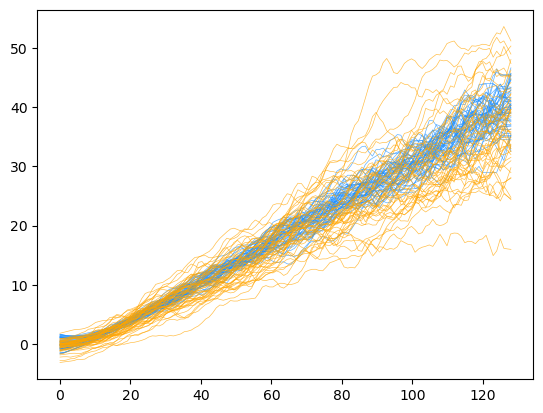

In [81]:
for real_samples_midpoint_128_ in real_samples_midpoint_128[:50]:
    plt.plot(ts_midpoint_128.cpu(), real_samples_midpoint_128_.cpu(), label='real', color='dodgerblue', linewidth=0.5, alpha=0.7)
for generated_samples_midpoint_128_ in generated_samples_midpoint_128[:50]:
    plt.plot(ts_midpoint_128.cpu(), generated_samples_midpoint_128_.cpu(), label='generated', color='orange', linewidth=0.5, alpha=0.7)


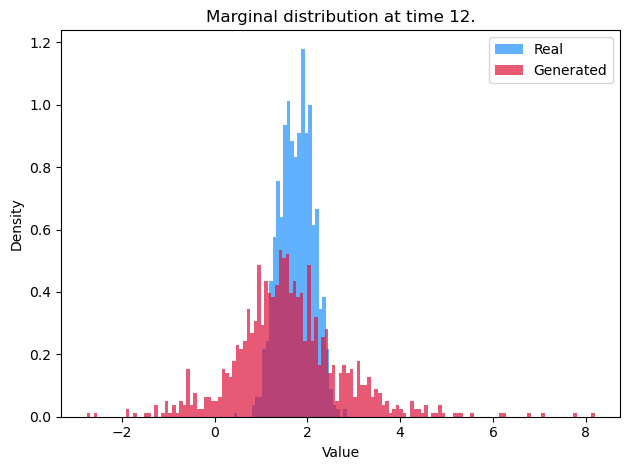

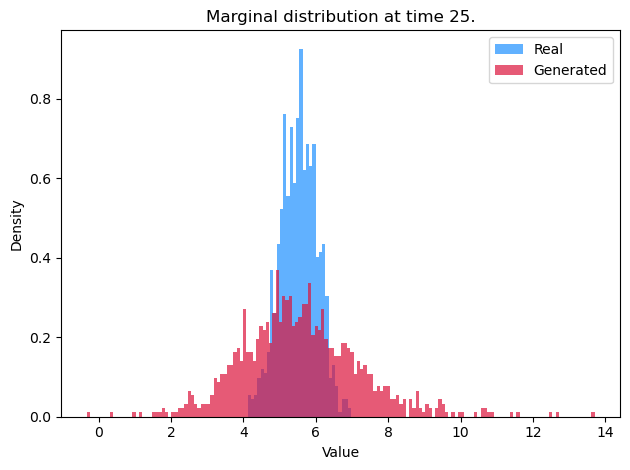

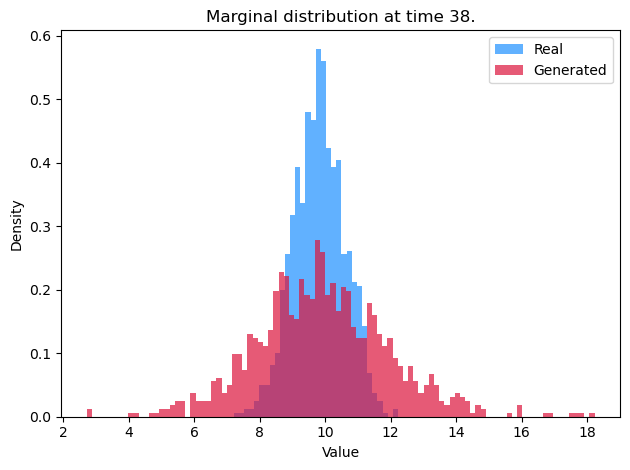

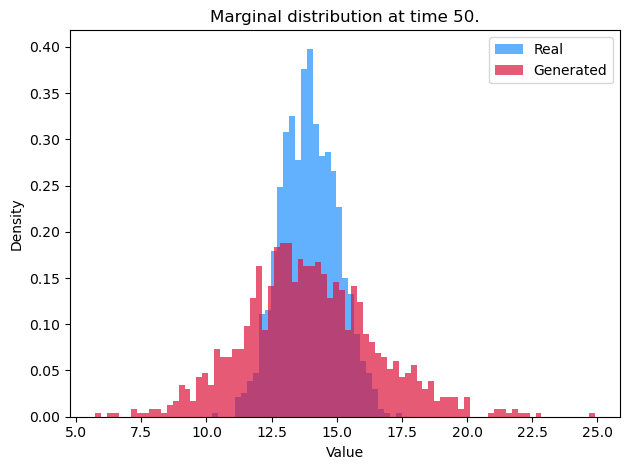

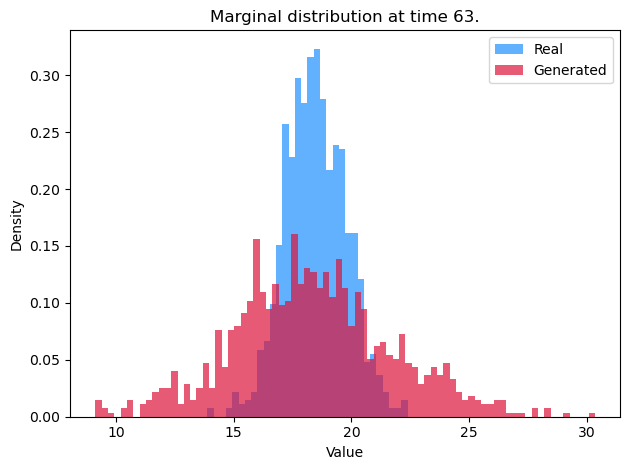

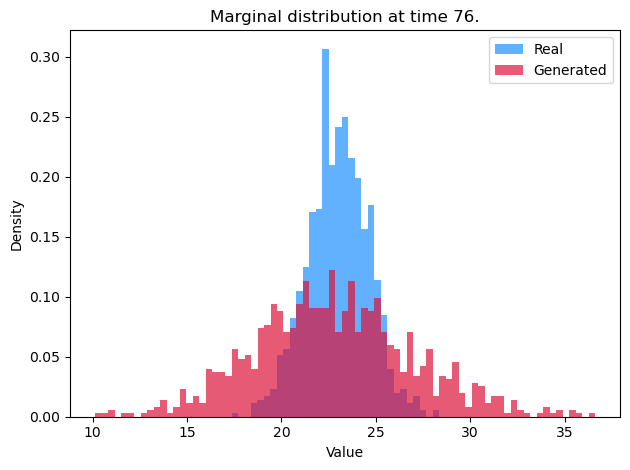

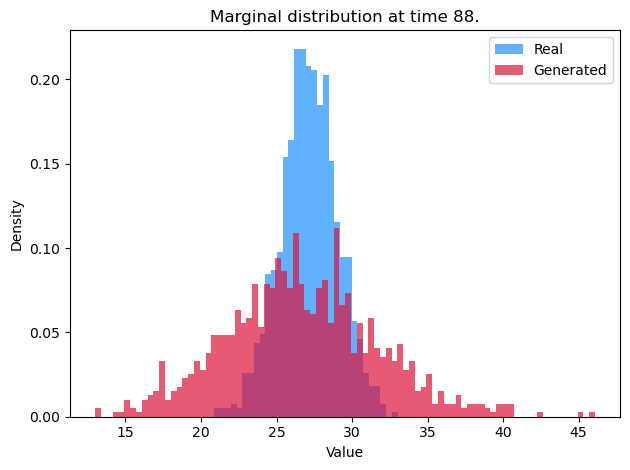

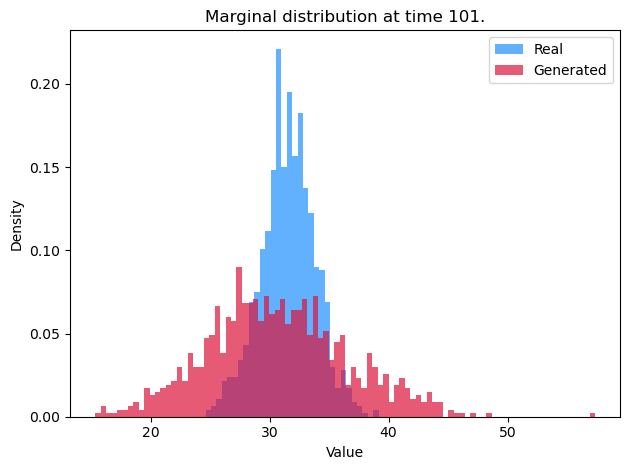

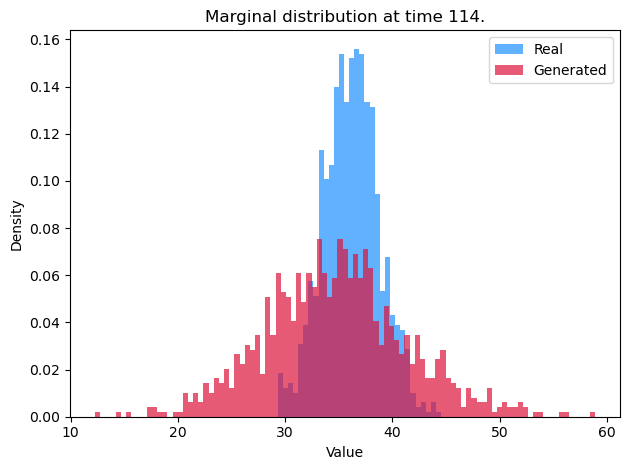

In [82]:
plot_hist(real_samples_midpoint_128, generated_samples_midpoint_128)

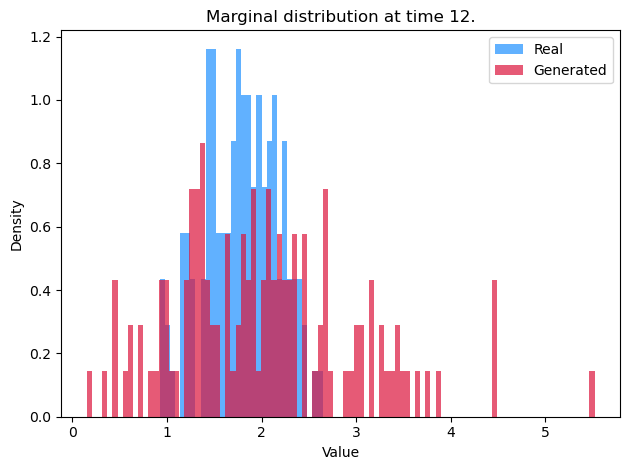

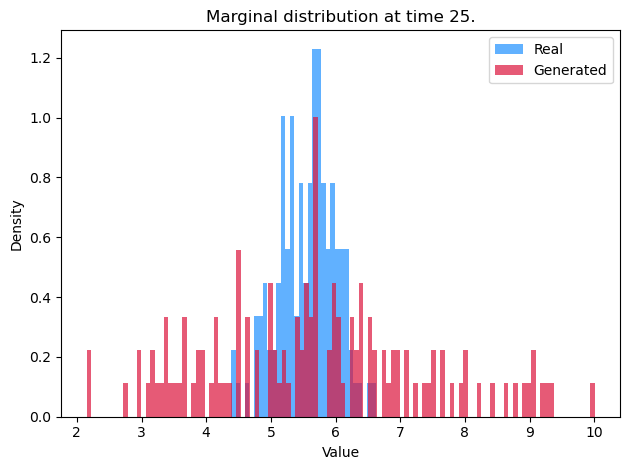

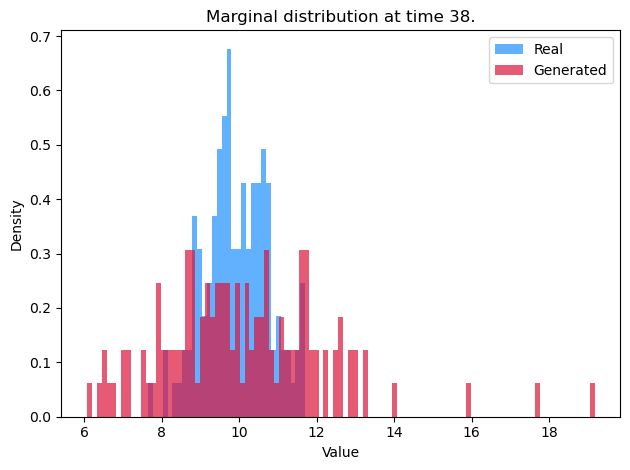

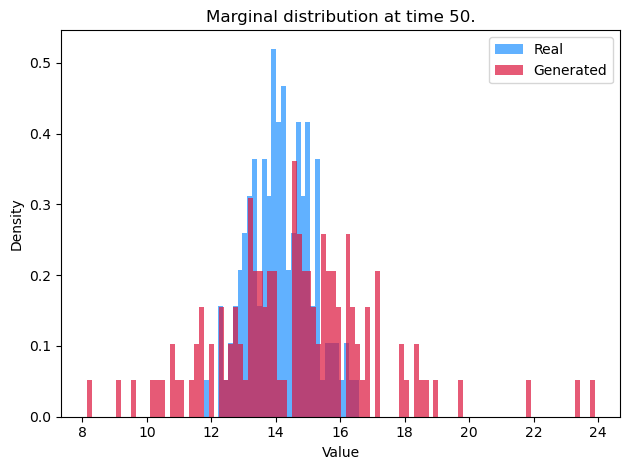

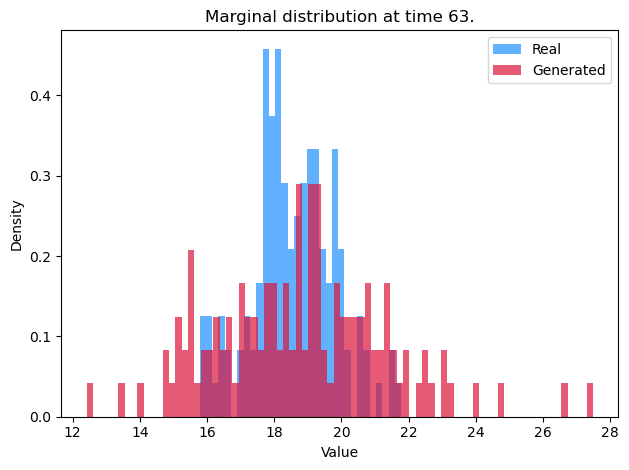

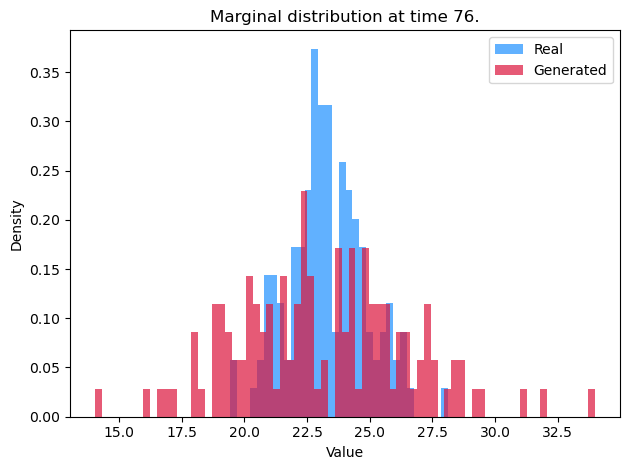

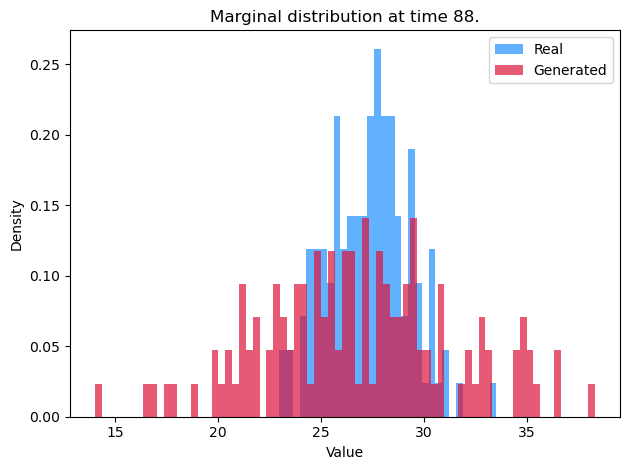

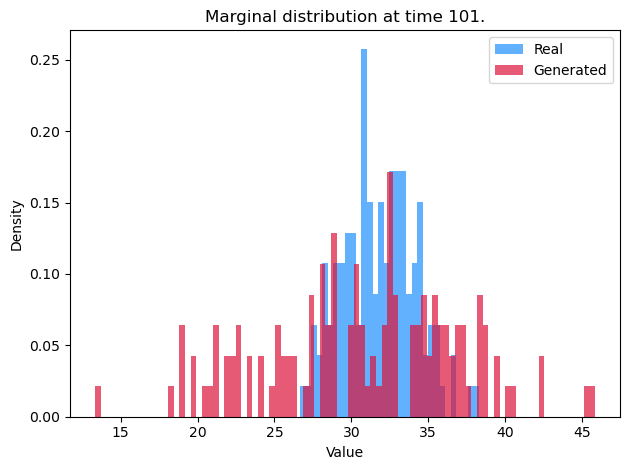

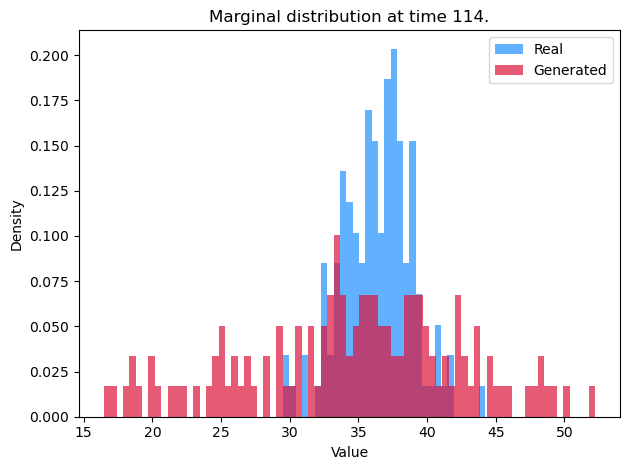

In [90]:
plot_hist(real_samples_bp_128, generated_samples_bp_128)